In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

matplotlib.rcParams.update({'font.size': 22})

In [2]:
# Set seed
np.random.seed(8)
torch.manual_seed(8)

# Load Boston Housing dataset
wine_quality = np.genfromtxt('data/winequality-red.csv', delimiter=";")[1:,:]
target = wine_quality[:,-1].reshape(-1,1)
data = wine_quality[:,:-1]

# Split into training, validation and test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=150, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=150, random_state=8)

# Convert arrays to Torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).view(-1,1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

# Normalise the training dataset
X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

# Define the data-loader
train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=150)
test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=150)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(11, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds[:,self.n-1]

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

## SGLD

In [6]:
import torch
import torchvision
import os

from torch import nn
import torch.nn.functional as F
import numpy as np

import sgld

import model



np.random.seed(8)
torch.manual_seed(8)



lambda_ = 1.
#lr = 8e-7
#lr = 6e-6
#3e-2
# lr = 9e-7
# lr = 3e-6
lr = 3e-5



batch_size = 32.
dataset_size= 1299

n_samples = 300
n_chains = 10




ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))
predictions_sgld = np.zeros((n_chains,n_samples,150))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse,ll,prediction = evaluate.fn(network)
                rmse_sgld[i,n] = rmse
                ll_sgld[i,n] = ll
                predictions_sgld[i,n,:] = prediction
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.8196
chain 0 - epoch 1 - loss: 10.8672
chain 0 - epoch 2 - loss: 10.7532
chain 0 - epoch 3 - loss: 10.5974
chain 0 - epoch 4 - loss: 10.6099
chain 0 - epoch 5 - loss: 10.6142
chain 0 - epoch 6 - loss: 10.6454


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 10.7012
chain 0 - epoch 8 - loss: 10.6123
chain 0 - epoch 9 - loss: 10.6347
chain 0 - epoch 10 - loss: 10.6511
chain 0 - epoch 11 - loss: 10.7680
chain 0 - epoch 12 - loss: 10.6737
chain 0 - epoch 13 - loss: 10.5949
chain 0 - epoch 14 - loss: 10.8258
chain 0 - epoch 15 - loss: 10.5781
chain 0 - epoch 16 - loss: 10.7046
chain 0 - epoch 17 - loss: 10.5371
chain 0 - epoch 18 - loss: 10.4245
chain 0 - epoch 19 - loss: 10.5205
chain 0 - epoch 20 - loss: 10.7169
chain 0 - epoch 21 - loss: 10.5808
chain 0 - epoch 22 - loss: 10.4711
chain 0 - epoch 23 - loss: 10.7209
chain 0 - epoch 24 - loss: 10.4651
chain 0 - epoch 25 - loss: 10.7019
chain 0 - epoch 26 - loss: 10.7113
chain 0 - epoch 27 - loss: 10.6628
chain 0 - epoch 28 - loss: 10.7133
chain 0 - epoch 29 - loss: 10.4793
chain 0 - epoch 30 - loss: 10.5111
chain 0 - epoch 31 - loss: 10.6643
chain 0 - epoch 32 - loss: 10.5782
chain 0 - epoch 33 - loss: 10.5398
chain 0 - epoch 34 - loss: 10.3303
chain 0 - epoch 35 - lo

chain 0 - epoch 240 - loss: 12.5055
chain 0 - epoch 241 - loss: 13.0329
chain 0 - epoch 242 - loss: 12.2144
chain 0 - epoch 243 - loss: 13.3224
chain 0 - epoch 244 - loss: 12.1209
chain 0 - epoch 245 - loss: 14.1039
chain 0 - epoch 246 - loss: 11.7295
chain 0 - epoch 247 - loss: 12.8333
chain 0 - epoch 248 - loss: 11.0972
chain 0 - epoch 249 - loss: 12.0370
chain 0 - epoch 250 - loss: 13.8537
chain 0 - epoch 251 - loss: 11.8574
chain 0 - epoch 252 - loss: 12.0834
chain 0 - epoch 253 - loss: 11.9606
chain 0 - epoch 254 - loss: 12.2907
chain 0 - epoch 255 - loss: 12.3156
chain 0 - epoch 256 - loss: 12.2429
chain 0 - epoch 257 - loss: 13.5930
chain 0 - epoch 258 - loss: 11.9272
chain 0 - epoch 259 - loss: 13.2638
chain 0 - epoch 260 - loss: 12.7163
chain 0 - epoch 261 - loss: 12.1102
chain 0 - epoch 262 - loss: 11.2174
chain 0 - epoch 263 - loss: 12.3492
chain 0 - epoch 264 - loss: 12.8113
chain 0 - epoch 265 - loss: 12.3208
chain 0 - epoch 266 - loss: 11.5598
chain 0 - epoch 267 - loss: 

chain 0 - epoch 473 - loss: 8.4675
chain 0 - epoch 474 - loss: 8.4235
chain 0 - epoch 475 - loss: 8.5877
chain 0 - epoch 476 - loss: 8.8183
chain 0 - epoch 477 - loss: 8.8860
chain 0 - epoch 478 - loss: 8.9024
chain 0 - epoch 479 - loss: 8.7787
chain 0 - epoch 480 - loss: 8.6924
chain 0 - epoch 481 - loss: 8.6258
chain 0 - epoch 482 - loss: 9.1385
chain 0 - epoch 483 - loss: 8.6664
chain 0 - epoch 484 - loss: 8.6496
chain 0 - epoch 485 - loss: 8.7403
chain 0 - epoch 486 - loss: 8.7186
chain 0 - epoch 487 - loss: 8.4647
chain 0 - epoch 488 - loss: 8.2808
chain 0 - epoch 489 - loss: 8.5215
chain 0 - epoch 490 - loss: 8.5503
chain 0 - epoch 491 - loss: 8.4198
chain 0 - epoch 492 - loss: 8.7844
chain 0 - epoch 493 - loss: 8.7367
chain 0 - epoch 494 - loss: 8.6970
chain 0 - epoch 495 - loss: 9.0175
chain 0 - epoch 496 - loss: 8.7235
chain 0 - epoch 497 - loss: 8.7464
chain 0 - epoch 498 - loss: 8.8803
chain 0 - epoch 499 - loss: 8.7050
chain 0 - epoch 500 - loss: 9.0511
chain 0 - epoch 501 

chain 0 - epoch 710 - loss: 8.6213
chain 0 - epoch 711 - loss: 8.7169
chain 0 - epoch 712 - loss: 8.4553
chain 0 - epoch 713 - loss: 8.4898
chain 0 - epoch 714 - loss: 8.7377
chain 0 - epoch 715 - loss: 8.5551
chain 0 - epoch 716 - loss: 8.8138
chain 0 - epoch 717 - loss: 8.9158
chain 0 - epoch 718 - loss: 8.7552
chain 0 - epoch 719 - loss: 8.8943
chain 0 - epoch 720 - loss: 8.9902
chain 0 - epoch 721 - loss: 8.3853
chain 0 - epoch 722 - loss: 8.5899
chain 0 - epoch 723 - loss: 7.9567
chain 0 - epoch 724 - loss: 8.0991
chain 0 - epoch 725 - loss: 8.0575
chain 0 - epoch 726 - loss: 8.1135
chain 0 - epoch 727 - loss: 8.3974
chain 0 - epoch 728 - loss: 8.8467
chain 0 - epoch 729 - loss: 8.4344
chain 0 - epoch 730 - loss: 8.0978
chain 0 - epoch 731 - loss: 8.1244
chain 0 - epoch 732 - loss: 7.1824
chain 0 - epoch 733 - loss: 7.0563
chain 0 - epoch 734 - loss: 7.1437
chain 0 - epoch 735 - loss: 7.0997
chain 0 - epoch 736 - loss: 7.1743
chain 0 - epoch 737 - loss: 7.1040
chain 0 - epoch 738 

chain 0 - epoch 946 - loss: 7.1533
chain 0 - epoch 947 - loss: 7.3543
chain 0 - epoch 948 - loss: 7.1338
chain 0 - epoch 949 - loss: 7.1813
chain 0 - epoch 950 - loss: 7.4278
chain 0 - epoch 951 - loss: 7.2675
chain 0 - epoch 952 - loss: 7.2980
chain 0 - epoch 953 - loss: 7.2343
chain 0 - epoch 954 - loss: 7.2663
chain 0 - epoch 955 - loss: 7.2992
chain 0 - epoch 956 - loss: 7.3997
chain 0 - epoch 957 - loss: 7.3687
chain 0 - epoch 958 - loss: 7.2609
chain 0 - epoch 959 - loss: 7.2537
chain 0 - epoch 960 - loss: 7.4990
chain 0 - epoch 961 - loss: 7.5103
chain 0 - epoch 962 - loss: 7.2234
chain 0 - epoch 963 - loss: 7.4565
chain 0 - epoch 964 - loss: 7.3220
chain 0 - epoch 965 - loss: 7.4403
chain 0 - epoch 966 - loss: 7.3809
chain 0 - epoch 967 - loss: 7.2044
chain 0 - epoch 968 - loss: 7.2086
chain 0 - epoch 969 - loss: 7.2595
chain 0 - epoch 970 - loss: 7.0846
chain 0 - epoch 971 - loss: 7.3021
chain 0 - epoch 972 - loss: 7.3006
chain 0 - epoch 973 - loss: 7.3446
chain 0 - epoch 974 

chain 0 - epoch 1178 - loss: 7.0226
chain 0 - epoch 1179 - loss: 7.1099
chain 0 - epoch 1180 - loss: 7.0962
chain 0 - epoch 1181 - loss: 6.9853
chain 0 - epoch 1182 - loss: 6.9911
chain 0 - epoch 1183 - loss: 7.0010
chain 0 - epoch 1184 - loss: 7.2431
chain 0 - epoch 1185 - loss: 7.0883
chain 0 - epoch 1186 - loss: 7.0832
chain 0 - epoch 1187 - loss: 7.0807
chain 0 - epoch 1188 - loss: 7.1718
chain 0 - epoch 1189 - loss: 6.9610
chain 0 - epoch 1190 - loss: 7.0465
chain 0 - epoch 1191 - loss: 7.0836
chain 0 - epoch 1192 - loss: 7.0148
chain 0 - epoch 1193 - loss: 7.1526
chain 0 - epoch 1194 - loss: 7.1603
chain 0 - epoch 1195 - loss: 7.1430
chain 0 - epoch 1196 - loss: 6.9386
chain 0 - epoch 1197 - loss: 6.9873
chain 0 - epoch 1198 - loss: 7.0120
chain 0 - epoch 1199 - loss: 7.0479
chain 0 - epoch 1200 - loss: 7.0843
chain 0 - epoch 1201 - loss: 7.0828
chain 0 - epoch 1202 - loss: 7.0546
chain 0 - epoch 1203 - loss: 7.0874
chain 0 - epoch 1204 - loss: 7.0198
chain 0 - epoch 1205 - loss:

chain 0 - epoch 1409 - loss: 7.1612
chain 0 - epoch 1410 - loss: 7.1997
chain 0 - epoch 1411 - loss: 7.0626
chain 0 - epoch 1412 - loss: 7.0213
chain 0 - epoch 1413 - loss: 7.1528
chain 0 - epoch 1414 - loss: 6.9557
chain 0 - epoch 1415 - loss: 6.9293
chain 0 - epoch 1416 - loss: 6.9998
chain 0 - epoch 1417 - loss: 7.2238
chain 0 - epoch 1418 - loss: 6.9848
chain 0 - epoch 1419 - loss: 7.0978
chain 0 - epoch 1420 - loss: 7.1400
chain 0 - epoch 1421 - loss: 7.1903
chain 0 - epoch 1422 - loss: 7.2867
chain 0 - epoch 1423 - loss: 7.1051
chain 0 - epoch 1424 - loss: 7.1851
chain 0 - epoch 1425 - loss: 6.9756
chain 0 - epoch 1426 - loss: 7.1382
chain 0 - epoch 1427 - loss: 7.0441
chain 0 - epoch 1428 - loss: 7.0739
chain 0 - epoch 1429 - loss: 7.0658
chain 0 - epoch 1430 - loss: 7.0591
chain 0 - epoch 1431 - loss: 7.1367
chain 0 - epoch 1432 - loss: 7.0640
chain 0 - epoch 1433 - loss: 7.1599
chain 0 - epoch 1434 - loss: 7.0167
chain 0 - epoch 1435 - loss: 7.2915
chain 0 - epoch 1436 - loss:

chain 0 - epoch 1638 - loss: 7.2575
chain 0 - epoch 1639 - loss: 7.2518
chain 0 - epoch 1640 - loss: 7.1908
chain 0 - epoch 1641 - loss: 7.2256
chain 0 - epoch 1642 - loss: 7.0969
chain 0 - epoch 1643 - loss: 7.1847
chain 0 - epoch 1644 - loss: 7.1616
chain 0 - epoch 1645 - loss: 7.0699
chain 0 - epoch 1646 - loss: 7.0168
chain 0 - epoch 1647 - loss: 7.0804
chain 0 - epoch 1648 - loss: 6.9877
chain 0 - epoch 1649 - loss: 7.0497
chain 0 - epoch 1650 - loss: 6.9542
chain 0 - epoch 1651 - loss: 6.9671
chain 0 - epoch 1652 - loss: 6.9433
chain 0 - epoch 1653 - loss: 6.8388
chain 0 - epoch 1654 - loss: 6.8054
chain 0 - epoch 1655 - loss: 6.9359
chain 0 - epoch 1656 - loss: 6.9727
chain 0 - epoch 1657 - loss: 6.8531
chain 0 - epoch 1658 - loss: 6.9597
chain 0 - epoch 1659 - loss: 7.0470
chain 0 - epoch 1660 - loss: 7.0632
chain 0 - epoch 1661 - loss: 6.9949
chain 0 - epoch 1662 - loss: 7.0219
chain 0 - epoch 1663 - loss: 7.1375
chain 0 - epoch 1664 - loss: 7.0476
chain 0 - epoch 1665 - loss:

chain 0 - epoch 1867 - loss: 6.9405
chain 0 - epoch 1868 - loss: 7.0387
chain 0 - epoch 1869 - loss: 7.0805
chain 0 - epoch 1870 - loss: 7.0259
chain 0 - epoch 1871 - loss: 6.9722
chain 0 - epoch 1872 - loss: 6.9387
chain 0 - epoch 1873 - loss: 6.9702
chain 0 - epoch 1874 - loss: 6.9989
chain 0 - epoch 1875 - loss: 6.8973
chain 0 - epoch 1876 - loss: 6.9454
chain 0 - epoch 1877 - loss: 6.8998
chain 0 - epoch 1878 - loss: 6.9909
chain 0 - epoch 1879 - loss: 6.8874
chain 0 - epoch 1880 - loss: 6.8698
chain 0 - epoch 1881 - loss: 6.8721
chain 0 - epoch 1882 - loss: 6.8052
chain 0 - epoch 1883 - loss: 6.8230
chain 0 - epoch 1884 - loss: 6.8568
chain 0 - epoch 1885 - loss: 6.8934
chain 0 - epoch 1886 - loss: 6.8521
chain 0 - epoch 1887 - loss: 6.8662
chain 0 - epoch 1888 - loss: 6.9106
chain 0 - epoch 1889 - loss: 6.9333
chain 0 - epoch 1890 - loss: 6.9755
chain 0 - epoch 1891 - loss: 6.9691
chain 0 - epoch 1892 - loss: 6.7948
chain 0 - epoch 1893 - loss: 6.8086
chain 0 - epoch 1894 - loss:

chain 0 - epoch 2099 - loss: 7.0888
chain 0 - epoch 2100 - loss: 7.1609
chain 0 - epoch 2101 - loss: 7.2577
chain 0 - epoch 2102 - loss: 7.1181
chain 0 - epoch 2103 - loss: 7.0587
chain 0 - epoch 2104 - loss: 7.2562
chain 0 - epoch 2105 - loss: 7.1528
chain 0 - epoch 2106 - loss: 7.2696
chain 0 - epoch 2107 - loss: 7.1435
chain 0 - epoch 2108 - loss: 7.1197
chain 0 - epoch 2109 - loss: 7.0536
chain 0 - epoch 2110 - loss: 6.9678
chain 0 - epoch 2111 - loss: 6.9694
chain 0 - epoch 2112 - loss: 7.0492
chain 0 - epoch 2113 - loss: 6.9852
chain 0 - epoch 2114 - loss: 6.9872
chain 0 - epoch 2115 - loss: 6.9496
chain 0 - epoch 2116 - loss: 6.9674
chain 0 - epoch 2117 - loss: 6.9824
chain 0 - epoch 2118 - loss: 6.9490
chain 0 - epoch 2119 - loss: 6.9250
chain 0 - epoch 2120 - loss: 6.9342
chain 0 - epoch 2121 - loss: 6.9253
chain 0 - epoch 2122 - loss: 6.9351
chain 0 - epoch 2123 - loss: 6.9130
chain 0 - epoch 2124 - loss: 6.9035
chain 0 - epoch 2125 - loss: 6.9391
chain 0 - epoch 2126 - loss:

chain 0 - epoch 2331 - loss: 7.3829
chain 0 - epoch 2332 - loss: 7.3053
chain 0 - epoch 2333 - loss: 7.3073
chain 0 - epoch 2334 - loss: 7.2656
chain 0 - epoch 2335 - loss: 7.3217
chain 0 - epoch 2336 - loss: 7.3138
chain 0 - epoch 2337 - loss: 7.3215
chain 0 - epoch 2338 - loss: 7.3365
chain 0 - epoch 2339 - loss: 7.4574
chain 0 - epoch 2340 - loss: 7.5584
chain 0 - epoch 2341 - loss: 7.5096
chain 0 - epoch 2342 - loss: 7.4350
chain 0 - epoch 2343 - loss: 7.4259
chain 0 - epoch 2344 - loss: 7.4738
chain 0 - epoch 2345 - loss: 7.4577
chain 0 - epoch 2346 - loss: 7.4095
chain 0 - epoch 2347 - loss: 7.3661
chain 0 - epoch 2348 - loss: 7.3041
chain 0 - epoch 2349 - loss: 7.3743
chain 0 - epoch 2350 - loss: 7.4090
chain 0 - epoch 2351 - loss: 7.3733
chain 0 - epoch 2352 - loss: 7.3545
chain 0 - epoch 2353 - loss: 7.3694
chain 0 - epoch 2354 - loss: 7.3396
chain 0 - epoch 2355 - loss: 7.3499
chain 0 - epoch 2356 - loss: 7.3310
chain 0 - epoch 2357 - loss: 7.3801
chain 0 - epoch 2358 - loss:

chain 1 - epoch 63 - loss: 10.2324
chain 1 - epoch 64 - loss: 10.4751
chain 1 - epoch 65 - loss: 10.3446
chain 1 - epoch 66 - loss: 10.4713
chain 1 - epoch 67 - loss: 10.2700
chain 1 - epoch 68 - loss: 10.4680
chain 1 - epoch 69 - loss: 10.2414
chain 1 - epoch 70 - loss: 10.2643
chain 1 - epoch 71 - loss: 10.2600
chain 1 - epoch 72 - loss: 10.4977
chain 1 - epoch 73 - loss: 10.4919
chain 1 - epoch 74 - loss: 10.5663
chain 1 - epoch 75 - loss: 10.6375
chain 1 - epoch 76 - loss: 10.7374
chain 1 - epoch 77 - loss: 10.4083
chain 1 - epoch 78 - loss: 10.9162
chain 1 - epoch 79 - loss: 10.8310
chain 1 - epoch 80 - loss: 10.8861
chain 1 - epoch 81 - loss: 10.3880
chain 1 - epoch 82 - loss: 10.9584
chain 1 - epoch 83 - loss: 10.6547
chain 1 - epoch 84 - loss: 10.8441
chain 1 - epoch 85 - loss: 11.0361
chain 1 - epoch 86 - loss: 10.3706
chain 1 - epoch 87 - loss: 10.7440
chain 1 - epoch 88 - loss: 10.3202
chain 1 - epoch 89 - loss: 10.7928
chain 1 - epoch 90 - loss: 11.1374
chain 1 - epoch 91 -

chain 1 - epoch 294 - loss: 13.2601
chain 1 - epoch 295 - loss: 10.9732
chain 1 - epoch 296 - loss: 12.8814
chain 1 - epoch 297 - loss: 11.8313
chain 1 - epoch 298 - loss: 10.9910
chain 1 - epoch 299 - loss: 11.5206
chain 1 - epoch 300 - loss: 10.4962
chain 1 - epoch 301 - loss: 10.6412
chain 1 - epoch 302 - loss: 12.1113
chain 1 - epoch 303 - loss: 11.5299
chain 1 - epoch 304 - loss: 11.5660
chain 1 - epoch 305 - loss: 12.2049
chain 1 - epoch 306 - loss: 11.2044
chain 1 - epoch 307 - loss: 11.6212
chain 1 - epoch 308 - loss: 12.2552
chain 1 - epoch 309 - loss: 13.1567
chain 1 - epoch 310 - loss: 10.8991
chain 1 - epoch 311 - loss: 11.0538
chain 1 - epoch 312 - loss: 11.4884
chain 1 - epoch 313 - loss: 11.2471
chain 1 - epoch 314 - loss: 10.8312
chain 1 - epoch 315 - loss: 10.9252
chain 1 - epoch 316 - loss: 11.8727
chain 1 - epoch 317 - loss: 12.8247
chain 1 - epoch 318 - loss: 11.5530
chain 1 - epoch 319 - loss: 12.4226
chain 1 - epoch 320 - loss: 13.2573
chain 1 - epoch 321 - loss: 

chain 1 - epoch 527 - loss: 8.5091
chain 1 - epoch 528 - loss: 8.8423
chain 1 - epoch 529 - loss: 9.0365
chain 1 - epoch 530 - loss: 8.6913
chain 1 - epoch 531 - loss: 8.8629
chain 1 - epoch 532 - loss: 9.0742
chain 1 - epoch 533 - loss: 9.0056
chain 1 - epoch 534 - loss: 8.8610
chain 1 - epoch 535 - loss: 9.0963
chain 1 - epoch 536 - loss: 9.1268
chain 1 - epoch 537 - loss: 8.8845
chain 1 - epoch 538 - loss: 8.6689
chain 1 - epoch 539 - loss: 8.8194
chain 1 - epoch 540 - loss: 8.7305
chain 1 - epoch 541 - loss: 8.8605
chain 1 - epoch 542 - loss: 8.8505
chain 1 - epoch 543 - loss: 8.6624
chain 1 - epoch 544 - loss: 8.9497
chain 1 - epoch 545 - loss: 8.6932
chain 1 - epoch 546 - loss: 8.8910
chain 1 - epoch 547 - loss: 9.0518
chain 1 - epoch 548 - loss: 8.8842
chain 1 - epoch 549 - loss: 9.3684
chain 1 - epoch 550 - loss: 9.1894
chain 1 - epoch 551 - loss: 8.6748
chain 1 - epoch 552 - loss: 8.9106
chain 1 - epoch 553 - loss: 9.0257
chain 1 - epoch 554 - loss: 8.6636
chain 1 - epoch 555 

chain 1 - epoch 761 - loss: 7.8844
chain 1 - epoch 762 - loss: 7.8641
chain 1 - epoch 763 - loss: 8.1114
chain 1 - epoch 764 - loss: 7.9132
chain 1 - epoch 765 - loss: 7.8686
chain 1 - epoch 766 - loss: 7.9728
chain 1 - epoch 767 - loss: 8.0741
chain 1 - epoch 768 - loss: 7.9081
chain 1 - epoch 769 - loss: 7.7526
chain 1 - epoch 770 - loss: 7.7146
chain 1 - epoch 771 - loss: 7.5921
chain 1 - epoch 772 - loss: 7.5625
chain 1 - epoch 773 - loss: 7.8455
chain 1 - epoch 774 - loss: 7.8907
chain 1 - epoch 775 - loss: 7.6970
chain 1 - epoch 776 - loss: 7.7041
chain 1 - epoch 777 - loss: 7.7801
chain 1 - epoch 778 - loss: 7.7252
chain 1 - epoch 779 - loss: 7.6877
chain 1 - epoch 780 - loss: 7.6623
chain 1 - epoch 781 - loss: 8.2461
chain 1 - epoch 782 - loss: 7.9794
chain 1 - epoch 783 - loss: 7.9994
chain 1 - epoch 784 - loss: 8.0308
chain 1 - epoch 785 - loss: 8.0021
chain 1 - epoch 786 - loss: 7.9727
chain 1 - epoch 787 - loss: 8.1027
chain 1 - epoch 788 - loss: 8.1100
chain 1 - epoch 789 

chain 1 - epoch 998 - loss: 7.5285
chain 1 - epoch 999 - loss: 7.3566
chain 1 - epoch 1000 - loss: 7.4909
chain 1 - epoch 1001 - loss: 7.4802
chain 1 - epoch 1002 - loss: 7.3839
chain 1 - epoch 1003 - loss: 7.3751
chain 1 - epoch 1004 - loss: 7.5019
chain 1 - epoch 1005 - loss: 7.3485
chain 1 - epoch 1006 - loss: 7.1448
chain 1 - epoch 1007 - loss: 7.1701
chain 1 - epoch 1008 - loss: 7.3151
chain 1 - epoch 1009 - loss: 7.2606
chain 1 - epoch 1010 - loss: 7.4753
chain 1 - epoch 1011 - loss: 7.2057
chain 1 - epoch 1012 - loss: 7.3446
chain 1 - epoch 1013 - loss: 7.3375
chain 1 - epoch 1014 - loss: 7.1940
chain 1 - epoch 1015 - loss: 7.3710
chain 1 - epoch 1016 - loss: 7.3141
chain 1 - epoch 1017 - loss: 7.4563
chain 1 - epoch 1018 - loss: 7.3244
chain 1 - epoch 1019 - loss: 7.3073
chain 1 - epoch 1020 - loss: 7.3150
chain 1 - epoch 1021 - loss: 7.3925
chain 1 - epoch 1022 - loss: 7.5033
chain 1 - epoch 1023 - loss: 7.4788
chain 1 - epoch 1024 - loss: 7.5838
chain 1 - epoch 1025 - loss: 7

chain 1 - epoch 1229 - loss: 7.0184
chain 1 - epoch 1230 - loss: 7.1977
chain 1 - epoch 1231 - loss: 7.4809
chain 1 - epoch 1232 - loss: 7.1070
chain 1 - epoch 1233 - loss: 7.1334
chain 1 - epoch 1234 - loss: 7.0811
chain 1 - epoch 1235 - loss: 7.1845
chain 1 - epoch 1236 - loss: 7.0644
chain 1 - epoch 1237 - loss: 7.2400
chain 1 - epoch 1238 - loss: 7.1820
chain 1 - epoch 1239 - loss: 7.3247
chain 1 - epoch 1240 - loss: 7.3584
chain 1 - epoch 1241 - loss: 7.3771
chain 1 - epoch 1242 - loss: 7.4007
chain 1 - epoch 1243 - loss: 7.4801
chain 1 - epoch 1244 - loss: 7.3547
chain 1 - epoch 1245 - loss: 7.3404
chain 1 - epoch 1246 - loss: 7.3920
chain 1 - epoch 1247 - loss: 7.4899
chain 1 - epoch 1248 - loss: 7.6503
chain 1 - epoch 1249 - loss: 7.5904
chain 1 - epoch 1250 - loss: 7.6176
chain 1 - epoch 1251 - loss: 7.5567
chain 1 - epoch 1252 - loss: 7.4991
chain 1 - epoch 1253 - loss: 7.3734
chain 1 - epoch 1254 - loss: 7.2997
chain 1 - epoch 1255 - loss: 7.2592
chain 1 - epoch 1256 - loss:

chain 1 - epoch 1460 - loss: 7.2071
chain 1 - epoch 1461 - loss: 7.3038
chain 1 - epoch 1462 - loss: 7.1348
chain 1 - epoch 1463 - loss: 7.0680
chain 1 - epoch 1464 - loss: 7.1351
chain 1 - epoch 1465 - loss: 7.0694
chain 1 - epoch 1466 - loss: 7.0821
chain 1 - epoch 1467 - loss: 7.0463
chain 1 - epoch 1468 - loss: 7.0639
chain 1 - epoch 1469 - loss: 7.1669
chain 1 - epoch 1470 - loss: 7.1293
chain 1 - epoch 1471 - loss: 7.1945
chain 1 - epoch 1472 - loss: 7.0648
chain 1 - epoch 1473 - loss: 7.1926
chain 1 - epoch 1474 - loss: 7.0998
chain 1 - epoch 1475 - loss: 7.1246
chain 1 - epoch 1476 - loss: 7.1916
chain 1 - epoch 1477 - loss: 7.1045
chain 1 - epoch 1478 - loss: 7.0103
chain 1 - epoch 1479 - loss: 7.0290
chain 1 - epoch 1480 - loss: 7.0077
chain 1 - epoch 1481 - loss: 7.0846
chain 1 - epoch 1482 - loss: 7.1213
chain 1 - epoch 1483 - loss: 7.0015
chain 1 - epoch 1484 - loss: 7.0246
chain 1 - epoch 1485 - loss: 6.9844
chain 1 - epoch 1486 - loss: 7.0085
chain 1 - epoch 1487 - loss:

chain 1 - epoch 1692 - loss: 7.5258
chain 1 - epoch 1693 - loss: 7.4205
chain 1 - epoch 1694 - loss: 7.3682
chain 1 - epoch 1695 - loss: 7.3919
chain 1 - epoch 1696 - loss: 7.5944
chain 1 - epoch 1697 - loss: 7.4051
chain 1 - epoch 1698 - loss: 7.4065
chain 1 - epoch 1699 - loss: 7.3786
chain 1 - epoch 1700 - loss: 7.3811
chain 1 - epoch 1701 - loss: 7.4453
chain 1 - epoch 1702 - loss: 7.4487
chain 1 - epoch 1703 - loss: 7.4670
chain 1 - epoch 1704 - loss: 7.4862
chain 1 - epoch 1705 - loss: 7.5149
chain 1 - epoch 1706 - loss: 7.3935
chain 1 - epoch 1707 - loss: 7.2435
chain 1 - epoch 1708 - loss: 7.4152
chain 1 - epoch 1709 - loss: 7.4568
chain 1 - epoch 1710 - loss: 7.4800
chain 1 - epoch 1711 - loss: 7.5436
chain 1 - epoch 1712 - loss: 7.4699
chain 1 - epoch 1713 - loss: 7.4610
chain 1 - epoch 1714 - loss: 7.5528
chain 1 - epoch 1715 - loss: 7.4171
chain 1 - epoch 1716 - loss: 7.4234
chain 1 - epoch 1717 - loss: 7.3766
chain 1 - epoch 1718 - loss: 7.3676
chain 1 - epoch 1719 - loss:

chain 1 - epoch 1920 - loss: 7.1562
chain 1 - epoch 1921 - loss: 7.2101
chain 1 - epoch 1922 - loss: 7.0910
chain 1 - epoch 1923 - loss: 7.1107
chain 1 - epoch 1924 - loss: 7.0864
chain 1 - epoch 1925 - loss: 7.1526
chain 1 - epoch 1926 - loss: 7.1858
chain 1 - epoch 1927 - loss: 7.1979
chain 1 - epoch 1928 - loss: 7.1535
chain 1 - epoch 1929 - loss: 7.1789
chain 1 - epoch 1930 - loss: 7.1353
chain 1 - epoch 1931 - loss: 7.1238
chain 1 - epoch 1932 - loss: 7.1821
chain 1 - epoch 1933 - loss: 7.1376
chain 1 - epoch 1934 - loss: 7.1886
chain 1 - epoch 1935 - loss: 7.2405
chain 1 - epoch 1936 - loss: 7.2277
chain 1 - epoch 1937 - loss: 7.2047
chain 1 - epoch 1938 - loss: 7.3417
chain 1 - epoch 1939 - loss: 7.2942
chain 1 - epoch 1940 - loss: 7.2920
chain 1 - epoch 1941 - loss: 7.1958
chain 1 - epoch 1942 - loss: 7.2619
chain 1 - epoch 1943 - loss: 7.2468
chain 1 - epoch 1944 - loss: 7.2307
chain 1 - epoch 1945 - loss: 7.2293
chain 1 - epoch 1946 - loss: 7.2809
chain 1 - epoch 1947 - loss:

chain 1 - epoch 2151 - loss: 7.3932
chain 1 - epoch 2152 - loss: 7.4661
chain 1 - epoch 2153 - loss: 7.4162
chain 1 - epoch 2154 - loss: 7.3620
chain 1 - epoch 2155 - loss: 7.3069
chain 1 - epoch 2156 - loss: 7.3912
chain 1 - epoch 2157 - loss: 7.3614
chain 1 - epoch 2158 - loss: 7.3884
chain 1 - epoch 2159 - loss: 7.3562
chain 1 - epoch 2160 - loss: 7.5241
chain 1 - epoch 2161 - loss: 7.3964
chain 1 - epoch 2162 - loss: 7.5026
chain 1 - epoch 2163 - loss: 7.3434
chain 1 - epoch 2164 - loss: 7.3898
chain 1 - epoch 2165 - loss: 7.3304
chain 1 - epoch 2166 - loss: 7.2828
chain 1 - epoch 2167 - loss: 7.4204
chain 1 - epoch 2168 - loss: 7.3356
chain 1 - epoch 2169 - loss: 7.3532
chain 1 - epoch 2170 - loss: 7.3214
chain 1 - epoch 2171 - loss: 7.2889
chain 1 - epoch 2172 - loss: 7.3236
chain 1 - epoch 2173 - loss: 7.4023
chain 1 - epoch 2174 - loss: 7.4734
chain 1 - epoch 2175 - loss: 7.4121
chain 1 - epoch 2176 - loss: 7.4330
chain 1 - epoch 2177 - loss: 7.3869
chain 1 - epoch 2178 - loss:

chain 1 - epoch 2381 - loss: 7.0179
chain 1 - epoch 2382 - loss: 7.1242
chain 1 - epoch 2383 - loss: 7.1435
chain 1 - epoch 2384 - loss: 7.0837
chain 1 - epoch 2385 - loss: 7.0724
chain 1 - epoch 2386 - loss: 7.1061
chain 1 - epoch 2387 - loss: 7.0767
chain 1 - epoch 2388 - loss: 7.1247
chain 1 - epoch 2389 - loss: 7.1248
chain 1 - epoch 2390 - loss: 7.1660
chain 1 - epoch 2391 - loss: 7.1410
chain 1 - epoch 2392 - loss: 7.2067
chain 1 - epoch 2393 - loss: 7.1661
chain 1 - epoch 2394 - loss: 7.0751
chain 1 - epoch 2395 - loss: 7.0448
chain 1 - epoch 2396 - loss: 7.0887
chain 1 - epoch 2397 - loss: 7.1266
chain 1 - epoch 2398 - loss: 7.1354
chain 1 - epoch 2399 - loss: 7.1355
chain 1 - epoch 2400 - loss: 7.1062
chain 1 - epoch 2401 - loss: 7.0727
chain 1 - epoch 2402 - loss: 7.0829
chain 1 - epoch 2403 - loss: 7.0847
chain 1 - epoch 2404 - loss: 7.0321
chain 1 - epoch 2405 - loss: 7.1160
chain 1 - epoch 2406 - loss: 7.1474
chain 1 - epoch 2407 - loss: 7.0798
chain 1 - epoch 2408 - loss:

chain 2 - epoch 114 - loss: 11.1961
chain 2 - epoch 115 - loss: 10.7873
chain 2 - epoch 116 - loss: 10.7994
chain 2 - epoch 117 - loss: 10.5566
chain 2 - epoch 118 - loss: 10.9028
chain 2 - epoch 119 - loss: 10.3816
chain 2 - epoch 120 - loss: 10.2851
chain 2 - epoch 121 - loss: 10.3693
chain 2 - epoch 122 - loss: 10.1512
chain 2 - epoch 123 - loss: 10.2079
chain 2 - epoch 124 - loss: 10.7581
chain 2 - epoch 125 - loss: 10.5498
chain 2 - epoch 126 - loss: 10.1893
chain 2 - epoch 127 - loss: 10.2768
chain 2 - epoch 128 - loss: 10.7365
chain 2 - epoch 129 - loss: 10.3427
chain 2 - epoch 130 - loss: 10.0822
chain 2 - epoch 131 - loss: 10.5109
chain 2 - epoch 132 - loss: 10.4410
chain 2 - epoch 133 - loss: 10.1465
chain 2 - epoch 134 - loss: 10.4343
chain 2 - epoch 135 - loss: 11.1033
chain 2 - epoch 136 - loss: 10.8765
chain 2 - epoch 137 - loss: 10.6714
chain 2 - epoch 138 - loss: 11.2486
chain 2 - epoch 139 - loss: 10.7223
chain 2 - epoch 140 - loss: 10.9757
chain 2 - epoch 141 - loss: 

chain 2 - epoch 342 - loss: 11.5018
chain 2 - epoch 343 - loss: 10.8957
chain 2 - epoch 344 - loss: 11.1818
chain 2 - epoch 345 - loss: 12.5442
chain 2 - epoch 346 - loss: 11.4992
chain 2 - epoch 347 - loss: 14.9011
chain 2 - epoch 348 - loss: 13.4407
chain 2 - epoch 349 - loss: 11.6578
chain 2 - epoch 350 - loss: 13.6574
chain 2 - epoch 351 - loss: 12.6371
chain 2 - epoch 352 - loss: 11.0898
chain 2 - epoch 353 - loss: 11.3322
chain 2 - epoch 354 - loss: 11.6077
chain 2 - epoch 355 - loss: 12.0945
chain 2 - epoch 356 - loss: 11.9457
chain 2 - epoch 357 - loss: 12.3884
chain 2 - epoch 358 - loss: 13.7243
chain 2 - epoch 359 - loss: 11.5039
chain 2 - epoch 360 - loss: 11.9657
chain 2 - epoch 361 - loss: 11.5426
chain 2 - epoch 362 - loss: 11.2639
chain 2 - epoch 363 - loss: 15.1236
chain 2 - epoch 364 - loss: 14.9929
chain 2 - epoch 365 - loss: 12.4359
chain 2 - epoch 366 - loss: 8.6684
chain 2 - epoch 367 - loss: 8.7141
chain 2 - epoch 368 - loss: 8.5943
chain 2 - epoch 369 - loss: 8.8

chain 2 - epoch 577 - loss: 8.9157
chain 2 - epoch 578 - loss: 8.5266
chain 2 - epoch 579 - loss: 8.7915
chain 2 - epoch 580 - loss: 8.8961
chain 2 - epoch 581 - loss: 8.6058
chain 2 - epoch 582 - loss: 8.7792
chain 2 - epoch 583 - loss: 8.3862
chain 2 - epoch 584 - loss: 8.7461
chain 2 - epoch 585 - loss: 8.3935
chain 2 - epoch 586 - loss: 8.9377
chain 2 - epoch 587 - loss: 9.1308
chain 2 - epoch 588 - loss: 8.7737
chain 2 - epoch 589 - loss: 8.5638
chain 2 - epoch 590 - loss: 8.3881
chain 2 - epoch 591 - loss: 8.9096
chain 2 - epoch 592 - loss: 8.7073
chain 2 - epoch 593 - loss: 8.9658
chain 2 - epoch 594 - loss: 8.5986
chain 2 - epoch 595 - loss: 8.4659
chain 2 - epoch 596 - loss: 9.3591
chain 2 - epoch 597 - loss: 8.6981
chain 2 - epoch 598 - loss: 9.7406
chain 2 - epoch 599 - loss: 9.1755
chain 2 - epoch 600 - loss: 9.0769
chain 2 - epoch 601 - loss: 10.3610
chain 2 - epoch 602 - loss: 9.9312
chain 2 - epoch 603 - loss: 9.9269
chain 2 - epoch 604 - loss: 9.4571
chain 2 - epoch 605

chain 2 - epoch 812 - loss: 7.6726
chain 2 - epoch 813 - loss: 7.7068
chain 2 - epoch 814 - loss: 7.7027
chain 2 - epoch 815 - loss: 7.6700
chain 2 - epoch 816 - loss: 7.8534
chain 2 - epoch 817 - loss: 7.6426
chain 2 - epoch 818 - loss: 7.7810
chain 2 - epoch 819 - loss: 7.5628
chain 2 - epoch 820 - loss: 7.5156
chain 2 - epoch 821 - loss: 7.5125
chain 2 - epoch 822 - loss: 7.5688
chain 2 - epoch 823 - loss: 7.6008
chain 2 - epoch 824 - loss: 7.5972
chain 2 - epoch 825 - loss: 7.6718
chain 2 - epoch 826 - loss: 7.5729
chain 2 - epoch 827 - loss: 7.4868
chain 2 - epoch 828 - loss: 7.4504
chain 2 - epoch 829 - loss: 7.4640
chain 2 - epoch 830 - loss: 7.4326
chain 2 - epoch 831 - loss: 7.5849
chain 2 - epoch 832 - loss: 7.4516
chain 2 - epoch 833 - loss: 7.4780
chain 2 - epoch 834 - loss: 7.2695
chain 2 - epoch 835 - loss: 7.3038
chain 2 - epoch 836 - loss: 7.3625
chain 2 - epoch 837 - loss: 7.4418
chain 2 - epoch 838 - loss: 7.5207
chain 2 - epoch 839 - loss: 7.5536
chain 2 - epoch 840 

chain 2 - epoch 1047 - loss: 7.6380
chain 2 - epoch 1048 - loss: 7.4879
chain 2 - epoch 1049 - loss: 7.5258
chain 2 - epoch 1050 - loss: 7.4481
chain 2 - epoch 1051 - loss: 7.6002
chain 2 - epoch 1052 - loss: 7.3757
chain 2 - epoch 1053 - loss: 7.2955
chain 2 - epoch 1054 - loss: 7.4520
chain 2 - epoch 1055 - loss: 7.4343
chain 2 - epoch 1056 - loss: 7.3838
chain 2 - epoch 1057 - loss: 7.4114
chain 2 - epoch 1058 - loss: 7.5246
chain 2 - epoch 1059 - loss: 7.4172
chain 2 - epoch 1060 - loss: 7.1330
chain 2 - epoch 1061 - loss: 7.1449
chain 2 - epoch 1062 - loss: 7.3019
chain 2 - epoch 1063 - loss: 7.2815
chain 2 - epoch 1064 - loss: 7.2702
chain 2 - epoch 1065 - loss: 7.2517
chain 2 - epoch 1066 - loss: 7.2574
chain 2 - epoch 1067 - loss: 7.2822
chain 2 - epoch 1068 - loss: 7.2688
chain 2 - epoch 1069 - loss: 7.2806
chain 2 - epoch 1070 - loss: 7.2962
chain 2 - epoch 1071 - loss: 7.2471
chain 2 - epoch 1072 - loss: 7.3390
chain 2 - epoch 1073 - loss: 7.4431
chain 2 - epoch 1074 - loss:

chain 2 - epoch 1276 - loss: 7.2333
chain 2 - epoch 1277 - loss: 7.0606
chain 2 - epoch 1278 - loss: 7.0785
chain 2 - epoch 1279 - loss: 7.1966
chain 2 - epoch 1280 - loss: 7.2955
chain 2 - epoch 1281 - loss: 7.2840
chain 2 - epoch 1282 - loss: 7.2675
chain 2 - epoch 1283 - loss: 7.1381
chain 2 - epoch 1284 - loss: 7.2501
chain 2 - epoch 1285 - loss: 7.1004
chain 2 - epoch 1286 - loss: 7.2138
chain 2 - epoch 1287 - loss: 7.1992
chain 2 - epoch 1288 - loss: 7.1540
chain 2 - epoch 1289 - loss: 7.2777
chain 2 - epoch 1290 - loss: 7.2039
chain 2 - epoch 1291 - loss: 7.1907
chain 2 - epoch 1292 - loss: 7.1714
chain 2 - epoch 1293 - loss: 7.2493
chain 2 - epoch 1294 - loss: 7.1629
chain 2 - epoch 1295 - loss: 7.2765
chain 2 - epoch 1296 - loss: 7.1404
chain 2 - epoch 1297 - loss: 7.1082
chain 2 - epoch 1298 - loss: 7.1372
chain 2 - epoch 1299 - loss: 7.1356
chain 2 - epoch 1300 - loss: 7.1469
chain 2 - epoch 1301 - loss: 7.1822
chain 2 - epoch 1302 - loss: 7.2212
chain 2 - epoch 1303 - loss:

chain 2 - epoch 1504 - loss: 6.9237
chain 2 - epoch 1505 - loss: 7.0836
chain 2 - epoch 1506 - loss: 6.9698
chain 2 - epoch 1507 - loss: 7.0695
chain 2 - epoch 1508 - loss: 6.8856
chain 2 - epoch 1509 - loss: 7.0245
chain 2 - epoch 1510 - loss: 7.0125
chain 2 - epoch 1511 - loss: 7.0017
chain 2 - epoch 1512 - loss: 6.9230
chain 2 - epoch 1513 - loss: 6.9088
chain 2 - epoch 1514 - loss: 6.9752
chain 2 - epoch 1515 - loss: 7.1534
chain 2 - epoch 1516 - loss: 7.0529
chain 2 - epoch 1517 - loss: 7.0398
chain 2 - epoch 1518 - loss: 6.9879
chain 2 - epoch 1519 - loss: 6.9454
chain 2 - epoch 1520 - loss: 7.0719
chain 2 - epoch 1521 - loss: 7.1171
chain 2 - epoch 1522 - loss: 7.0507
chain 2 - epoch 1523 - loss: 7.1309
chain 2 - epoch 1524 - loss: 7.0730
chain 2 - epoch 1525 - loss: 7.1610
chain 2 - epoch 1526 - loss: 7.1155
chain 2 - epoch 1527 - loss: 7.1536
chain 2 - epoch 1528 - loss: 7.1048
chain 2 - epoch 1529 - loss: 7.1050
chain 2 - epoch 1530 - loss: 7.1503
chain 2 - epoch 1531 - loss:

chain 2 - epoch 1732 - loss: 6.9292
chain 2 - epoch 1733 - loss: 6.9453
chain 2 - epoch 1734 - loss: 6.9146
chain 2 - epoch 1735 - loss: 7.0021
chain 2 - epoch 1736 - loss: 6.8679
chain 2 - epoch 1737 - loss: 6.8698
chain 2 - epoch 1738 - loss: 7.0031
chain 2 - epoch 1739 - loss: 7.0026
chain 2 - epoch 1740 - loss: 7.0438
chain 2 - epoch 1741 - loss: 7.1338
chain 2 - epoch 1742 - loss: 7.0927
chain 2 - epoch 1743 - loss: 7.1723
chain 2 - epoch 1744 - loss: 7.1503
chain 2 - epoch 1745 - loss: 7.0427
chain 2 - epoch 1746 - loss: 7.1019
chain 2 - epoch 1747 - loss: 7.0721
chain 2 - epoch 1748 - loss: 6.9519
chain 2 - epoch 1749 - loss: 6.9172
chain 2 - epoch 1750 - loss: 6.9035
chain 2 - epoch 1751 - loss: 6.9665
chain 2 - epoch 1752 - loss: 6.9231
chain 2 - epoch 1753 - loss: 6.8887
chain 2 - epoch 1754 - loss: 6.8419
chain 2 - epoch 1755 - loss: 6.9777
chain 2 - epoch 1756 - loss: 6.8697
chain 2 - epoch 1757 - loss: 6.9914
chain 2 - epoch 1758 - loss: 7.0569
chain 2 - epoch 1759 - loss:

chain 2 - epoch 1961 - loss: 6.6115
chain 2 - epoch 1962 - loss: 6.6944
chain 2 - epoch 1963 - loss: 6.7403
chain 2 - epoch 1964 - loss: 6.7574
chain 2 - epoch 1965 - loss: 6.7421
chain 2 - epoch 1966 - loss: 6.8055
chain 2 - epoch 1967 - loss: 6.8795
chain 2 - epoch 1968 - loss: 6.8446
chain 2 - epoch 1969 - loss: 6.7831
chain 2 - epoch 1970 - loss: 6.7530
chain 2 - epoch 1971 - loss: 6.7342
chain 2 - epoch 1972 - loss: 6.7227
chain 2 - epoch 1973 - loss: 6.7364
chain 2 - epoch 1974 - loss: 6.7870
chain 2 - epoch 1975 - loss: 6.7429
chain 2 - epoch 1976 - loss: 6.7759
chain 2 - epoch 1977 - loss: 6.7147
chain 2 - epoch 1978 - loss: 6.7414
chain 2 - epoch 1979 - loss: 6.8302
chain 2 - epoch 1980 - loss: 6.7569
chain 2 - epoch 1981 - loss: 6.6933
chain 2 - epoch 1982 - loss: 6.7129
chain 2 - epoch 1983 - loss: 6.7186
chain 2 - epoch 1984 - loss: 6.6269
chain 2 - epoch 1985 - loss: 6.6233
chain 2 - epoch 1986 - loss: 6.8773
chain 2 - epoch 1987 - loss: 6.7358
chain 2 - epoch 1988 - loss:

chain 2 - epoch 2189 - loss: 6.5497
chain 2 - epoch 2190 - loss: 6.5483
chain 2 - epoch 2191 - loss: 6.6014
chain 2 - epoch 2192 - loss: 6.4398
chain 2 - epoch 2193 - loss: 6.5371
chain 2 - epoch 2194 - loss: 6.5350
chain 2 - epoch 2195 - loss: 6.5001
chain 2 - epoch 2196 - loss: 6.4389
chain 2 - epoch 2197 - loss: 6.4281
chain 2 - epoch 2198 - loss: 6.3457
chain 2 - epoch 2199 - loss: 6.4083
chain 2 - epoch 2200 - loss: 6.3982
chain 2 - epoch 2201 - loss: 6.3919
chain 2 - epoch 2202 - loss: 6.4856
chain 2 - epoch 2203 - loss: 6.4988
chain 2 - epoch 2204 - loss: 6.3997
chain 2 - epoch 2205 - loss: 6.4510
chain 2 - epoch 2206 - loss: 6.4727
chain 2 - epoch 2207 - loss: 6.5140
chain 2 - epoch 2208 - loss: 6.4994
chain 2 - epoch 2209 - loss: 6.5349
chain 2 - epoch 2210 - loss: 6.5719
chain 2 - epoch 2211 - loss: 6.6428
chain 2 - epoch 2212 - loss: 6.6143
chain 2 - epoch 2213 - loss: 6.6311
chain 2 - epoch 2214 - loss: 6.6139
chain 2 - epoch 2215 - loss: 6.5988
chain 2 - epoch 2216 - loss:

chain 2 - epoch 2417 - loss: 6.6164
chain 2 - epoch 2418 - loss: 6.6516
chain 2 - epoch 2419 - loss: 6.7321
chain 2 - epoch 2420 - loss: 6.7254
chain 2 - epoch 2421 - loss: 6.7710
chain 2 - epoch 2422 - loss: 6.6446
chain 2 - epoch 2423 - loss: 6.6975
chain 2 - epoch 2424 - loss: 6.7251
chain 2 - epoch 2425 - loss: 6.7113
chain 2 - epoch 2426 - loss: 6.6738
chain 2 - epoch 2427 - loss: 6.7466
chain 2 - epoch 2428 - loss: 6.6661
chain 2 - epoch 2429 - loss: 6.7265
chain 2 - epoch 2430 - loss: 6.7471
chain 2 - epoch 2431 - loss: 6.7111
chain 2 - epoch 2432 - loss: 6.7401
chain 2 - epoch 2433 - loss: 6.7675
chain 2 - epoch 2434 - loss: 6.7651
chain 2 - epoch 2435 - loss: 6.7225
chain 2 - epoch 2436 - loss: 6.7280
chain 2 - epoch 2437 - loss: 6.6909
chain 2 - epoch 2438 - loss: 6.6417
chain 2 - epoch 2439 - loss: 6.6565
chain 2 - epoch 2440 - loss: 6.7103
chain 2 - epoch 2441 - loss: 6.7216
chain 2 - epoch 2442 - loss: 6.7079
chain 2 - epoch 2443 - loss: 6.7309
chain 2 - epoch 2444 - loss:

chain 3 - epoch 150 - loss: 11.0236
chain 3 - epoch 151 - loss: 11.1026
chain 3 - epoch 152 - loss: 10.1760
chain 3 - epoch 153 - loss: 10.4254
chain 3 - epoch 154 - loss: 10.1253
chain 3 - epoch 155 - loss: 10.0752
chain 3 - epoch 156 - loss: 10.2401
chain 3 - epoch 157 - loss: 11.1201
chain 3 - epoch 158 - loss: 10.6403
chain 3 - epoch 159 - loss: 10.5533
chain 3 - epoch 160 - loss: 11.0600
chain 3 - epoch 161 - loss: 11.0989
chain 3 - epoch 162 - loss: 10.4785
chain 3 - epoch 163 - loss: 10.2948
chain 3 - epoch 164 - loss: 11.1244
chain 3 - epoch 165 - loss: 11.6142
chain 3 - epoch 166 - loss: 10.6379
chain 3 - epoch 167 - loss: 10.5653
chain 3 - epoch 168 - loss: 10.5848
chain 3 - epoch 169 - loss: 10.5641
chain 3 - epoch 170 - loss: 10.3592
chain 3 - epoch 171 - loss: 10.4418
chain 3 - epoch 172 - loss: 10.2064
chain 3 - epoch 173 - loss: 9.9919
chain 3 - epoch 174 - loss: 10.0940
chain 3 - epoch 175 - loss: 10.5264
chain 3 - epoch 176 - loss: 10.2352
chain 3 - epoch 177 - loss: 1

chain 3 - epoch 378 - loss: 8.3506
chain 3 - epoch 379 - loss: 8.5072
chain 3 - epoch 380 - loss: 8.5807
chain 3 - epoch 381 - loss: 8.4952
chain 3 - epoch 382 - loss: 8.3724
chain 3 - epoch 383 - loss: 8.4152
chain 3 - epoch 384 - loss: 8.3649
chain 3 - epoch 385 - loss: 8.4659
chain 3 - epoch 386 - loss: 8.3930
chain 3 - epoch 387 - loss: 8.1266
chain 3 - epoch 388 - loss: 8.2686
chain 3 - epoch 389 - loss: 8.3279
chain 3 - epoch 390 - loss: 8.4456
chain 3 - epoch 391 - loss: 8.5911
chain 3 - epoch 392 - loss: 8.3995
chain 3 - epoch 393 - loss: 8.2131
chain 3 - epoch 394 - loss: 8.4989
chain 3 - epoch 395 - loss: 8.5121
chain 3 - epoch 396 - loss: 8.5339
chain 3 - epoch 397 - loss: 8.8160
chain 3 - epoch 398 - loss: 8.5493
chain 3 - epoch 399 - loss: 8.6452
chain 3 - epoch 400 - loss: 8.5417
chain 3 - epoch 401 - loss: 8.4715
chain 3 - epoch 402 - loss: 8.4158
chain 3 - epoch 403 - loss: 8.3444
chain 3 - epoch 404 - loss: 8.4349
chain 3 - epoch 405 - loss: 8.2784
chain 3 - epoch 406 

chain 3 - epoch 615 - loss: 8.7422
chain 3 - epoch 616 - loss: 8.1809
chain 3 - epoch 617 - loss: 8.5947
chain 3 - epoch 618 - loss: 8.3788
chain 3 - epoch 619 - loss: 8.1341
chain 3 - epoch 620 - loss: 8.3818
chain 3 - epoch 621 - loss: 8.4229
chain 3 - epoch 622 - loss: 8.2957
chain 3 - epoch 623 - loss: 8.3771
chain 3 - epoch 624 - loss: 8.1243
chain 3 - epoch 625 - loss: 7.9957
chain 3 - epoch 626 - loss: 8.1609
chain 3 - epoch 627 - loss: 8.6953
chain 3 - epoch 628 - loss: 8.3457
chain 3 - epoch 629 - loss: 8.6038
chain 3 - epoch 630 - loss: 8.5785
chain 3 - epoch 631 - loss: 8.2903
chain 3 - epoch 632 - loss: 8.1882
chain 3 - epoch 633 - loss: 8.2839
chain 3 - epoch 634 - loss: 8.1319
chain 3 - epoch 635 - loss: 8.1775
chain 3 - epoch 636 - loss: 8.4303
chain 3 - epoch 637 - loss: 8.7110
chain 3 - epoch 638 - loss: 8.5908
chain 3 - epoch 639 - loss: 8.1884
chain 3 - epoch 640 - loss: 8.4233
chain 3 - epoch 641 - loss: 8.6484
chain 3 - epoch 642 - loss: 8.4961
chain 3 - epoch 643 

chain 3 - epoch 853 - loss: 7.4110
chain 3 - epoch 854 - loss: 7.3252
chain 3 - epoch 855 - loss: 7.7631
chain 3 - epoch 856 - loss: 7.4436
chain 3 - epoch 857 - loss: 7.3603
chain 3 - epoch 858 - loss: 7.4314
chain 3 - epoch 859 - loss: 7.3317
chain 3 - epoch 860 - loss: 7.5011
chain 3 - epoch 861 - loss: 7.6629
chain 3 - epoch 862 - loss: 7.4824
chain 3 - epoch 863 - loss: 7.3712
chain 3 - epoch 864 - loss: 7.3600
chain 3 - epoch 865 - loss: 7.3566
chain 3 - epoch 866 - loss: 7.5703
chain 3 - epoch 867 - loss: 7.4916
chain 3 - epoch 868 - loss: 7.6096
chain 3 - epoch 869 - loss: 7.5202
chain 3 - epoch 870 - loss: 7.8334
chain 3 - epoch 871 - loss: 7.7923
chain 3 - epoch 872 - loss: 7.5056
chain 3 - epoch 873 - loss: 7.4451
chain 3 - epoch 874 - loss: 7.7797
chain 3 - epoch 875 - loss: 7.7482
chain 3 - epoch 876 - loss: 7.7980
chain 3 - epoch 877 - loss: 7.6705
chain 3 - epoch 878 - loss: 7.6730
chain 3 - epoch 879 - loss: 7.6117
chain 3 - epoch 880 - loss: 7.5813
chain 3 - epoch 881 

chain 3 - epoch 1089 - loss: 7.5059
chain 3 - epoch 1090 - loss: 7.4836
chain 3 - epoch 1091 - loss: 7.4969
chain 3 - epoch 1092 - loss: 7.4523
chain 3 - epoch 1093 - loss: 7.6204
chain 3 - epoch 1094 - loss: 7.5349
chain 3 - epoch 1095 - loss: 7.2548
chain 3 - epoch 1096 - loss: 7.3551
chain 3 - epoch 1097 - loss: 7.2040
chain 3 - epoch 1098 - loss: 7.0239
chain 3 - epoch 1099 - loss: 6.9118
chain 3 - epoch 1100 - loss: 6.9303
chain 3 - epoch 1101 - loss: 7.0209
chain 3 - epoch 1102 - loss: 7.0093
chain 3 - epoch 1103 - loss: 6.9430
chain 3 - epoch 1104 - loss: 6.8285
chain 3 - epoch 1105 - loss: 6.8697
chain 3 - epoch 1106 - loss: 6.7575
chain 3 - epoch 1107 - loss: 6.8299
chain 3 - epoch 1108 - loss: 6.8627
chain 3 - epoch 1109 - loss: 6.9457
chain 3 - epoch 1110 - loss: 6.8464
chain 3 - epoch 1111 - loss: 6.9403
chain 3 - epoch 1112 - loss: 6.8955
chain 3 - epoch 1113 - loss: 6.9888
chain 3 - epoch 1114 - loss: 6.8417
chain 3 - epoch 1115 - loss: 6.9326
chain 3 - epoch 1116 - loss:

chain 3 - epoch 1319 - loss: 7.4423
chain 3 - epoch 1320 - loss: 7.2899
chain 3 - epoch 1321 - loss: 7.1363
chain 3 - epoch 1322 - loss: 7.3622
chain 3 - epoch 1323 - loss: 7.3435
chain 3 - epoch 1324 - loss: 7.3016
chain 3 - epoch 1325 - loss: 7.2602
chain 3 - epoch 1326 - loss: 7.3190
chain 3 - epoch 1327 - loss: 7.3925
chain 3 - epoch 1328 - loss: 7.2131
chain 3 - epoch 1329 - loss: 7.1759
chain 3 - epoch 1330 - loss: 7.0372
chain 3 - epoch 1331 - loss: 7.0046
chain 3 - epoch 1332 - loss: 7.0580
chain 3 - epoch 1333 - loss: 7.2685
chain 3 - epoch 1334 - loss: 7.1234
chain 3 - epoch 1335 - loss: 7.1457
chain 3 - epoch 1336 - loss: 7.0923
chain 3 - epoch 1337 - loss: 7.2093
chain 3 - epoch 1338 - loss: 7.3048
chain 3 - epoch 1339 - loss: 7.2928
chain 3 - epoch 1340 - loss: 7.2340
chain 3 - epoch 1341 - loss: 7.2532
chain 3 - epoch 1342 - loss: 7.2822
chain 3 - epoch 1343 - loss: 7.2321
chain 3 - epoch 1344 - loss: 7.3572
chain 3 - epoch 1345 - loss: 7.3744
chain 3 - epoch 1346 - loss:

chain 3 - epoch 1550 - loss: 7.1516
chain 3 - epoch 1551 - loss: 6.9438
chain 3 - epoch 1552 - loss: 6.9930
chain 3 - epoch 1553 - loss: 7.0070
chain 3 - epoch 1554 - loss: 7.1328
chain 3 - epoch 1555 - loss: 7.1011
chain 3 - epoch 1556 - loss: 7.1203
chain 3 - epoch 1557 - loss: 7.0148
chain 3 - epoch 1558 - loss: 7.1412
chain 3 - epoch 1559 - loss: 7.0490
chain 3 - epoch 1560 - loss: 7.0430
chain 3 - epoch 1561 - loss: 7.1510
chain 3 - epoch 1562 - loss: 7.1974
chain 3 - epoch 1563 - loss: 7.2041
chain 3 - epoch 1564 - loss: 7.0320
chain 3 - epoch 1565 - loss: 7.0799
chain 3 - epoch 1566 - loss: 7.0760
chain 3 - epoch 1567 - loss: 7.1606
chain 3 - epoch 1568 - loss: 7.1495
chain 3 - epoch 1569 - loss: 7.1409
chain 3 - epoch 1570 - loss: 7.1728
chain 3 - epoch 1571 - loss: 7.2091
chain 3 - epoch 1572 - loss: 7.1296
chain 3 - epoch 1573 - loss: 7.1549
chain 3 - epoch 1574 - loss: 7.0932
chain 3 - epoch 1575 - loss: 7.1510
chain 3 - epoch 1576 - loss: 7.0402
chain 3 - epoch 1577 - loss:

chain 3 - epoch 1781 - loss: 6.9199
chain 3 - epoch 1782 - loss: 6.8101
chain 3 - epoch 1783 - loss: 6.8539
chain 3 - epoch 1784 - loss: 6.9623
chain 3 - epoch 1785 - loss: 6.8781
chain 3 - epoch 1786 - loss: 6.8257
chain 3 - epoch 1787 - loss: 6.9228
chain 3 - epoch 1788 - loss: 6.8722
chain 3 - epoch 1789 - loss: 6.8709
chain 3 - epoch 1790 - loss: 6.9606
chain 3 - epoch 1791 - loss: 7.0314
chain 3 - epoch 1792 - loss: 6.9605
chain 3 - epoch 1793 - loss: 6.9433
chain 3 - epoch 1794 - loss: 6.9328
chain 3 - epoch 1795 - loss: 6.8847
chain 3 - epoch 1796 - loss: 6.9404
chain 3 - epoch 1797 - loss: 7.0284
chain 3 - epoch 1798 - loss: 6.9399
chain 3 - epoch 1799 - loss: 6.8941
chain 3 - epoch 1800 - loss: 6.8225
chain 3 - epoch 1801 - loss: 6.8933
chain 3 - epoch 1802 - loss: 6.9231
chain 3 - epoch 1803 - loss: 7.1159
chain 3 - epoch 1804 - loss: 7.0632
chain 3 - epoch 1805 - loss: 7.0532
chain 3 - epoch 1806 - loss: 6.9215
chain 3 - epoch 1807 - loss: 7.0677
chain 3 - epoch 1808 - loss:

chain 3 - epoch 2010 - loss: 6.8481
chain 3 - epoch 2011 - loss: 6.8989
chain 3 - epoch 2012 - loss: 6.9168
chain 3 - epoch 2013 - loss: 6.9166
chain 3 - epoch 2014 - loss: 6.9769
chain 3 - epoch 2015 - loss: 6.9150
chain 3 - epoch 2016 - loss: 6.9299
chain 3 - epoch 2017 - loss: 6.8677
chain 3 - epoch 2018 - loss: 6.8611
chain 3 - epoch 2019 - loss: 6.7992
chain 3 - epoch 2020 - loss: 6.7969
chain 3 - epoch 2021 - loss: 6.7420
chain 3 - epoch 2022 - loss: 6.8706
chain 3 - epoch 2023 - loss: 6.8396
chain 3 - epoch 2024 - loss: 6.8452
chain 3 - epoch 2025 - loss: 6.9097
chain 3 - epoch 2026 - loss: 6.8748
chain 3 - epoch 2027 - loss: 6.9335
chain 3 - epoch 2028 - loss: 6.8844
chain 3 - epoch 2029 - loss: 6.9088
chain 3 - epoch 2030 - loss: 6.9494
chain 3 - epoch 2031 - loss: 6.9755
chain 3 - epoch 2032 - loss: 6.9152
chain 3 - epoch 2033 - loss: 6.8723
chain 3 - epoch 2034 - loss: 6.7479
chain 3 - epoch 2035 - loss: 6.8302
chain 3 - epoch 2036 - loss: 6.8317
chain 3 - epoch 2037 - loss:

chain 3 - epoch 2239 - loss: 6.9052
chain 3 - epoch 2240 - loss: 6.8554
chain 3 - epoch 2241 - loss: 6.8598
chain 3 - epoch 2242 - loss: 6.8283
chain 3 - epoch 2243 - loss: 6.7593
chain 3 - epoch 2244 - loss: 6.8700
chain 3 - epoch 2245 - loss: 6.8604
chain 3 - epoch 2246 - loss: 6.8237
chain 3 - epoch 2247 - loss: 6.8959
chain 3 - epoch 2248 - loss: 6.9301
chain 3 - epoch 2249 - loss: 6.8740
chain 3 - epoch 2250 - loss: 6.8983
chain 3 - epoch 2251 - loss: 7.0084
chain 3 - epoch 2252 - loss: 6.9495
chain 3 - epoch 2253 - loss: 6.9802
chain 3 - epoch 2254 - loss: 6.8555
chain 3 - epoch 2255 - loss: 6.8950
chain 3 - epoch 2256 - loss: 6.9306
chain 3 - epoch 2257 - loss: 6.9099
chain 3 - epoch 2258 - loss: 6.9400
chain 3 - epoch 2259 - loss: 7.0747
chain 3 - epoch 2260 - loss: 7.0887
chain 3 - epoch 2261 - loss: 7.0301
chain 3 - epoch 2262 - loss: 7.0225
chain 3 - epoch 2263 - loss: 7.0205
chain 3 - epoch 2264 - loss: 6.8991
chain 3 - epoch 2265 - loss: 6.9135
chain 3 - epoch 2266 - loss:

chain 3 - epoch 2467 - loss: 6.6867
chain 3 - epoch 2468 - loss: 6.7519
chain 3 - epoch 2469 - loss: 6.7441
chain 3 - epoch 2470 - loss: 6.7427
chain 3 - epoch 2471 - loss: 6.8345
chain 3 - epoch 2472 - loss: 6.8390
chain 3 - epoch 2473 - loss: 6.8389
chain 3 - epoch 2474 - loss: 6.8113
chain 3 - epoch 2475 - loss: 6.8480
chain 3 - epoch 2476 - loss: 6.8293
chain 3 - epoch 2477 - loss: 6.8264
chain 3 - epoch 2478 - loss: 6.8922
chain 3 - epoch 2479 - loss: 6.8371
chain 3 - epoch 2480 - loss: 6.8974
chain 3 - epoch 2481 - loss: 6.8299
chain 3 - epoch 2482 - loss: 6.7932
chain 3 - epoch 2483 - loss: 6.8113
chain 3 - epoch 2484 - loss: 6.7701
chain 3 - epoch 2485 - loss: 6.8048
chain 3 - epoch 2486 - loss: 6.7690
chain 3 - epoch 2487 - loss: 6.7993
chain 3 - epoch 2488 - loss: 6.8259
chain 3 - epoch 2489 - loss: 6.8376
chain 3 - epoch 2490 - loss: 6.7957
chain 3 - epoch 2491 - loss: 6.7654
chain 3 - epoch 2492 - loss: 6.7200
chain 3 - epoch 2493 - loss: 6.7543
chain 3 - epoch 2494 - loss:

chain 4 - epoch 201 - loss: 11.9376
chain 4 - epoch 202 - loss: 12.2884
chain 4 - epoch 203 - loss: 12.1579
chain 4 - epoch 204 - loss: 10.9837
chain 4 - epoch 205 - loss: 12.4085
chain 4 - epoch 206 - loss: 11.3576
chain 4 - epoch 207 - loss: 12.5923
chain 4 - epoch 208 - loss: 13.2771
chain 4 - epoch 209 - loss: 11.6771
chain 4 - epoch 210 - loss: 11.3337
chain 4 - epoch 211 - loss: 10.9518
chain 4 - epoch 212 - loss: 12.0444
chain 4 - epoch 213 - loss: 10.9713
chain 4 - epoch 214 - loss: 12.1166
chain 4 - epoch 215 - loss: 12.8145
chain 4 - epoch 216 - loss: 11.4356
chain 4 - epoch 217 - loss: 10.7191
chain 4 - epoch 218 - loss: 11.5759
chain 4 - epoch 219 - loss: 12.4956
chain 4 - epoch 220 - loss: 11.5274
chain 4 - epoch 221 - loss: 11.1962
chain 4 - epoch 222 - loss: 11.5549
chain 4 - epoch 223 - loss: 11.8716
chain 4 - epoch 224 - loss: 11.9289
chain 4 - epoch 225 - loss: 11.0597
chain 4 - epoch 226 - loss: 11.1084
chain 4 - epoch 227 - loss: 11.6793
chain 4 - epoch 228 - loss: 

chain 4 - epoch 431 - loss: 8.5528
chain 4 - epoch 432 - loss: 8.6760
chain 4 - epoch 433 - loss: 8.4371
chain 4 - epoch 434 - loss: 8.4987
chain 4 - epoch 435 - loss: 8.8266
chain 4 - epoch 436 - loss: 8.8249
chain 4 - epoch 437 - loss: 8.9851
chain 4 - epoch 438 - loss: 8.7989
chain 4 - epoch 439 - loss: 8.8069
chain 4 - epoch 440 - loss: 8.7244
chain 4 - epoch 441 - loss: 8.6491
chain 4 - epoch 442 - loss: 8.7971
chain 4 - epoch 443 - loss: 8.6231
chain 4 - epoch 444 - loss: 8.3906
chain 4 - epoch 445 - loss: 8.6710
chain 4 - epoch 446 - loss: 8.3839
chain 4 - epoch 447 - loss: 8.2393
chain 4 - epoch 448 - loss: 8.5976
chain 4 - epoch 449 - loss: 8.4307
chain 4 - epoch 450 - loss: 8.5633
chain 4 - epoch 451 - loss: 8.3724
chain 4 - epoch 452 - loss: 8.2737
chain 4 - epoch 453 - loss: 8.2085
chain 4 - epoch 454 - loss: 8.1875
chain 4 - epoch 455 - loss: 8.1029
chain 4 - epoch 456 - loss: 8.3862
chain 4 - epoch 457 - loss: 7.9870
chain 4 - epoch 458 - loss: 7.9807
chain 4 - epoch 459 

chain 4 - epoch 668 - loss: 8.3602
chain 4 - epoch 669 - loss: 8.4659
chain 4 - epoch 670 - loss: 8.1560
chain 4 - epoch 671 - loss: 8.4394
chain 4 - epoch 672 - loss: 9.3501
chain 4 - epoch 673 - loss: 9.1932
chain 4 - epoch 674 - loss: 9.5322
chain 4 - epoch 675 - loss: 9.0788
chain 4 - epoch 676 - loss: 8.3176
chain 4 - epoch 677 - loss: 8.1420
chain 4 - epoch 678 - loss: 8.3549
chain 4 - epoch 679 - loss: 8.8879
chain 4 - epoch 680 - loss: 8.7419
chain 4 - epoch 681 - loss: 8.2718
chain 4 - epoch 682 - loss: 8.8355
chain 4 - epoch 683 - loss: 8.3447
chain 4 - epoch 684 - loss: 8.4311
chain 4 - epoch 685 - loss: 8.4827
chain 4 - epoch 686 - loss: 8.4349
chain 4 - epoch 687 - loss: 8.4612
chain 4 - epoch 688 - loss: 8.5673
chain 4 - epoch 689 - loss: 8.6950
chain 4 - epoch 690 - loss: 8.5930
chain 4 - epoch 691 - loss: 8.1259
chain 4 - epoch 692 - loss: 8.0850
chain 4 - epoch 693 - loss: 8.4961
chain 4 - epoch 694 - loss: 8.7243
chain 4 - epoch 695 - loss: 8.8786
chain 4 - epoch 696 

chain 4 - epoch 903 - loss: 7.9634
chain 4 - epoch 904 - loss: 8.0061
chain 4 - epoch 905 - loss: 7.9956
chain 4 - epoch 906 - loss: 7.9461
chain 4 - epoch 907 - loss: 7.9108
chain 4 - epoch 908 - loss: 7.8340
chain 4 - epoch 909 - loss: 8.1274
chain 4 - epoch 910 - loss: 8.0824
chain 4 - epoch 911 - loss: 7.8724
chain 4 - epoch 912 - loss: 7.7594
chain 4 - epoch 913 - loss: 8.0839
chain 4 - epoch 914 - loss: 7.9037
chain 4 - epoch 915 - loss: 7.8097
chain 4 - epoch 916 - loss: 7.7319
chain 4 - epoch 917 - loss: 7.7795
chain 4 - epoch 918 - loss: 7.8059
chain 4 - epoch 919 - loss: 7.6713
chain 4 - epoch 920 - loss: 7.7249
chain 4 - epoch 921 - loss: 7.7861
chain 4 - epoch 922 - loss: 7.9224
chain 4 - epoch 923 - loss: 7.7722
chain 4 - epoch 924 - loss: 7.8273
chain 4 - epoch 925 - loss: 7.9351
chain 4 - epoch 926 - loss: 7.7721
chain 4 - epoch 927 - loss: 7.8578
chain 4 - epoch 928 - loss: 7.6814
chain 4 - epoch 929 - loss: 7.8618
chain 4 - epoch 930 - loss: 8.0441
chain 4 - epoch 931 

chain 4 - epoch 1138 - loss: 7.1364
chain 4 - epoch 1139 - loss: 7.1448
chain 4 - epoch 1140 - loss: 7.1661
chain 4 - epoch 1141 - loss: 7.0863
chain 4 - epoch 1142 - loss: 7.0926
chain 4 - epoch 1143 - loss: 7.1764
chain 4 - epoch 1144 - loss: 7.0917
chain 4 - epoch 1145 - loss: 7.2154
chain 4 - epoch 1146 - loss: 7.1515
chain 4 - epoch 1147 - loss: 7.2148
chain 4 - epoch 1148 - loss: 7.3017
chain 4 - epoch 1149 - loss: 7.3069
chain 4 - epoch 1150 - loss: 7.2955
chain 4 - epoch 1151 - loss: 7.1646
chain 4 - epoch 1152 - loss: 7.3058
chain 4 - epoch 1153 - loss: 7.2666
chain 4 - epoch 1154 - loss: 7.3829
chain 4 - epoch 1155 - loss: 7.3771
chain 4 - epoch 1156 - loss: 7.5507
chain 4 - epoch 1157 - loss: 7.5048
chain 4 - epoch 1158 - loss: 7.5252
chain 4 - epoch 1159 - loss: 7.5713
chain 4 - epoch 1160 - loss: 7.5686
chain 4 - epoch 1161 - loss: 7.4668
chain 4 - epoch 1162 - loss: 7.4594
chain 4 - epoch 1163 - loss: 7.5639
chain 4 - epoch 1164 - loss: 7.3358
chain 4 - epoch 1165 - loss:

chain 4 - epoch 1367 - loss: 7.3269
chain 4 - epoch 1368 - loss: 7.4000
chain 4 - epoch 1369 - loss: 7.3899
chain 4 - epoch 1370 - loss: 7.3579
chain 4 - epoch 1371 - loss: 7.4323
chain 4 - epoch 1372 - loss: 7.4003
chain 4 - epoch 1373 - loss: 7.5202
chain 4 - epoch 1374 - loss: 7.6097
chain 4 - epoch 1375 - loss: 7.4442
chain 4 - epoch 1376 - loss: 7.3593
chain 4 - epoch 1377 - loss: 7.3466
chain 4 - epoch 1378 - loss: 7.2849
chain 4 - epoch 1379 - loss: 7.4532
chain 4 - epoch 1380 - loss: 7.3802
chain 4 - epoch 1381 - loss: 7.3406
chain 4 - epoch 1382 - loss: 7.2673
chain 4 - epoch 1383 - loss: 7.3298
chain 4 - epoch 1384 - loss: 7.3551
chain 4 - epoch 1385 - loss: 7.1583
chain 4 - epoch 1386 - loss: 7.1563
chain 4 - epoch 1387 - loss: 7.1081
chain 4 - epoch 1388 - loss: 7.1721
chain 4 - epoch 1389 - loss: 7.2703
chain 4 - epoch 1390 - loss: 7.2612
chain 4 - epoch 1391 - loss: 7.3344
chain 4 - epoch 1392 - loss: 7.2583
chain 4 - epoch 1393 - loss: 7.1490
chain 4 - epoch 1394 - loss:

chain 4 - epoch 1595 - loss: 7.0440
chain 4 - epoch 1596 - loss: 7.1183
chain 4 - epoch 1597 - loss: 6.9606
chain 4 - epoch 1598 - loss: 6.9548
chain 4 - epoch 1599 - loss: 7.0012
chain 4 - epoch 1600 - loss: 7.0365
chain 4 - epoch 1601 - loss: 7.0441
chain 4 - epoch 1602 - loss: 7.0641
chain 4 - epoch 1603 - loss: 7.0024
chain 4 - epoch 1604 - loss: 7.0038
chain 4 - epoch 1605 - loss: 7.0381
chain 4 - epoch 1606 - loss: 7.0403
chain 4 - epoch 1607 - loss: 7.0778
chain 4 - epoch 1608 - loss: 7.1092
chain 4 - epoch 1609 - loss: 7.0209
chain 4 - epoch 1610 - loss: 7.0894
chain 4 - epoch 1611 - loss: 7.1266
chain 4 - epoch 1612 - loss: 7.1459
chain 4 - epoch 1613 - loss: 7.1673
chain 4 - epoch 1614 - loss: 7.1006
chain 4 - epoch 1615 - loss: 7.0457
chain 4 - epoch 1616 - loss: 7.1863
chain 4 - epoch 1617 - loss: 7.1609
chain 4 - epoch 1618 - loss: 6.9616
chain 4 - epoch 1619 - loss: 7.0771
chain 4 - epoch 1620 - loss: 6.9827
chain 4 - epoch 1621 - loss: 7.0112
chain 4 - epoch 1622 - loss:

chain 4 - epoch 1825 - loss: 7.0872
chain 4 - epoch 1826 - loss: 7.1916
chain 4 - epoch 1827 - loss: 7.1005
chain 4 - epoch 1828 - loss: 7.1733
chain 4 - epoch 1829 - loss: 7.0583
chain 4 - epoch 1830 - loss: 7.0440
chain 4 - epoch 1831 - loss: 6.9828
chain 4 - epoch 1832 - loss: 7.0763
chain 4 - epoch 1833 - loss: 7.1097
chain 4 - epoch 1834 - loss: 7.0411
chain 4 - epoch 1835 - loss: 7.1080
chain 4 - epoch 1836 - loss: 7.1218
chain 4 - epoch 1837 - loss: 7.0688
chain 4 - epoch 1838 - loss: 7.0495
chain 4 - epoch 1839 - loss: 6.9418
chain 4 - epoch 1840 - loss: 7.0947
chain 4 - epoch 1841 - loss: 7.0344
chain 4 - epoch 1842 - loss: 6.9879
chain 4 - epoch 1843 - loss: 7.0520
chain 4 - epoch 1844 - loss: 7.0299
chain 4 - epoch 1845 - loss: 7.0372
chain 4 - epoch 1846 - loss: 6.9350
chain 4 - epoch 1847 - loss: 6.9932
chain 4 - epoch 1848 - loss: 7.0076
chain 4 - epoch 1849 - loss: 6.9855
chain 4 - epoch 1850 - loss: 6.9699
chain 4 - epoch 1851 - loss: 7.0127
chain 4 - epoch 1852 - loss:

chain 4 - epoch 2056 - loss: 7.0505
chain 4 - epoch 2057 - loss: 7.0567
chain 4 - epoch 2058 - loss: 7.0699
chain 4 - epoch 2059 - loss: 7.0376
chain 4 - epoch 2060 - loss: 6.9883
chain 4 - epoch 2061 - loss: 7.0140
chain 4 - epoch 2062 - loss: 6.9190
chain 4 - epoch 2063 - loss: 7.0991
chain 4 - epoch 2064 - loss: 7.0853
chain 4 - epoch 2065 - loss: 7.1584
chain 4 - epoch 2066 - loss: 7.1904
chain 4 - epoch 2067 - loss: 7.1387
chain 4 - epoch 2068 - loss: 7.0918
chain 4 - epoch 2069 - loss: 7.0866
chain 4 - epoch 2070 - loss: 7.1212
chain 4 - epoch 2071 - loss: 7.0791
chain 4 - epoch 2072 - loss: 7.0969
chain 4 - epoch 2073 - loss: 7.0099
chain 4 - epoch 2074 - loss: 7.0042
chain 4 - epoch 2075 - loss: 6.8724
chain 4 - epoch 2076 - loss: 7.0019
chain 4 - epoch 2077 - loss: 6.9665
chain 4 - epoch 2078 - loss: 6.9327
chain 4 - epoch 2079 - loss: 6.8978
chain 4 - epoch 2080 - loss: 6.8756
chain 4 - epoch 2081 - loss: 6.9380
chain 4 - epoch 2082 - loss: 6.8866
chain 4 - epoch 2083 - loss:

chain 4 - epoch 2285 - loss: 6.7127
chain 4 - epoch 2286 - loss: 6.7363
chain 4 - epoch 2287 - loss: 6.6836
chain 4 - epoch 2288 - loss: 6.6604
chain 4 - epoch 2289 - loss: 6.6497
chain 4 - epoch 2290 - loss: 6.6706
chain 4 - epoch 2291 - loss: 6.6856
chain 4 - epoch 2292 - loss: 6.7484
chain 4 - epoch 2293 - loss: 6.7961
chain 4 - epoch 2294 - loss: 6.7897
chain 4 - epoch 2295 - loss: 6.7869
chain 4 - epoch 2296 - loss: 6.7743
chain 4 - epoch 2297 - loss: 6.7481
chain 4 - epoch 2298 - loss: 6.7748
chain 4 - epoch 2299 - loss: 6.7860
chain 4 - epoch 2300 - loss: 6.7703
chain 4 - epoch 2301 - loss: 6.7581
chain 4 - epoch 2302 - loss: 6.8434
chain 4 - epoch 2303 - loss: 6.8078
chain 4 - epoch 2304 - loss: 6.8641
chain 4 - epoch 2305 - loss: 6.9034
chain 4 - epoch 2306 - loss: 6.9665
chain 4 - epoch 2307 - loss: 6.9019
chain 4 - epoch 2308 - loss: 6.9065
chain 4 - epoch 2309 - loss: 6.8831
chain 4 - epoch 2310 - loss: 6.7847
chain 4 - epoch 2311 - loss: 6.8079
chain 4 - epoch 2312 - loss:

chain 5 - epoch 15 - loss: 10.1278
chain 5 - epoch 16 - loss: 10.2136
chain 5 - epoch 17 - loss: 10.2691
chain 5 - epoch 18 - loss: 10.4341
chain 5 - epoch 19 - loss: 10.5148
chain 5 - epoch 20 - loss: 10.4511
chain 5 - epoch 21 - loss: 10.3615
chain 5 - epoch 22 - loss: 10.3423
chain 5 - epoch 23 - loss: 10.3548
chain 5 - epoch 24 - loss: 10.3542
chain 5 - epoch 25 - loss: 10.5717
chain 5 - epoch 26 - loss: 10.5077
chain 5 - epoch 27 - loss: 10.7115
chain 5 - epoch 28 - loss: 10.5595
chain 5 - epoch 29 - loss: 10.4051
chain 5 - epoch 30 - loss: 10.5535
chain 5 - epoch 31 - loss: 10.6032
chain 5 - epoch 32 - loss: 10.6958
chain 5 - epoch 33 - loss: 10.6818
chain 5 - epoch 34 - loss: 10.7528
chain 5 - epoch 35 - loss: 10.9436
chain 5 - epoch 36 - loss: 10.8782
chain 5 - epoch 37 - loss: 10.6156
chain 5 - epoch 38 - loss: 10.4031
chain 5 - epoch 39 - loss: 10.6349
chain 5 - epoch 40 - loss: 10.6257
chain 5 - epoch 41 - loss: 10.7475
chain 5 - epoch 42 - loss: 10.7996
chain 5 - epoch 43 -

chain 5 - epoch 245 - loss: 12.5541
chain 5 - epoch 246 - loss: 10.4941
chain 5 - epoch 247 - loss: 10.8339
chain 5 - epoch 248 - loss: 11.0742
chain 5 - epoch 249 - loss: 11.3369
chain 5 - epoch 250 - loss: 11.3598
chain 5 - epoch 251 - loss: 12.3156
chain 5 - epoch 252 - loss: 11.5728
chain 5 - epoch 253 - loss: 11.0147
chain 5 - epoch 254 - loss: 12.2285
chain 5 - epoch 255 - loss: 11.3194
chain 5 - epoch 256 - loss: 12.0027
chain 5 - epoch 257 - loss: 11.4497
chain 5 - epoch 258 - loss: 12.1657
chain 5 - epoch 259 - loss: 11.6382
chain 5 - epoch 260 - loss: 10.8588
chain 5 - epoch 261 - loss: 10.6189
chain 5 - epoch 262 - loss: 11.2275
chain 5 - epoch 263 - loss: 11.5120
chain 5 - epoch 264 - loss: 11.0428
chain 5 - epoch 265 - loss: 10.4873
chain 5 - epoch 266 - loss: 11.2823
chain 5 - epoch 267 - loss: 10.8256
chain 5 - epoch 268 - loss: 11.1983
chain 5 - epoch 269 - loss: 11.2835
chain 5 - epoch 270 - loss: 11.6860
chain 5 - epoch 271 - loss: 11.9221
chain 5 - epoch 272 - loss: 

chain 5 - epoch 477 - loss: 8.3432
chain 5 - epoch 478 - loss: 8.1542
chain 5 - epoch 479 - loss: 8.2380
chain 5 - epoch 480 - loss: 8.3856
chain 5 - epoch 481 - loss: 8.6508
chain 5 - epoch 482 - loss: 7.9723
chain 5 - epoch 483 - loss: 8.2205
chain 5 - epoch 484 - loss: 8.3274
chain 5 - epoch 485 - loss: 8.1299
chain 5 - epoch 486 - loss: 8.4142
chain 5 - epoch 487 - loss: 8.2617
chain 5 - epoch 488 - loss: 8.2020
chain 5 - epoch 489 - loss: 8.4029
chain 5 - epoch 490 - loss: 8.4212
chain 5 - epoch 491 - loss: 8.5139
chain 5 - epoch 492 - loss: 8.2719
chain 5 - epoch 493 - loss: 8.6303
chain 5 - epoch 494 - loss: 8.2797
chain 5 - epoch 495 - loss: 8.6061
chain 5 - epoch 496 - loss: 8.7829
chain 5 - epoch 497 - loss: 8.5375
chain 5 - epoch 498 - loss: 8.8158
chain 5 - epoch 499 - loss: 8.3740
chain 5 - epoch 500 - loss: 8.5453
chain 5 - epoch 501 - loss: 8.4126
chain 5 - epoch 502 - loss: 8.6871
chain 5 - epoch 503 - loss: 8.5746
chain 5 - epoch 504 - loss: 8.9244
chain 5 - epoch 505 

chain 5 - epoch 712 - loss: 8.0407
chain 5 - epoch 713 - loss: 8.1085
chain 5 - epoch 714 - loss: 8.0318
chain 5 - epoch 715 - loss: 8.3305
chain 5 - epoch 716 - loss: 8.3231
chain 5 - epoch 717 - loss: 8.2406
chain 5 - epoch 718 - loss: 8.4337
chain 5 - epoch 719 - loss: 8.5725
chain 5 - epoch 720 - loss: 8.8827
chain 5 - epoch 721 - loss: 8.6693
chain 5 - epoch 722 - loss: 8.9844
chain 5 - epoch 723 - loss: 9.3205
chain 5 - epoch 724 - loss: 8.9175
chain 5 - epoch 725 - loss: 8.5696
chain 5 - epoch 726 - loss: 8.8081
chain 5 - epoch 727 - loss: 8.7949
chain 5 - epoch 728 - loss: 9.1349
chain 5 - epoch 729 - loss: 9.1878
chain 5 - epoch 730 - loss: 9.0225
chain 5 - epoch 731 - loss: 8.0772
chain 5 - epoch 732 - loss: 7.2346
chain 5 - epoch 733 - loss: 7.3505
chain 5 - epoch 734 - loss: 7.4071
chain 5 - epoch 735 - loss: 7.3581
chain 5 - epoch 736 - loss: 7.4717
chain 5 - epoch 737 - loss: 7.5971
chain 5 - epoch 738 - loss: 7.4181
chain 5 - epoch 739 - loss: 7.5446
chain 5 - epoch 740 

chain 5 - epoch 948 - loss: 7.3498
chain 5 - epoch 949 - loss: 7.5392
chain 5 - epoch 950 - loss: 7.4907
chain 5 - epoch 951 - loss: 7.4218
chain 5 - epoch 952 - loss: 7.5870
chain 5 - epoch 953 - loss: 7.6236
chain 5 - epoch 954 - loss: 7.4476
chain 5 - epoch 955 - loss: 7.5195
chain 5 - epoch 956 - loss: 7.5611
chain 5 - epoch 957 - loss: 7.4570
chain 5 - epoch 958 - loss: 7.5766
chain 5 - epoch 959 - loss: 7.2799
chain 5 - epoch 960 - loss: 7.4388
chain 5 - epoch 961 - loss: 7.3575
chain 5 - epoch 962 - loss: 7.5390
chain 5 - epoch 963 - loss: 7.6513
chain 5 - epoch 964 - loss: 7.4475
chain 5 - epoch 965 - loss: 7.4218
chain 5 - epoch 966 - loss: 7.3518
chain 5 - epoch 967 - loss: 7.2747
chain 5 - epoch 968 - loss: 7.1846
chain 5 - epoch 969 - loss: 7.1195
chain 5 - epoch 970 - loss: 7.3162
chain 5 - epoch 971 - loss: 7.1981
chain 5 - epoch 972 - loss: 7.3022
chain 5 - epoch 973 - loss: 7.2149
chain 5 - epoch 974 - loss: 7.1592
chain 5 - epoch 975 - loss: 7.1318
chain 5 - epoch 976 

chain 5 - epoch 1180 - loss: 7.1565
chain 5 - epoch 1181 - loss: 7.0009
chain 5 - epoch 1182 - loss: 6.9895
chain 5 - epoch 1183 - loss: 6.8914
chain 5 - epoch 1184 - loss: 6.8485
chain 5 - epoch 1185 - loss: 6.9895
chain 5 - epoch 1186 - loss: 6.9843
chain 5 - epoch 1187 - loss: 6.8725
chain 5 - epoch 1188 - loss: 6.8904
chain 5 - epoch 1189 - loss: 6.9518
chain 5 - epoch 1190 - loss: 6.9768
chain 5 - epoch 1191 - loss: 6.7893
chain 5 - epoch 1192 - loss: 6.9784
chain 5 - epoch 1193 - loss: 6.8505
chain 5 - epoch 1194 - loss: 6.9302
chain 5 - epoch 1195 - loss: 6.9615
chain 5 - epoch 1196 - loss: 6.9800
chain 5 - epoch 1197 - loss: 6.8309
chain 5 - epoch 1198 - loss: 6.8764
chain 5 - epoch 1199 - loss: 7.0791
chain 5 - epoch 1200 - loss: 6.9494
chain 5 - epoch 1201 - loss: 6.9312
chain 5 - epoch 1202 - loss: 7.0526
chain 5 - epoch 1203 - loss: 6.9885
chain 5 - epoch 1204 - loss: 6.9760
chain 5 - epoch 1205 - loss: 7.0842
chain 5 - epoch 1206 - loss: 6.9806
chain 5 - epoch 1207 - loss:

chain 5 - epoch 1410 - loss: 7.0906
chain 5 - epoch 1411 - loss: 6.9795
chain 5 - epoch 1412 - loss: 6.9975
chain 5 - epoch 1413 - loss: 7.0300
chain 5 - epoch 1414 - loss: 7.0975
chain 5 - epoch 1415 - loss: 6.9134
chain 5 - epoch 1416 - loss: 7.0197
chain 5 - epoch 1417 - loss: 7.0190
chain 5 - epoch 1418 - loss: 7.0009
chain 5 - epoch 1419 - loss: 7.2263
chain 5 - epoch 1420 - loss: 7.2443
chain 5 - epoch 1421 - loss: 7.1276
chain 5 - epoch 1422 - loss: 7.2506
chain 5 - epoch 1423 - loss: 7.2582
chain 5 - epoch 1424 - loss: 7.2007
chain 5 - epoch 1425 - loss: 7.0634
chain 5 - epoch 1426 - loss: 7.1181
chain 5 - epoch 1427 - loss: 7.1278
chain 5 - epoch 1428 - loss: 7.2546
chain 5 - epoch 1429 - loss: 7.1031
chain 5 - epoch 1430 - loss: 7.1793
chain 5 - epoch 1431 - loss: 7.1706
chain 5 - epoch 1432 - loss: 7.0705
chain 5 - epoch 1433 - loss: 7.0955
chain 5 - epoch 1434 - loss: 7.1200
chain 5 - epoch 1435 - loss: 7.1350
chain 5 - epoch 1436 - loss: 7.0926
chain 5 - epoch 1437 - loss:

chain 5 - epoch 1638 - loss: 6.8205
chain 5 - epoch 1639 - loss: 6.8340
chain 5 - epoch 1640 - loss: 6.8484
chain 5 - epoch 1641 - loss: 6.9116
chain 5 - epoch 1642 - loss: 6.9102
chain 5 - epoch 1643 - loss: 6.9235
chain 5 - epoch 1644 - loss: 6.8703
chain 5 - epoch 1645 - loss: 7.0191
chain 5 - epoch 1646 - loss: 6.8909
chain 5 - epoch 1647 - loss: 6.9799
chain 5 - epoch 1648 - loss: 7.0408
chain 5 - epoch 1649 - loss: 6.9905
chain 5 - epoch 1650 - loss: 7.0852
chain 5 - epoch 1651 - loss: 7.0118
chain 5 - epoch 1652 - loss: 6.9214
chain 5 - epoch 1653 - loss: 6.9861
chain 5 - epoch 1654 - loss: 6.9913
chain 5 - epoch 1655 - loss: 6.9719
chain 5 - epoch 1656 - loss: 6.9596
chain 5 - epoch 1657 - loss: 6.9701
chain 5 - epoch 1658 - loss: 6.8799
chain 5 - epoch 1659 - loss: 7.0075
chain 5 - epoch 1660 - loss: 7.0191
chain 5 - epoch 1661 - loss: 6.9058
chain 5 - epoch 1662 - loss: 6.9997
chain 5 - epoch 1663 - loss: 6.9927
chain 5 - epoch 1664 - loss: 6.9597
chain 5 - epoch 1665 - loss:

chain 5 - epoch 1868 - loss: 7.0258
chain 5 - epoch 1869 - loss: 7.0008
chain 5 - epoch 1870 - loss: 6.9685
chain 5 - epoch 1871 - loss: 7.0320
chain 5 - epoch 1872 - loss: 7.0506
chain 5 - epoch 1873 - loss: 6.9823
chain 5 - epoch 1874 - loss: 6.9387
chain 5 - epoch 1875 - loss: 6.9372
chain 5 - epoch 1876 - loss: 6.9941
chain 5 - epoch 1877 - loss: 7.0728
chain 5 - epoch 1878 - loss: 6.9887
chain 5 - epoch 1879 - loss: 6.9332
chain 5 - epoch 1880 - loss: 7.0554
chain 5 - epoch 1881 - loss: 7.0270
chain 5 - epoch 1882 - loss: 6.9916
chain 5 - epoch 1883 - loss: 6.9616
chain 5 - epoch 1884 - loss: 6.9410
chain 5 - epoch 1885 - loss: 6.9080
chain 5 - epoch 1886 - loss: 6.8661
chain 5 - epoch 1887 - loss: 7.0068
chain 5 - epoch 1888 - loss: 6.9037
chain 5 - epoch 1889 - loss: 6.8860
chain 5 - epoch 1890 - loss: 6.9466
chain 5 - epoch 1891 - loss: 6.9458
chain 5 - epoch 1892 - loss: 7.0250
chain 5 - epoch 1893 - loss: 7.0117
chain 5 - epoch 1894 - loss: 7.0142
chain 5 - epoch 1895 - loss:

chain 5 - epoch 2098 - loss: 7.0578
chain 5 - epoch 2099 - loss: 6.9332
chain 5 - epoch 2100 - loss: 6.9979
chain 5 - epoch 2101 - loss: 6.8908
chain 5 - epoch 2102 - loss: 6.8715
chain 5 - epoch 2103 - loss: 6.9650
chain 5 - epoch 2104 - loss: 6.9694
chain 5 - epoch 2105 - loss: 6.9116
chain 5 - epoch 2106 - loss: 6.9320
chain 5 - epoch 2107 - loss: 6.9362
chain 5 - epoch 2108 - loss: 6.8594
chain 5 - epoch 2109 - loss: 6.8817
chain 5 - epoch 2110 - loss: 6.9126
chain 5 - epoch 2111 - loss: 6.8195
chain 5 - epoch 2112 - loss: 6.8285
chain 5 - epoch 2113 - loss: 6.8472
chain 5 - epoch 2114 - loss: 6.8796
chain 5 - epoch 2115 - loss: 6.8496
chain 5 - epoch 2116 - loss: 6.8411
chain 5 - epoch 2117 - loss: 6.9413
chain 5 - epoch 2118 - loss: 6.9140
chain 5 - epoch 2119 - loss: 6.8505
chain 5 - epoch 2120 - loss: 6.7397
chain 5 - epoch 2121 - loss: 6.7720
chain 5 - epoch 2122 - loss: 6.7572
chain 5 - epoch 2123 - loss: 6.8527
chain 5 - epoch 2124 - loss: 6.8946
chain 5 - epoch 2125 - loss:

chain 5 - epoch 2330 - loss: 6.8868
chain 5 - epoch 2331 - loss: 6.9154
chain 5 - epoch 2332 - loss: 6.8828
chain 5 - epoch 2333 - loss: 6.8635
chain 5 - epoch 2334 - loss: 6.8343
chain 5 - epoch 2335 - loss: 6.8596
chain 5 - epoch 2336 - loss: 6.8141
chain 5 - epoch 2337 - loss: 6.8204
chain 5 - epoch 2338 - loss: 6.8371
chain 5 - epoch 2339 - loss: 6.8982
chain 5 - epoch 2340 - loss: 6.8778
chain 5 - epoch 2341 - loss: 6.7884
chain 5 - epoch 2342 - loss: 6.8102
chain 5 - epoch 2343 - loss: 6.8103
chain 5 - epoch 2344 - loss: 6.9034
chain 5 - epoch 2345 - loss: 6.8875
chain 5 - epoch 2346 - loss: 6.8264
chain 5 - epoch 2347 - loss: 6.7438
chain 5 - epoch 2348 - loss: 6.8318
chain 5 - epoch 2349 - loss: 6.8621
chain 5 - epoch 2350 - loss: 6.9087
chain 5 - epoch 2351 - loss: 6.8778
chain 5 - epoch 2352 - loss: 6.8899
chain 5 - epoch 2353 - loss: 6.8285
chain 5 - epoch 2354 - loss: 6.8745
chain 5 - epoch 2355 - loss: 6.8669
chain 5 - epoch 2356 - loss: 6.7816
chain 5 - epoch 2357 - loss:

chain 6 - epoch 61 - loss: 10.8361
chain 6 - epoch 62 - loss: 10.3994
chain 6 - epoch 63 - loss: 10.4923
chain 6 - epoch 64 - loss: 10.6558
chain 6 - epoch 65 - loss: 10.6354
chain 6 - epoch 66 - loss: 10.7975
chain 6 - epoch 67 - loss: 10.7062
chain 6 - epoch 68 - loss: 10.5806
chain 6 - epoch 69 - loss: 11.2003
chain 6 - epoch 70 - loss: 11.1536
chain 6 - epoch 71 - loss: 10.9554
chain 6 - epoch 72 - loss: 11.0822
chain 6 - epoch 73 - loss: 11.0070
chain 6 - epoch 74 - loss: 11.3749
chain 6 - epoch 75 - loss: 11.0671
chain 6 - epoch 76 - loss: 10.8337
chain 6 - epoch 77 - loss: 10.9391
chain 6 - epoch 78 - loss: 10.6914
chain 6 - epoch 79 - loss: 10.7471
chain 6 - epoch 80 - loss: 10.5529
chain 6 - epoch 81 - loss: 10.5847
chain 6 - epoch 82 - loss: 11.1831
chain 6 - epoch 83 - loss: 10.9407
chain 6 - epoch 84 - loss: 10.7377
chain 6 - epoch 85 - loss: 10.7397
chain 6 - epoch 86 - loss: 10.7538
chain 6 - epoch 87 - loss: 11.0587
chain 6 - epoch 88 - loss: 10.6910
chain 6 - epoch 89 -

chain 6 - epoch 292 - loss: 11.0170
chain 6 - epoch 293 - loss: 11.2404
chain 6 - epoch 294 - loss: 10.8837
chain 6 - epoch 295 - loss: 10.2924
chain 6 - epoch 296 - loss: 11.5695
chain 6 - epoch 297 - loss: 11.0347
chain 6 - epoch 298 - loss: 10.9616
chain 6 - epoch 299 - loss: 10.1942
chain 6 - epoch 300 - loss: 11.7677
chain 6 - epoch 301 - loss: 10.5093
chain 6 - epoch 302 - loss: 11.4189
chain 6 - epoch 303 - loss: 11.3276
chain 6 - epoch 304 - loss: 11.0196
chain 6 - epoch 305 - loss: 11.1550
chain 6 - epoch 306 - loss: 11.3225
chain 6 - epoch 307 - loss: 10.8666
chain 6 - epoch 308 - loss: 10.7711
chain 6 - epoch 309 - loss: 11.2621
chain 6 - epoch 310 - loss: 14.2606
chain 6 - epoch 311 - loss: 11.7333
chain 6 - epoch 312 - loss: 12.0649
chain 6 - epoch 313 - loss: 11.0046
chain 6 - epoch 314 - loss: 12.0220
chain 6 - epoch 315 - loss: 11.5594
chain 6 - epoch 316 - loss: 12.1712
chain 6 - epoch 317 - loss: 12.1834
chain 6 - epoch 318 - loss: 11.3335
chain 6 - epoch 319 - loss: 

chain 6 - epoch 527 - loss: 8.3028
chain 6 - epoch 528 - loss: 8.7491
chain 6 - epoch 529 - loss: 8.6123
chain 6 - epoch 530 - loss: 8.1222
chain 6 - epoch 531 - loss: 8.7807
chain 6 - epoch 532 - loss: 8.6229
chain 6 - epoch 533 - loss: 8.4801
chain 6 - epoch 534 - loss: 9.0473
chain 6 - epoch 535 - loss: 8.8077
chain 6 - epoch 536 - loss: 8.4415
chain 6 - epoch 537 - loss: 8.4373
chain 6 - epoch 538 - loss: 8.5654
chain 6 - epoch 539 - loss: 8.2330
chain 6 - epoch 540 - loss: 8.5207
chain 6 - epoch 541 - loss: 8.2831
chain 6 - epoch 542 - loss: 8.2437
chain 6 - epoch 543 - loss: 8.5381
chain 6 - epoch 544 - loss: 8.2568
chain 6 - epoch 545 - loss: 8.5029
chain 6 - epoch 546 - loss: 8.6349
chain 6 - epoch 547 - loss: 8.2694
chain 6 - epoch 548 - loss: 8.1367
chain 6 - epoch 549 - loss: 8.2253
chain 6 - epoch 550 - loss: 8.2754
chain 6 - epoch 551 - loss: 8.1283
chain 6 - epoch 552 - loss: 8.3449
chain 6 - epoch 553 - loss: 8.3190
chain 6 - epoch 554 - loss: 8.4423
chain 6 - epoch 555 

chain 6 - epoch 763 - loss: 7.5993
chain 6 - epoch 764 - loss: 7.4602
chain 6 - epoch 765 - loss: 7.4930
chain 6 - epoch 766 - loss: 7.6931
chain 6 - epoch 767 - loss: 7.6342
chain 6 - epoch 768 - loss: 7.5281
chain 6 - epoch 769 - loss: 7.6267
chain 6 - epoch 770 - loss: 7.9869
chain 6 - epoch 771 - loss: 7.6504
chain 6 - epoch 772 - loss: 7.8436
chain 6 - epoch 773 - loss: 7.9968
chain 6 - epoch 774 - loss: 7.9436
chain 6 - epoch 775 - loss: 7.9440
chain 6 - epoch 776 - loss: 7.9050
chain 6 - epoch 777 - loss: 7.7477
chain 6 - epoch 778 - loss: 7.9793
chain 6 - epoch 779 - loss: 7.9740
chain 6 - epoch 780 - loss: 8.1132
chain 6 - epoch 781 - loss: 7.9951
chain 6 - epoch 782 - loss: 8.1307
chain 6 - epoch 783 - loss: 7.8129
chain 6 - epoch 784 - loss: 7.9524
chain 6 - epoch 785 - loss: 7.9171
chain 6 - epoch 786 - loss: 7.7194
chain 6 - epoch 787 - loss: 7.8986
chain 6 - epoch 788 - loss: 7.9023
chain 6 - epoch 789 - loss: 7.7466
chain 6 - epoch 790 - loss: 7.8178
chain 6 - epoch 791 

chain 6 - epoch 998 - loss: 7.3314
chain 6 - epoch 999 - loss: 7.2707
chain 6 - epoch 1000 - loss: 7.5098
chain 6 - epoch 1001 - loss: 7.4913
chain 6 - epoch 1002 - loss: 7.6040
chain 6 - epoch 1003 - loss: 7.4935
chain 6 - epoch 1004 - loss: 7.4452
chain 6 - epoch 1005 - loss: 7.3691
chain 6 - epoch 1006 - loss: 7.4041
chain 6 - epoch 1007 - loss: 7.4043
chain 6 - epoch 1008 - loss: 7.6858
chain 6 - epoch 1009 - loss: 7.6307
chain 6 - epoch 1010 - loss: 7.5944
chain 6 - epoch 1011 - loss: 7.4833
chain 6 - epoch 1012 - loss: 7.4445
chain 6 - epoch 1013 - loss: 7.5624
chain 6 - epoch 1014 - loss: 7.5358
chain 6 - epoch 1015 - loss: 7.4828
chain 6 - epoch 1016 - loss: 7.5616
chain 6 - epoch 1017 - loss: 7.5904
chain 6 - epoch 1018 - loss: 7.6107
chain 6 - epoch 1019 - loss: 7.5891
chain 6 - epoch 1020 - loss: 7.4529
chain 6 - epoch 1021 - loss: 7.5208
chain 6 - epoch 1022 - loss: 7.4880
chain 6 - epoch 1023 - loss: 7.6120
chain 6 - epoch 1024 - loss: 7.3725
chain 6 - epoch 1025 - loss: 7

chain 6 - epoch 1229 - loss: 7.2692
chain 6 - epoch 1230 - loss: 7.3229
chain 6 - epoch 1231 - loss: 7.3483
chain 6 - epoch 1232 - loss: 7.3665
chain 6 - epoch 1233 - loss: 7.2788
chain 6 - epoch 1234 - loss: 7.3191
chain 6 - epoch 1235 - loss: 7.3002
chain 6 - epoch 1236 - loss: 7.3202
chain 6 - epoch 1237 - loss: 7.3441
chain 6 - epoch 1238 - loss: 7.3739
chain 6 - epoch 1239 - loss: 7.3676
chain 6 - epoch 1240 - loss: 7.3686
chain 6 - epoch 1241 - loss: 7.2803
chain 6 - epoch 1242 - loss: 7.2163
chain 6 - epoch 1243 - loss: 7.2288
chain 6 - epoch 1244 - loss: 7.2054
chain 6 - epoch 1245 - loss: 7.1554
chain 6 - epoch 1246 - loss: 7.0727
chain 6 - epoch 1247 - loss: 6.9569
chain 6 - epoch 1248 - loss: 6.9407
chain 6 - epoch 1249 - loss: 6.9938
chain 6 - epoch 1250 - loss: 6.9489
chain 6 - epoch 1251 - loss: 6.9851
chain 6 - epoch 1252 - loss: 6.8781
chain 6 - epoch 1253 - loss: 6.8171
chain 6 - epoch 1254 - loss: 6.8877
chain 6 - epoch 1255 - loss: 6.9870
chain 6 - epoch 1256 - loss:

chain 6 - epoch 1458 - loss: 7.1387
chain 6 - epoch 1459 - loss: 7.2709
chain 6 - epoch 1460 - loss: 7.1312
chain 6 - epoch 1461 - loss: 7.2201
chain 6 - epoch 1462 - loss: 7.0657
chain 6 - epoch 1463 - loss: 7.1122
chain 6 - epoch 1464 - loss: 7.0383
chain 6 - epoch 1465 - loss: 7.0122
chain 6 - epoch 1466 - loss: 6.8734
chain 6 - epoch 1467 - loss: 6.8375
chain 6 - epoch 1468 - loss: 6.9322
chain 6 - epoch 1469 - loss: 6.8248
chain 6 - epoch 1470 - loss: 6.8329
chain 6 - epoch 1471 - loss: 6.8683
chain 6 - epoch 1472 - loss: 6.8764
chain 6 - epoch 1473 - loss: 6.7780
chain 6 - epoch 1474 - loss: 6.8481
chain 6 - epoch 1475 - loss: 6.8401
chain 6 - epoch 1476 - loss: 6.8604
chain 6 - epoch 1477 - loss: 6.9636
chain 6 - epoch 1478 - loss: 6.9134
chain 6 - epoch 1479 - loss: 6.8422
chain 6 - epoch 1480 - loss: 6.9432
chain 6 - epoch 1481 - loss: 6.9705
chain 6 - epoch 1482 - loss: 6.9926
chain 6 - epoch 1483 - loss: 6.9742
chain 6 - epoch 1484 - loss: 6.8944
chain 6 - epoch 1485 - loss:

chain 6 - epoch 1687 - loss: 7.1743
chain 6 - epoch 1688 - loss: 7.0321
chain 6 - epoch 1689 - loss: 7.0263
chain 6 - epoch 1690 - loss: 7.0482
chain 6 - epoch 1691 - loss: 7.1077
chain 6 - epoch 1692 - loss: 7.0734
chain 6 - epoch 1693 - loss: 7.0774
chain 6 - epoch 1694 - loss: 7.0872
chain 6 - epoch 1695 - loss: 7.0933
chain 6 - epoch 1696 - loss: 7.0429
chain 6 - epoch 1697 - loss: 6.9546
chain 6 - epoch 1698 - loss: 7.0030
chain 6 - epoch 1699 - loss: 7.0038
chain 6 - epoch 1700 - loss: 7.0198
chain 6 - epoch 1701 - loss: 7.0840
chain 6 - epoch 1702 - loss: 7.1463
chain 6 - epoch 1703 - loss: 7.1135
chain 6 - epoch 1704 - loss: 7.1939
chain 6 - epoch 1705 - loss: 7.2222
chain 6 - epoch 1706 - loss: 7.0128
chain 6 - epoch 1707 - loss: 7.0083
chain 6 - epoch 1708 - loss: 6.9060
chain 6 - epoch 1709 - loss: 7.0269
chain 6 - epoch 1710 - loss: 7.0651
chain 6 - epoch 1711 - loss: 6.9616
chain 6 - epoch 1712 - loss: 7.0520
chain 6 - epoch 1713 - loss: 7.0477
chain 6 - epoch 1714 - loss:

chain 6 - epoch 1916 - loss: 6.8192
chain 6 - epoch 1917 - loss: 6.8619
chain 6 - epoch 1918 - loss: 6.8730
chain 6 - epoch 1919 - loss: 6.8307
chain 6 - epoch 1920 - loss: 6.8890
chain 6 - epoch 1921 - loss: 6.8540
chain 6 - epoch 1922 - loss: 6.8199
chain 6 - epoch 1923 - loss: 6.8753
chain 6 - epoch 1924 - loss: 6.8322
chain 6 - epoch 1925 - loss: 6.7442
chain 6 - epoch 1926 - loss: 6.8383
chain 6 - epoch 1927 - loss: 6.8459
chain 6 - epoch 1928 - loss: 6.9181
chain 6 - epoch 1929 - loss: 6.8660
chain 6 - epoch 1930 - loss: 6.7732
chain 6 - epoch 1931 - loss: 6.7552
chain 6 - epoch 1932 - loss: 6.8972
chain 6 - epoch 1933 - loss: 6.7419
chain 6 - epoch 1934 - loss: 6.7471
chain 6 - epoch 1935 - loss: 6.7996
chain 6 - epoch 1936 - loss: 6.7905
chain 6 - epoch 1937 - loss: 6.7850
chain 6 - epoch 1938 - loss: 6.8430
chain 6 - epoch 1939 - loss: 6.8060
chain 6 - epoch 1940 - loss: 6.9058
chain 6 - epoch 1941 - loss: 6.8799
chain 6 - epoch 1942 - loss: 6.8150
chain 6 - epoch 1943 - loss:

chain 6 - epoch 2146 - loss: 6.8192
chain 6 - epoch 2147 - loss: 6.8155
chain 6 - epoch 2148 - loss: 6.8061
chain 6 - epoch 2149 - loss: 6.8587
chain 6 - epoch 2150 - loss: 6.8021
chain 6 - epoch 2151 - loss: 6.8436
chain 6 - epoch 2152 - loss: 6.8892
chain 6 - epoch 2153 - loss: 6.9211
chain 6 - epoch 2154 - loss: 6.8483
chain 6 - epoch 2155 - loss: 6.8685
chain 6 - epoch 2156 - loss: 6.9329
chain 6 - epoch 2157 - loss: 6.9008
chain 6 - epoch 2158 - loss: 6.8593
chain 6 - epoch 2159 - loss: 6.8513
chain 6 - epoch 2160 - loss: 6.8222
chain 6 - epoch 2161 - loss: 6.7445
chain 6 - epoch 2162 - loss: 6.8740
chain 6 - epoch 2163 - loss: 6.7986
chain 6 - epoch 2164 - loss: 6.7515
chain 6 - epoch 2165 - loss: 6.7560
chain 6 - epoch 2166 - loss: 6.7751
chain 6 - epoch 2167 - loss: 6.8052
chain 6 - epoch 2168 - loss: 6.7768
chain 6 - epoch 2169 - loss: 6.7677
chain 6 - epoch 2170 - loss: 6.8153
chain 6 - epoch 2171 - loss: 6.7700
chain 6 - epoch 2172 - loss: 6.7601
chain 6 - epoch 2173 - loss:

chain 6 - epoch 2375 - loss: 6.6322
chain 6 - epoch 2376 - loss: 6.6114
chain 6 - epoch 2377 - loss: 6.5427
chain 6 - epoch 2378 - loss: 6.6262
chain 6 - epoch 2379 - loss: 6.6859
chain 6 - epoch 2380 - loss: 6.6169
chain 6 - epoch 2381 - loss: 6.7179
chain 6 - epoch 2382 - loss: 6.6868
chain 6 - epoch 2383 - loss: 6.6471
chain 6 - epoch 2384 - loss: 6.7338
chain 6 - epoch 2385 - loss: 6.6807
chain 6 - epoch 2386 - loss: 6.6505
chain 6 - epoch 2387 - loss: 6.6483
chain 6 - epoch 2388 - loss: 6.5569
chain 6 - epoch 2389 - loss: 6.5872
chain 6 - epoch 2390 - loss: 6.6231
chain 6 - epoch 2391 - loss: 6.7076
chain 6 - epoch 2392 - loss: 6.5954
chain 6 - epoch 2393 - loss: 6.5523
chain 6 - epoch 2394 - loss: 6.5661
chain 6 - epoch 2395 - loss: 6.5006
chain 6 - epoch 2396 - loss: 6.5750
chain 6 - epoch 2397 - loss: 6.5605
chain 6 - epoch 2398 - loss: 6.5141
chain 6 - epoch 2399 - loss: 6.4686
chain 6 - epoch 2400 - loss: 6.5210
chain 6 - epoch 2401 - loss: 6.5170
chain 6 - epoch 2402 - loss:

chain 7 - epoch 107 - loss: 10.6114
chain 7 - epoch 108 - loss: 10.8347
chain 7 - epoch 109 - loss: 10.5846
chain 7 - epoch 110 - loss: 11.0560
chain 7 - epoch 111 - loss: 11.2451
chain 7 - epoch 112 - loss: 10.7305
chain 7 - epoch 113 - loss: 10.3225
chain 7 - epoch 114 - loss: 10.5164
chain 7 - epoch 115 - loss: 10.9897
chain 7 - epoch 116 - loss: 10.1789
chain 7 - epoch 117 - loss: 10.9315
chain 7 - epoch 118 - loss: 10.4583
chain 7 - epoch 119 - loss: 10.6393
chain 7 - epoch 120 - loss: 9.9933
chain 7 - epoch 121 - loss: 10.3746
chain 7 - epoch 122 - loss: 10.3394
chain 7 - epoch 123 - loss: 10.2395
chain 7 - epoch 124 - loss: 10.0284
chain 7 - epoch 125 - loss: 10.1702
chain 7 - epoch 126 - loss: 10.1282
chain 7 - epoch 127 - loss: 10.1625
chain 7 - epoch 128 - loss: 10.2624
chain 7 - epoch 129 - loss: 10.3907
chain 7 - epoch 130 - loss: 10.3094
chain 7 - epoch 131 - loss: 10.2077
chain 7 - epoch 132 - loss: 10.5354
chain 7 - epoch 133 - loss: 10.8076
chain 7 - epoch 134 - loss: 1

chain 7 - epoch 337 - loss: 11.0468
chain 7 - epoch 338 - loss: 11.9773
chain 7 - epoch 339 - loss: 14.0042
chain 7 - epoch 340 - loss: 13.1779
chain 7 - epoch 341 - loss: 12.3622
chain 7 - epoch 342 - loss: 13.5813
chain 7 - epoch 343 - loss: 10.8063
chain 7 - epoch 344 - loss: 11.9217
chain 7 - epoch 345 - loss: 11.3915
chain 7 - epoch 346 - loss: 10.2391
chain 7 - epoch 347 - loss: 11.1079
chain 7 - epoch 348 - loss: 13.3584
chain 7 - epoch 349 - loss: 10.8865
chain 7 - epoch 350 - loss: 12.6808
chain 7 - epoch 351 - loss: 11.6875
chain 7 - epoch 352 - loss: 10.7140
chain 7 - epoch 353 - loss: 11.0426
chain 7 - epoch 354 - loss: 11.7343
chain 7 - epoch 355 - loss: 10.5234
chain 7 - epoch 356 - loss: 10.8259
chain 7 - epoch 357 - loss: 10.5437
chain 7 - epoch 358 - loss: 10.3612
chain 7 - epoch 359 - loss: 10.9531
chain 7 - epoch 360 - loss: 11.6316
chain 7 - epoch 361 - loss: 11.6072
chain 7 - epoch 362 - loss: 12.1624
chain 7 - epoch 363 - loss: 12.2706
chain 7 - epoch 364 - loss: 

chain 7 - epoch 572 - loss: 8.5081
chain 7 - epoch 573 - loss: 8.4749
chain 7 - epoch 574 - loss: 8.4078
chain 7 - epoch 575 - loss: 8.5761
chain 7 - epoch 576 - loss: 8.3065
chain 7 - epoch 577 - loss: 8.3116
chain 7 - epoch 578 - loss: 8.6867
chain 7 - epoch 579 - loss: 8.5773
chain 7 - epoch 580 - loss: 8.4474
chain 7 - epoch 581 - loss: 8.3336
chain 7 - epoch 582 - loss: 8.0937
chain 7 - epoch 583 - loss: 8.5349
chain 7 - epoch 584 - loss: 8.2017
chain 7 - epoch 585 - loss: 8.4213
chain 7 - epoch 586 - loss: 8.3073
chain 7 - epoch 587 - loss: 8.4472
chain 7 - epoch 588 - loss: 8.8421
chain 7 - epoch 589 - loss: 8.5538
chain 7 - epoch 590 - loss: 8.2276
chain 7 - epoch 591 - loss: 8.5837
chain 7 - epoch 592 - loss: 8.3275
chain 7 - epoch 593 - loss: 8.4398
chain 7 - epoch 594 - loss: 8.1951
chain 7 - epoch 595 - loss: 8.3194
chain 7 - epoch 596 - loss: 8.2108
chain 7 - epoch 597 - loss: 8.4612
chain 7 - epoch 598 - loss: 8.3042
chain 7 - epoch 599 - loss: 8.2417
chain 7 - epoch 600 

chain 7 - epoch 809 - loss: 7.6337
chain 7 - epoch 810 - loss: 7.4956
chain 7 - epoch 811 - loss: 7.5609
chain 7 - epoch 812 - loss: 7.5903
chain 7 - epoch 813 - loss: 7.5950
chain 7 - epoch 814 - loss: 7.4419
chain 7 - epoch 815 - loss: 7.5399
chain 7 - epoch 816 - loss: 7.5570
chain 7 - epoch 817 - loss: 7.4838
chain 7 - epoch 818 - loss: 7.5698
chain 7 - epoch 819 - loss: 7.6779
chain 7 - epoch 820 - loss: 7.7640
chain 7 - epoch 821 - loss: 7.8020
chain 7 - epoch 822 - loss: 7.7815
chain 7 - epoch 823 - loss: 7.9414
chain 7 - epoch 824 - loss: 8.0037
chain 7 - epoch 825 - loss: 8.0085
chain 7 - epoch 826 - loss: 7.9903
chain 7 - epoch 827 - loss: 8.0545
chain 7 - epoch 828 - loss: 8.2539
chain 7 - epoch 829 - loss: 8.0155
chain 7 - epoch 830 - loss: 8.0333
chain 7 - epoch 831 - loss: 8.0999
chain 7 - epoch 832 - loss: 8.0677
chain 7 - epoch 833 - loss: 8.2960
chain 7 - epoch 834 - loss: 8.2714
chain 7 - epoch 835 - loss: 8.0011
chain 7 - epoch 836 - loss: 7.8702
chain 7 - epoch 837 

chain 7 - epoch 1044 - loss: 7.6057
chain 7 - epoch 1045 - loss: 7.7105
chain 7 - epoch 1046 - loss: 7.7031
chain 7 - epoch 1047 - loss: 7.7409
chain 7 - epoch 1048 - loss: 7.7751
chain 7 - epoch 1049 - loss: 8.0238
chain 7 - epoch 1050 - loss: 8.1233
chain 7 - epoch 1051 - loss: 8.0840
chain 7 - epoch 1052 - loss: 8.1532
chain 7 - epoch 1053 - loss: 7.9910
chain 7 - epoch 1054 - loss: 8.0862
chain 7 - epoch 1055 - loss: 8.0352
chain 7 - epoch 1056 - loss: 8.3269
chain 7 - epoch 1057 - loss: 8.4006
chain 7 - epoch 1058 - loss: 8.3376
chain 7 - epoch 1059 - loss: 7.9985
chain 7 - epoch 1060 - loss: 7.9738
chain 7 - epoch 1061 - loss: 8.0398
chain 7 - epoch 1062 - loss: 7.9706
chain 7 - epoch 1063 - loss: 8.2201
chain 7 - epoch 1064 - loss: 8.0205
chain 7 - epoch 1065 - loss: 8.1164
chain 7 - epoch 1066 - loss: 8.1236
chain 7 - epoch 1067 - loss: 8.2271
chain 7 - epoch 1068 - loss: 8.0126
chain 7 - epoch 1069 - loss: 7.9729
chain 7 - epoch 1070 - loss: 8.3403
chain 7 - epoch 1071 - loss:

chain 7 - epoch 1275 - loss: 7.4863
chain 7 - epoch 1276 - loss: 7.3756
chain 7 - epoch 1277 - loss: 7.4493
chain 7 - epoch 1278 - loss: 7.4091
chain 7 - epoch 1279 - loss: 7.3155
chain 7 - epoch 1280 - loss: 7.1914
chain 7 - epoch 1281 - loss: 7.3082
chain 7 - epoch 1282 - loss: 7.3288
chain 7 - epoch 1283 - loss: 7.3280
chain 7 - epoch 1284 - loss: 7.3448
chain 7 - epoch 1285 - loss: 7.3991
chain 7 - epoch 1286 - loss: 7.3025
chain 7 - epoch 1287 - loss: 7.2769
chain 7 - epoch 1288 - loss: 7.1869
chain 7 - epoch 1289 - loss: 7.2704
chain 7 - epoch 1290 - loss: 7.2543
chain 7 - epoch 1291 - loss: 7.3242
chain 7 - epoch 1292 - loss: 7.2833
chain 7 - epoch 1293 - loss: 7.2105
chain 7 - epoch 1294 - loss: 7.2502
chain 7 - epoch 1295 - loss: 7.1377
chain 7 - epoch 1296 - loss: 7.1879
chain 7 - epoch 1297 - loss: 7.3076
chain 7 - epoch 1298 - loss: 7.1862
chain 7 - epoch 1299 - loss: 7.3086
chain 7 - epoch 1300 - loss: 7.3785
chain 7 - epoch 1301 - loss: 7.2936
chain 7 - epoch 1302 - loss:

chain 7 - epoch 1504 - loss: 7.2505
chain 7 - epoch 1505 - loss: 7.2508
chain 7 - epoch 1506 - loss: 7.1805
chain 7 - epoch 1507 - loss: 7.4466
chain 7 - epoch 1508 - loss: 7.4049
chain 7 - epoch 1509 - loss: 7.3821
chain 7 - epoch 1510 - loss: 7.3846
chain 7 - epoch 1511 - loss: 7.4283
chain 7 - epoch 1512 - loss: 7.2480
chain 7 - epoch 1513 - loss: 7.2058
chain 7 - epoch 1514 - loss: 7.2296
chain 7 - epoch 1515 - loss: 7.2465
chain 7 - epoch 1516 - loss: 7.1996
chain 7 - epoch 1517 - loss: 7.2719
chain 7 - epoch 1518 - loss: 7.1985
chain 7 - epoch 1519 - loss: 7.2182
chain 7 - epoch 1520 - loss: 7.3038
chain 7 - epoch 1521 - loss: 7.3600
chain 7 - epoch 1522 - loss: 7.2838
chain 7 - epoch 1523 - loss: 7.3628
chain 7 - epoch 1524 - loss: 7.2184
chain 7 - epoch 1525 - loss: 7.2194
chain 7 - epoch 1526 - loss: 7.2429
chain 7 - epoch 1527 - loss: 7.3473
chain 7 - epoch 1528 - loss: 7.3730
chain 7 - epoch 1529 - loss: 7.3953
chain 7 - epoch 1530 - loss: 7.5737
chain 7 - epoch 1531 - loss:

chain 7 - epoch 1735 - loss: 7.3109
chain 7 - epoch 1736 - loss: 7.2654
chain 7 - epoch 1737 - loss: 7.2906
chain 7 - epoch 1738 - loss: 7.2180
chain 7 - epoch 1739 - loss: 7.3163
chain 7 - epoch 1740 - loss: 7.4234
chain 7 - epoch 1741 - loss: 7.2621
chain 7 - epoch 1742 - loss: 7.3125
chain 7 - epoch 1743 - loss: 7.2052
chain 7 - epoch 1744 - loss: 7.2705
chain 7 - epoch 1745 - loss: 7.3353
chain 7 - epoch 1746 - loss: 7.2652
chain 7 - epoch 1747 - loss: 7.2816
chain 7 - epoch 1748 - loss: 7.1848
chain 7 - epoch 1749 - loss: 7.2459
chain 7 - epoch 1750 - loss: 7.3242
chain 7 - epoch 1751 - loss: 7.2904
chain 7 - epoch 1752 - loss: 7.3046
chain 7 - epoch 1753 - loss: 7.3347
chain 7 - epoch 1754 - loss: 7.3741
chain 7 - epoch 1755 - loss: 7.3818
chain 7 - epoch 1756 - loss: 7.3692
chain 7 - epoch 1757 - loss: 7.5600
chain 7 - epoch 1758 - loss: 7.4922
chain 7 - epoch 1759 - loss: 7.4401
chain 7 - epoch 1760 - loss: 7.4424
chain 7 - epoch 1761 - loss: 7.3925
chain 7 - epoch 1762 - loss:

chain 7 - epoch 1967 - loss: 6.9585
chain 7 - epoch 1968 - loss: 6.8775
chain 7 - epoch 1969 - loss: 6.8622
chain 7 - epoch 1970 - loss: 7.0099
chain 7 - epoch 1971 - loss: 6.9657
chain 7 - epoch 1972 - loss: 6.9949
chain 7 - epoch 1973 - loss: 7.0122
chain 7 - epoch 1974 - loss: 7.0023
chain 7 - epoch 1975 - loss: 7.0511
chain 7 - epoch 1976 - loss: 7.0556
chain 7 - epoch 1977 - loss: 6.9643
chain 7 - epoch 1978 - loss: 7.0802
chain 7 - epoch 1979 - loss: 7.0671
chain 7 - epoch 1980 - loss: 7.0787
chain 7 - epoch 1981 - loss: 7.0429
chain 7 - epoch 1982 - loss: 7.0065
chain 7 - epoch 1983 - loss: 7.0595
chain 7 - epoch 1984 - loss: 7.0632
chain 7 - epoch 1985 - loss: 7.2045
chain 7 - epoch 1986 - loss: 7.2340
chain 7 - epoch 1987 - loss: 7.2286
chain 7 - epoch 1988 - loss: 7.2659
chain 7 - epoch 1989 - loss: 7.3244
chain 7 - epoch 1990 - loss: 7.1964
chain 7 - epoch 1991 - loss: 7.2339
chain 7 - epoch 1992 - loss: 7.1478
chain 7 - epoch 1993 - loss: 7.0434
chain 7 - epoch 1994 - loss:

chain 7 - epoch 2195 - loss: 7.0870
chain 7 - epoch 2196 - loss: 7.0247
chain 7 - epoch 2197 - loss: 7.0538
chain 7 - epoch 2198 - loss: 6.9659
chain 7 - epoch 2199 - loss: 7.0297
chain 7 - epoch 2200 - loss: 7.0985
chain 7 - epoch 2201 - loss: 7.0180
chain 7 - epoch 2202 - loss: 7.0762
chain 7 - epoch 2203 - loss: 7.0926
chain 7 - epoch 2204 - loss: 7.0667
chain 7 - epoch 2205 - loss: 7.1173
chain 7 - epoch 2206 - loss: 7.1628
chain 7 - epoch 2207 - loss: 7.1063
chain 7 - epoch 2208 - loss: 7.0844
chain 7 - epoch 2209 - loss: 7.0691
chain 7 - epoch 2210 - loss: 7.0191
chain 7 - epoch 2211 - loss: 7.0114
chain 7 - epoch 2212 - loss: 6.9768
chain 7 - epoch 2213 - loss: 6.9785
chain 7 - epoch 2214 - loss: 7.0660
chain 7 - epoch 2215 - loss: 7.0093
chain 7 - epoch 2216 - loss: 7.0692
chain 7 - epoch 2217 - loss: 7.1258
chain 7 - epoch 2218 - loss: 7.1173
chain 7 - epoch 2219 - loss: 7.0720
chain 7 - epoch 2220 - loss: 7.0893
chain 7 - epoch 2221 - loss: 7.0524
chain 7 - epoch 2222 - loss:

chain 7 - epoch 2427 - loss: 7.0188
chain 7 - epoch 2428 - loss: 7.0797
chain 7 - epoch 2429 - loss: 7.0460
chain 7 - epoch 2430 - loss: 7.1028
chain 7 - epoch 2431 - loss: 7.0080
chain 7 - epoch 2432 - loss: 7.0074
chain 7 - epoch 2433 - loss: 7.0781
chain 7 - epoch 2434 - loss: 7.0057
chain 7 - epoch 2435 - loss: 7.0244
chain 7 - epoch 2436 - loss: 7.0426
chain 7 - epoch 2437 - loss: 7.0893
chain 7 - epoch 2438 - loss: 7.0486
chain 7 - epoch 2439 - loss: 7.0044
chain 7 - epoch 2440 - loss: 7.0510
chain 7 - epoch 2441 - loss: 7.0656
chain 7 - epoch 2442 - loss: 7.0089
chain 7 - epoch 2443 - loss: 7.0889
chain 7 - epoch 2444 - loss: 7.0224
chain 7 - epoch 2445 - loss: 7.0657
chain 7 - epoch 2446 - loss: 7.0995
chain 7 - epoch 2447 - loss: 7.0490
chain 7 - epoch 2448 - loss: 7.0750
chain 7 - epoch 2449 - loss: 7.0775
chain 7 - epoch 2450 - loss: 7.0267
chain 7 - epoch 2451 - loss: 7.0808
chain 7 - epoch 2452 - loss: 7.0722
chain 7 - epoch 2453 - loss: 7.0536
chain 7 - epoch 2454 - loss:

chain 8 - epoch 158 - loss: 11.0552
chain 8 - epoch 159 - loss: 10.9463
chain 8 - epoch 160 - loss: 10.7825
chain 8 - epoch 161 - loss: 11.1228
chain 8 - epoch 162 - loss: 10.9516
chain 8 - epoch 163 - loss: 10.7909
chain 8 - epoch 164 - loss: 11.1638
chain 8 - epoch 165 - loss: 11.6148
chain 8 - epoch 166 - loss: 11.3080
chain 8 - epoch 167 - loss: 11.1818
chain 8 - epoch 168 - loss: 10.5732
chain 8 - epoch 169 - loss: 11.4575
chain 8 - epoch 170 - loss: 11.1275
chain 8 - epoch 171 - loss: 11.9390
chain 8 - epoch 172 - loss: 11.6165
chain 8 - epoch 173 - loss: 10.9324
chain 8 - epoch 174 - loss: 11.1016
chain 8 - epoch 175 - loss: 11.3021
chain 8 - epoch 176 - loss: 11.4465
chain 8 - epoch 177 - loss: 11.2043
chain 8 - epoch 178 - loss: 10.4523
chain 8 - epoch 179 - loss: 10.5043
chain 8 - epoch 180 - loss: 10.7778
chain 8 - epoch 181 - loss: 11.0775
chain 8 - epoch 182 - loss: 11.3290
chain 8 - epoch 183 - loss: 12.0885
chain 8 - epoch 184 - loss: 11.7655
chain 8 - epoch 185 - loss: 

chain 8 - epoch 388 - loss: 8.6055
chain 8 - epoch 389 - loss: 8.7243
chain 8 - epoch 390 - loss: 8.7170
chain 8 - epoch 391 - loss: 8.8879
chain 8 - epoch 392 - loss: 8.6914
chain 8 - epoch 393 - loss: 8.7113
chain 8 - epoch 394 - loss: 8.7992
chain 8 - epoch 395 - loss: 8.8075
chain 8 - epoch 396 - loss: 8.5335
chain 8 - epoch 397 - loss: 8.3351
chain 8 - epoch 398 - loss: 8.8691
chain 8 - epoch 399 - loss: 8.5831
chain 8 - epoch 400 - loss: 8.6183
chain 8 - epoch 401 - loss: 8.9236
chain 8 - epoch 402 - loss: 8.7690
chain 8 - epoch 403 - loss: 8.7738
chain 8 - epoch 404 - loss: 8.5339
chain 8 - epoch 405 - loss: 8.6896
chain 8 - epoch 406 - loss: 8.5398
chain 8 - epoch 407 - loss: 8.4296
chain 8 - epoch 408 - loss: 8.5484
chain 8 - epoch 409 - loss: 8.1739
chain 8 - epoch 410 - loss: 8.2737
chain 8 - epoch 411 - loss: 8.3956
chain 8 - epoch 412 - loss: 8.3030
chain 8 - epoch 413 - loss: 8.3987
chain 8 - epoch 414 - loss: 8.3049
chain 8 - epoch 415 - loss: 7.8476
chain 8 - epoch 416 

chain 8 - epoch 624 - loss: 8.4037
chain 8 - epoch 625 - loss: 8.4244
chain 8 - epoch 626 - loss: 8.2814
chain 8 - epoch 627 - loss: 8.3990
chain 8 - epoch 628 - loss: 8.0563
chain 8 - epoch 629 - loss: 8.0736
chain 8 - epoch 630 - loss: 7.9814
chain 8 - epoch 631 - loss: 7.9148
chain 8 - epoch 632 - loss: 7.7729
chain 8 - epoch 633 - loss: 8.1201
chain 8 - epoch 634 - loss: 8.0562
chain 8 - epoch 635 - loss: 8.7109
chain 8 - epoch 636 - loss: 8.8309
chain 8 - epoch 637 - loss: 8.7578
chain 8 - epoch 638 - loss: 8.4230
chain 8 - epoch 639 - loss: 8.7079
chain 8 - epoch 640 - loss: 8.3127
chain 8 - epoch 641 - loss: 8.2877
chain 8 - epoch 642 - loss: 8.0154
chain 8 - epoch 643 - loss: 8.1203
chain 8 - epoch 644 - loss: 8.0170
chain 8 - epoch 645 - loss: 8.0193
chain 8 - epoch 646 - loss: 8.5529
chain 8 - epoch 647 - loss: 8.4912
chain 8 - epoch 648 - loss: 8.7274
chain 8 - epoch 649 - loss: 9.2302
chain 8 - epoch 650 - loss: 8.4313
chain 8 - epoch 651 - loss: 8.3650
chain 8 - epoch 652 

chain 8 - epoch 860 - loss: 7.3635
chain 8 - epoch 861 - loss: 7.4380
chain 8 - epoch 862 - loss: 7.3072
chain 8 - epoch 863 - loss: 7.5968
chain 8 - epoch 864 - loss: 7.5492
chain 8 - epoch 865 - loss: 7.3321
chain 8 - epoch 866 - loss: 7.3660
chain 8 - epoch 867 - loss: 7.2872
chain 8 - epoch 868 - loss: 7.1650
chain 8 - epoch 869 - loss: 7.0888
chain 8 - epoch 870 - loss: 7.1794
chain 8 - epoch 871 - loss: 7.3195
chain 8 - epoch 872 - loss: 7.3752
chain 8 - epoch 873 - loss: 7.2906
chain 8 - epoch 874 - loss: 7.4391
chain 8 - epoch 875 - loss: 7.1655
chain 8 - epoch 876 - loss: 7.1446
chain 8 - epoch 877 - loss: 7.0705
chain 8 - epoch 878 - loss: 7.1288
chain 8 - epoch 879 - loss: 7.1278
chain 8 - epoch 880 - loss: 7.2295
chain 8 - epoch 881 - loss: 7.3680
chain 8 - epoch 882 - loss: 7.2381
chain 8 - epoch 883 - loss: 7.3577
chain 8 - epoch 884 - loss: 7.5021
chain 8 - epoch 885 - loss: 7.3604
chain 8 - epoch 886 - loss: 7.1830
chain 8 - epoch 887 - loss: 7.5310
chain 8 - epoch 888 

chain 8 - epoch 1095 - loss: 7.4748
chain 8 - epoch 1096 - loss: 7.3435
chain 8 - epoch 1097 - loss: 7.1881
chain 8 - epoch 1098 - loss: 6.8747
chain 8 - epoch 1099 - loss: 6.8294
chain 8 - epoch 1100 - loss: 6.7098
chain 8 - epoch 1101 - loss: 6.8435
chain 8 - epoch 1102 - loss: 6.8814
chain 8 - epoch 1103 - loss: 6.7973
chain 8 - epoch 1104 - loss: 7.0041
chain 8 - epoch 1105 - loss: 6.9659
chain 8 - epoch 1106 - loss: 6.7955
chain 8 - epoch 1107 - loss: 6.9696
chain 8 - epoch 1108 - loss: 6.8223
chain 8 - epoch 1109 - loss: 6.9396
chain 8 - epoch 1110 - loss: 6.9879
chain 8 - epoch 1111 - loss: 6.8406
chain 8 - epoch 1112 - loss: 6.9043
chain 8 - epoch 1113 - loss: 6.7824
chain 8 - epoch 1114 - loss: 6.7665
chain 8 - epoch 1115 - loss: 6.9272
chain 8 - epoch 1116 - loss: 6.9522
chain 8 - epoch 1117 - loss: 6.8632
chain 8 - epoch 1118 - loss: 6.7627
chain 8 - epoch 1119 - loss: 6.8576
chain 8 - epoch 1120 - loss: 6.8121
chain 8 - epoch 1121 - loss: 6.6950
chain 8 - epoch 1122 - loss:

chain 8 - epoch 1326 - loss: 7.1167
chain 8 - epoch 1327 - loss: 7.0812
chain 8 - epoch 1328 - loss: 7.0932
chain 8 - epoch 1329 - loss: 7.0065
chain 8 - epoch 1330 - loss: 6.9322
chain 8 - epoch 1331 - loss: 7.0321
chain 8 - epoch 1332 - loss: 7.1630
chain 8 - epoch 1333 - loss: 7.1505
chain 8 - epoch 1334 - loss: 7.1412
chain 8 - epoch 1335 - loss: 7.1957
chain 8 - epoch 1336 - loss: 7.2939
chain 8 - epoch 1337 - loss: 7.1863
chain 8 - epoch 1338 - loss: 6.9849
chain 8 - epoch 1339 - loss: 7.0056
chain 8 - epoch 1340 - loss: 7.2551
chain 8 - epoch 1341 - loss: 7.1153
chain 8 - epoch 1342 - loss: 7.1818
chain 8 - epoch 1343 - loss: 7.4025
chain 8 - epoch 1344 - loss: 7.3081
chain 8 - epoch 1345 - loss: 7.2268
chain 8 - epoch 1346 - loss: 7.2197
chain 8 - epoch 1347 - loss: 7.1606
chain 8 - epoch 1348 - loss: 7.1392
chain 8 - epoch 1349 - loss: 7.1517
chain 8 - epoch 1350 - loss: 7.2673
chain 8 - epoch 1351 - loss: 7.1372
chain 8 - epoch 1352 - loss: 7.1131
chain 8 - epoch 1353 - loss:

chain 8 - epoch 1554 - loss: 6.8554
chain 8 - epoch 1555 - loss: 6.8901
chain 8 - epoch 1556 - loss: 6.8201
chain 8 - epoch 1557 - loss: 6.8184
chain 8 - epoch 1558 - loss: 6.8106
chain 8 - epoch 1559 - loss: 6.8454
chain 8 - epoch 1560 - loss: 6.7718
chain 8 - epoch 1561 - loss: 6.7109
chain 8 - epoch 1562 - loss: 6.7433
chain 8 - epoch 1563 - loss: 6.6772
chain 8 - epoch 1564 - loss: 6.7000
chain 8 - epoch 1565 - loss: 6.7258
chain 8 - epoch 1566 - loss: 6.7432
chain 8 - epoch 1567 - loss: 6.7478
chain 8 - epoch 1568 - loss: 6.8541
chain 8 - epoch 1569 - loss: 6.8653
chain 8 - epoch 1570 - loss: 6.9251
chain 8 - epoch 1571 - loss: 6.9283
chain 8 - epoch 1572 - loss: 6.7986
chain 8 - epoch 1573 - loss: 6.9131
chain 8 - epoch 1574 - loss: 6.7939
chain 8 - epoch 1575 - loss: 6.7587
chain 8 - epoch 1576 - loss: 6.7114
chain 8 - epoch 1577 - loss: 6.8095
chain 8 - epoch 1578 - loss: 6.7185
chain 8 - epoch 1579 - loss: 6.6649
chain 8 - epoch 1580 - loss: 6.8151
chain 8 - epoch 1581 - loss:

chain 8 - epoch 1782 - loss: 6.8922
chain 8 - epoch 1783 - loss: 6.9380
chain 8 - epoch 1784 - loss: 7.0273
chain 8 - epoch 1785 - loss: 6.9284
chain 8 - epoch 1786 - loss: 6.8990
chain 8 - epoch 1787 - loss: 6.8891
chain 8 - epoch 1788 - loss: 6.9172
chain 8 - epoch 1789 - loss: 6.9740
chain 8 - epoch 1790 - loss: 7.1073
chain 8 - epoch 1791 - loss: 7.2841
chain 8 - epoch 1792 - loss: 7.1397
chain 8 - epoch 1793 - loss: 7.1021
chain 8 - epoch 1794 - loss: 7.1670
chain 8 - epoch 1795 - loss: 7.0277
chain 8 - epoch 1796 - loss: 7.1947
chain 8 - epoch 1797 - loss: 7.3072
chain 8 - epoch 1798 - loss: 7.0714
chain 8 - epoch 1799 - loss: 7.0834
chain 8 - epoch 1800 - loss: 6.9810
chain 8 - epoch 1801 - loss: 7.0850
chain 8 - epoch 1802 - loss: 6.8287
chain 8 - epoch 1803 - loss: 6.8597
chain 8 - epoch 1804 - loss: 6.8265
chain 8 - epoch 1805 - loss: 6.9863
chain 8 - epoch 1806 - loss: 6.8201
chain 8 - epoch 1807 - loss: 6.9209
chain 8 - epoch 1808 - loss: 6.8346
chain 8 - epoch 1809 - loss:

chain 8 - epoch 2013 - loss: 6.8267
chain 8 - epoch 2014 - loss: 6.6930
chain 8 - epoch 2015 - loss: 6.7436
chain 8 - epoch 2016 - loss: 6.7001
chain 8 - epoch 2017 - loss: 6.7836
chain 8 - epoch 2018 - loss: 6.7658
chain 8 - epoch 2019 - loss: 6.7830
chain 8 - epoch 2020 - loss: 6.7830
chain 8 - epoch 2021 - loss: 6.7797
chain 8 - epoch 2022 - loss: 6.7597
chain 8 - epoch 2023 - loss: 6.8010
chain 8 - epoch 2024 - loss: 6.8489
chain 8 - epoch 2025 - loss: 6.8594
chain 8 - epoch 2026 - loss: 6.7818
chain 8 - epoch 2027 - loss: 6.8182
chain 8 - epoch 2028 - loss: 6.8651
chain 8 - epoch 2029 - loss: 6.8726
chain 8 - epoch 2030 - loss: 6.8792
chain 8 - epoch 2031 - loss: 6.8734
chain 8 - epoch 2032 - loss: 6.8789
chain 8 - epoch 2033 - loss: 6.8377
chain 8 - epoch 2034 - loss: 6.7858
chain 8 - epoch 2035 - loss: 6.9288
chain 8 - epoch 2036 - loss: 6.9566
chain 8 - epoch 2037 - loss: 6.8566
chain 8 - epoch 2038 - loss: 6.8486
chain 8 - epoch 2039 - loss: 6.8763
chain 8 - epoch 2040 - loss:

chain 8 - epoch 2242 - loss: 6.5497
chain 8 - epoch 2243 - loss: 6.5583
chain 8 - epoch 2244 - loss: 6.5319
chain 8 - epoch 2245 - loss: 6.5357
chain 8 - epoch 2246 - loss: 6.6092
chain 8 - epoch 2247 - loss: 6.5876
chain 8 - epoch 2248 - loss: 6.5573
chain 8 - epoch 2249 - loss: 6.5968
chain 8 - epoch 2250 - loss: 6.5682
chain 8 - epoch 2251 - loss: 6.5390
chain 8 - epoch 2252 - loss: 6.5651
chain 8 - epoch 2253 - loss: 6.5550
chain 8 - epoch 2254 - loss: 6.7058
chain 8 - epoch 2255 - loss: 6.6966
chain 8 - epoch 2256 - loss: 6.5879
chain 8 - epoch 2257 - loss: 6.6235
chain 8 - epoch 2258 - loss: 6.6692
chain 8 - epoch 2259 - loss: 6.7167
chain 8 - epoch 2260 - loss: 6.8133
chain 8 - epoch 2261 - loss: 6.7932
chain 8 - epoch 2262 - loss: 6.7279
chain 8 - epoch 2263 - loss: 6.7415
chain 8 - epoch 2264 - loss: 6.6803
chain 8 - epoch 2265 - loss: 6.6474
chain 8 - epoch 2266 - loss: 6.6445
chain 8 - epoch 2267 - loss: 6.5457
chain 8 - epoch 2268 - loss: 6.5093
chain 8 - epoch 2269 - loss:

chain 8 - epoch 2473 - loss: 6.5938
chain 8 - epoch 2474 - loss: 6.5796
chain 8 - epoch 2475 - loss: 6.5778
chain 8 - epoch 2476 - loss: 6.5606
chain 8 - epoch 2477 - loss: 6.5956
chain 8 - epoch 2478 - loss: 6.5751
chain 8 - epoch 2479 - loss: 6.5959
chain 8 - epoch 2480 - loss: 6.5848
chain 8 - epoch 2481 - loss: 6.5690
chain 8 - epoch 2482 - loss: 6.5571
chain 8 - epoch 2483 - loss: 6.6171
chain 8 - epoch 2484 - loss: 6.6032
chain 8 - epoch 2485 - loss: 6.5405
chain 8 - epoch 2486 - loss: 6.5680
chain 8 - epoch 2487 - loss: 6.5760
chain 8 - epoch 2488 - loss: 6.6322
chain 8 - epoch 2489 - loss: 6.6047
chain 8 - epoch 2490 - loss: 6.6338
chain 8 - epoch 2491 - loss: 6.6365
chain 8 - epoch 2492 - loss: 6.6528
chain 8 - epoch 2493 - loss: 6.6375
chain 8 - epoch 2494 - loss: 6.6490
chain 8 - epoch 2495 - loss: 6.6301
chain 8 - epoch 2496 - loss: 6.6237
chain 8 - epoch 2497 - loss: 6.6252
chain 8 - epoch 2498 - loss: 6.6412
chain 8 - epoch 2499 - loss: 6.6125
chain 9 - epoch 0 - loss: 11

chain 9 - epoch 205 - loss: 11.5156
chain 9 - epoch 206 - loss: 11.8959
chain 9 - epoch 207 - loss: 11.9403
chain 9 - epoch 208 - loss: 12.2214
chain 9 - epoch 209 - loss: 11.8567
chain 9 - epoch 210 - loss: 11.0694
chain 9 - epoch 211 - loss: 11.3711
chain 9 - epoch 212 - loss: 10.5963
chain 9 - epoch 213 - loss: 11.4405
chain 9 - epoch 214 - loss: 10.9482
chain 9 - epoch 215 - loss: 11.8844
chain 9 - epoch 216 - loss: 11.5486
chain 9 - epoch 217 - loss: 11.1371
chain 9 - epoch 218 - loss: 10.4969
chain 9 - epoch 219 - loss: 11.4842
chain 9 - epoch 220 - loss: 11.2121
chain 9 - epoch 221 - loss: 11.5508
chain 9 - epoch 222 - loss: 11.0193
chain 9 - epoch 223 - loss: 11.3157
chain 9 - epoch 224 - loss: 14.0882
chain 9 - epoch 225 - loss: 11.1250
chain 9 - epoch 226 - loss: 11.7596
chain 9 - epoch 227 - loss: 11.3770
chain 9 - epoch 228 - loss: 11.5835
chain 9 - epoch 229 - loss: 12.9831
chain 9 - epoch 230 - loss: 11.7840
chain 9 - epoch 231 - loss: 11.6553
chain 9 - epoch 232 - loss: 

chain 9 - epoch 437 - loss: 8.3771
chain 9 - epoch 438 - loss: 8.6845
chain 9 - epoch 439 - loss: 8.5010
chain 9 - epoch 440 - loss: 8.8029
chain 9 - epoch 441 - loss: 8.1273
chain 9 - epoch 442 - loss: 8.5347
chain 9 - epoch 443 - loss: 8.5341
chain 9 - epoch 444 - loss: 8.5061
chain 9 - epoch 445 - loss: 8.6132
chain 9 - epoch 446 - loss: 8.7819
chain 9 - epoch 447 - loss: 8.8870
chain 9 - epoch 448 - loss: 8.6537
chain 9 - epoch 449 - loss: 8.6950
chain 9 - epoch 450 - loss: 8.7460
chain 9 - epoch 451 - loss: 8.1985
chain 9 - epoch 452 - loss: 8.3508
chain 9 - epoch 453 - loss: 8.3629
chain 9 - epoch 454 - loss: 8.2080
chain 9 - epoch 455 - loss: 8.4909
chain 9 - epoch 456 - loss: 8.2713
chain 9 - epoch 457 - loss: 8.0236
chain 9 - epoch 458 - loss: 8.2504
chain 9 - epoch 459 - loss: 8.4640
chain 9 - epoch 460 - loss: 8.2970
chain 9 - epoch 461 - loss: 8.4703
chain 9 - epoch 462 - loss: 8.4237
chain 9 - epoch 463 - loss: 8.3377
chain 9 - epoch 464 - loss: 8.2592
chain 9 - epoch 465 

chain 9 - epoch 671 - loss: 10.0497
chain 9 - epoch 672 - loss: 9.7111
chain 9 - epoch 673 - loss: 9.4628
chain 9 - epoch 674 - loss: 9.3438
chain 9 - epoch 675 - loss: 9.2080
chain 9 - epoch 676 - loss: 9.4305
chain 9 - epoch 677 - loss: 9.0695
chain 9 - epoch 678 - loss: 9.4513
chain 9 - epoch 679 - loss: 9.3113
chain 9 - epoch 680 - loss: 9.1181
chain 9 - epoch 681 - loss: 9.2279
chain 9 - epoch 682 - loss: 9.6108
chain 9 - epoch 683 - loss: 8.9672
chain 9 - epoch 684 - loss: 9.3286
chain 9 - epoch 685 - loss: 8.9626
chain 9 - epoch 686 - loss: 9.3171
chain 9 - epoch 687 - loss: 9.5409
chain 9 - epoch 688 - loss: 10.4792
chain 9 - epoch 689 - loss: 8.9887
chain 9 - epoch 690 - loss: 9.7839
chain 9 - epoch 691 - loss: 8.7232
chain 9 - epoch 692 - loss: 8.9899
chain 9 - epoch 693 - loss: 9.2607
chain 9 - epoch 694 - loss: 8.6417
chain 9 - epoch 695 - loss: 8.5625
chain 9 - epoch 696 - loss: 9.2326
chain 9 - epoch 697 - loss: 9.4620
chain 9 - epoch 698 - loss: 9.4641
chain 9 - epoch 69

chain 9 - epoch 906 - loss: 7.6848
chain 9 - epoch 907 - loss: 7.7306
chain 9 - epoch 908 - loss: 7.7731
chain 9 - epoch 909 - loss: 7.7413
chain 9 - epoch 910 - loss: 7.8070
chain 9 - epoch 911 - loss: 7.8683
chain 9 - epoch 912 - loss: 7.8833
chain 9 - epoch 913 - loss: 7.6453
chain 9 - epoch 914 - loss: 7.6872
chain 9 - epoch 915 - loss: 7.7352
chain 9 - epoch 916 - loss: 7.6279
chain 9 - epoch 917 - loss: 7.4238
chain 9 - epoch 918 - loss: 7.6747
chain 9 - epoch 919 - loss: 7.6295
chain 9 - epoch 920 - loss: 7.7436
chain 9 - epoch 921 - loss: 7.4980
chain 9 - epoch 922 - loss: 7.5634
chain 9 - epoch 923 - loss: 7.5425
chain 9 - epoch 924 - loss: 7.6006
chain 9 - epoch 925 - loss: 7.4554
chain 9 - epoch 926 - loss: 7.5619
chain 9 - epoch 927 - loss: 7.5810
chain 9 - epoch 928 - loss: 7.6151
chain 9 - epoch 929 - loss: 7.6160
chain 9 - epoch 930 - loss: 7.6438
chain 9 - epoch 931 - loss: 7.6243
chain 9 - epoch 932 - loss: 7.5094
chain 9 - epoch 933 - loss: 7.5275
chain 9 - epoch 934 

chain 9 - epoch 1138 - loss: 6.9372
chain 9 - epoch 1139 - loss: 6.9534
chain 9 - epoch 1140 - loss: 7.0514
chain 9 - epoch 1141 - loss: 6.8905
chain 9 - epoch 1142 - loss: 6.9132
chain 9 - epoch 1143 - loss: 6.8819
chain 9 - epoch 1144 - loss: 6.8274
chain 9 - epoch 1145 - loss: 6.7756
chain 9 - epoch 1146 - loss: 6.8666
chain 9 - epoch 1147 - loss: 6.8506
chain 9 - epoch 1148 - loss: 6.9512
chain 9 - epoch 1149 - loss: 6.8414
chain 9 - epoch 1150 - loss: 6.8567
chain 9 - epoch 1151 - loss: 6.8129
chain 9 - epoch 1152 - loss: 6.8536
chain 9 - epoch 1153 - loss: 6.8928
chain 9 - epoch 1154 - loss: 6.8773
chain 9 - epoch 1155 - loss: 6.8605
chain 9 - epoch 1156 - loss: 6.7623
chain 9 - epoch 1157 - loss: 6.9552
chain 9 - epoch 1158 - loss: 6.9082
chain 9 - epoch 1159 - loss: 6.9223
chain 9 - epoch 1160 - loss: 6.9062
chain 9 - epoch 1161 - loss: 6.9116
chain 9 - epoch 1162 - loss: 6.9027
chain 9 - epoch 1163 - loss: 6.9112
chain 9 - epoch 1164 - loss: 6.8991
chain 9 - epoch 1165 - loss:

chain 9 - epoch 1368 - loss: 7.3013
chain 9 - epoch 1369 - loss: 7.1775
chain 9 - epoch 1370 - loss: 7.1608
chain 9 - epoch 1371 - loss: 7.0994
chain 9 - epoch 1372 - loss: 6.9430
chain 9 - epoch 1373 - loss: 7.1537
chain 9 - epoch 1374 - loss: 7.0672
chain 9 - epoch 1375 - loss: 6.9572
chain 9 - epoch 1376 - loss: 6.9129
chain 9 - epoch 1377 - loss: 7.0181
chain 9 - epoch 1378 - loss: 6.9979
chain 9 - epoch 1379 - loss: 7.2355
chain 9 - epoch 1380 - loss: 6.9591
chain 9 - epoch 1381 - loss: 6.8867
chain 9 - epoch 1382 - loss: 6.9513
chain 9 - epoch 1383 - loss: 6.8890
chain 9 - epoch 1384 - loss: 6.9105
chain 9 - epoch 1385 - loss: 7.1571
chain 9 - epoch 1386 - loss: 7.2400
chain 9 - epoch 1387 - loss: 7.1524
chain 9 - epoch 1388 - loss: 7.0630
chain 9 - epoch 1389 - loss: 7.1854
chain 9 - epoch 1390 - loss: 7.1976
chain 9 - epoch 1391 - loss: 7.0030
chain 9 - epoch 1392 - loss: 7.0412
chain 9 - epoch 1393 - loss: 7.0904
chain 9 - epoch 1394 - loss: 7.1868
chain 9 - epoch 1395 - loss:

chain 9 - epoch 1598 - loss: 6.9792
chain 9 - epoch 1599 - loss: 6.9398
chain 9 - epoch 1600 - loss: 6.9336
chain 9 - epoch 1601 - loss: 6.9861
chain 9 - epoch 1602 - loss: 6.9903
chain 9 - epoch 1603 - loss: 7.0321
chain 9 - epoch 1604 - loss: 6.8947
chain 9 - epoch 1605 - loss: 7.0507
chain 9 - epoch 1606 - loss: 7.0687
chain 9 - epoch 1607 - loss: 7.0472
chain 9 - epoch 1608 - loss: 6.9750
chain 9 - epoch 1609 - loss: 7.1053
chain 9 - epoch 1610 - loss: 7.1723
chain 9 - epoch 1611 - loss: 7.0193
chain 9 - epoch 1612 - loss: 6.9618
chain 9 - epoch 1613 - loss: 7.0663
chain 9 - epoch 1614 - loss: 6.9884
chain 9 - epoch 1615 - loss: 6.9863
chain 9 - epoch 1616 - loss: 7.0882
chain 9 - epoch 1617 - loss: 7.0186
chain 9 - epoch 1618 - loss: 6.9119
chain 9 - epoch 1619 - loss: 6.9497
chain 9 - epoch 1620 - loss: 6.9039
chain 9 - epoch 1621 - loss: 6.9257
chain 9 - epoch 1622 - loss: 6.9383
chain 9 - epoch 1623 - loss: 7.0243
chain 9 - epoch 1624 - loss: 7.0888
chain 9 - epoch 1625 - loss:

chain 9 - epoch 1829 - loss: 6.7775
chain 9 - epoch 1830 - loss: 6.7450
chain 9 - epoch 1831 - loss: 6.7195
chain 9 - epoch 1832 - loss: 6.6649
chain 9 - epoch 1833 - loss: 6.6456
chain 9 - epoch 1834 - loss: 6.7552
chain 9 - epoch 1835 - loss: 6.6446
chain 9 - epoch 1836 - loss: 6.6933
chain 9 - epoch 1837 - loss: 6.6429
chain 9 - epoch 1838 - loss: 6.6239
chain 9 - epoch 1839 - loss: 6.6358
chain 9 - epoch 1840 - loss: 6.6289
chain 9 - epoch 1841 - loss: 6.6362
chain 9 - epoch 1842 - loss: 6.7092
chain 9 - epoch 1843 - loss: 6.8213
chain 9 - epoch 1844 - loss: 6.7783
chain 9 - epoch 1845 - loss: 6.7457
chain 9 - epoch 1846 - loss: 6.6848
chain 9 - epoch 1847 - loss: 6.6488
chain 9 - epoch 1848 - loss: 6.6905
chain 9 - epoch 1849 - loss: 6.5880
chain 9 - epoch 1850 - loss: 6.7401
chain 9 - epoch 1851 - loss: 6.7243
chain 9 - epoch 1852 - loss: 6.6222
chain 9 - epoch 1853 - loss: 6.6924
chain 9 - epoch 1854 - loss: 6.6954
chain 9 - epoch 1855 - loss: 6.7473
chain 9 - epoch 1856 - loss:

chain 9 - epoch 2059 - loss: 6.7959
chain 9 - epoch 2060 - loss: 6.6581
chain 9 - epoch 2061 - loss: 6.6654
chain 9 - epoch 2062 - loss: 6.6790
chain 9 - epoch 2063 - loss: 6.5630
chain 9 - epoch 2064 - loss: 6.6551
chain 9 - epoch 2065 - loss: 6.6310
chain 9 - epoch 2066 - loss: 6.6403
chain 9 - epoch 2067 - loss: 6.7314
chain 9 - epoch 2068 - loss: 6.7294
chain 9 - epoch 2069 - loss: 6.7712
chain 9 - epoch 2070 - loss: 6.7866
chain 9 - epoch 2071 - loss: 6.6776
chain 9 - epoch 2072 - loss: 6.7862
chain 9 - epoch 2073 - loss: 6.7561
chain 9 - epoch 2074 - loss: 6.6738
chain 9 - epoch 2075 - loss: 6.7864
chain 9 - epoch 2076 - loss: 6.7040
chain 9 - epoch 2077 - loss: 6.7248
chain 9 - epoch 2078 - loss: 6.8526
chain 9 - epoch 2079 - loss: 6.8026
chain 9 - epoch 2080 - loss: 6.8487
chain 9 - epoch 2081 - loss: 6.8188
chain 9 - epoch 2082 - loss: 6.6644
chain 9 - epoch 2083 - loss: 6.7500
chain 9 - epoch 2084 - loss: 6.7613
chain 9 - epoch 2085 - loss: 6.5960
chain 9 - epoch 2086 - loss:

chain 9 - epoch 2288 - loss: 6.6224
chain 9 - epoch 2289 - loss: 6.6377
chain 9 - epoch 2290 - loss: 6.5775
chain 9 - epoch 2291 - loss: 6.5380
chain 9 - epoch 2292 - loss: 6.5790
chain 9 - epoch 2293 - loss: 6.5659
chain 9 - epoch 2294 - loss: 6.5857
chain 9 - epoch 2295 - loss: 6.6184
chain 9 - epoch 2296 - loss: 6.5696
chain 9 - epoch 2297 - loss: 6.6033
chain 9 - epoch 2298 - loss: 6.7040
chain 9 - epoch 2299 - loss: 6.7160
chain 9 - epoch 2300 - loss: 6.7141
chain 9 - epoch 2301 - loss: 6.6717
chain 9 - epoch 2302 - loss: 6.7507
chain 9 - epoch 2303 - loss: 6.7558
chain 9 - epoch 2304 - loss: 6.7151
chain 9 - epoch 2305 - loss: 6.6827
chain 9 - epoch 2306 - loss: 6.7320
chain 9 - epoch 2307 - loss: 6.7169
chain 9 - epoch 2308 - loss: 6.8082
chain 9 - epoch 2309 - loss: 6.7144
chain 9 - epoch 2310 - loss: 6.6763
chain 9 - epoch 2311 - loss: 6.6263
chain 9 - epoch 2312 - loss: 6.6776
chain 9 - epoch 2313 - loss: 6.6290
chain 9 - epoch 2314 - loss: 6.5900
chain 9 - epoch 2315 - loss:

In [11]:
np.save('ll_sgld_wine.npy', ll_sgld)
np.save('rmse_sgld_wine.npy', rmse_sgld)
np.save('predictions_sgld_wine.npy', predictions_sgld)

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

### avg. Test log-likelihood

In [7]:
# Compute avg- test log-likelihood and std. error 
ll_meanSGLD = np.mean(ll_sgld[:,-1])
ll_stdSGLD = np.std(ll_sgld[:,-1])
print(ll_meanSGLD, ll_stdSGLD)

-1.06087406873703 0.03841844512042474


### avg. Test RMSE

In [9]:
rmse_meanSGLD = np.mean(rmse_sgld[:,-1])
rmse_stdSGLD = np.std(rmse_sgld[:,-1])
print(rmse_meanSGLD, rmse_stdSGLD)

0.6131770491600037 0.00861969157245709


## pSGLD

In [6]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




np.random.seed(8)
torch.manual_seed(8)



lambda_ = 1.
#lr =7e-3
#lr = 1e-3
# lr = 7e-3
# lr = 5e-3
lr = 2e-2
alpha = 0.99


batch_size = 32
dataset_size= 1299

n_chains = 10
n_samples = 300


ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))
predictions_psgld = np.zeros((n_chains,n_samples,150))

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse_psgld[i, n], ll_psgld[i, n], predictions_psgld[i,n,:] = evaluate.fn(network)
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 861.4821
chain 0 - epoch 1 - loss: 18.2676
chain 0 - epoch 2 - loss: 15.6080
chain 0 - epoch 3 - loss: 14.5218
chain 0 - epoch 4 - loss: 13.4804
chain 0 - epoch 5 - loss: 13.7229
chain 0 - epoch 6 - loss: 14.3718
chain 0 - epoch 7 - loss: 15.1687


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 8 - loss: 15.4921
chain 0 - epoch 9 - loss: 14.9207
chain 0 - epoch 10 - loss: 13.1961
chain 0 - epoch 11 - loss: 14.3650
chain 0 - epoch 12 - loss: 13.8441
chain 0 - epoch 13 - loss: 13.4970
chain 0 - epoch 14 - loss: 14.5534
chain 0 - epoch 15 - loss: 13.0826
chain 0 - epoch 16 - loss: 14.2229
chain 0 - epoch 17 - loss: 14.2749
chain 0 - epoch 18 - loss: 12.9518
chain 0 - epoch 19 - loss: 15.9622
chain 0 - epoch 20 - loss: 14.6114
chain 0 - epoch 21 - loss: 15.7160
chain 0 - epoch 22 - loss: 14.2067
chain 0 - epoch 23 - loss: 16.0513
chain 0 - epoch 24 - loss: 15.4615
chain 0 - epoch 25 - loss: 16.1657
chain 0 - epoch 26 - loss: 15.9098
chain 0 - epoch 27 - loss: 15.1989
chain 0 - epoch 28 - loss: 14.6006
chain 0 - epoch 29 - loss: 15.9174
chain 0 - epoch 30 - loss: 14.6889
chain 0 - epoch 31 - loss: 19.3432
chain 0 - epoch 32 - loss: 15.4576
chain 0 - epoch 33 - loss: 14.4545
chain 0 - epoch 34 - loss: 18.9034
chain 0 - epoch 35 - loss: 14.8378
chain 0 - epoch 36 - l

chain 0 - epoch 240 - loss: 14.9868
chain 0 - epoch 241 - loss: 13.4816
chain 0 - epoch 242 - loss: 14.5033
chain 0 - epoch 243 - loss: 15.4561
chain 0 - epoch 244 - loss: 16.9611
chain 0 - epoch 245 - loss: 21.1535
chain 0 - epoch 246 - loss: 13.6605
chain 0 - epoch 247 - loss: 16.6296
chain 0 - epoch 248 - loss: 15.8026
chain 0 - epoch 249 - loss: 20.0179
chain 0 - epoch 250 - loss: 17.1745
chain 0 - epoch 251 - loss: 16.7497
chain 0 - epoch 252 - loss: 14.4086
chain 0 - epoch 253 - loss: 15.8203
chain 0 - epoch 254 - loss: 18.5444
chain 0 - epoch 255 - loss: 14.5785
chain 0 - epoch 256 - loss: 15.3596
chain 0 - epoch 257 - loss: 16.8548
chain 0 - epoch 258 - loss: 15.3468
chain 0 - epoch 259 - loss: 16.0734
chain 0 - epoch 260 - loss: 15.4487
chain 0 - epoch 261 - loss: 16.0730
chain 0 - epoch 262 - loss: 23.9003
chain 0 - epoch 263 - loss: 13.6733
chain 0 - epoch 264 - loss: 38.2109
chain 0 - epoch 265 - loss: 14.9808
chain 0 - epoch 266 - loss: 14.5218
chain 0 - epoch 267 - loss: 

chain 0 - epoch 468 - loss: 11.3166
chain 0 - epoch 469 - loss: 11.9327
chain 0 - epoch 470 - loss: 11.8482
chain 0 - epoch 471 - loss: 12.6873
chain 0 - epoch 472 - loss: 13.0953
chain 0 - epoch 473 - loss: 12.1510
chain 0 - epoch 474 - loss: 11.6581
chain 0 - epoch 475 - loss: 13.0051
chain 0 - epoch 476 - loss: 11.5818
chain 0 - epoch 477 - loss: 13.7188
chain 0 - epoch 478 - loss: 13.8257
chain 0 - epoch 479 - loss: 12.4689
chain 0 - epoch 480 - loss: 11.3009
chain 0 - epoch 481 - loss: 93.5291
chain 0 - epoch 482 - loss: 11.1718
chain 0 - epoch 483 - loss: 11.1024
chain 0 - epoch 484 - loss: 19.5118
chain 0 - epoch 485 - loss: 11.0819
chain 0 - epoch 486 - loss: 25.7237
chain 0 - epoch 487 - loss: 12.4922
chain 0 - epoch 488 - loss: 16.1591
chain 0 - epoch 489 - loss: 10.9584
chain 0 - epoch 490 - loss: 10.7960
chain 0 - epoch 491 - loss: 11.6021
chain 0 - epoch 492 - loss: 14.8963
chain 0 - epoch 493 - loss: 11.8367
chain 0 - epoch 494 - loss: 11.2246
chain 0 - epoch 495 - loss: 

chain 0 - epoch 697 - loss: 11.3841
chain 0 - epoch 698 - loss: 11.4514
chain 0 - epoch 699 - loss: 11.2086
chain 0 - epoch 700 - loss: 11.2792
chain 0 - epoch 701 - loss: 11.8744
chain 0 - epoch 702 - loss: 11.8744
chain 0 - epoch 703 - loss: 11.8654
chain 0 - epoch 704 - loss: 12.5504
chain 0 - epoch 705 - loss: 13.0992
chain 0 - epoch 706 - loss: 14.8107
chain 0 - epoch 707 - loss: 10.7765
chain 0 - epoch 708 - loss: 11.2067
chain 0 - epoch 709 - loss: 11.9284
chain 0 - epoch 710 - loss: 11.4557
chain 0 - epoch 711 - loss: 11.3203
chain 0 - epoch 712 - loss: 16.3534
chain 0 - epoch 713 - loss: 22.2987
chain 0 - epoch 714 - loss: 10.7988
chain 0 - epoch 715 - loss: 11.0326
chain 0 - epoch 716 - loss: 12.2336
chain 0 - epoch 717 - loss: 12.3195
chain 0 - epoch 718 - loss: 13.3681
chain 0 - epoch 719 - loss: 18.7474
chain 0 - epoch 720 - loss: 11.5080
chain 0 - epoch 721 - loss: 11.2532
chain 0 - epoch 722 - loss: 11.9129
chain 0 - epoch 723 - loss: 12.1463
chain 0 - epoch 724 - loss: 

chain 0 - epoch 926 - loss: 13.7639
chain 0 - epoch 927 - loss: 23.3755
chain 0 - epoch 928 - loss: 10.6612
chain 0 - epoch 929 - loss: 10.9223
chain 0 - epoch 930 - loss: 10.4214
chain 0 - epoch 931 - loss: 14.1337
chain 0 - epoch 932 - loss: 10.1818
chain 0 - epoch 933 - loss: 10.0571
chain 0 - epoch 934 - loss: 10.3469
chain 0 - epoch 935 - loss: 10.6361
chain 0 - epoch 936 - loss: 12.1879
chain 0 - epoch 937 - loss: 10.2916
chain 0 - epoch 938 - loss: 11.3866
chain 0 - epoch 939 - loss: 10.9030
chain 0 - epoch 940 - loss: 10.4998
chain 0 - epoch 941 - loss: 10.9287
chain 0 - epoch 942 - loss: 10.6205
chain 0 - epoch 943 - loss: 10.0353
chain 0 - epoch 944 - loss: 13.2539
chain 0 - epoch 945 - loss: 11.8055
chain 0 - epoch 946 - loss: 12.7197
chain 0 - epoch 947 - loss: 12.3730
chain 0 - epoch 948 - loss: 24.5797
chain 0 - epoch 949 - loss: 10.6821
chain 0 - epoch 950 - loss: 10.7253
chain 0 - epoch 951 - loss: 12.1013
chain 0 - epoch 952 - loss: 193.6029
chain 0 - epoch 953 - loss:

chain 0 - epoch 1151 - loss: 10.1595
chain 0 - epoch 1152 - loss: 10.0941
chain 0 - epoch 1153 - loss: 9.6733
chain 0 - epoch 1154 - loss: 9.7071
chain 0 - epoch 1155 - loss: 10.2888
chain 0 - epoch 1156 - loss: 9.9624
chain 0 - epoch 1157 - loss: 10.3830
chain 0 - epoch 1158 - loss: 9.9364
chain 0 - epoch 1159 - loss: 10.1345
chain 0 - epoch 1160 - loss: 10.1691
chain 0 - epoch 1161 - loss: 10.0368
chain 0 - epoch 1162 - loss: 10.0338
chain 0 - epoch 1163 - loss: 10.7043
chain 0 - epoch 1164 - loss: 10.0434
chain 0 - epoch 1165 - loss: 9.9303
chain 0 - epoch 1166 - loss: 10.4017
chain 0 - epoch 1167 - loss: 9.8369
chain 0 - epoch 1168 - loss: 9.9525
chain 0 - epoch 1169 - loss: 10.0060
chain 0 - epoch 1170 - loss: 9.8243
chain 0 - epoch 1171 - loss: 9.9719
chain 0 - epoch 1172 - loss: 10.2480
chain 0 - epoch 1173 - loss: 10.0260
chain 0 - epoch 1174 - loss: 21.9729
chain 0 - epoch 1175 - loss: 11.7687
chain 0 - epoch 1176 - loss: 10.6372
chain 0 - epoch 1177 - loss: 10.1370
chain 0 - 

chain 0 - epoch 1375 - loss: 9.8954
chain 0 - epoch 1376 - loss: 11.2932
chain 0 - epoch 1377 - loss: 9.6809
chain 0 - epoch 1378 - loss: 9.8268
chain 0 - epoch 1379 - loss: 9.7314
chain 0 - epoch 1380 - loss: 10.2213
chain 0 - epoch 1381 - loss: 9.6682
chain 0 - epoch 1382 - loss: 9.7960
chain 0 - epoch 1383 - loss: 9.7570
chain 0 - epoch 1384 - loss: 9.6519
chain 0 - epoch 1385 - loss: 11.1336
chain 0 - epoch 1386 - loss: 10.4950
chain 0 - epoch 1387 - loss: 9.9968
chain 0 - epoch 1388 - loss: 10.4931
chain 0 - epoch 1389 - loss: 10.7287
chain 0 - epoch 1390 - loss: 9.6088
chain 0 - epoch 1391 - loss: 9.7822
chain 0 - epoch 1392 - loss: 9.7793
chain 0 - epoch 1393 - loss: 9.8291
chain 0 - epoch 1394 - loss: 9.9854
chain 0 - epoch 1395 - loss: 10.4591
chain 0 - epoch 1396 - loss: 9.7766
chain 0 - epoch 1397 - loss: 10.9153
chain 0 - epoch 1398 - loss: 9.9524
chain 0 - epoch 1399 - loss: 10.9960
chain 0 - epoch 1400 - loss: 10.3041
chain 0 - epoch 1401 - loss: 11.1724
chain 0 - epoch 1

chain 0 - epoch 1602 - loss: 9.9008
chain 0 - epoch 1603 - loss: 9.4858
chain 0 - epoch 1604 - loss: 9.7319
chain 0 - epoch 1605 - loss: 9.5750
chain 0 - epoch 1606 - loss: 9.4983
chain 0 - epoch 1607 - loss: 9.9032
chain 0 - epoch 1608 - loss: 9.7955
chain 0 - epoch 1609 - loss: 9.8604
chain 0 - epoch 1610 - loss: 9.6147
chain 0 - epoch 1611 - loss: 9.8512
chain 0 - epoch 1612 - loss: 9.5517
chain 0 - epoch 1613 - loss: 9.8799
chain 0 - epoch 1614 - loss: 10.6416
chain 0 - epoch 1615 - loss: 10.3704
chain 0 - epoch 1616 - loss: 10.0045
chain 0 - epoch 1617 - loss: 9.6396
chain 0 - epoch 1618 - loss: 10.0865
chain 0 - epoch 1619 - loss: 10.4054
chain 0 - epoch 1620 - loss: 9.9412
chain 0 - epoch 1621 - loss: 9.5066
chain 0 - epoch 1622 - loss: 9.7860
chain 0 - epoch 1623 - loss: 9.8333
chain 0 - epoch 1624 - loss: 9.6192
chain 0 - epoch 1625 - loss: 10.1773
chain 0 - epoch 1626 - loss: 9.7653
chain 0 - epoch 1627 - loss: 10.3319
chain 0 - epoch 1628 - loss: 11.1790
chain 0 - epoch 1629

chain 0 - epoch 1828 - loss: 10.7213
chain 0 - epoch 1829 - loss: 9.5116
chain 0 - epoch 1830 - loss: 9.8547
chain 0 - epoch 1831 - loss: 10.8511
chain 0 - epoch 1832 - loss: 10.2214
chain 0 - epoch 1833 - loss: 9.7789
chain 0 - epoch 1834 - loss: 9.8912
chain 0 - epoch 1835 - loss: 9.3956
chain 0 - epoch 1836 - loss: 9.3938
chain 0 - epoch 1837 - loss: 9.3844
chain 0 - epoch 1838 - loss: 9.4756
chain 0 - epoch 1839 - loss: 9.6698
chain 0 - epoch 1840 - loss: 9.5920
chain 0 - epoch 1841 - loss: 9.5668
chain 0 - epoch 1842 - loss: 9.4180
chain 0 - epoch 1843 - loss: 9.6082
chain 0 - epoch 1844 - loss: 9.6457
chain 0 - epoch 1845 - loss: 9.4746
chain 0 - epoch 1846 - loss: 9.3908
chain 0 - epoch 1847 - loss: 9.2995
chain 0 - epoch 1848 - loss: 9.3429
chain 0 - epoch 1849 - loss: 9.5067
chain 0 - epoch 1850 - loss: 9.1788
chain 0 - epoch 1851 - loss: 9.4447
chain 0 - epoch 1852 - loss: 9.3356
chain 0 - epoch 1853 - loss: 9.3515
chain 0 - epoch 1854 - loss: 9.2386
chain 0 - epoch 1855 - lo

chain 0 - epoch 2057 - loss: 9.5019
chain 0 - epoch 2058 - loss: 9.4113
chain 0 - epoch 2059 - loss: 9.4928
chain 0 - epoch 2060 - loss: 10.6500
chain 0 - epoch 2061 - loss: 9.6942
chain 0 - epoch 2062 - loss: 9.6056
chain 0 - epoch 2063 - loss: 9.3094
chain 0 - epoch 2064 - loss: 9.4859
chain 0 - epoch 2065 - loss: 9.5389
chain 0 - epoch 2066 - loss: 9.5632
chain 0 - epoch 2067 - loss: 9.8268
chain 0 - epoch 2068 - loss: 9.7463
chain 0 - epoch 2069 - loss: 9.4708
chain 0 - epoch 2070 - loss: 9.3530
chain 0 - epoch 2071 - loss: 9.1363
chain 0 - epoch 2072 - loss: 9.8041
chain 0 - epoch 2073 - loss: 9.5872
chain 0 - epoch 2074 - loss: 9.9491
chain 0 - epoch 2075 - loss: 9.5418
chain 0 - epoch 2076 - loss: 9.5286
chain 0 - epoch 2077 - loss: 9.4444
chain 0 - epoch 2078 - loss: 10.7000
chain 0 - epoch 2079 - loss: 10.7936
chain 0 - epoch 2080 - loss: 10.3595
chain 0 - epoch 2081 - loss: 10.5806
chain 0 - epoch 2082 - loss: 9.5453
chain 0 - epoch 2083 - loss: 9.5700
chain 0 - epoch 2084 - 

chain 0 - epoch 2286 - loss: 9.2210
chain 0 - epoch 2287 - loss: 9.0487
chain 0 - epoch 2288 - loss: 9.3037
chain 0 - epoch 2289 - loss: 9.1942
chain 0 - epoch 2290 - loss: 9.0951
chain 0 - epoch 2291 - loss: 8.9906
chain 0 - epoch 2292 - loss: 8.8780
chain 0 - epoch 2293 - loss: 9.4115
chain 0 - epoch 2294 - loss: 9.0070
chain 0 - epoch 2295 - loss: 9.0725
chain 0 - epoch 2296 - loss: 8.9499
chain 0 - epoch 2297 - loss: 9.1193
chain 0 - epoch 2298 - loss: 10.0273
chain 0 - epoch 2299 - loss: 9.2249
chain 0 - epoch 2300 - loss: 9.2665
chain 0 - epoch 2301 - loss: 9.1372
chain 0 - epoch 2302 - loss: 9.1443
chain 0 - epoch 2303 - loss: 9.2068
chain 0 - epoch 2304 - loss: 9.2105
chain 0 - epoch 2305 - loss: 9.1866
chain 0 - epoch 2306 - loss: 9.1534
chain 0 - epoch 2307 - loss: 8.9760
chain 0 - epoch 2308 - loss: 9.0263
chain 0 - epoch 2309 - loss: 9.1992
chain 0 - epoch 2310 - loss: 9.2819
chain 0 - epoch 2311 - loss: 9.1895
chain 0 - epoch 2312 - loss: 9.1997
chain 0 - epoch 2313 - loss

chain 1 - epoch 15 - loss: 13.5404
chain 1 - epoch 16 - loss: 13.1468
chain 1 - epoch 17 - loss: 13.4375
chain 1 - epoch 18 - loss: 15.9006
chain 1 - epoch 19 - loss: 14.6476
chain 1 - epoch 20 - loss: 15.5281
chain 1 - epoch 21 - loss: 14.6521
chain 1 - epoch 22 - loss: 15.7797
chain 1 - epoch 23 - loss: 15.6066
chain 1 - epoch 24 - loss: 17.3200
chain 1 - epoch 25 - loss: 15.9584
chain 1 - epoch 26 - loss: 18.0233
chain 1 - epoch 27 - loss: 15.0764
chain 1 - epoch 28 - loss: 14.4083
chain 1 - epoch 29 - loss: 14.7373
chain 1 - epoch 30 - loss: 17.0079
chain 1 - epoch 31 - loss: 16.4331
chain 1 - epoch 32 - loss: 15.8970
chain 1 - epoch 33 - loss: 18.6008
chain 1 - epoch 34 - loss: 15.1931
chain 1 - epoch 35 - loss: 15.4278
chain 1 - epoch 36 - loss: 16.7819
chain 1 - epoch 37 - loss: 14.7848
chain 1 - epoch 38 - loss: 16.2322
chain 1 - epoch 39 - loss: 15.3641
chain 1 - epoch 40 - loss: 17.2645
chain 1 - epoch 41 - loss: 16.6082
chain 1 - epoch 42 - loss: 15.5644
chain 1 - epoch 43 -

chain 1 - epoch 245 - loss: 15.9414
chain 1 - epoch 246 - loss: 16.9097
chain 1 - epoch 247 - loss: 14.9631
chain 1 - epoch 248 - loss: 22.4717
chain 1 - epoch 249 - loss: 17.6139
chain 1 - epoch 250 - loss: 16.0741
chain 1 - epoch 251 - loss: 17.1920
chain 1 - epoch 252 - loss: 16.9432
chain 1 - epoch 253 - loss: 15.9251
chain 1 - epoch 254 - loss: 14.8762
chain 1 - epoch 255 - loss: 16.3443
chain 1 - epoch 256 - loss: 16.6128
chain 1 - epoch 257 - loss: 16.3453
chain 1 - epoch 258 - loss: 15.8739
chain 1 - epoch 259 - loss: 39.0749
chain 1 - epoch 260 - loss: 19.5172
chain 1 - epoch 261 - loss: 17.3795
chain 1 - epoch 262 - loss: 19.2728
chain 1 - epoch 263 - loss: 18.7440
chain 1 - epoch 264 - loss: 15.5744
chain 1 - epoch 265 - loss: 25.2542
chain 1 - epoch 266 - loss: 37.0210
chain 1 - epoch 267 - loss: 126.4200
chain 1 - epoch 268 - loss: 14.9431
chain 1 - epoch 269 - loss: 12.6490
chain 1 - epoch 270 - loss: 17.5281
chain 1 - epoch 271 - loss: 12.6876
chain 1 - epoch 272 - loss:

chain 1 - epoch 474 - loss: 11.0578
chain 1 - epoch 475 - loss: 11.9043
chain 1 - epoch 476 - loss: 11.8624
chain 1 - epoch 477 - loss: 11.6435
chain 1 - epoch 478 - loss: 12.5304
chain 1 - epoch 479 - loss: 11.5020
chain 1 - epoch 480 - loss: 11.9592
chain 1 - epoch 481 - loss: 12.4002
chain 1 - epoch 482 - loss: 11.2503
chain 1 - epoch 483 - loss: 12.1458
chain 1 - epoch 484 - loss: 15.2823
chain 1 - epoch 485 - loss: 12.0695
chain 1 - epoch 486 - loss: 14.2438
chain 1 - epoch 487 - loss: 11.4503
chain 1 - epoch 488 - loss: 10.9447
chain 1 - epoch 489 - loss: 11.4812
chain 1 - epoch 490 - loss: 14.8803
chain 1 - epoch 491 - loss: 13.2629
chain 1 - epoch 492 - loss: 11.3259
chain 1 - epoch 493 - loss: 11.1039
chain 1 - epoch 494 - loss: 12.4200
chain 1 - epoch 495 - loss: 12.0677
chain 1 - epoch 496 - loss: 12.1669
chain 1 - epoch 497 - loss: 11.4321
chain 1 - epoch 498 - loss: 13.1961
chain 1 - epoch 499 - loss: 56.2966
chain 1 - epoch 500 - loss: 17.5174
chain 1 - epoch 501 - loss: 

chain 1 - epoch 704 - loss: 11.9557
chain 1 - epoch 705 - loss: 11.5843
chain 1 - epoch 706 - loss: 11.5921
chain 1 - epoch 707 - loss: 12.4746
chain 1 - epoch 708 - loss: 11.1069
chain 1 - epoch 709 - loss: 12.4418
chain 1 - epoch 710 - loss: 11.6689
chain 1 - epoch 711 - loss: 12.0915
chain 1 - epoch 712 - loss: 11.6460
chain 1 - epoch 713 - loss: 13.2694
chain 1 - epoch 714 - loss: 14.0477
chain 1 - epoch 715 - loss: 12.1328
chain 1 - epoch 716 - loss: 11.1885
chain 1 - epoch 717 - loss: 10.9817
chain 1 - epoch 718 - loss: 14.4649
chain 1 - epoch 719 - loss: 14.6262
chain 1 - epoch 720 - loss: 11.3704
chain 1 - epoch 721 - loss: 12.0145
chain 1 - epoch 722 - loss: 12.7905
chain 1 - epoch 723 - loss: 14.8738
chain 1 - epoch 724 - loss: 13.3623
chain 1 - epoch 725 - loss: 10.8272
chain 1 - epoch 726 - loss: 11.3191
chain 1 - epoch 727 - loss: 12.8875
chain 1 - epoch 728 - loss: 12.0916
chain 1 - epoch 729 - loss: 22.6556
chain 1 - epoch 730 - loss: 11.4464
chain 1 - epoch 731 - loss: 

chain 1 - epoch 933 - loss: 11.1318
chain 1 - epoch 934 - loss: 10.8362
chain 1 - epoch 935 - loss: 10.3350
chain 1 - epoch 936 - loss: 14.3002
chain 1 - epoch 937 - loss: 10.4552
chain 1 - epoch 938 - loss: 10.1737
chain 1 - epoch 939 - loss: 11.2983
chain 1 - epoch 940 - loss: 10.3825
chain 1 - epoch 941 - loss: 10.7703
chain 1 - epoch 942 - loss: 10.8553
chain 1 - epoch 943 - loss: 17.5519
chain 1 - epoch 944 - loss: 11.0721
chain 1 - epoch 945 - loss: 10.2242
chain 1 - epoch 946 - loss: 10.5323
chain 1 - epoch 947 - loss: 10.5670
chain 1 - epoch 948 - loss: 10.4521
chain 1 - epoch 949 - loss: 10.2697
chain 1 - epoch 950 - loss: 10.5982
chain 1 - epoch 951 - loss: 10.6291
chain 1 - epoch 952 - loss: 10.7763
chain 1 - epoch 953 - loss: 10.5602
chain 1 - epoch 954 - loss: 10.8616
chain 1 - epoch 955 - loss: 10.4497
chain 1 - epoch 956 - loss: 10.5858
chain 1 - epoch 957 - loss: 10.9474
chain 1 - epoch 958 - loss: 12.1500
chain 1 - epoch 959 - loss: 10.9712
chain 1 - epoch 960 - loss: 

chain 1 - epoch 1157 - loss: 10.2269
chain 1 - epoch 1158 - loss: 9.5753
chain 1 - epoch 1159 - loss: 10.2125
chain 1 - epoch 1160 - loss: 9.9964
chain 1 - epoch 1161 - loss: 11.7637
chain 1 - epoch 1162 - loss: 10.1616
chain 1 - epoch 1163 - loss: 10.6694
chain 1 - epoch 1164 - loss: 9.9956
chain 1 - epoch 1165 - loss: 9.6921
chain 1 - epoch 1166 - loss: 9.8428
chain 1 - epoch 1167 - loss: 9.5556
chain 1 - epoch 1168 - loss: 9.9239
chain 1 - epoch 1169 - loss: 9.9928
chain 1 - epoch 1170 - loss: 10.3992
chain 1 - epoch 1171 - loss: 10.7921
chain 1 - epoch 1172 - loss: 12.0424
chain 1 - epoch 1173 - loss: 9.8253
chain 1 - epoch 1174 - loss: 9.6568
chain 1 - epoch 1175 - loss: 9.8771
chain 1 - epoch 1176 - loss: 10.4139
chain 1 - epoch 1177 - loss: 10.0187
chain 1 - epoch 1178 - loss: 9.6478
chain 1 - epoch 1179 - loss: 10.5250
chain 1 - epoch 1180 - loss: 9.6533
chain 1 - epoch 1181 - loss: 9.8351
chain 1 - epoch 1182 - loss: 10.9828
chain 1 - epoch 1183 - loss: 10.0983
chain 1 - epoch

chain 1 - epoch 1383 - loss: 10.2283
chain 1 - epoch 1384 - loss: 10.1018
chain 1 - epoch 1385 - loss: 10.0590
chain 1 - epoch 1386 - loss: 10.0605
chain 1 - epoch 1387 - loss: 11.4058
chain 1 - epoch 1388 - loss: 9.8137
chain 1 - epoch 1389 - loss: 10.2519
chain 1 - epoch 1390 - loss: 10.7189
chain 1 - epoch 1391 - loss: 10.1763
chain 1 - epoch 1392 - loss: 9.8042
chain 1 - epoch 1393 - loss: 9.8431
chain 1 - epoch 1394 - loss: 9.7797
chain 1 - epoch 1395 - loss: 9.9965
chain 1 - epoch 1396 - loss: 10.0045
chain 1 - epoch 1397 - loss: 10.3583
chain 1 - epoch 1398 - loss: 10.8029
chain 1 - epoch 1399 - loss: 9.8926
chain 1 - epoch 1400 - loss: 10.0350
chain 1 - epoch 1401 - loss: 10.6970
chain 1 - epoch 1402 - loss: 23.7990
chain 1 - epoch 1403 - loss: 31.8067
chain 1 - epoch 1404 - loss: 12.7323
chain 1 - epoch 1405 - loss: 10.9989
chain 1 - epoch 1406 - loss: 10.8154
chain 1 - epoch 1407 - loss: 10.4188
chain 1 - epoch 1408 - loss: 10.2290
chain 1 - epoch 1409 - loss: 17.2250
chain 1

chain 1 - epoch 1607 - loss: 10.0805
chain 1 - epoch 1608 - loss: 10.1322
chain 1 - epoch 1609 - loss: 9.9882
chain 1 - epoch 1610 - loss: 9.7511
chain 1 - epoch 1611 - loss: 9.9467
chain 1 - epoch 1612 - loss: 9.9587
chain 1 - epoch 1613 - loss: 9.8337
chain 1 - epoch 1614 - loss: 9.8744
chain 1 - epoch 1615 - loss: 10.2979
chain 1 - epoch 1616 - loss: 10.0502
chain 1 - epoch 1617 - loss: 10.1061
chain 1 - epoch 1618 - loss: 9.7559
chain 1 - epoch 1619 - loss: 12.4054
chain 1 - epoch 1620 - loss: 10.2040
chain 1 - epoch 1621 - loss: 10.0043
chain 1 - epoch 1622 - loss: 9.5506
chain 1 - epoch 1623 - loss: 13.3900
chain 1 - epoch 1624 - loss: 10.0032
chain 1 - epoch 1625 - loss: 9.6085
chain 1 - epoch 1626 - loss: 9.7290
chain 1 - epoch 1627 - loss: 9.7703
chain 1 - epoch 1628 - loss: 9.7687
chain 1 - epoch 1629 - loss: 9.7159
chain 1 - epoch 1630 - loss: 9.7491
chain 1 - epoch 1631 - loss: 9.9094
chain 1 - epoch 1632 - loss: 10.4013
chain 1 - epoch 1633 - loss: 9.6927
chain 1 - epoch 1

chain 1 - epoch 1833 - loss: 9.5310
chain 1 - epoch 1834 - loss: 9.6680
chain 1 - epoch 1835 - loss: 9.6223
chain 1 - epoch 1836 - loss: 9.6658
chain 1 - epoch 1837 - loss: 9.3327
chain 1 - epoch 1838 - loss: 9.4138
chain 1 - epoch 1839 - loss: 9.4637
chain 1 - epoch 1840 - loss: 9.2963
chain 1 - epoch 1841 - loss: 9.2462
chain 1 - epoch 1842 - loss: 9.3582
chain 1 - epoch 1843 - loss: 9.6309
chain 1 - epoch 1844 - loss: 9.6376
chain 1 - epoch 1845 - loss: 9.6027
chain 1 - epoch 1846 - loss: 9.6556
chain 1 - epoch 1847 - loss: 9.6836
chain 1 - epoch 1848 - loss: 9.6604
chain 1 - epoch 1849 - loss: 9.4376
chain 1 - epoch 1850 - loss: 12.1017
chain 1 - epoch 1851 - loss: 10.3196
chain 1 - epoch 1852 - loss: 9.6303
chain 1 - epoch 1853 - loss: 9.3489
chain 1 - epoch 1854 - loss: 9.4643
chain 1 - epoch 1855 - loss: 9.9611
chain 1 - epoch 1856 - loss: 9.8207
chain 1 - epoch 1857 - loss: 9.7554
chain 1 - epoch 1858 - loss: 9.3951
chain 1 - epoch 1859 - loss: 9.4806
chain 1 - epoch 1860 - los

chain 1 - epoch 2063 - loss: 9.2345
chain 1 - epoch 2064 - loss: 9.1846
chain 1 - epoch 2065 - loss: 9.2449
chain 1 - epoch 2066 - loss: 8.9372
chain 1 - epoch 2067 - loss: 9.0840
chain 1 - epoch 2068 - loss: 9.0354
chain 1 - epoch 2069 - loss: 8.9489
chain 1 - epoch 2070 - loss: 9.0045
chain 1 - epoch 2071 - loss: 9.1784
chain 1 - epoch 2072 - loss: 9.0399
chain 1 - epoch 2073 - loss: 9.0660
chain 1 - epoch 2074 - loss: 9.3888
chain 1 - epoch 2075 - loss: 8.9207
chain 1 - epoch 2076 - loss: 9.1590
chain 1 - epoch 2077 - loss: 9.2622
chain 1 - epoch 2078 - loss: 9.2331
chain 1 - epoch 2079 - loss: 9.2411
chain 1 - epoch 2080 - loss: 9.1940
chain 1 - epoch 2081 - loss: 9.5907
chain 1 - epoch 2082 - loss: 9.4010
chain 1 - epoch 2083 - loss: 9.2649
chain 1 - epoch 2084 - loss: 9.3509
chain 1 - epoch 2085 - loss: 9.4534
chain 1 - epoch 2086 - loss: 9.2223
chain 1 - epoch 2087 - loss: 9.2231
chain 1 - epoch 2088 - loss: 9.1227
chain 1 - epoch 2089 - loss: 9.2782
chain 1 - epoch 2090 - loss:

chain 1 - epoch 2291 - loss: 9.2688
chain 1 - epoch 2292 - loss: 9.5550
chain 1 - epoch 2293 - loss: 9.6192
chain 1 - epoch 2294 - loss: 9.3443
chain 1 - epoch 2295 - loss: 9.2777
chain 1 - epoch 2296 - loss: 9.0894
chain 1 - epoch 2297 - loss: 8.9789
chain 1 - epoch 2298 - loss: 9.1285
chain 1 - epoch 2299 - loss: 9.0637
chain 1 - epoch 2300 - loss: 9.0799
chain 1 - epoch 2301 - loss: 9.0558
chain 1 - epoch 2302 - loss: 9.2195
chain 1 - epoch 2303 - loss: 9.1052
chain 1 - epoch 2304 - loss: 9.1678
chain 1 - epoch 2305 - loss: 9.2030
chain 1 - epoch 2306 - loss: 9.0663
chain 1 - epoch 2307 - loss: 9.0959
chain 1 - epoch 2308 - loss: 9.2245
chain 1 - epoch 2309 - loss: 9.2209
chain 1 - epoch 2310 - loss: 9.5350
chain 1 - epoch 2311 - loss: 9.2338
chain 1 - epoch 2312 - loss: 9.3464
chain 1 - epoch 2313 - loss: 9.1407
chain 1 - epoch 2314 - loss: 9.0667
chain 1 - epoch 2315 - loss: 9.1085
chain 1 - epoch 2316 - loss: 9.6861
chain 1 - epoch 2317 - loss: 9.4110
chain 1 - epoch 2318 - loss:

chain 2 - epoch 21 - loss: 14.8365
chain 2 - epoch 22 - loss: 15.0228
chain 2 - epoch 23 - loss: 14.3943
chain 2 - epoch 24 - loss: 17.9669
chain 2 - epoch 25 - loss: 14.5711
chain 2 - epoch 26 - loss: 16.4368
chain 2 - epoch 27 - loss: 14.1438
chain 2 - epoch 28 - loss: 18.4046
chain 2 - epoch 29 - loss: 16.5237
chain 2 - epoch 30 - loss: 19.6279
chain 2 - epoch 31 - loss: 16.5831
chain 2 - epoch 32 - loss: 19.0614
chain 2 - epoch 33 - loss: 14.6037
chain 2 - epoch 34 - loss: 15.1266
chain 2 - epoch 35 - loss: 16.1373
chain 2 - epoch 36 - loss: 16.4030
chain 2 - epoch 37 - loss: 15.9291
chain 2 - epoch 38 - loss: 16.8075
chain 2 - epoch 39 - loss: 17.2377
chain 2 - epoch 40 - loss: 14.1241
chain 2 - epoch 41 - loss: 14.3911
chain 2 - epoch 42 - loss: 19.4967
chain 2 - epoch 43 - loss: 17.3686
chain 2 - epoch 44 - loss: 16.2449
chain 2 - epoch 45 - loss: 15.4194
chain 2 - epoch 46 - loss: 17.7335
chain 2 - epoch 47 - loss: 16.1809
chain 2 - epoch 48 - loss: 14.5543
chain 2 - epoch 49 -

chain 2 - epoch 251 - loss: 16.2735
chain 2 - epoch 252 - loss: 17.7238
chain 2 - epoch 253 - loss: 17.8887
chain 2 - epoch 254 - loss: 15.3037
chain 2 - epoch 255 - loss: 17.9744
chain 2 - epoch 256 - loss: 17.2327
chain 2 - epoch 257 - loss: 15.5685
chain 2 - epoch 258 - loss: 17.2163
chain 2 - epoch 259 - loss: 17.0004
chain 2 - epoch 260 - loss: 16.3219
chain 2 - epoch 261 - loss: 16.0376
chain 2 - epoch 262 - loss: 19.9227
chain 2 - epoch 263 - loss: 14.9262
chain 2 - epoch 264 - loss: 33.4332
chain 2 - epoch 265 - loss: 19.5638
chain 2 - epoch 266 - loss: 15.5725
chain 2 - epoch 267 - loss: 16.6757
chain 2 - epoch 268 - loss: 31.4764
chain 2 - epoch 269 - loss: 17.3343
chain 2 - epoch 270 - loss: 18.0554
chain 2 - epoch 271 - loss: 18.1163
chain 2 - epoch 272 - loss: 21.4513
chain 2 - epoch 273 - loss: 16.8592
chain 2 - epoch 274 - loss: 19.7207
chain 2 - epoch 275 - loss: 46.8431
chain 2 - epoch 276 - loss: 16.7668
chain 2 - epoch 277 - loss: 18.6130
chain 2 - epoch 278 - loss: 

chain 2 - epoch 479 - loss: 11.7504
chain 2 - epoch 480 - loss: 12.1285
chain 2 - epoch 481 - loss: 12.8662
chain 2 - epoch 482 - loss: 12.1111
chain 2 - epoch 483 - loss: 12.0749
chain 2 - epoch 484 - loss: 13.2657
chain 2 - epoch 485 - loss: 13.6020
chain 2 - epoch 486 - loss: 11.0972
chain 2 - epoch 487 - loss: 11.3537
chain 2 - epoch 488 - loss: 11.5606
chain 2 - epoch 489 - loss: 12.2289
chain 2 - epoch 490 - loss: 12.1748
chain 2 - epoch 491 - loss: 12.4079
chain 2 - epoch 492 - loss: 11.2748
chain 2 - epoch 493 - loss: 11.4449
chain 2 - epoch 494 - loss: 11.6406
chain 2 - epoch 495 - loss: 11.8324
chain 2 - epoch 496 - loss: 11.3306
chain 2 - epoch 497 - loss: 15.7119
chain 2 - epoch 498 - loss: 15.2864
chain 2 - epoch 499 - loss: 11.4180
chain 2 - epoch 500 - loss: 11.7494
chain 2 - epoch 501 - loss: 12.8493
chain 2 - epoch 502 - loss: 12.5337
chain 2 - epoch 503 - loss: 11.1658
chain 2 - epoch 504 - loss: 12.6831
chain 2 - epoch 505 - loss: 13.3365
chain 2 - epoch 506 - loss: 

chain 2 - epoch 707 - loss: 11.6826
chain 2 - epoch 708 - loss: 11.4187
chain 2 - epoch 709 - loss: 12.6178
chain 2 - epoch 710 - loss: 15.8496
chain 2 - epoch 711 - loss: 15.0241
chain 2 - epoch 712 - loss: 12.0087
chain 2 - epoch 713 - loss: 13.7611
chain 2 - epoch 714 - loss: 11.8336
chain 2 - epoch 715 - loss: 12.1215
chain 2 - epoch 716 - loss: 11.6397
chain 2 - epoch 717 - loss: 18.2047
chain 2 - epoch 718 - loss: 16.5221
chain 2 - epoch 719 - loss: 14.3231
chain 2 - epoch 720 - loss: 11.1314
chain 2 - epoch 721 - loss: 15.4348
chain 2 - epoch 722 - loss: 11.4172
chain 2 - epoch 723 - loss: 11.9162
chain 2 - epoch 724 - loss: 24.1956
chain 2 - epoch 725 - loss: 11.7217
chain 2 - epoch 726 - loss: 11.6604
chain 2 - epoch 727 - loss: 12.5602
chain 2 - epoch 728 - loss: 13.9245
chain 2 - epoch 729 - loss: 12.1821
chain 2 - epoch 730 - loss: 12.1679
chain 2 - epoch 731 - loss: 11.5242
chain 2 - epoch 732 - loss: 10.6983
chain 2 - epoch 733 - loss: 10.8360
chain 2 - epoch 734 - loss: 

chain 2 - epoch 937 - loss: 10.2335
chain 2 - epoch 938 - loss: 11.4043
chain 2 - epoch 939 - loss: 10.2030
chain 2 - epoch 940 - loss: 10.4877
chain 2 - epoch 941 - loss: 15.2696
chain 2 - epoch 942 - loss: 10.0638
chain 2 - epoch 943 - loss: 11.2508
chain 2 - epoch 944 - loss: 24.7916
chain 2 - epoch 945 - loss: 10.3164
chain 2 - epoch 946 - loss: 10.1443
chain 2 - epoch 947 - loss: 10.1047
chain 2 - epoch 948 - loss: 10.2915
chain 2 - epoch 949 - loss: 11.6891
chain 2 - epoch 950 - loss: 10.3038
chain 2 - epoch 951 - loss: 11.4098
chain 2 - epoch 952 - loss: 11.2899
chain 2 - epoch 953 - loss: 10.7135
chain 2 - epoch 954 - loss: 10.4811
chain 2 - epoch 955 - loss: 10.0973
chain 2 - epoch 956 - loss: 10.0517
chain 2 - epoch 957 - loss: 10.2174
chain 2 - epoch 958 - loss: 11.5584
chain 2 - epoch 959 - loss: 10.6312
chain 2 - epoch 960 - loss: 10.0087
chain 2 - epoch 961 - loss: 11.1942
chain 2 - epoch 962 - loss: 10.1769
chain 2 - epoch 963 - loss: 10.3440
chain 2 - epoch 964 - loss: 

chain 2 - epoch 1161 - loss: 13.4522
chain 2 - epoch 1162 - loss: 11.3578
chain 2 - epoch 1163 - loss: 10.4527
chain 2 - epoch 1164 - loss: 9.8248
chain 2 - epoch 1165 - loss: 9.9375
chain 2 - epoch 1166 - loss: 9.6232
chain 2 - epoch 1167 - loss: 10.2452
chain 2 - epoch 1168 - loss: 10.4679
chain 2 - epoch 1169 - loss: 10.5159
chain 2 - epoch 1170 - loss: 10.1621
chain 2 - epoch 1171 - loss: 10.0422
chain 2 - epoch 1172 - loss: 10.1121
chain 2 - epoch 1173 - loss: 23.3046
chain 2 - epoch 1174 - loss: 12.4877
chain 2 - epoch 1175 - loss: 11.0571
chain 2 - epoch 1176 - loss: 10.5731
chain 2 - epoch 1177 - loss: 10.3202
chain 2 - epoch 1178 - loss: 10.3236
chain 2 - epoch 1179 - loss: 10.7583
chain 2 - epoch 1180 - loss: 10.0490
chain 2 - epoch 1181 - loss: 9.9094
chain 2 - epoch 1182 - loss: 10.2240
chain 2 - epoch 1183 - loss: 12.4154
chain 2 - epoch 1184 - loss: 11.0740
chain 2 - epoch 1185 - loss: 10.6872
chain 2 - epoch 1186 - loss: 10.6287
chain 2 - epoch 1187 - loss: 9.9374
chain 

chain 2 - epoch 1386 - loss: 9.5654
chain 2 - epoch 1387 - loss: 9.7535
chain 2 - epoch 1388 - loss: 9.8325
chain 2 - epoch 1389 - loss: 9.9730
chain 2 - epoch 1390 - loss: 9.8680
chain 2 - epoch 1391 - loss: 9.8399
chain 2 - epoch 1392 - loss: 9.9441
chain 2 - epoch 1393 - loss: 10.6873
chain 2 - epoch 1394 - loss: 10.1676
chain 2 - epoch 1395 - loss: 10.3774
chain 2 - epoch 1396 - loss: 10.5986
chain 2 - epoch 1397 - loss: 10.2081
chain 2 - epoch 1398 - loss: 9.9994
chain 2 - epoch 1399 - loss: 10.7218
chain 2 - epoch 1400 - loss: 10.1792
chain 2 - epoch 1401 - loss: 10.1980
chain 2 - epoch 1402 - loss: 11.5939
chain 2 - epoch 1403 - loss: 10.0771
chain 2 - epoch 1404 - loss: 10.5211
chain 2 - epoch 1405 - loss: 94.1116
chain 2 - epoch 1406 - loss: 23.1494
chain 2 - epoch 1407 - loss: 14.7158
chain 2 - epoch 1408 - loss: 12.2970
chain 2 - epoch 1409 - loss: 11.1744
chain 2 - epoch 1410 - loss: 11.4504
chain 2 - epoch 1411 - loss: 10.6402
chain 2 - epoch 1412 - loss: 10.6611
chain 2 -

chain 2 - epoch 1612 - loss: 18.8492
chain 2 - epoch 1613 - loss: 9.4385
chain 2 - epoch 1614 - loss: 13.7044
chain 2 - epoch 1615 - loss: 11.5109
chain 2 - epoch 1616 - loss: 9.9553
chain 2 - epoch 1617 - loss: 9.7931
chain 2 - epoch 1618 - loss: 9.3941
chain 2 - epoch 1619 - loss: 9.5238
chain 2 - epoch 1620 - loss: 9.7370
chain 2 - epoch 1621 - loss: 9.5189
chain 2 - epoch 1622 - loss: 9.9596
chain 2 - epoch 1623 - loss: 10.0055
chain 2 - epoch 1624 - loss: 9.8175
chain 2 - epoch 1625 - loss: 9.7445
chain 2 - epoch 1626 - loss: 9.6731
chain 2 - epoch 1627 - loss: 10.5189
chain 2 - epoch 1628 - loss: 9.8179
chain 2 - epoch 1629 - loss: 10.0500
chain 2 - epoch 1630 - loss: 9.7456
chain 2 - epoch 1631 - loss: 10.2853
chain 2 - epoch 1632 - loss: 9.8506
chain 2 - epoch 1633 - loss: 11.4362
chain 2 - epoch 1634 - loss: 9.8202
chain 2 - epoch 1635 - loss: 12.7369
chain 2 - epoch 1636 - loss: 10.0048
chain 2 - epoch 1637 - loss: 9.8156
chain 2 - epoch 1638 - loss: 9.9985
chain 2 - epoch 16

chain 2 - epoch 1838 - loss: 13.0697
chain 2 - epoch 1839 - loss: 9.5571
chain 2 - epoch 1840 - loss: 9.4812
chain 2 - epoch 1841 - loss: 9.3444
chain 2 - epoch 1842 - loss: 9.4202
chain 2 - epoch 1843 - loss: 9.6013
chain 2 - epoch 1844 - loss: 9.7798
chain 2 - epoch 1845 - loss: 9.6037
chain 2 - epoch 1846 - loss: 9.5367
chain 2 - epoch 1847 - loss: 9.2829
chain 2 - epoch 1848 - loss: 9.2897
chain 2 - epoch 1849 - loss: 9.8638
chain 2 - epoch 1850 - loss: 10.3395
chain 2 - epoch 1851 - loss: 9.9312
chain 2 - epoch 1852 - loss: 9.4698
chain 2 - epoch 1853 - loss: 9.4404
chain 2 - epoch 1854 - loss: 9.5910
chain 2 - epoch 1855 - loss: 10.1762
chain 2 - epoch 1856 - loss: 10.0930
chain 2 - epoch 1857 - loss: 10.0335
chain 2 - epoch 1858 - loss: 9.7149
chain 2 - epoch 1859 - loss: 9.5376
chain 2 - epoch 1860 - loss: 9.8791
chain 2 - epoch 1861 - loss: 9.5142
chain 2 - epoch 1862 - loss: 9.2416
chain 2 - epoch 1863 - loss: 9.5168
chain 2 - epoch 1864 - loss: 11.2842
chain 2 - epoch 1865 -

chain 2 - epoch 2064 - loss: 9.8263
chain 2 - epoch 2065 - loss: 9.9417
chain 2 - epoch 2066 - loss: 9.9783
chain 2 - epoch 2067 - loss: 10.0549
chain 2 - epoch 2068 - loss: 9.9678
chain 2 - epoch 2069 - loss: 9.9636
chain 2 - epoch 2070 - loss: 9.8334
chain 2 - epoch 2071 - loss: 10.1226
chain 2 - epoch 2072 - loss: 9.7443
chain 2 - epoch 2073 - loss: 9.9374
chain 2 - epoch 2074 - loss: 9.9463
chain 2 - epoch 2075 - loss: 9.7917
chain 2 - epoch 2076 - loss: 9.7290
chain 2 - epoch 2077 - loss: 9.8131
chain 2 - epoch 2078 - loss: 9.8569
chain 2 - epoch 2079 - loss: 9.7151
chain 2 - epoch 2080 - loss: 9.7372
chain 2 - epoch 2081 - loss: 9.7930
chain 2 - epoch 2082 - loss: 9.7830
chain 2 - epoch 2083 - loss: 9.8127
chain 2 - epoch 2084 - loss: 9.6253
chain 2 - epoch 2085 - loss: 9.7476
chain 2 - epoch 2086 - loss: 9.8666
chain 2 - epoch 2087 - loss: 9.7861
chain 2 - epoch 2088 - loss: 9.9537
chain 2 - epoch 2089 - loss: 9.8310
chain 2 - epoch 2090 - loss: 10.1447
chain 2 - epoch 2091 - lo

chain 2 - epoch 2291 - loss: 9.2457
chain 2 - epoch 2292 - loss: 9.3965
chain 2 - epoch 2293 - loss: 9.2241
chain 2 - epoch 2294 - loss: 9.3413
chain 2 - epoch 2295 - loss: 9.6217
chain 2 - epoch 2296 - loss: 9.9052
chain 2 - epoch 2297 - loss: 9.3692
chain 2 - epoch 2298 - loss: 9.5371
chain 2 - epoch 2299 - loss: 9.5084
chain 2 - epoch 2300 - loss: 9.5076
chain 2 - epoch 2301 - loss: 9.0147
chain 2 - epoch 2302 - loss: 8.9580
chain 2 - epoch 2303 - loss: 9.1973
chain 2 - epoch 2304 - loss: 9.4606
chain 2 - epoch 2305 - loss: 9.7729
chain 2 - epoch 2306 - loss: 9.4850
chain 2 - epoch 2307 - loss: 9.2102
chain 2 - epoch 2308 - loss: 9.1159
chain 2 - epoch 2309 - loss: 9.2963
chain 2 - epoch 2310 - loss: 9.4442
chain 2 - epoch 2311 - loss: 9.5929
chain 2 - epoch 2312 - loss: 9.3964
chain 2 - epoch 2313 - loss: 9.5944
chain 2 - epoch 2314 - loss: 9.5216
chain 2 - epoch 2315 - loss: 9.2871
chain 2 - epoch 2316 - loss: 9.3794
chain 2 - epoch 2317 - loss: 9.1313
chain 2 - epoch 2318 - loss:

chain 3 - epoch 20 - loss: 13.6145
chain 3 - epoch 21 - loss: 14.7017
chain 3 - epoch 22 - loss: 14.5267
chain 3 - epoch 23 - loss: 17.1251
chain 3 - epoch 24 - loss: 15.6136
chain 3 - epoch 25 - loss: 18.3843
chain 3 - epoch 26 - loss: 18.6561
chain 3 - epoch 27 - loss: 15.9876
chain 3 - epoch 28 - loss: 14.2022
chain 3 - epoch 29 - loss: 16.1492
chain 3 - epoch 30 - loss: 15.6254
chain 3 - epoch 31 - loss: 14.8213
chain 3 - epoch 32 - loss: 16.2230
chain 3 - epoch 33 - loss: 14.7423
chain 3 - epoch 34 - loss: 15.5729
chain 3 - epoch 35 - loss: 15.3858
chain 3 - epoch 36 - loss: 16.1678
chain 3 - epoch 37 - loss: 24.8887
chain 3 - epoch 38 - loss: 14.5694
chain 3 - epoch 39 - loss: 13.7400
chain 3 - epoch 40 - loss: 13.9978
chain 3 - epoch 41 - loss: 15.9880
chain 3 - epoch 42 - loss: 21.6349
chain 3 - epoch 43 - loss: 14.7789
chain 3 - epoch 44 - loss: 14.0039
chain 3 - epoch 45 - loss: 16.4121
chain 3 - epoch 46 - loss: 40.5704
chain 3 - epoch 47 - loss: 19.5534
chain 3 - epoch 48 -

chain 3 - epoch 251 - loss: 42.1052
chain 3 - epoch 252 - loss: 15.7492
chain 3 - epoch 253 - loss: 16.0677
chain 3 - epoch 254 - loss: 16.5945
chain 3 - epoch 255 - loss: 14.2403
chain 3 - epoch 256 - loss: 19.7833
chain 3 - epoch 257 - loss: 13.6474
chain 3 - epoch 258 - loss: 15.6330
chain 3 - epoch 259 - loss: 15.5793
chain 3 - epoch 260 - loss: 15.3688
chain 3 - epoch 261 - loss: 17.0900
chain 3 - epoch 262 - loss: 19.3636
chain 3 - epoch 263 - loss: 15.8506
chain 3 - epoch 264 - loss: 16.1798
chain 3 - epoch 265 - loss: 17.9596
chain 3 - epoch 266 - loss: 14.1881
chain 3 - epoch 267 - loss: 18.1286
chain 3 - epoch 268 - loss: 14.9954
chain 3 - epoch 269 - loss: 15.4613
chain 3 - epoch 270 - loss: 17.3491
chain 3 - epoch 271 - loss: 14.2468
chain 3 - epoch 272 - loss: 14.4019
chain 3 - epoch 273 - loss: 27.1434
chain 3 - epoch 274 - loss: 18.9019
chain 3 - epoch 275 - loss: 14.6727
chain 3 - epoch 276 - loss: 15.4275
chain 3 - epoch 277 - loss: 15.7868
chain 3 - epoch 278 - loss: 

chain 3 - epoch 480 - loss: 11.1066
chain 3 - epoch 481 - loss: 12.5612
chain 3 - epoch 482 - loss: 11.9003
chain 3 - epoch 483 - loss: 12.0775
chain 3 - epoch 484 - loss: 11.2861
chain 3 - epoch 485 - loss: 10.8324
chain 3 - epoch 486 - loss: 12.8844
chain 3 - epoch 487 - loss: 11.0293
chain 3 - epoch 488 - loss: 17.6048
chain 3 - epoch 489 - loss: 11.0341
chain 3 - epoch 490 - loss: 11.4448
chain 3 - epoch 491 - loss: 10.4677
chain 3 - epoch 492 - loss: 11.1908
chain 3 - epoch 493 - loss: 11.3712
chain 3 - epoch 494 - loss: 11.7717
chain 3 - epoch 495 - loss: 11.3147
chain 3 - epoch 496 - loss: 21.6879
chain 3 - epoch 497 - loss: 12.2105
chain 3 - epoch 498 - loss: 11.6579
chain 3 - epoch 499 - loss: 10.9085
chain 3 - epoch 500 - loss: 11.1053
chain 3 - epoch 501 - loss: 11.7145
chain 3 - epoch 502 - loss: 14.7168
chain 3 - epoch 503 - loss: 11.3623
chain 3 - epoch 504 - loss: 12.2322
chain 3 - epoch 505 - loss: 11.4700
chain 3 - epoch 506 - loss: 11.6278
chain 3 - epoch 507 - loss: 

chain 3 - epoch 708 - loss: 11.2265
chain 3 - epoch 709 - loss: 11.8735
chain 3 - epoch 710 - loss: 12.5383
chain 3 - epoch 711 - loss: 11.1928
chain 3 - epoch 712 - loss: 15.7498
chain 3 - epoch 713 - loss: 11.6875
chain 3 - epoch 714 - loss: 11.2150
chain 3 - epoch 715 - loss: 13.0496
chain 3 - epoch 716 - loss: 11.7062
chain 3 - epoch 717 - loss: 11.9826
chain 3 - epoch 718 - loss: 12.9419
chain 3 - epoch 719 - loss: 59.8145
chain 3 - epoch 720 - loss: 12.1486
chain 3 - epoch 721 - loss: 10.6803
chain 3 - epoch 722 - loss: 10.9827
chain 3 - epoch 723 - loss: 11.0715
chain 3 - epoch 724 - loss: 11.8037
chain 3 - epoch 725 - loss: 11.5889
chain 3 - epoch 726 - loss: 11.7959
chain 3 - epoch 727 - loss: 12.8073
chain 3 - epoch 728 - loss: 11.4016
chain 3 - epoch 729 - loss: 11.0699
chain 3 - epoch 730 - loss: 14.0611
chain 3 - epoch 731 - loss: 10.7525
chain 3 - epoch 732 - loss: 9.7873
chain 3 - epoch 733 - loss: 10.0541
chain 3 - epoch 734 - loss: 9.7601
chain 3 - epoch 735 - loss: 10

chain 3 - epoch 937 - loss: 14.3561
chain 3 - epoch 938 - loss: 10.5929
chain 3 - epoch 939 - loss: 10.3540
chain 3 - epoch 940 - loss: 10.5910
chain 3 - epoch 941 - loss: 10.3707
chain 3 - epoch 942 - loss: 13.9173
chain 3 - epoch 943 - loss: 10.6989
chain 3 - epoch 944 - loss: 12.2222
chain 3 - epoch 945 - loss: 10.6555
chain 3 - epoch 946 - loss: 10.3297
chain 3 - epoch 947 - loss: 10.1194
chain 3 - epoch 948 - loss: 11.8305
chain 3 - epoch 949 - loss: 10.8622
chain 3 - epoch 950 - loss: 10.3032
chain 3 - epoch 951 - loss: 11.4288
chain 3 - epoch 952 - loss: 10.2710
chain 3 - epoch 953 - loss: 10.3361
chain 3 - epoch 954 - loss: 10.6109
chain 3 - epoch 955 - loss: 10.3244
chain 3 - epoch 956 - loss: 13.4230
chain 3 - epoch 957 - loss: 10.9123
chain 3 - epoch 958 - loss: 9.9740
chain 3 - epoch 959 - loss: 9.7832
chain 3 - epoch 960 - loss: 136.0930
chain 3 - epoch 961 - loss: 30.1767
chain 3 - epoch 962 - loss: 14.0732
chain 3 - epoch 963 - loss: 12.3421
chain 3 - epoch 964 - loss: 1

chain 3 - epoch 1161 - loss: 10.0363
chain 3 - epoch 1162 - loss: 9.7525
chain 3 - epoch 1163 - loss: 9.8964
chain 3 - epoch 1164 - loss: 9.9525
chain 3 - epoch 1165 - loss: 9.8048
chain 3 - epoch 1166 - loss: 9.7886
chain 3 - epoch 1167 - loss: 9.9601
chain 3 - epoch 1168 - loss: 10.9962
chain 3 - epoch 1169 - loss: 9.7688
chain 3 - epoch 1170 - loss: 9.7474
chain 3 - epoch 1171 - loss: 10.0466
chain 3 - epoch 1172 - loss: 9.5851
chain 3 - epoch 1173 - loss: 9.7275
chain 3 - epoch 1174 - loss: 9.9223
chain 3 - epoch 1175 - loss: 9.8389
chain 3 - epoch 1176 - loss: 10.5012
chain 3 - epoch 1177 - loss: 9.9069
chain 3 - epoch 1178 - loss: 9.8830
chain 3 - epoch 1179 - loss: 9.9024
chain 3 - epoch 1180 - loss: 10.0100
chain 3 - epoch 1181 - loss: 9.9256
chain 3 - epoch 1182 - loss: 10.3085
chain 3 - epoch 1183 - loss: 10.4937
chain 3 - epoch 1184 - loss: 10.3061
chain 3 - epoch 1185 - loss: 10.6654
chain 3 - epoch 1186 - loss: 10.0509
chain 3 - epoch 1187 - loss: 10.1845
chain 3 - epoch 1

chain 3 - epoch 1385 - loss: 10.8665
chain 3 - epoch 1386 - loss: 12.4140
chain 3 - epoch 1387 - loss: 10.4169
chain 3 - epoch 1388 - loss: 9.9997
chain 3 - epoch 1389 - loss: 11.6042
chain 3 - epoch 1390 - loss: 10.4363
chain 3 - epoch 1391 - loss: 10.0590
chain 3 - epoch 1392 - loss: 9.8582
chain 3 - epoch 1393 - loss: 17.4580
chain 3 - epoch 1394 - loss: 10.8691
chain 3 - epoch 1395 - loss: 10.1972
chain 3 - epoch 1396 - loss: 10.3175
chain 3 - epoch 1397 - loss: 10.5224
chain 3 - epoch 1398 - loss: 10.0723
chain 3 - epoch 1399 - loss: 10.3324
chain 3 - epoch 1400 - loss: 10.0748
chain 3 - epoch 1401 - loss: 10.0689
chain 3 - epoch 1402 - loss: 9.9273
chain 3 - epoch 1403 - loss: 9.8898
chain 3 - epoch 1404 - loss: 12.4039
chain 3 - epoch 1405 - loss: 10.3383
chain 3 - epoch 1406 - loss: 9.9885
chain 3 - epoch 1407 - loss: 10.0381
chain 3 - epoch 1408 - loss: 11.2671
chain 3 - epoch 1409 - loss: 10.9175
chain 3 - epoch 1410 - loss: 9.9549
chain 3 - epoch 1411 - loss: 10.0005
chain 3

chain 3 - epoch 1608 - loss: 10.1020
chain 3 - epoch 1609 - loss: 9.5021
chain 3 - epoch 1610 - loss: 9.8425
chain 3 - epoch 1611 - loss: 9.7994
chain 3 - epoch 1612 - loss: 9.6735
chain 3 - epoch 1613 - loss: 10.0397
chain 3 - epoch 1614 - loss: 10.0287
chain 3 - epoch 1615 - loss: 9.6103
chain 3 - epoch 1616 - loss: 21.4673
chain 3 - epoch 1617 - loss: 2559.0532
chain 3 - epoch 1618 - loss: 936.8577
chain 3 - epoch 1619 - loss: 543.4577
chain 3 - epoch 1620 - loss: 322.8622
chain 3 - epoch 1621 - loss: 197.7989
chain 3 - epoch 1622 - loss: 123.2710
chain 3 - epoch 1623 - loss: 79.4149
chain 3 - epoch 1624 - loss: 56.0970
chain 3 - epoch 1625 - loss: 42.5629
chain 3 - epoch 1626 - loss: 35.9514
chain 3 - epoch 1627 - loss: 28.2834
chain 3 - epoch 1628 - loss: 24.3167
chain 3 - epoch 1629 - loss: 21.1733
chain 3 - epoch 1630 - loss: 18.6165
chain 3 - epoch 1631 - loss: 17.8712
chain 3 - epoch 1632 - loss: 16.6538
chain 3 - epoch 1633 - loss: 14.8843
chain 3 - epoch 1634 - loss: 14.9251

chain 3 - epoch 1833 - loss: 9.2178
chain 3 - epoch 1834 - loss: 9.1151
chain 3 - epoch 1835 - loss: 9.2400
chain 3 - epoch 1836 - loss: 9.1753
chain 3 - epoch 1837 - loss: 9.2876
chain 3 - epoch 1838 - loss: 9.3785
chain 3 - epoch 1839 - loss: 9.3260
chain 3 - epoch 1840 - loss: 9.1984
chain 3 - epoch 1841 - loss: 9.2805
chain 3 - epoch 1842 - loss: 9.3336
chain 3 - epoch 1843 - loss: 22.7565
chain 3 - epoch 1844 - loss: 16.1521
chain 3 - epoch 1845 - loss: 18.5673
chain 3 - epoch 1846 - loss: 13.4813
chain 3 - epoch 1847 - loss: 12.2210
chain 3 - epoch 1848 - loss: 11.5237
chain 3 - epoch 1849 - loss: 11.0314
chain 3 - epoch 1850 - loss: 10.6503
chain 3 - epoch 1851 - loss: 10.2497
chain 3 - epoch 1852 - loss: 10.3075
chain 3 - epoch 1853 - loss: 9.8543
chain 3 - epoch 1854 - loss: 10.0965
chain 3 - epoch 1855 - loss: 9.9609
chain 3 - epoch 1856 - loss: 9.8224
chain 3 - epoch 1857 - loss: 9.6748
chain 3 - epoch 1858 - loss: 9.8638
chain 3 - epoch 1859 - loss: 9.4845
chain 3 - epoch 1

chain 3 - epoch 2061 - loss: 9.5092
chain 3 - epoch 2062 - loss: 9.2226
chain 3 - epoch 2063 - loss: 9.3499
chain 3 - epoch 2064 - loss: 13.3595
chain 3 - epoch 2065 - loss: 10.2353
chain 3 - epoch 2066 - loss: 10.1640
chain 3 - epoch 2067 - loss: 10.1958
chain 3 - epoch 2068 - loss: 9.6806
chain 3 - epoch 2069 - loss: 9.4573
chain 3 - epoch 2070 - loss: 9.5487
chain 3 - epoch 2071 - loss: 9.8806
chain 3 - epoch 2072 - loss: 10.3552
chain 3 - epoch 2073 - loss: 9.8068
chain 3 - epoch 2074 - loss: 9.4912
chain 3 - epoch 2075 - loss: 9.6682
chain 3 - epoch 2076 - loss: 10.3342
chain 3 - epoch 2077 - loss: 9.4948
chain 3 - epoch 2078 - loss: 9.4540
chain 3 - epoch 2079 - loss: 9.6614
chain 3 - epoch 2080 - loss: 10.3774
chain 3 - epoch 2081 - loss: 10.2067
chain 3 - epoch 2082 - loss: 10.0278
chain 3 - epoch 2083 - loss: 9.8392
chain 3 - epoch 2084 - loss: 9.7444
chain 3 - epoch 2085 - loss: 9.4387
chain 3 - epoch 2086 - loss: 9.5291
chain 3 - epoch 2087 - loss: 9.1896
chain 3 - epoch 208

chain 3 - epoch 2290 - loss: 9.4882
chain 3 - epoch 2291 - loss: 9.4614
chain 3 - epoch 2292 - loss: 9.3868
chain 3 - epoch 2293 - loss: 10.3953
chain 3 - epoch 2294 - loss: 10.4705
chain 3 - epoch 2295 - loss: 9.4812
chain 3 - epoch 2296 - loss: 9.4535
chain 3 - epoch 2297 - loss: 9.5165
chain 3 - epoch 2298 - loss: 9.3988
chain 3 - epoch 2299 - loss: 9.3252
chain 3 - epoch 2300 - loss: 9.1247
chain 3 - epoch 2301 - loss: 9.2481
chain 3 - epoch 2302 - loss: 9.2364
chain 3 - epoch 2303 - loss: 9.2297
chain 3 - epoch 2304 - loss: 9.2193
chain 3 - epoch 2305 - loss: 9.3828
chain 3 - epoch 2306 - loss: 9.6160
chain 3 - epoch 2307 - loss: 9.6896
chain 3 - epoch 2308 - loss: 9.4795
chain 3 - epoch 2309 - loss: 9.1687
chain 3 - epoch 2310 - loss: 9.4088
chain 3 - epoch 2311 - loss: 9.3350
chain 3 - epoch 2312 - loss: 9.4525
chain 3 - epoch 2313 - loss: 9.6955
chain 3 - epoch 2314 - loss: 9.0988
chain 3 - epoch 2315 - loss: 9.2643
chain 3 - epoch 2316 - loss: 9.1417
chain 3 - epoch 2317 - los

chain 4 - epoch 18 - loss: 15.8903
chain 4 - epoch 19 - loss: 14.8255
chain 4 - epoch 20 - loss: 15.9221
chain 4 - epoch 21 - loss: 13.4224
chain 4 - epoch 22 - loss: 17.3525
chain 4 - epoch 23 - loss: 17.9116
chain 4 - epoch 24 - loss: 14.3798
chain 4 - epoch 25 - loss: 16.8009
chain 4 - epoch 26 - loss: 15.1215
chain 4 - epoch 27 - loss: 15.6658
chain 4 - epoch 28 - loss: 17.9220
chain 4 - epoch 29 - loss: 15.6960
chain 4 - epoch 30 - loss: 17.2733
chain 4 - epoch 31 - loss: 15.2909
chain 4 - epoch 32 - loss: 17.4666
chain 4 - epoch 33 - loss: 17.2894
chain 4 - epoch 34 - loss: 16.1409
chain 4 - epoch 35 - loss: 15.9911
chain 4 - epoch 36 - loss: 16.0581
chain 4 - epoch 37 - loss: 16.2434
chain 4 - epoch 38 - loss: 16.1801
chain 4 - epoch 39 - loss: 17.5341
chain 4 - epoch 40 - loss: 16.0196
chain 4 - epoch 41 - loss: 15.1334
chain 4 - epoch 42 - loss: 17.4449
chain 4 - epoch 43 - loss: 14.8895
chain 4 - epoch 44 - loss: 18.1103
chain 4 - epoch 45 - loss: 15.4291
chain 4 - epoch 46 -

chain 4 - epoch 249 - loss: 21.7844
chain 4 - epoch 250 - loss: 20.1830
chain 4 - epoch 251 - loss: 19.8613
chain 4 - epoch 252 - loss: 22.8293
chain 4 - epoch 253 - loss: 19.7124
chain 4 - epoch 254 - loss: 20.9752
chain 4 - epoch 255 - loss: 25.2520
chain 4 - epoch 256 - loss: 18.4873
chain 4 - epoch 257 - loss: 20.9662
chain 4 - epoch 258 - loss: 21.2642
chain 4 - epoch 259 - loss: 18.6632
chain 4 - epoch 260 - loss: 21.1324
chain 4 - epoch 261 - loss: 25.5143
chain 4 - epoch 262 - loss: 22.7299
chain 4 - epoch 263 - loss: 17.5965
chain 4 - epoch 264 - loss: 20.1459
chain 4 - epoch 265 - loss: 20.0709
chain 4 - epoch 266 - loss: 16.2529
chain 4 - epoch 267 - loss: 20.1374
chain 4 - epoch 268 - loss: 17.1488
chain 4 - epoch 269 - loss: 17.4009
chain 4 - epoch 270 - loss: 20.8374
chain 4 - epoch 271 - loss: 17.8279
chain 4 - epoch 272 - loss: 17.9762
chain 4 - epoch 273 - loss: 32.0566
chain 4 - epoch 274 - loss: 17.3491
chain 4 - epoch 275 - loss: 23.2816
chain 4 - epoch 276 - loss: 

chain 4 - epoch 477 - loss: 13.2660
chain 4 - epoch 478 - loss: 37.0970
chain 4 - epoch 479 - loss: 11.3960
chain 4 - epoch 480 - loss: 11.4777
chain 4 - epoch 481 - loss: 14.0255
chain 4 - epoch 482 - loss: 12.4486
chain 4 - epoch 483 - loss: 11.2219
chain 4 - epoch 484 - loss: 11.8747
chain 4 - epoch 485 - loss: 12.1087
chain 4 - epoch 486 - loss: 13.7853
chain 4 - epoch 487 - loss: 11.8409
chain 4 - epoch 488 - loss: 12.4724
chain 4 - epoch 489 - loss: 12.7646
chain 4 - epoch 490 - loss: 11.8282
chain 4 - epoch 491 - loss: 14.1390
chain 4 - epoch 492 - loss: 11.5002
chain 4 - epoch 493 - loss: 11.2403
chain 4 - epoch 494 - loss: 12.7587
chain 4 - epoch 495 - loss: 12.5549
chain 4 - epoch 496 - loss: 12.0066
chain 4 - epoch 497 - loss: 11.1403
chain 4 - epoch 498 - loss: 11.3073
chain 4 - epoch 499 - loss: 12.2417
chain 4 - epoch 500 - loss: 12.6148
chain 4 - epoch 501 - loss: 12.5852
chain 4 - epoch 502 - loss: 11.9484
chain 4 - epoch 503 - loss: 12.4797
chain 4 - epoch 504 - loss: 

chain 4 - epoch 704 - loss: 12.2880
chain 4 - epoch 705 - loss: 11.3237
chain 4 - epoch 706 - loss: 13.1141
chain 4 - epoch 707 - loss: 11.4686
chain 4 - epoch 708 - loss: 11.3866
chain 4 - epoch 709 - loss: 12.0298
chain 4 - epoch 710 - loss: 12.2365
chain 4 - epoch 711 - loss: 13.4068
chain 4 - epoch 712 - loss: 12.0979
chain 4 - epoch 713 - loss: 12.1632
chain 4 - epoch 714 - loss: 11.5285
chain 4 - epoch 715 - loss: 11.5977
chain 4 - epoch 716 - loss: 12.8860
chain 4 - epoch 717 - loss: 11.3629
chain 4 - epoch 718 - loss: 35.1305
chain 4 - epoch 719 - loss: 11.3974
chain 4 - epoch 720 - loss: 14.7022
chain 4 - epoch 721 - loss: 14.9556
chain 4 - epoch 722 - loss: 12.5302
chain 4 - epoch 723 - loss: 12.5029
chain 4 - epoch 724 - loss: 12.0240
chain 4 - epoch 725 - loss: 11.9950
chain 4 - epoch 726 - loss: 11.5352
chain 4 - epoch 727 - loss: 12.1578
chain 4 - epoch 728 - loss: 11.1233
chain 4 - epoch 729 - loss: 1085.1274
chain 4 - epoch 730 - loss: 98.1702
chain 4 - epoch 731 - loss

chain 4 - epoch 932 - loss: 11.2428
chain 4 - epoch 933 - loss: 11.1959
chain 4 - epoch 934 - loss: 10.1977
chain 4 - epoch 935 - loss: 12.3349
chain 4 - epoch 936 - loss: 10.4684
chain 4 - epoch 937 - loss: 11.5407
chain 4 - epoch 938 - loss: 10.1770
chain 4 - epoch 939 - loss: 9.9353
chain 4 - epoch 940 - loss: 10.0423
chain 4 - epoch 941 - loss: 10.5191
chain 4 - epoch 942 - loss: 11.1769
chain 4 - epoch 943 - loss: 10.7296
chain 4 - epoch 944 - loss: 10.7611
chain 4 - epoch 945 - loss: 11.8065
chain 4 - epoch 946 - loss: 10.2865
chain 4 - epoch 947 - loss: 10.6932
chain 4 - epoch 948 - loss: 10.3141
chain 4 - epoch 949 - loss: 11.0001
chain 4 - epoch 950 - loss: 10.4654
chain 4 - epoch 951 - loss: 10.3325
chain 4 - epoch 952 - loss: 10.1149
chain 4 - epoch 953 - loss: 10.7066
chain 4 - epoch 954 - loss: 17.7034
chain 4 - epoch 955 - loss: 9.8385
chain 4 - epoch 956 - loss: 10.1588
chain 4 - epoch 957 - loss: 10.2783
chain 4 - epoch 958 - loss: 10.5040
chain 4 - epoch 959 - loss: 11

chain 4 - epoch 1158 - loss: 11.0009
chain 4 - epoch 1159 - loss: 9.7057
chain 4 - epoch 1160 - loss: 9.3653
chain 4 - epoch 1161 - loss: 10.2956
chain 4 - epoch 1162 - loss: 9.7648
chain 4 - epoch 1163 - loss: 9.3244
chain 4 - epoch 1164 - loss: 9.2917
chain 4 - epoch 1165 - loss: 9.3278
chain 4 - epoch 1166 - loss: 9.9750
chain 4 - epoch 1167 - loss: 12.0449
chain 4 - epoch 1168 - loss: 9.6416
chain 4 - epoch 1169 - loss: 9.4850
chain 4 - epoch 1170 - loss: 9.9135
chain 4 - epoch 1171 - loss: 9.4164
chain 4 - epoch 1172 - loss: 10.1321
chain 4 - epoch 1173 - loss: 9.3944
chain 4 - epoch 1174 - loss: 9.7831
chain 4 - epoch 1175 - loss: 9.7326
chain 4 - epoch 1176 - loss: 9.5309
chain 4 - epoch 1177 - loss: 9.9317
chain 4 - epoch 1178 - loss: 11.0364
chain 4 - epoch 1179 - loss: 9.6951
chain 4 - epoch 1180 - loss: 9.7838
chain 4 - epoch 1181 - loss: 9.5218
chain 4 - epoch 1182 - loss: 9.6087
chain 4 - epoch 1183 - loss: 9.8078
chain 4 - epoch 1184 - loss: 9.6758
chain 4 - epoch 1185 - 

chain 4 - epoch 1383 - loss: 9.9321
chain 4 - epoch 1384 - loss: 9.8174
chain 4 - epoch 1385 - loss: 9.7346
chain 4 - epoch 1386 - loss: 10.0985
chain 4 - epoch 1387 - loss: 10.2958
chain 4 - epoch 1388 - loss: 10.0175
chain 4 - epoch 1389 - loss: 9.7993
chain 4 - epoch 1390 - loss: 9.8822
chain 4 - epoch 1391 - loss: 11.2323
chain 4 - epoch 1392 - loss: 10.4027
chain 4 - epoch 1393 - loss: 9.7900
chain 4 - epoch 1394 - loss: 9.9474
chain 4 - epoch 1395 - loss: 9.7232
chain 4 - epoch 1396 - loss: 9.8988
chain 4 - epoch 1397 - loss: 10.6105
chain 4 - epoch 1398 - loss: 10.0839
chain 4 - epoch 1399 - loss: 11.3945
chain 4 - epoch 1400 - loss: 13.6014
chain 4 - epoch 1401 - loss: 10.2284
chain 4 - epoch 1402 - loss: 10.1960
chain 4 - epoch 1403 - loss: 10.1646
chain 4 - epoch 1404 - loss: 11.3285
chain 4 - epoch 1405 - loss: 10.7345
chain 4 - epoch 1406 - loss: 10.2267
chain 4 - epoch 1407 - loss: 10.2272
chain 4 - epoch 1408 - loss: 10.2512
chain 4 - epoch 1409 - loss: 10.3728
chain 4 - 

chain 4 - epoch 1610 - loss: 10.0776
chain 4 - epoch 1611 - loss: 10.1255
chain 4 - epoch 1612 - loss: 10.0068
chain 4 - epoch 1613 - loss: 10.0614
chain 4 - epoch 1614 - loss: 10.7827
chain 4 - epoch 1615 - loss: 9.6820
chain 4 - epoch 1616 - loss: 9.8161
chain 4 - epoch 1617 - loss: 9.7913
chain 4 - epoch 1618 - loss: 9.4900
chain 4 - epoch 1619 - loss: 9.6196
chain 4 - epoch 1620 - loss: 12.8218
chain 4 - epoch 1621 - loss: 11.2923
chain 4 - epoch 1622 - loss: 9.8624
chain 4 - epoch 1623 - loss: 9.6402
chain 4 - epoch 1624 - loss: 9.8842
chain 4 - epoch 1625 - loss: 9.7895
chain 4 - epoch 1626 - loss: 9.8720
chain 4 - epoch 1627 - loss: 9.5887
chain 4 - epoch 1628 - loss: 9.7219
chain 4 - epoch 1629 - loss: 10.1421
chain 4 - epoch 1630 - loss: 20.7721
chain 4 - epoch 1631 - loss: 9.6436
chain 4 - epoch 1632 - loss: 9.6177
chain 4 - epoch 1633 - loss: 9.6336
chain 4 - epoch 1634 - loss: 9.4924
chain 4 - epoch 1635 - loss: 9.4633
chain 4 - epoch 1636 - loss: 10.2632
chain 4 - epoch 16

chain 4 - epoch 1837 - loss: 9.0304
chain 4 - epoch 1838 - loss: 9.2457
chain 4 - epoch 1839 - loss: 9.3636
chain 4 - epoch 1840 - loss: 9.2690
chain 4 - epoch 1841 - loss: 9.1178
chain 4 - epoch 1842 - loss: 9.2494
chain 4 - epoch 1843 - loss: 9.3606
chain 4 - epoch 1844 - loss: 9.3293
chain 4 - epoch 1845 - loss: 9.5404
chain 4 - epoch 1846 - loss: 9.1782
chain 4 - epoch 1847 - loss: 9.1158
chain 4 - epoch 1848 - loss: 9.6663
chain 4 - epoch 1849 - loss: 9.0733
chain 4 - epoch 1850 - loss: 9.5017
chain 4 - epoch 1851 - loss: 9.3141
chain 4 - epoch 1852 - loss: 9.6084
chain 4 - epoch 1853 - loss: 9.3727
chain 4 - epoch 1854 - loss: 9.4121
chain 4 - epoch 1855 - loss: 9.7492
chain 4 - epoch 1856 - loss: 9.0848
chain 4 - epoch 1857 - loss: 9.1609
chain 4 - epoch 1858 - loss: 9.2670
chain 4 - epoch 1859 - loss: 9.3379
chain 4 - epoch 1860 - loss: 9.2806
chain 4 - epoch 1861 - loss: 9.9831
chain 4 - epoch 1862 - loss: 9.1828
chain 4 - epoch 1863 - loss: 9.4053
chain 4 - epoch 1864 - loss:

chain 4 - epoch 2066 - loss: 9.4010
chain 4 - epoch 2067 - loss: 9.6483
chain 4 - epoch 2068 - loss: 9.0898
chain 4 - epoch 2069 - loss: 9.2720
chain 4 - epoch 2070 - loss: 9.1390
chain 4 - epoch 2071 - loss: 9.3249
chain 4 - epoch 2072 - loss: 9.1980
chain 4 - epoch 2073 - loss: 9.2600
chain 4 - epoch 2074 - loss: 10.3532
chain 4 - epoch 2075 - loss: 9.7968
chain 4 - epoch 2076 - loss: 9.2225
chain 4 - epoch 2077 - loss: 8.9783
chain 4 - epoch 2078 - loss: 8.9280
chain 4 - epoch 2079 - loss: 9.1954
chain 4 - epoch 2080 - loss: 8.9478
chain 4 - epoch 2081 - loss: 9.1030
chain 4 - epoch 2082 - loss: 9.3199
chain 4 - epoch 2083 - loss: 9.1457
chain 4 - epoch 2084 - loss: 9.1420
chain 4 - epoch 2085 - loss: 9.3996
chain 4 - epoch 2086 - loss: 9.3132
chain 4 - epoch 2087 - loss: 9.0980
chain 4 - epoch 2088 - loss: 9.4082
chain 4 - epoch 2089 - loss: 9.0367
chain 4 - epoch 2090 - loss: 9.2454
chain 4 - epoch 2091 - loss: 10.6360
chain 4 - epoch 2092 - loss: 9.2522
chain 4 - epoch 2093 - los

chain 4 - epoch 2294 - loss: 8.7744
chain 4 - epoch 2295 - loss: 9.0407
chain 4 - epoch 2296 - loss: 8.8768
chain 4 - epoch 2297 - loss: 8.8165
chain 4 - epoch 2298 - loss: 8.7544
chain 4 - epoch 2299 - loss: 9.0019
chain 4 - epoch 2300 - loss: 8.8658
chain 4 - epoch 2301 - loss: 8.8345
chain 4 - epoch 2302 - loss: 8.8972
chain 4 - epoch 2303 - loss: 8.9702
chain 4 - epoch 2304 - loss: 9.1835
chain 4 - epoch 2305 - loss: 8.9381
chain 4 - epoch 2306 - loss: 8.9931
chain 4 - epoch 2307 - loss: 9.4642
chain 4 - epoch 2308 - loss: 9.3212
chain 4 - epoch 2309 - loss: 9.4006
chain 4 - epoch 2310 - loss: 9.0398
chain 4 - epoch 2311 - loss: 9.6470
chain 4 - epoch 2312 - loss: 9.3570
chain 4 - epoch 2313 - loss: 9.1941
chain 4 - epoch 2314 - loss: 9.5053
chain 4 - epoch 2315 - loss: 9.1563
chain 4 - epoch 2316 - loss: 9.2413
chain 4 - epoch 2317 - loss: 9.2744
chain 4 - epoch 2318 - loss: 9.5340
chain 4 - epoch 2319 - loss: 9.1775
chain 4 - epoch 2320 - loss: 9.3411
chain 4 - epoch 2321 - loss:

chain 5 - epoch 24 - loss: 14.6077
chain 5 - epoch 25 - loss: 15.6496
chain 5 - epoch 26 - loss: 15.5528
chain 5 - epoch 27 - loss: 16.1619
chain 5 - epoch 28 - loss: 15.8523
chain 5 - epoch 29 - loss: 17.3549
chain 5 - epoch 30 - loss: 15.5759
chain 5 - epoch 31 - loss: 18.5472
chain 5 - epoch 32 - loss: 14.6191
chain 5 - epoch 33 - loss: 15.3608
chain 5 - epoch 34 - loss: 16.2377
chain 5 - epoch 35 - loss: 16.4734
chain 5 - epoch 36 - loss: 16.1528
chain 5 - epoch 37 - loss: 14.3418
chain 5 - epoch 38 - loss: 16.7859
chain 5 - epoch 39 - loss: 15.3724
chain 5 - epoch 40 - loss: 15.1543
chain 5 - epoch 41 - loss: 15.5657
chain 5 - epoch 42 - loss: 16.0750
chain 5 - epoch 43 - loss: 15.4263
chain 5 - epoch 44 - loss: 15.9684
chain 5 - epoch 45 - loss: 16.4510
chain 5 - epoch 46 - loss: 17.5580
chain 5 - epoch 47 - loss: 17.1543
chain 5 - epoch 48 - loss: 15.5728
chain 5 - epoch 49 - loss: 16.6400
chain 5 - epoch 50 - loss: 16.3471
chain 5 - epoch 51 - loss: 12.8051
chain 5 - epoch 52 -

chain 5 - epoch 254 - loss: 13.1263
chain 5 - epoch 255 - loss: 12.5556
chain 5 - epoch 256 - loss: 12.2146
chain 5 - epoch 257 - loss: 13.7415
chain 5 - epoch 258 - loss: 14.6245
chain 5 - epoch 259 - loss: 14.2231
chain 5 - epoch 260 - loss: 15.8165
chain 5 - epoch 261 - loss: 15.1501
chain 5 - epoch 262 - loss: 14.3869
chain 5 - epoch 263 - loss: 16.9723
chain 5 - epoch 264 - loss: 17.5398
chain 5 - epoch 265 - loss: 20.3555
chain 5 - epoch 266 - loss: 25.6500
chain 5 - epoch 267 - loss: 14.2574
chain 5 - epoch 268 - loss: 16.2688
chain 5 - epoch 269 - loss: 25.0222
chain 5 - epoch 270 - loss: 13.2170
chain 5 - epoch 271 - loss: 14.6047
chain 5 - epoch 272 - loss: 16.1686
chain 5 - epoch 273 - loss: 14.6178
chain 5 - epoch 274 - loss: 14.7542
chain 5 - epoch 275 - loss: 16.4757
chain 5 - epoch 276 - loss: 16.2992
chain 5 - epoch 277 - loss: 16.1916
chain 5 - epoch 278 - loss: 16.9545
chain 5 - epoch 279 - loss: 25.3967
chain 5 - epoch 280 - loss: 15.5403
chain 5 - epoch 281 - loss: 

chain 5 - epoch 482 - loss: 10.4817
chain 5 - epoch 483 - loss: 25.2417
chain 5 - epoch 484 - loss: 10.8144
chain 5 - epoch 485 - loss: 12.3329
chain 5 - epoch 486 - loss: 10.8861
chain 5 - epoch 487 - loss: 11.1340
chain 5 - epoch 488 - loss: 18.8384
chain 5 - epoch 489 - loss: 11.6169
chain 5 - epoch 490 - loss: 12.4586
chain 5 - epoch 491 - loss: 15.0466
chain 5 - epoch 492 - loss: 11.9799
chain 5 - epoch 493 - loss: 11.2403
chain 5 - epoch 494 - loss: 11.3930
chain 5 - epoch 495 - loss: 11.6763
chain 5 - epoch 496 - loss: 12.2947
chain 5 - epoch 497 - loss: 12.1734
chain 5 - epoch 498 - loss: 14.6851
chain 5 - epoch 499 - loss: 12.7109
chain 5 - epoch 500 - loss: 11.5720
chain 5 - epoch 501 - loss: 13.5961
chain 5 - epoch 502 - loss: 11.2085
chain 5 - epoch 503 - loss: 12.1184
chain 5 - epoch 504 - loss: 11.2407
chain 5 - epoch 505 - loss: 12.4696
chain 5 - epoch 506 - loss: 12.3046
chain 5 - epoch 507 - loss: 15.0047
chain 5 - epoch 508 - loss: 12.3995
chain 5 - epoch 509 - loss: 

chain 5 - epoch 710 - loss: 12.5989
chain 5 - epoch 711 - loss: 15.6270
chain 5 - epoch 712 - loss: 11.8367
chain 5 - epoch 713 - loss: 11.9228
chain 5 - epoch 714 - loss: 12.1306
chain 5 - epoch 715 - loss: 11.8506
chain 5 - epoch 716 - loss: 11.9929
chain 5 - epoch 717 - loss: 13.7251
chain 5 - epoch 718 - loss: 11.5305
chain 5 - epoch 719 - loss: 11.4964
chain 5 - epoch 720 - loss: 13.5451
chain 5 - epoch 721 - loss: 11.0662
chain 5 - epoch 722 - loss: 20.0441
chain 5 - epoch 723 - loss: 12.5804
chain 5 - epoch 724 - loss: 12.2801
chain 5 - epoch 725 - loss: 11.4503
chain 5 - epoch 726 - loss: 11.4807
chain 5 - epoch 727 - loss: 12.0591
chain 5 - epoch 728 - loss: 11.7668
chain 5 - epoch 729 - loss: 13.4482
chain 5 - epoch 730 - loss: 17.4023
chain 5 - epoch 731 - loss: 11.4169
chain 5 - epoch 732 - loss: 32.8591
chain 5 - epoch 733 - loss: 17.9744
chain 5 - epoch 734 - loss: 10.9907
chain 5 - epoch 735 - loss: 10.2552
chain 5 - epoch 736 - loss: 10.5079
chain 5 - epoch 737 - loss: 

chain 5 - epoch 939 - loss: 10.5462
chain 5 - epoch 940 - loss: 14.0864
chain 5 - epoch 941 - loss: 13.3014
chain 5 - epoch 942 - loss: 10.5133
chain 5 - epoch 943 - loss: 10.4972
chain 5 - epoch 944 - loss: 10.6876
chain 5 - epoch 945 - loss: 10.2408
chain 5 - epoch 946 - loss: 12.0544
chain 5 - epoch 947 - loss: 13.0621
chain 5 - epoch 948 - loss: 10.8009
chain 5 - epoch 949 - loss: 10.8538
chain 5 - epoch 950 - loss: 11.6120
chain 5 - epoch 951 - loss: 13.8235
chain 5 - epoch 952 - loss: 12.2004
chain 5 - epoch 953 - loss: 10.4566
chain 5 - epoch 954 - loss: 10.2171
chain 5 - epoch 955 - loss: 10.2488
chain 5 - epoch 956 - loss: 11.1333
chain 5 - epoch 957 - loss: 10.2561
chain 5 - epoch 958 - loss: 10.8262
chain 5 - epoch 959 - loss: 10.0305
chain 5 - epoch 960 - loss: 10.4407
chain 5 - epoch 961 - loss: 10.4038
chain 5 - epoch 962 - loss: 10.2096
chain 5 - epoch 963 - loss: 10.5783
chain 5 - epoch 964 - loss: 12.8398
chain 5 - epoch 965 - loss: 10.5191
chain 5 - epoch 966 - loss: 

chain 5 - epoch 1163 - loss: 10.5527
chain 5 - epoch 1164 - loss: 10.7513
chain 5 - epoch 1165 - loss: 10.8258
chain 5 - epoch 1166 - loss: 10.3905
chain 5 - epoch 1167 - loss: 10.3075
chain 5 - epoch 1168 - loss: 10.4385
chain 5 - epoch 1169 - loss: 10.4066
chain 5 - epoch 1170 - loss: 10.1882
chain 5 - epoch 1171 - loss: 11.0742
chain 5 - epoch 1172 - loss: 11.2439
chain 5 - epoch 1173 - loss: 10.1438
chain 5 - epoch 1174 - loss: 10.0213
chain 5 - epoch 1175 - loss: 10.3127
chain 5 - epoch 1176 - loss: 9.7555
chain 5 - epoch 1177 - loss: 9.7456
chain 5 - epoch 1178 - loss: 9.8829
chain 5 - epoch 1179 - loss: 10.2132
chain 5 - epoch 1180 - loss: 10.4435
chain 5 - epoch 1181 - loss: 10.1824
chain 5 - epoch 1182 - loss: 10.2136
chain 5 - epoch 1183 - loss: 10.0347
chain 5 - epoch 1184 - loss: 9.8121
chain 5 - epoch 1185 - loss: 13.6414
chain 5 - epoch 1186 - loss: 28.1700
chain 5 - epoch 1187 - loss: 13.8811
chain 5 - epoch 1188 - loss: 11.3089
chain 5 - epoch 1189 - loss: 9.7395
chain 

chain 5 - epoch 1387 - loss: 9.9867
chain 5 - epoch 1388 - loss: 9.5798
chain 5 - epoch 1389 - loss: 10.1019
chain 5 - epoch 1390 - loss: 9.4231
chain 5 - epoch 1391 - loss: 9.5103
chain 5 - epoch 1392 - loss: 9.6010
chain 5 - epoch 1393 - loss: 9.9324
chain 5 - epoch 1394 - loss: 9.6252
chain 5 - epoch 1395 - loss: 10.7345
chain 5 - epoch 1396 - loss: 16.3248
chain 5 - epoch 1397 - loss: 10.0207
chain 5 - epoch 1398 - loss: 9.7987
chain 5 - epoch 1399 - loss: 9.9689
chain 5 - epoch 1400 - loss: 10.4284
chain 5 - epoch 1401 - loss: 9.5833
chain 5 - epoch 1402 - loss: 9.6700
chain 5 - epoch 1403 - loss: 10.1601
chain 5 - epoch 1404 - loss: 11.6611
chain 5 - epoch 1405 - loss: 9.8098
chain 5 - epoch 1406 - loss: 9.9598
chain 5 - epoch 1407 - loss: 10.6312
chain 5 - epoch 1408 - loss: 10.1045
chain 5 - epoch 1409 - loss: 9.9848
chain 5 - epoch 1410 - loss: 9.7126
chain 5 - epoch 1411 - loss: 10.6985
chain 5 - epoch 1412 - loss: 9.7930
chain 5 - epoch 1413 - loss: 10.5735
chain 5 - epoch 1

chain 5 - epoch 1615 - loss: 9.8799
chain 5 - epoch 1616 - loss: 12.0705
chain 5 - epoch 1617 - loss: 10.3036
chain 5 - epoch 1618 - loss: 9.9393
chain 5 - epoch 1619 - loss: 10.5927
chain 5 - epoch 1620 - loss: 9.5934
chain 5 - epoch 1621 - loss: 9.6192
chain 5 - epoch 1622 - loss: 10.2610
chain 5 - epoch 1623 - loss: 10.2367
chain 5 - epoch 1624 - loss: 9.6969
chain 5 - epoch 1625 - loss: 10.9399
chain 5 - epoch 1626 - loss: 9.2932
chain 5 - epoch 1627 - loss: 9.5808
chain 5 - epoch 1628 - loss: 9.5183
chain 5 - epoch 1629 - loss: 9.4300
chain 5 - epoch 1630 - loss: 9.2642
chain 5 - epoch 1631 - loss: 9.5332
chain 5 - epoch 1632 - loss: 9.8262
chain 5 - epoch 1633 - loss: 9.8117
chain 5 - epoch 1634 - loss: 9.8491
chain 5 - epoch 1635 - loss: 9.9515
chain 5 - epoch 1636 - loss: 9.6405
chain 5 - epoch 1637 - loss: 9.6222
chain 5 - epoch 1638 - loss: 9.8232
chain 5 - epoch 1639 - loss: 9.9582
chain 5 - epoch 1640 - loss: 10.3201
chain 5 - epoch 1641 - loss: 10.5490
chain 5 - epoch 1642

chain 5 - epoch 1841 - loss: 9.6356
chain 5 - epoch 1842 - loss: 9.5237
chain 5 - epoch 1843 - loss: 10.3215
chain 5 - epoch 1844 - loss: 9.8038
chain 5 - epoch 1845 - loss: 9.6874
chain 5 - epoch 1846 - loss: 9.8285
chain 5 - epoch 1847 - loss: 9.7675
chain 5 - epoch 1848 - loss: 9.6885
chain 5 - epoch 1849 - loss: 10.1684
chain 5 - epoch 1850 - loss: 9.5206
chain 5 - epoch 1851 - loss: 9.7005
chain 5 - epoch 1852 - loss: 10.4355
chain 5 - epoch 1853 - loss: 10.0120
chain 5 - epoch 1854 - loss: 9.8288
chain 5 - epoch 1855 - loss: 9.9632
chain 5 - epoch 1856 - loss: 9.9001
chain 5 - epoch 1857 - loss: 10.0695
chain 5 - epoch 1858 - loss: 10.0355
chain 5 - epoch 1859 - loss: 10.2773
chain 5 - epoch 1860 - loss: 9.9422
chain 5 - epoch 1861 - loss: 9.9795
chain 5 - epoch 1862 - loss: 9.8008
chain 5 - epoch 1863 - loss: 9.7256
chain 5 - epoch 1864 - loss: 9.6932
chain 5 - epoch 1865 - loss: 9.6366
chain 5 - epoch 1866 - loss: 9.9939
chain 5 - epoch 1867 - loss: 9.8218
chain 5 - epoch 1868 

chain 5 - epoch 2068 - loss: 9.3802
chain 5 - epoch 2069 - loss: 9.2848
chain 5 - epoch 2070 - loss: 9.4716
chain 5 - epoch 2071 - loss: 9.0161
chain 5 - epoch 2072 - loss: 9.4040
chain 5 - epoch 2073 - loss: 9.2289
chain 5 - epoch 2074 - loss: 9.3261
chain 5 - epoch 2075 - loss: 9.2686
chain 5 - epoch 2076 - loss: 9.3684
chain 5 - epoch 2077 - loss: 9.4640
chain 5 - epoch 2078 - loss: 9.7976
chain 5 - epoch 2079 - loss: 9.2742
chain 5 - epoch 2080 - loss: 9.3077
chain 5 - epoch 2081 - loss: 9.4431
chain 5 - epoch 2082 - loss: 9.2329
chain 5 - epoch 2083 - loss: 9.4844
chain 5 - epoch 2084 - loss: 9.2230
chain 5 - epoch 2085 - loss: 9.4372
chain 5 - epoch 2086 - loss: 9.3127
chain 5 - epoch 2087 - loss: 16.4137
chain 5 - epoch 2088 - loss: 28.5030
chain 5 - epoch 2089 - loss: 13.6627
chain 5 - epoch 2090 - loss: 10.5845
chain 5 - epoch 2091 - loss: 9.5076
chain 5 - epoch 2092 - loss: 9.3002
chain 5 - epoch 2093 - loss: 9.6152
chain 5 - epoch 2094 - loss: 9.1096
chain 5 - epoch 2095 - l

chain 5 - epoch 2296 - loss: 9.3803
chain 5 - epoch 2297 - loss: 9.5870
chain 5 - epoch 2298 - loss: 9.5432
chain 5 - epoch 2299 - loss: 9.3950
chain 5 - epoch 2300 - loss: 11.6442
chain 5 - epoch 2301 - loss: 9.5632
chain 5 - epoch 2302 - loss: 9.1586
chain 5 - epoch 2303 - loss: 9.0765
chain 5 - epoch 2304 - loss: 9.0195
chain 5 - epoch 2305 - loss: 9.2400
chain 5 - epoch 2306 - loss: 9.3260
chain 5 - epoch 2307 - loss: 9.0762
chain 5 - epoch 2308 - loss: 9.1486
chain 5 - epoch 2309 - loss: 9.2416
chain 5 - epoch 2310 - loss: 9.4144
chain 5 - epoch 2311 - loss: 9.3502
chain 5 - epoch 2312 - loss: 9.1217
chain 5 - epoch 2313 - loss: 9.1168
chain 5 - epoch 2314 - loss: 9.1573
chain 5 - epoch 2315 - loss: 9.3138
chain 5 - epoch 2316 - loss: 9.0052
chain 5 - epoch 2317 - loss: 9.0496
chain 5 - epoch 2318 - loss: 8.8296
chain 5 - epoch 2319 - loss: 8.8554
chain 5 - epoch 2320 - loss: 8.8795
chain 5 - epoch 2321 - loss: 8.9763
chain 5 - epoch 2322 - loss: 8.8262
chain 5 - epoch 2323 - loss

chain 6 - epoch 26 - loss: 14.5163
chain 6 - epoch 27 - loss: 14.4071
chain 6 - epoch 28 - loss: 14.9496
chain 6 - epoch 29 - loss: 15.4438
chain 6 - epoch 30 - loss: 14.1485
chain 6 - epoch 31 - loss: 16.2274
chain 6 - epoch 32 - loss: 15.0516
chain 6 - epoch 33 - loss: 16.3872
chain 6 - epoch 34 - loss: 15.8671
chain 6 - epoch 35 - loss: 16.0420
chain 6 - epoch 36 - loss: 17.7781
chain 6 - epoch 37 - loss: 15.2684
chain 6 - epoch 38 - loss: 15.6232
chain 6 - epoch 39 - loss: 16.3638
chain 6 - epoch 40 - loss: 16.2204
chain 6 - epoch 41 - loss: 17.5668
chain 6 - epoch 42 - loss: 15.8167
chain 6 - epoch 43 - loss: 14.8047
chain 6 - epoch 44 - loss: 17.7934
chain 6 - epoch 45 - loss: 15.9056
chain 6 - epoch 46 - loss: 17.2949
chain 6 - epoch 47 - loss: 15.4041
chain 6 - epoch 48 - loss: 19.0105
chain 6 - epoch 49 - loss: 15.5040
chain 6 - epoch 50 - loss: 16.1331
chain 6 - epoch 51 - loss: 16.5192
chain 6 - epoch 52 - loss: 14.4201
chain 6 - epoch 53 - loss: 17.3623
chain 6 - epoch 54 -

chain 6 - epoch 257 - loss: 52.5006
chain 6 - epoch 258 - loss: 12.9318
chain 6 - epoch 259 - loss: 12.7486
chain 6 - epoch 260 - loss: 12.7358
chain 6 - epoch 261 - loss: 11.7486
chain 6 - epoch 262 - loss: 12.7439
chain 6 - epoch 263 - loss: 13.4107
chain 6 - epoch 264 - loss: 14.5852
chain 6 - epoch 265 - loss: 16.4117
chain 6 - epoch 266 - loss: 17.3539
chain 6 - epoch 267 - loss: 13.9330
chain 6 - epoch 268 - loss: 15.5655
chain 6 - epoch 269 - loss: 17.0237
chain 6 - epoch 270 - loss: 15.8429
chain 6 - epoch 271 - loss: 14.7457
chain 6 - epoch 272 - loss: 15.6285
chain 6 - epoch 273 - loss: 14.3612
chain 6 - epoch 274 - loss: 15.9144
chain 6 - epoch 275 - loss: 16.1864
chain 6 - epoch 276 - loss: 15.4328
chain 6 - epoch 277 - loss: 17.7837
chain 6 - epoch 278 - loss: 14.5661
chain 6 - epoch 279 - loss: 33.2671
chain 6 - epoch 280 - loss: 46.4092
chain 6 - epoch 281 - loss: 16.1466
chain 6 - epoch 282 - loss: 16.0153
chain 6 - epoch 283 - loss: 15.2741
chain 6 - epoch 284 - loss: 

chain 6 - epoch 485 - loss: 11.9030
chain 6 - epoch 486 - loss: 11.9985
chain 6 - epoch 487 - loss: 13.3491
chain 6 - epoch 488 - loss: 11.8066
chain 6 - epoch 489 - loss: 12.1495
chain 6 - epoch 490 - loss: 68.7568
chain 6 - epoch 491 - loss: 13.4618
chain 6 - epoch 492 - loss: 11.2569
chain 6 - epoch 493 - loss: 11.6493
chain 6 - epoch 494 - loss: 12.1163
chain 6 - epoch 495 - loss: 12.0651
chain 6 - epoch 496 - loss: 12.1028
chain 6 - epoch 497 - loss: 11.3723
chain 6 - epoch 498 - loss: 11.8579
chain 6 - epoch 499 - loss: 13.1218
chain 6 - epoch 500 - loss: 12.2402
chain 6 - epoch 501 - loss: 12.6210
chain 6 - epoch 502 - loss: 12.1088
chain 6 - epoch 503 - loss: 12.0648
chain 6 - epoch 504 - loss: 12.0370
chain 6 - epoch 505 - loss: 15.0099
chain 6 - epoch 506 - loss: 12.6107
chain 6 - epoch 507 - loss: 11.8627
chain 6 - epoch 508 - loss: 11.6361
chain 6 - epoch 509 - loss: 16.2484
chain 6 - epoch 510 - loss: 12.5690
chain 6 - epoch 511 - loss: 11.4835
chain 6 - epoch 512 - loss: 

chain 6 - epoch 714 - loss: 11.7469
chain 6 - epoch 715 - loss: 11.4635
chain 6 - epoch 716 - loss: 13.4120
chain 6 - epoch 717 - loss: 11.2761
chain 6 - epoch 718 - loss: 11.8050
chain 6 - epoch 719 - loss: 11.7277
chain 6 - epoch 720 - loss: 13.6951
chain 6 - epoch 721 - loss: 11.6241
chain 6 - epoch 722 - loss: 12.0911
chain 6 - epoch 723 - loss: 11.0660
chain 6 - epoch 724 - loss: 12.6405
chain 6 - epoch 725 - loss: 11.2777
chain 6 - epoch 726 - loss: 12.3719
chain 6 - epoch 727 - loss: 17.8707
chain 6 - epoch 728 - loss: 40.5318
chain 6 - epoch 729 - loss: 13.1136
chain 6 - epoch 730 - loss: 10.7138
chain 6 - epoch 731 - loss: 10.2431
chain 6 - epoch 732 - loss: 14.5433
chain 6 - epoch 733 - loss: 11.1313
chain 6 - epoch 734 - loss: 10.1105
chain 6 - epoch 735 - loss: 10.2165
chain 6 - epoch 736 - loss: 10.2943
chain 6 - epoch 737 - loss: 10.0082
chain 6 - epoch 738 - loss: 10.4424
chain 6 - epoch 739 - loss: 10.8771
chain 6 - epoch 740 - loss: 12.3700
chain 6 - epoch 741 - loss: 

chain 6 - epoch 942 - loss: 12.1361
chain 6 - epoch 943 - loss: 10.9007
chain 6 - epoch 944 - loss: 11.3363
chain 6 - epoch 945 - loss: 11.8271
chain 6 - epoch 946 - loss: 12.0770
chain 6 - epoch 947 - loss: 10.6210
chain 6 - epoch 948 - loss: 11.0679
chain 6 - epoch 949 - loss: 11.4256
chain 6 - epoch 950 - loss: 11.0599
chain 6 - epoch 951 - loss: 11.2716
chain 6 - epoch 952 - loss: 10.1717
chain 6 - epoch 953 - loss: 10.4897
chain 6 - epoch 954 - loss: 10.6052
chain 6 - epoch 955 - loss: 11.3420
chain 6 - epoch 956 - loss: 11.4507
chain 6 - epoch 957 - loss: 10.9516
chain 6 - epoch 958 - loss: 10.9225
chain 6 - epoch 959 - loss: 11.1397
chain 6 - epoch 960 - loss: 13.7502
chain 6 - epoch 961 - loss: 12.2782
chain 6 - epoch 962 - loss: 10.6343
chain 6 - epoch 963 - loss: 10.7688
chain 6 - epoch 964 - loss: 11.2453
chain 6 - epoch 965 - loss: 10.6230
chain 6 - epoch 966 - loss: 10.0739
chain 6 - epoch 967 - loss: 10.6604
chain 6 - epoch 968 - loss: 11.6231
chain 6 - epoch 969 - loss: 

chain 6 - epoch 1166 - loss: 9.9070
chain 6 - epoch 1167 - loss: 10.5192
chain 6 - epoch 1168 - loss: 9.6971
chain 6 - epoch 1169 - loss: 10.1363
chain 6 - epoch 1170 - loss: 10.2884
chain 6 - epoch 1171 - loss: 27.6844
chain 6 - epoch 1172 - loss: 11.8485
chain 6 - epoch 1173 - loss: 10.9409
chain 6 - epoch 1174 - loss: 10.2329
chain 6 - epoch 1175 - loss: 10.1195
chain 6 - epoch 1176 - loss: 10.8113
chain 6 - epoch 1177 - loss: 10.5778
chain 6 - epoch 1178 - loss: 10.7377
chain 6 - epoch 1179 - loss: 11.0960
chain 6 - epoch 1180 - loss: 10.4835
chain 6 - epoch 1181 - loss: 10.5984
chain 6 - epoch 1182 - loss: 10.5761
chain 6 - epoch 1183 - loss: 10.2661
chain 6 - epoch 1184 - loss: 11.2849
chain 6 - epoch 1185 - loss: 10.8076
chain 6 - epoch 1186 - loss: 10.5910
chain 6 - epoch 1187 - loss: 10.4651
chain 6 - epoch 1188 - loss: 10.3464
chain 6 - epoch 1189 - loss: 10.8996
chain 6 - epoch 1190 - loss: 10.9933
chain 6 - epoch 1191 - loss: 10.7149
chain 6 - epoch 1192 - loss: 11.1491
cha

chain 6 - epoch 1391 - loss: 9.9900
chain 6 - epoch 1392 - loss: 10.2389
chain 6 - epoch 1393 - loss: 11.3848
chain 6 - epoch 1394 - loss: 10.9681
chain 6 - epoch 1395 - loss: 10.4930
chain 6 - epoch 1396 - loss: 10.1879
chain 6 - epoch 1397 - loss: 10.1652
chain 6 - epoch 1398 - loss: 9.7720
chain 6 - epoch 1399 - loss: 9.8743
chain 6 - epoch 1400 - loss: 10.0097
chain 6 - epoch 1401 - loss: 10.0531
chain 6 - epoch 1402 - loss: 9.8578
chain 6 - epoch 1403 - loss: 13.4466
chain 6 - epoch 1404 - loss: 12.5225
chain 6 - epoch 1405 - loss: 11.4412
chain 6 - epoch 1406 - loss: 12.4003
chain 6 - epoch 1407 - loss: 9.6777
chain 6 - epoch 1408 - loss: 10.2146
chain 6 - epoch 1409 - loss: 10.2087
chain 6 - epoch 1410 - loss: 10.2212
chain 6 - epoch 1411 - loss: 11.1283
chain 6 - epoch 1412 - loss: 10.0573
chain 6 - epoch 1413 - loss: 10.2907
chain 6 - epoch 1414 - loss: 10.3993
chain 6 - epoch 1415 - loss: 10.6212
chain 6 - epoch 1416 - loss: 10.3680
chain 6 - epoch 1417 - loss: 9.9520
chain 6

chain 6 - epoch 1614 - loss: 9.7772
chain 6 - epoch 1615 - loss: 9.8147
chain 6 - epoch 1616 - loss: 9.7617
chain 6 - epoch 1617 - loss: 10.2254
chain 6 - epoch 1618 - loss: 9.9481
chain 6 - epoch 1619 - loss: 10.1233
chain 6 - epoch 1620 - loss: 10.5727
chain 6 - epoch 1621 - loss: 9.7103
chain 6 - epoch 1622 - loss: 9.6454
chain 6 - epoch 1623 - loss: 9.8178
chain 6 - epoch 1624 - loss: 10.1179
chain 6 - epoch 1625 - loss: 9.5037
chain 6 - epoch 1626 - loss: 10.1742
chain 6 - epoch 1627 - loss: 10.5804
chain 6 - epoch 1628 - loss: 10.1562
chain 6 - epoch 1629 - loss: 9.6052
chain 6 - epoch 1630 - loss: 10.1245
chain 6 - epoch 1631 - loss: 10.6498
chain 6 - epoch 1632 - loss: 9.9396
chain 6 - epoch 1633 - loss: 9.9333
chain 6 - epoch 1634 - loss: 10.0268
chain 6 - epoch 1635 - loss: 9.8200
chain 6 - epoch 1636 - loss: 10.0149
chain 6 - epoch 1637 - loss: 9.8811
chain 6 - epoch 1638 - loss: 9.7057
chain 6 - epoch 1639 - loss: 10.9038
chain 6 - epoch 1640 - loss: 9.4593
chain 6 - epoch 

chain 6 - epoch 1841 - loss: 9.5377
chain 6 - epoch 1842 - loss: 9.7426
chain 6 - epoch 1843 - loss: 9.6784
chain 6 - epoch 1844 - loss: 9.7127
chain 6 - epoch 1845 - loss: 9.9174
chain 6 - epoch 1846 - loss: 9.8765
chain 6 - epoch 1847 - loss: 9.7903
chain 6 - epoch 1848 - loss: 9.9357
chain 6 - epoch 1849 - loss: 9.8380
chain 6 - epoch 1850 - loss: 9.3015
chain 6 - epoch 1851 - loss: 9.5183
chain 6 - epoch 1852 - loss: 9.6468
chain 6 - epoch 1853 - loss: 9.7786
chain 6 - epoch 1854 - loss: 9.7941
chain 6 - epoch 1855 - loss: 9.5520
chain 6 - epoch 1856 - loss: 9.3758
chain 6 - epoch 1857 - loss: 9.6847
chain 6 - epoch 1858 - loss: 9.5106
chain 6 - epoch 1859 - loss: 9.2464
chain 6 - epoch 1860 - loss: 9.8231
chain 6 - epoch 1861 - loss: 9.3601
chain 6 - epoch 1862 - loss: 9.5332
chain 6 - epoch 1863 - loss: 9.6509
chain 6 - epoch 1864 - loss: 9.8802
chain 6 - epoch 1865 - loss: 9.7794
chain 6 - epoch 1866 - loss: 9.5726
chain 6 - epoch 1867 - loss: 10.0131
chain 6 - epoch 1868 - loss

chain 6 - epoch 2070 - loss: 9.2458
chain 6 - epoch 2071 - loss: 9.2790
chain 6 - epoch 2072 - loss: 9.5146
chain 6 - epoch 2073 - loss: 10.1471
chain 6 - epoch 2074 - loss: 9.2762
chain 6 - epoch 2075 - loss: 9.1155
chain 6 - epoch 2076 - loss: 8.9643
chain 6 - epoch 2077 - loss: 8.9995
chain 6 - epoch 2078 - loss: 8.7135
chain 6 - epoch 2079 - loss: 9.3524
chain 6 - epoch 2080 - loss: 9.0193
chain 6 - epoch 2081 - loss: 9.0056
chain 6 - epoch 2082 - loss: 9.0273
chain 6 - epoch 2083 - loss: 9.5059
chain 6 - epoch 2084 - loss: 9.6767
chain 6 - epoch 2085 - loss: 9.0489
chain 6 - epoch 2086 - loss: 9.2624
chain 6 - epoch 2087 - loss: 9.1635
chain 6 - epoch 2088 - loss: 9.0270
chain 6 - epoch 2089 - loss: 9.0794
chain 6 - epoch 2090 - loss: 9.6308
chain 6 - epoch 2091 - loss: 9.2200
chain 6 - epoch 2092 - loss: 9.1253
chain 6 - epoch 2093 - loss: 9.1649
chain 6 - epoch 2094 - loss: 9.2746
chain 6 - epoch 2095 - loss: 9.0074
chain 6 - epoch 2096 - loss: 8.9814
chain 6 - epoch 2097 - loss

chain 6 - epoch 2299 - loss: 8.9016
chain 6 - epoch 2300 - loss: 9.4463
chain 6 - epoch 2301 - loss: 9.1847
chain 6 - epoch 2302 - loss: 9.1320
chain 6 - epoch 2303 - loss: 9.1661
chain 6 - epoch 2304 - loss: 9.8945
chain 6 - epoch 2305 - loss: 9.3565
chain 6 - epoch 2306 - loss: 9.4448
chain 6 - epoch 2307 - loss: 9.3384
chain 6 - epoch 2308 - loss: 9.2207
chain 6 - epoch 2309 - loss: 9.2951
chain 6 - epoch 2310 - loss: 9.4577
chain 6 - epoch 2311 - loss: 9.2667
chain 6 - epoch 2312 - loss: 9.2697
chain 6 - epoch 2313 - loss: 9.5287
chain 6 - epoch 2314 - loss: 9.2830
chain 6 - epoch 2315 - loss: 9.4055
chain 6 - epoch 2316 - loss: 9.3668
chain 6 - epoch 2317 - loss: 9.4749
chain 6 - epoch 2318 - loss: 9.3883
chain 6 - epoch 2319 - loss: 9.2351
chain 6 - epoch 2320 - loss: 9.2960
chain 6 - epoch 2321 - loss: 9.2700
chain 6 - epoch 2322 - loss: 9.1596
chain 6 - epoch 2323 - loss: 9.1860
chain 6 - epoch 2324 - loss: 9.3444
chain 6 - epoch 2325 - loss: 9.6101
chain 6 - epoch 2326 - loss:

chain 7 - epoch 30 - loss: 14.1394
chain 7 - epoch 31 - loss: 15.9124
chain 7 - epoch 32 - loss: 14.9853
chain 7 - epoch 33 - loss: 15.1401
chain 7 - epoch 34 - loss: 14.9980
chain 7 - epoch 35 - loss: 14.4869
chain 7 - epoch 36 - loss: 15.8901
chain 7 - epoch 37 - loss: 15.1652
chain 7 - epoch 38 - loss: 16.6037
chain 7 - epoch 39 - loss: 15.4312
chain 7 - epoch 40 - loss: 15.1434
chain 7 - epoch 41 - loss: 18.1146
chain 7 - epoch 42 - loss: 16.0424
chain 7 - epoch 43 - loss: 17.4272
chain 7 - epoch 44 - loss: 15.0509
chain 7 - epoch 45 - loss: 15.0142
chain 7 - epoch 46 - loss: 15.1768
chain 7 - epoch 47 - loss: 16.8342
chain 7 - epoch 48 - loss: 15.8276
chain 7 - epoch 49 - loss: 17.3150
chain 7 - epoch 50 - loss: 15.5982
chain 7 - epoch 51 - loss: 15.3693
chain 7 - epoch 52 - loss: 15.9015
chain 7 - epoch 53 - loss: 17.0469
chain 7 - epoch 54 - loss: 17.0959
chain 7 - epoch 55 - loss: 14.9695
chain 7 - epoch 56 - loss: 14.6614
chain 7 - epoch 57 - loss: 16.7509
chain 7 - epoch 58 -

chain 7 - epoch 261 - loss: 14.8270
chain 7 - epoch 262 - loss: 19.5982
chain 7 - epoch 263 - loss: 16.2650
chain 7 - epoch 264 - loss: 13.8744
chain 7 - epoch 265 - loss: 16.4847
chain 7 - epoch 266 - loss: 16.7156
chain 7 - epoch 267 - loss: 17.1330
chain 7 - epoch 268 - loss: 18.8585
chain 7 - epoch 269 - loss: 16.7812
chain 7 - epoch 270 - loss: 14.9073
chain 7 - epoch 271 - loss: 15.0553
chain 7 - epoch 272 - loss: 23.8647
chain 7 - epoch 273 - loss: 14.5278
chain 7 - epoch 274 - loss: 12.4122
chain 7 - epoch 275 - loss: 15.8689
chain 7 - epoch 276 - loss: 18.2994
chain 7 - epoch 277 - loss: 15.5747
chain 7 - epoch 278 - loss: 16.0015
chain 7 - epoch 279 - loss: 14.2412
chain 7 - epoch 280 - loss: 15.6244
chain 7 - epoch 281 - loss: 16.2083
chain 7 - epoch 282 - loss: 16.3064
chain 7 - epoch 283 - loss: 15.0210
chain 7 - epoch 284 - loss: 17.3036
chain 7 - epoch 285 - loss: 14.9421
chain 7 - epoch 286 - loss: 20.8668
chain 7 - epoch 287 - loss: 14.9942
chain 7 - epoch 288 - loss: 

chain 7 - epoch 490 - loss: 18.9925
chain 7 - epoch 491 - loss: 11.3657
chain 7 - epoch 492 - loss: 11.9592
chain 7 - epoch 493 - loss: 11.3627
chain 7 - epoch 494 - loss: 12.6259
chain 7 - epoch 495 - loss: 12.1308
chain 7 - epoch 496 - loss: 11.8133
chain 7 - epoch 497 - loss: 11.7225
chain 7 - epoch 498 - loss: 11.9723
chain 7 - epoch 499 - loss: 11.3547
chain 7 - epoch 500 - loss: 11.4585
chain 7 - epoch 501 - loss: 12.1629
chain 7 - epoch 502 - loss: 11.0087
chain 7 - epoch 503 - loss: 14.0863
chain 7 - epoch 504 - loss: 11.0976
chain 7 - epoch 505 - loss: 11.0625
chain 7 - epoch 506 - loss: 11.2311
chain 7 - epoch 507 - loss: 11.5709
chain 7 - epoch 508 - loss: 11.3738
chain 7 - epoch 509 - loss: 11.1220
chain 7 - epoch 510 - loss: 14.2255
chain 7 - epoch 511 - loss: 11.0674
chain 7 - epoch 512 - loss: 13.3150
chain 7 - epoch 513 - loss: 16.0660
chain 7 - epoch 514 - loss: 32.0332
chain 7 - epoch 515 - loss: 13.9236
chain 7 - epoch 516 - loss: 11.1221
chain 7 - epoch 517 - loss: 

chain 7 - epoch 719 - loss: 11.2446
chain 7 - epoch 720 - loss: 12.7670
chain 7 - epoch 721 - loss: 42.4515
chain 7 - epoch 722 - loss: 12.3074
chain 7 - epoch 723 - loss: 14.0033
chain 7 - epoch 724 - loss: 199.7686
chain 7 - epoch 725 - loss: 39.6177
chain 7 - epoch 726 - loss: 13.9104
chain 7 - epoch 727 - loss: 12.5459
chain 7 - epoch 728 - loss: 12.5922
chain 7 - epoch 729 - loss: 14.2191
chain 7 - epoch 730 - loss: 17.7445
chain 7 - epoch 731 - loss: 13.9368
chain 7 - epoch 732 - loss: 10.7578
chain 7 - epoch 733 - loss: 10.5295
chain 7 - epoch 734 - loss: 11.3104
chain 7 - epoch 735 - loss: 11.9083
chain 7 - epoch 736 - loss: 11.1310
chain 7 - epoch 737 - loss: 14.5360
chain 7 - epoch 738 - loss: 11.7009
chain 7 - epoch 739 - loss: 12.0957
chain 7 - epoch 740 - loss: 12.0666
chain 7 - epoch 741 - loss: 14.7877
chain 7 - epoch 742 - loss: 11.4195
chain 7 - epoch 743 - loss: 11.6589
chain 7 - epoch 744 - loss: 13.5898
chain 7 - epoch 745 - loss: 336.3033
chain 7 - epoch 746 - loss

chain 7 - epoch 947 - loss: 11.5646
chain 7 - epoch 948 - loss: 10.4160
chain 7 - epoch 949 - loss: 10.6503
chain 7 - epoch 950 - loss: 10.1436
chain 7 - epoch 951 - loss: 10.4932
chain 7 - epoch 952 - loss: 11.3919
chain 7 - epoch 953 - loss: 11.9307
chain 7 - epoch 954 - loss: 10.4503
chain 7 - epoch 955 - loss: 14.6477
chain 7 - epoch 956 - loss: 10.2290
chain 7 - epoch 957 - loss: 10.6075
chain 7 - epoch 958 - loss: 9.9629
chain 7 - epoch 959 - loss: 10.9892
chain 7 - epoch 960 - loss: 10.6064
chain 7 - epoch 961 - loss: 10.2964
chain 7 - epoch 962 - loss: 10.6474
chain 7 - epoch 963 - loss: 14.6958
chain 7 - epoch 964 - loss: 10.9953
chain 7 - epoch 965 - loss: 10.7210
chain 7 - epoch 966 - loss: 10.3075
chain 7 - epoch 967 - loss: 11.6970
chain 7 - epoch 968 - loss: 11.9082
chain 7 - epoch 969 - loss: 10.4593
chain 7 - epoch 970 - loss: 10.3558
chain 7 - epoch 971 - loss: 10.5262
chain 7 - epoch 972 - loss: 11.0231
chain 7 - epoch 973 - loss: 10.2584
chain 7 - epoch 974 - loss: 1

chain 7 - epoch 1173 - loss: 9.8368
chain 7 - epoch 1174 - loss: 9.8975
chain 7 - epoch 1175 - loss: 10.1007
chain 7 - epoch 1176 - loss: 9.9114
chain 7 - epoch 1177 - loss: 10.1703
chain 7 - epoch 1178 - loss: 11.9713
chain 7 - epoch 1179 - loss: 9.9737
chain 7 - epoch 1180 - loss: 12.1581
chain 7 - epoch 1181 - loss: 23.6413
chain 7 - epoch 1182 - loss: 9.6879
chain 7 - epoch 1183 - loss: 9.7743
chain 7 - epoch 1184 - loss: 11.5823
chain 7 - epoch 1185 - loss: 11.1499
chain 7 - epoch 1186 - loss: 10.2237
chain 7 - epoch 1187 - loss: 10.5172
chain 7 - epoch 1188 - loss: 9.8407
chain 7 - epoch 1189 - loss: 9.8154
chain 7 - epoch 1190 - loss: 9.8773
chain 7 - epoch 1191 - loss: 10.0053
chain 7 - epoch 1192 - loss: 10.3036
chain 7 - epoch 1193 - loss: 10.1585
chain 7 - epoch 1194 - loss: 9.9747
chain 7 - epoch 1195 - loss: 10.0193
chain 7 - epoch 1196 - loss: 10.2661
chain 7 - epoch 1197 - loss: 10.3112
chain 7 - epoch 1198 - loss: 10.1534
chain 7 - epoch 1199 - loss: 9.8930
chain 7 - ep

chain 7 - epoch 1399 - loss: 9.8246
chain 7 - epoch 1400 - loss: 9.3805
chain 7 - epoch 1401 - loss: 9.8492
chain 7 - epoch 1402 - loss: 10.4425
chain 7 - epoch 1403 - loss: 10.2562
chain 7 - epoch 1404 - loss: 9.7492
chain 7 - epoch 1405 - loss: 9.9203
chain 7 - epoch 1406 - loss: 10.1096
chain 7 - epoch 1407 - loss: 10.0896
chain 7 - epoch 1408 - loss: 9.8296
chain 7 - epoch 1409 - loss: 10.5680
chain 7 - epoch 1410 - loss: 9.7249
chain 7 - epoch 1411 - loss: 9.7498
chain 7 - epoch 1412 - loss: 9.6556
chain 7 - epoch 1413 - loss: 9.5982
chain 7 - epoch 1414 - loss: 9.7060
chain 7 - epoch 1415 - loss: 9.3628
chain 7 - epoch 1416 - loss: 9.9455
chain 7 - epoch 1417 - loss: 9.3782
chain 7 - epoch 1418 - loss: 9.3525
chain 7 - epoch 1419 - loss: 9.3615
chain 7 - epoch 1420 - loss: 9.5516
chain 7 - epoch 1421 - loss: 9.2957
chain 7 - epoch 1422 - loss: 9.4448
chain 7 - epoch 1423 - loss: 10.0667
chain 7 - epoch 1424 - loss: 9.4744
chain 7 - epoch 1425 - loss: 9.8396
chain 7 - epoch 1426 -

chain 7 - epoch 1626 - loss: 9.3450
chain 7 - epoch 1627 - loss: 9.4868
chain 7 - epoch 1628 - loss: 9.0360
chain 7 - epoch 1629 - loss: 9.5150
chain 7 - epoch 1630 - loss: 9.3940
chain 7 - epoch 1631 - loss: 10.9942
chain 7 - epoch 1632 - loss: 9.3181
chain 7 - epoch 1633 - loss: 11.6834
chain 7 - epoch 1634 - loss: 9.0400
chain 7 - epoch 1635 - loss: 9.3934
chain 7 - epoch 1636 - loss: 9.3778
chain 7 - epoch 1637 - loss: 8.9674
chain 7 - epoch 1638 - loss: 8.8483
chain 7 - epoch 1639 - loss: 9.3559
chain 7 - epoch 1640 - loss: 9.3156
chain 7 - epoch 1641 - loss: 9.8745
chain 7 - epoch 1642 - loss: 9.3082
chain 7 - epoch 1643 - loss: 9.2439
chain 7 - epoch 1644 - loss: 11.9735
chain 7 - epoch 1645 - loss: 9.1967
chain 7 - epoch 1646 - loss: 9.3978
chain 7 - epoch 1647 - loss: 9.5570
chain 7 - epoch 1648 - loss: 9.2792
chain 7 - epoch 1649 - loss: 9.2634
chain 7 - epoch 1650 - loss: 9.3171
chain 7 - epoch 1651 - loss: 9.1885
chain 7 - epoch 1652 - loss: 11.4200
chain 7 - epoch 1653 - l

chain 7 - epoch 1854 - loss: 10.3353
chain 7 - epoch 1855 - loss: 9.9368
chain 7 - epoch 1856 - loss: 9.7940
chain 7 - epoch 1857 - loss: 10.2482
chain 7 - epoch 1858 - loss: 9.4477
chain 7 - epoch 1859 - loss: 9.3763
chain 7 - epoch 1860 - loss: 9.2538
chain 7 - epoch 1861 - loss: 9.3943
chain 7 - epoch 1862 - loss: 9.5873
chain 7 - epoch 1863 - loss: 9.6899
chain 7 - epoch 1864 - loss: 9.8623
chain 7 - epoch 1865 - loss: 9.9658
chain 7 - epoch 1866 - loss: 9.7821
chain 7 - epoch 1867 - loss: 9.7712
chain 7 - epoch 1868 - loss: 9.7696
chain 7 - epoch 1869 - loss: 9.5964
chain 7 - epoch 1870 - loss: 9.5907
chain 7 - epoch 1871 - loss: 9.6897
chain 7 - epoch 1872 - loss: 9.5041
chain 7 - epoch 1873 - loss: 10.0077
chain 7 - epoch 1874 - loss: 9.6027
chain 7 - epoch 1875 - loss: 9.4578
chain 7 - epoch 1876 - loss: 9.5871
chain 7 - epoch 1877 - loss: 9.6907
chain 7 - epoch 1878 - loss: 9.8023
chain 7 - epoch 1879 - loss: 9.2791
chain 7 - epoch 1880 - loss: 9.4388
chain 7 - epoch 1881 - lo

chain 7 - epoch 2082 - loss: 9.5641
chain 7 - epoch 2083 - loss: 9.3933
chain 7 - epoch 2084 - loss: 9.5622
chain 7 - epoch 2085 - loss: 9.5495
chain 7 - epoch 2086 - loss: 9.5835
chain 7 - epoch 2087 - loss: 11.1076
chain 7 - epoch 2088 - loss: 9.8742
chain 7 - epoch 2089 - loss: 9.8290
chain 7 - epoch 2090 - loss: 9.8208
chain 7 - epoch 2091 - loss: 9.6497
chain 7 - epoch 2092 - loss: 9.8327
chain 7 - epoch 2093 - loss: 9.8846
chain 7 - epoch 2094 - loss: 9.6798
chain 7 - epoch 2095 - loss: 9.6595
chain 7 - epoch 2096 - loss: 9.7948
chain 7 - epoch 2097 - loss: 9.8379
chain 7 - epoch 2098 - loss: 9.5874
chain 7 - epoch 2099 - loss: 9.7194
chain 7 - epoch 2100 - loss: 9.8569
chain 7 - epoch 2101 - loss: 9.6982
chain 7 - epoch 2102 - loss: 9.4770
chain 7 - epoch 2103 - loss: 9.6271
chain 7 - epoch 2104 - loss: 9.3240
chain 7 - epoch 2105 - loss: 9.4078
chain 7 - epoch 2106 - loss: 9.5234
chain 7 - epoch 2107 - loss: 9.5820
chain 7 - epoch 2108 - loss: 9.3889
chain 7 - epoch 2109 - loss

chain 7 - epoch 2310 - loss: 9.6521
chain 7 - epoch 2311 - loss: 9.3791
chain 7 - epoch 2312 - loss: 9.4183
chain 7 - epoch 2313 - loss: 9.3819
chain 7 - epoch 2314 - loss: 9.6554
chain 7 - epoch 2315 - loss: 9.4700
chain 7 - epoch 2316 - loss: 9.5155
chain 7 - epoch 2317 - loss: 9.7550
chain 7 - epoch 2318 - loss: 9.9596
chain 7 - epoch 2319 - loss: 9.4663
chain 7 - epoch 2320 - loss: 9.6629
chain 7 - epoch 2321 - loss: 9.5767
chain 7 - epoch 2322 - loss: 9.4698
chain 7 - epoch 2323 - loss: 9.5294
chain 7 - epoch 2324 - loss: 9.4604
chain 7 - epoch 2325 - loss: 9.3575
chain 7 - epoch 2326 - loss: 9.6016
chain 7 - epoch 2327 - loss: 9.6845
chain 7 - epoch 2328 - loss: 9.5578
chain 7 - epoch 2329 - loss: 9.6693
chain 7 - epoch 2330 - loss: 9.7510
chain 7 - epoch 2331 - loss: 9.6234
chain 7 - epoch 2332 - loss: 9.4374
chain 7 - epoch 2333 - loss: 9.4338
chain 7 - epoch 2334 - loss: 9.6082
chain 7 - epoch 2335 - loss: 9.6848
chain 7 - epoch 2336 - loss: 9.6277
chain 7 - epoch 2337 - loss:

chain 8 - epoch 39 - loss: 15.7380
chain 8 - epoch 40 - loss: 15.8312
chain 8 - epoch 41 - loss: 15.1711
chain 8 - epoch 42 - loss: 16.1259
chain 8 - epoch 43 - loss: 17.1165
chain 8 - epoch 44 - loss: 16.1328
chain 8 - epoch 45 - loss: 15.6114
chain 8 - epoch 46 - loss: 14.7066
chain 8 - epoch 47 - loss: 16.0634
chain 8 - epoch 48 - loss: 18.5575
chain 8 - epoch 49 - loss: 15.5395
chain 8 - epoch 50 - loss: 16.3926
chain 8 - epoch 51 - loss: 17.5399
chain 8 - epoch 52 - loss: 16.5041
chain 8 - epoch 53 - loss: 15.7072
chain 8 - epoch 54 - loss: 16.4192
chain 8 - epoch 55 - loss: 15.3358
chain 8 - epoch 56 - loss: 16.9125
chain 8 - epoch 57 - loss: 15.6633
chain 8 - epoch 58 - loss: 17.7288
chain 8 - epoch 59 - loss: 15.5882
chain 8 - epoch 60 - loss: 19.0092
chain 8 - epoch 61 - loss: 15.8180
chain 8 - epoch 62 - loss: 16.7492
chain 8 - epoch 63 - loss: 110.0494
chain 8 - epoch 64 - loss: 15.3925
chain 8 - epoch 65 - loss: 13.7953
chain 8 - epoch 66 - loss: 13.4433
chain 8 - epoch 67 

chain 8 - epoch 269 - loss: 21.4458
chain 8 - epoch 270 - loss: 31.3234
chain 8 - epoch 271 - loss: 17.6063
chain 8 - epoch 272 - loss: 20.2141
chain 8 - epoch 273 - loss: 85.2028
chain 8 - epoch 274 - loss: 16.9657
chain 8 - epoch 275 - loss: 18.0278
chain 8 - epoch 276 - loss: 30.8480
chain 8 - epoch 277 - loss: 16.8278
chain 8 - epoch 278 - loss: 17.2776
chain 8 - epoch 279 - loss: 19.1393
chain 8 - epoch 280 - loss: 23.5736
chain 8 - epoch 281 - loss: 22.4185
chain 8 - epoch 282 - loss: 18.2652
chain 8 - epoch 283 - loss: 19.1431
chain 8 - epoch 284 - loss: 19.2083
chain 8 - epoch 285 - loss: 19.7526
chain 8 - epoch 286 - loss: 19.4412
chain 8 - epoch 287 - loss: 20.5611
chain 8 - epoch 288 - loss: 20.6074
chain 8 - epoch 289 - loss: 24.8046
chain 8 - epoch 290 - loss: 19.2235
chain 8 - epoch 291 - loss: 19.4893
chain 8 - epoch 292 - loss: 19.1842
chain 8 - epoch 293 - loss: 24.6757
chain 8 - epoch 294 - loss: 19.3538
chain 8 - epoch 295 - loss: 19.7655
chain 8 - epoch 296 - loss: 

chain 8 - epoch 497 - loss: 11.3804
chain 8 - epoch 498 - loss: 13.9001
chain 8 - epoch 499 - loss: 13.2223
chain 8 - epoch 500 - loss: 15.3022
chain 8 - epoch 501 - loss: 11.5754
chain 8 - epoch 502 - loss: 15.3036
chain 8 - epoch 503 - loss: 11.0211
chain 8 - epoch 504 - loss: 11.8851
chain 8 - epoch 505 - loss: 11.9344
chain 8 - epoch 506 - loss: 14.9639
chain 8 - epoch 507 - loss: 11.9190
chain 8 - epoch 508 - loss: 11.6502
chain 8 - epoch 509 - loss: 11.9124
chain 8 - epoch 510 - loss: 12.3196
chain 8 - epoch 511 - loss: 12.4605
chain 8 - epoch 512 - loss: 11.7736
chain 8 - epoch 513 - loss: 11.6374
chain 8 - epoch 514 - loss: 11.8602
chain 8 - epoch 515 - loss: 12.2654
chain 8 - epoch 516 - loss: 11.4439
chain 8 - epoch 517 - loss: 13.3188
chain 8 - epoch 518 - loss: 11.5794
chain 8 - epoch 519 - loss: 11.7974
chain 8 - epoch 520 - loss: 12.1755
chain 8 - epoch 521 - loss: 12.0464
chain 8 - epoch 522 - loss: 15.0930
chain 8 - epoch 523 - loss: 11.5898
chain 8 - epoch 524 - loss: 

chain 8 - epoch 726 - loss: 10.8850
chain 8 - epoch 727 - loss: 12.8603
chain 8 - epoch 728 - loss: 12.5681
chain 8 - epoch 729 - loss: 11.4964
chain 8 - epoch 730 - loss: 11.7865
chain 8 - epoch 731 - loss: 12.7608
chain 8 - epoch 732 - loss: 10.5234
chain 8 - epoch 733 - loss: 10.2202
chain 8 - epoch 734 - loss: 10.3423
chain 8 - epoch 735 - loss: 10.7758
chain 8 - epoch 736 - loss: 10.7004
chain 8 - epoch 737 - loss: 12.0994
chain 8 - epoch 738 - loss: 11.8330
chain 8 - epoch 739 - loss: 10.5422
chain 8 - epoch 740 - loss: 10.1491
chain 8 - epoch 741 - loss: 10.8095
chain 8 - epoch 742 - loss: 11.7028
chain 8 - epoch 743 - loss: 10.8318
chain 8 - epoch 744 - loss: 10.5780
chain 8 - epoch 745 - loss: 14.0447
chain 8 - epoch 746 - loss: 10.5457
chain 8 - epoch 747 - loss: 10.8701
chain 8 - epoch 748 - loss: 10.7807
chain 8 - epoch 749 - loss: 10.3256
chain 8 - epoch 750 - loss: 10.4709
chain 8 - epoch 751 - loss: 10.6988
chain 8 - epoch 752 - loss: 10.2199
chain 8 - epoch 753 - loss: 

chain 8 - epoch 956 - loss: 10.2499
chain 8 - epoch 957 - loss: 9.8489
chain 8 - epoch 958 - loss: 10.2137
chain 8 - epoch 959 - loss: 10.6175
chain 8 - epoch 960 - loss: 14.9409
chain 8 - epoch 961 - loss: 10.2946
chain 8 - epoch 962 - loss: 10.4014
chain 8 - epoch 963 - loss: 10.0631
chain 8 - epoch 964 - loss: 9.9327
chain 8 - epoch 965 - loss: 9.9910
chain 8 - epoch 966 - loss: 10.2003
chain 8 - epoch 967 - loss: 12.0092
chain 8 - epoch 968 - loss: 10.3698
chain 8 - epoch 969 - loss: 11.7576
chain 8 - epoch 970 - loss: 10.0594
chain 8 - epoch 971 - loss: 11.0382
chain 8 - epoch 972 - loss: 10.3822
chain 8 - epoch 973 - loss: 10.4586
chain 8 - epoch 974 - loss: 9.9376
chain 8 - epoch 975 - loss: 10.2395
chain 8 - epoch 976 - loss: 10.2864
chain 8 - epoch 977 - loss: 10.8398
chain 8 - epoch 978 - loss: 10.8027
chain 8 - epoch 979 - loss: 10.2488
chain 8 - epoch 980 - loss: 9.8107
chain 8 - epoch 981 - loss: 10.0264
chain 8 - epoch 982 - loss: 10.5457
chain 8 - epoch 983 - loss: 10.32

chain 8 - epoch 1182 - loss: 10.2084
chain 8 - epoch 1183 - loss: 9.6622
chain 8 - epoch 1184 - loss: 9.3597
chain 8 - epoch 1185 - loss: 9.6618
chain 8 - epoch 1186 - loss: 13.8433
chain 8 - epoch 1187 - loss: 10.9815
chain 8 - epoch 1188 - loss: 10.4042
chain 8 - epoch 1189 - loss: 10.0399
chain 8 - epoch 1190 - loss: 9.9942
chain 8 - epoch 1191 - loss: 10.3934
chain 8 - epoch 1192 - loss: 10.2006
chain 8 - epoch 1193 - loss: 10.9362
chain 8 - epoch 1194 - loss: 23.8099
chain 8 - epoch 1195 - loss: 10.8565
chain 8 - epoch 1196 - loss: 9.8535
chain 8 - epoch 1197 - loss: 9.5382
chain 8 - epoch 1198 - loss: 13.3345
chain 8 - epoch 1199 - loss: 9.8291
chain 8 - epoch 1200 - loss: 9.6056
chain 8 - epoch 1201 - loss: 9.8724
chain 8 - epoch 1202 - loss: 9.9037
chain 8 - epoch 1203 - loss: 9.7487
chain 8 - epoch 1204 - loss: 10.6122
chain 8 - epoch 1205 - loss: 9.7995
chain 8 - epoch 1206 - loss: 9.8903
chain 8 - epoch 1207 - loss: 9.4934
chain 8 - epoch 1208 - loss: 9.7127
chain 8 - epoch 

chain 8 - epoch 1409 - loss: 9.7544
chain 8 - epoch 1410 - loss: 9.6795
chain 8 - epoch 1411 - loss: 10.2063
chain 8 - epoch 1412 - loss: 9.6330
chain 8 - epoch 1413 - loss: 10.0877
chain 8 - epoch 1414 - loss: 10.1968
chain 8 - epoch 1415 - loss: 9.6807
chain 8 - epoch 1416 - loss: 10.1115
chain 8 - epoch 1417 - loss: 9.6790
chain 8 - epoch 1418 - loss: 10.2375
chain 8 - epoch 1419 - loss: 9.9485
chain 8 - epoch 1420 - loss: 9.7425
chain 8 - epoch 1421 - loss: 10.1760
chain 8 - epoch 1422 - loss: 10.3134
chain 8 - epoch 1423 - loss: 9.7889
chain 8 - epoch 1424 - loss: 10.1868
chain 8 - epoch 1425 - loss: 10.4208
chain 8 - epoch 1426 - loss: 9.8965
chain 8 - epoch 1427 - loss: 10.2936
chain 8 - epoch 1428 - loss: 10.1313
chain 8 - epoch 1429 - loss: 9.4796
chain 8 - epoch 1430 - loss: 9.7080
chain 8 - epoch 1431 - loss: 9.4923
chain 8 - epoch 1432 - loss: 9.5709
chain 8 - epoch 1433 - loss: 9.9658
chain 8 - epoch 1434 - loss: 10.7383
chain 8 - epoch 1435 - loss: 10.2316
chain 8 - epoch

chain 8 - epoch 1636 - loss: 10.1777
chain 8 - epoch 1637 - loss: 9.9108
chain 8 - epoch 1638 - loss: 10.1285
chain 8 - epoch 1639 - loss: 9.7420
chain 8 - epoch 1640 - loss: 9.8488
chain 8 - epoch 1641 - loss: 10.0084
chain 8 - epoch 1642 - loss: 9.9526
chain 8 - epoch 1643 - loss: 9.6829
chain 8 - epoch 1644 - loss: 9.9996
chain 8 - epoch 1645 - loss: 9.5627
chain 8 - epoch 1646 - loss: 9.4949
chain 8 - epoch 1647 - loss: 9.7812
chain 8 - epoch 1648 - loss: 11.6691
chain 8 - epoch 1649 - loss: 13.2661
chain 8 - epoch 1650 - loss: 9.7479
chain 8 - epoch 1651 - loss: 9.5143
chain 8 - epoch 1652 - loss: 10.0904
chain 8 - epoch 1653 - loss: 9.5127
chain 8 - epoch 1654 - loss: 9.6054
chain 8 - epoch 1655 - loss: 9.9960
chain 8 - epoch 1656 - loss: 10.2119
chain 8 - epoch 1657 - loss: 9.5489
chain 8 - epoch 1658 - loss: 9.4441
chain 8 - epoch 1659 - loss: 9.3271
chain 8 - epoch 1660 - loss: 9.6221
chain 8 - epoch 1661 - loss: 9.7228
chain 8 - epoch 1662 - loss: 9.9299
chain 8 - epoch 1663 

chain 8 - epoch 1865 - loss: 9.5789
chain 8 - epoch 1866 - loss: 9.8349
chain 8 - epoch 1867 - loss: 9.4009
chain 8 - epoch 1868 - loss: 16580.6465
chain 8 - epoch 1869 - loss: 9496.5488
chain 8 - epoch 1870 - loss: 4827.6240
chain 8 - epoch 1871 - loss: 2568.4043
chain 8 - epoch 1872 - loss: 1353.6086
chain 8 - epoch 1873 - loss: 728.0541
chain 8 - epoch 1874 - loss: 417.1628
chain 8 - epoch 1875 - loss: 239.5324
chain 8 - epoch 1876 - loss: 132.9801
chain 8 - epoch 1877 - loss: 71.0660
chain 8 - epoch 1878 - loss: 37.3621
chain 8 - epoch 1879 - loss: 21.6391
chain 8 - epoch 1880 - loss: 15.7927
chain 8 - epoch 1881 - loss: 13.4295
chain 8 - epoch 1882 - loss: 11.9910
chain 8 - epoch 1883 - loss: 11.3494
chain 8 - epoch 1884 - loss: 10.8164
chain 8 - epoch 1885 - loss: 10.6474
chain 8 - epoch 1886 - loss: 10.5472
chain 8 - epoch 1887 - loss: 10.8356
chain 8 - epoch 1888 - loss: 10.4295
chain 8 - epoch 1889 - loss: 11.0414
chain 8 - epoch 1890 - loss: 10.1937
chain 8 - epoch 1891 - los

chain 8 - epoch 2092 - loss: 8.9301
chain 8 - epoch 2093 - loss: 8.8956
chain 8 - epoch 2094 - loss: 9.0051
chain 8 - epoch 2095 - loss: 9.2373
chain 8 - epoch 2096 - loss: 8.9333
chain 8 - epoch 2097 - loss: 9.4627
chain 8 - epoch 2098 - loss: 9.1668
chain 8 - epoch 2099 - loss: 9.1194
chain 8 - epoch 2100 - loss: 9.2949
chain 8 - epoch 2101 - loss: 9.1202
chain 8 - epoch 2102 - loss: 9.5107
chain 8 - epoch 2103 - loss: 9.0718
chain 8 - epoch 2104 - loss: 9.2095
chain 8 - epoch 2105 - loss: 9.2214
chain 8 - epoch 2106 - loss: 9.5628
chain 8 - epoch 2107 - loss: 9.5211
chain 8 - epoch 2108 - loss: 9.4702
chain 8 - epoch 2109 - loss: 9.6349
chain 8 - epoch 2110 - loss: 9.5483
chain 8 - epoch 2111 - loss: 9.5608
chain 8 - epoch 2112 - loss: 9.2836
chain 8 - epoch 2113 - loss: 9.3925
chain 8 - epoch 2114 - loss: 9.1328
chain 8 - epoch 2115 - loss: 9.1425
chain 8 - epoch 2116 - loss: 9.8599
chain 8 - epoch 2117 - loss: 9.2169
chain 8 - epoch 2118 - loss: 9.9203
chain 8 - epoch 2119 - loss:

chain 8 - epoch 2319 - loss: 10.6341
chain 8 - epoch 2320 - loss: 9.6591
chain 8 - epoch 2321 - loss: 9.5944
chain 8 - epoch 2322 - loss: 9.5627
chain 8 - epoch 2323 - loss: 9.5594
chain 8 - epoch 2324 - loss: 9.5649
chain 8 - epoch 2325 - loss: 9.4455
chain 8 - epoch 2326 - loss: 9.5210
chain 8 - epoch 2327 - loss: 9.6727
chain 8 - epoch 2328 - loss: 10.4035
chain 8 - epoch 2329 - loss: 9.7697
chain 8 - epoch 2330 - loss: 9.6853
chain 8 - epoch 2331 - loss: 9.7429
chain 8 - epoch 2332 - loss: 9.6044
chain 8 - epoch 2333 - loss: 9.4816
chain 8 - epoch 2334 - loss: 9.5001
chain 8 - epoch 2335 - loss: 9.8901
chain 8 - epoch 2336 - loss: 13.6349
chain 8 - epoch 2337 - loss: 10.7068
chain 8 - epoch 2338 - loss: 9.8317
chain 8 - epoch 2339 - loss: 9.5315
chain 8 - epoch 2340 - loss: 9.5145
chain 8 - epoch 2341 - loss: 9.6926
chain 8 - epoch 2342 - loss: 9.5303
chain 8 - epoch 2343 - loss: 9.7173
chain 8 - epoch 2344 - loss: 10.0363
chain 8 - epoch 2345 - loss: 26.0078
chain 8 - epoch 2346 -

chain 9 - epoch 48 - loss: 15.7741
chain 9 - epoch 49 - loss: 15.4679
chain 9 - epoch 50 - loss: 15.9389
chain 9 - epoch 51 - loss: 13.8594
chain 9 - epoch 52 - loss: 17.9249
chain 9 - epoch 53 - loss: 15.8211
chain 9 - epoch 54 - loss: 18.7839
chain 9 - epoch 55 - loss: 16.5568
chain 9 - epoch 56 - loss: 16.8345
chain 9 - epoch 57 - loss: 15.2299
chain 9 - epoch 58 - loss: 16.6160
chain 9 - epoch 59 - loss: 16.1914
chain 9 - epoch 60 - loss: 27.1188
chain 9 - epoch 61 - loss: 17.5486
chain 9 - epoch 62 - loss: 18.6139
chain 9 - epoch 63 - loss: 16.7072
chain 9 - epoch 64 - loss: 15.2195
chain 9 - epoch 65 - loss: 17.5784
chain 9 - epoch 66 - loss: 15.3390
chain 9 - epoch 67 - loss: 19.6950
chain 9 - epoch 68 - loss: 15.2136
chain 9 - epoch 69 - loss: 19.1428
chain 9 - epoch 70 - loss: 14.0596
chain 9 - epoch 71 - loss: 16.3567
chain 9 - epoch 72 - loss: 15.2453
chain 9 - epoch 73 - loss: 15.2998
chain 9 - epoch 74 - loss: 19.2584
chain 9 - epoch 75 - loss: 16.0154
chain 9 - epoch 76 -

chain 9 - epoch 278 - loss: 18.3257
chain 9 - epoch 279 - loss: 15.0170
chain 9 - epoch 280 - loss: 15.6551
chain 9 - epoch 281 - loss: 16.6109
chain 9 - epoch 282 - loss: 18.0373
chain 9 - epoch 283 - loss: 54.0550
chain 9 - epoch 284 - loss: 16.1313
chain 9 - epoch 285 - loss: 13.5552
chain 9 - epoch 286 - loss: 14.1086
chain 9 - epoch 287 - loss: 15.8870
chain 9 - epoch 288 - loss: 16.6878
chain 9 - epoch 289 - loss: 112.6301
chain 9 - epoch 290 - loss: 17.3965
chain 9 - epoch 291 - loss: 16.5022
chain 9 - epoch 292 - loss: 16.2914
chain 9 - epoch 293 - loss: 15.2912
chain 9 - epoch 294 - loss: 16.0923
chain 9 - epoch 295 - loss: 15.4232
chain 9 - epoch 296 - loss: 24.3072
chain 9 - epoch 297 - loss: 14.9047
chain 9 - epoch 298 - loss: 16.6767
chain 9 - epoch 299 - loss: 19.3569
chain 9 - epoch 300 - loss: 16.8258
chain 9 - epoch 301 - loss: 14.8293
chain 9 - epoch 302 - loss: 15.8836
chain 9 - epoch 303 - loss: 16.3820
chain 9 - epoch 304 - loss: 14.7838
chain 9 - epoch 305 - loss:

chain 9 - epoch 506 - loss: 12.7230
chain 9 - epoch 507 - loss: 13.0214
chain 9 - epoch 508 - loss: 12.1137
chain 9 - epoch 509 - loss: 11.8465
chain 9 - epoch 510 - loss: 12.0839
chain 9 - epoch 511 - loss: 12.0629
chain 9 - epoch 512 - loss: 11.5444
chain 9 - epoch 513 - loss: 10.8835
chain 9 - epoch 514 - loss: 11.6894
chain 9 - epoch 515 - loss: 11.5708
chain 9 - epoch 516 - loss: 11.2236
chain 9 - epoch 517 - loss: 12.1538
chain 9 - epoch 518 - loss: 13.1671
chain 9 - epoch 519 - loss: 11.9910
chain 9 - epoch 520 - loss: 11.3215
chain 9 - epoch 521 - loss: 18.3109
chain 9 - epoch 522 - loss: 12.8844
chain 9 - epoch 523 - loss: 11.1279
chain 9 - epoch 524 - loss: 12.8053
chain 9 - epoch 525 - loss: 11.4358
chain 9 - epoch 526 - loss: 10.8857
chain 9 - epoch 527 - loss: 12.4088
chain 9 - epoch 528 - loss: 12.5649
chain 9 - epoch 529 - loss: 11.8205
chain 9 - epoch 530 - loss: 12.0343
chain 9 - epoch 531 - loss: 13.9485
chain 9 - epoch 532 - loss: 11.8717
chain 9 - epoch 533 - loss: 

chain 9 - epoch 734 - loss: 11.7359
chain 9 - epoch 735 - loss: 10.8359
chain 9 - epoch 736 - loss: 10.8200
chain 9 - epoch 737 - loss: 10.3857
chain 9 - epoch 738 - loss: 10.4957
chain 9 - epoch 739 - loss: 10.8270
chain 9 - epoch 740 - loss: 10.9735
chain 9 - epoch 741 - loss: 11.0000
chain 9 - epoch 742 - loss: 13.2327
chain 9 - epoch 743 - loss: 10.2515
chain 9 - epoch 744 - loss: 10.4183
chain 9 - epoch 745 - loss: 10.8231
chain 9 - epoch 746 - loss: 10.5656
chain 9 - epoch 747 - loss: 10.6304
chain 9 - epoch 748 - loss: 10.7898
chain 9 - epoch 749 - loss: 10.6561
chain 9 - epoch 750 - loss: 24.2690
chain 9 - epoch 751 - loss: 22.8586
chain 9 - epoch 752 - loss: 14.8755
chain 9 - epoch 753 - loss: 10.6612
chain 9 - epoch 754 - loss: 12.1357
chain 9 - epoch 755 - loss: 10.3960
chain 9 - epoch 756 - loss: 10.4882
chain 9 - epoch 757 - loss: 10.6321
chain 9 - epoch 758 - loss: 11.1711
chain 9 - epoch 759 - loss: 10.9912
chain 9 - epoch 760 - loss: 10.7340
chain 9 - epoch 761 - loss: 

chain 9 - epoch 962 - loss: 11.1285
chain 9 - epoch 963 - loss: 10.7093
chain 9 - epoch 964 - loss: 11.3341
chain 9 - epoch 965 - loss: 10.1351
chain 9 - epoch 966 - loss: 11.2491
chain 9 - epoch 967 - loss: 10.2059
chain 9 - epoch 968 - loss: 10.4060
chain 9 - epoch 969 - loss: 9.9577
chain 9 - epoch 970 - loss: 10.2841
chain 9 - epoch 971 - loss: 10.4642
chain 9 - epoch 972 - loss: 12.1000
chain 9 - epoch 973 - loss: 9.8161
chain 9 - epoch 974 - loss: 10.7791
chain 9 - epoch 975 - loss: 13.4233
chain 9 - epoch 976 - loss: 10.8877
chain 9 - epoch 977 - loss: 10.4321
chain 9 - epoch 978 - loss: 10.3251
chain 9 - epoch 979 - loss: 10.8995
chain 9 - epoch 980 - loss: 10.5452
chain 9 - epoch 981 - loss: 10.3489
chain 9 - epoch 982 - loss: 11.6726
chain 9 - epoch 983 - loss: 10.1287
chain 9 - epoch 984 - loss: 9.9394
chain 9 - epoch 985 - loss: 10.8832
chain 9 - epoch 986 - loss: 10.2884
chain 9 - epoch 987 - loss: 11.1234
chain 9 - epoch 988 - loss: 10.4326
chain 9 - epoch 989 - loss: 10.

chain 9 - epoch 1187 - loss: 10.3734
chain 9 - epoch 1188 - loss: 10.1228
chain 9 - epoch 1189 - loss: 9.8064
chain 9 - epoch 1190 - loss: 11.5733
chain 9 - epoch 1191 - loss: 10.3215
chain 9 - epoch 1192 - loss: 9.7171
chain 9 - epoch 1193 - loss: 9.5086
chain 9 - epoch 1194 - loss: 10.3696
chain 9 - epoch 1195 - loss: 9.6603
chain 9 - epoch 1196 - loss: 9.4528
chain 9 - epoch 1197 - loss: 9.4353
chain 9 - epoch 1198 - loss: 10.9723
chain 9 - epoch 1199 - loss: 9.8742
chain 9 - epoch 1200 - loss: 9.7944
chain 9 - epoch 1201 - loss: 9.6874
chain 9 - epoch 1202 - loss: 9.7748
chain 9 - epoch 1203 - loss: 9.9485
chain 9 - epoch 1204 - loss: 9.2800
chain 9 - epoch 1205 - loss: 9.4102
chain 9 - epoch 1206 - loss: 9.7963
chain 9 - epoch 1207 - loss: 9.8053
chain 9 - epoch 1208 - loss: 9.6748
chain 9 - epoch 1209 - loss: 10.0346
chain 9 - epoch 1210 - loss: 9.9411
chain 9 - epoch 1211 - loss: 10.4593
chain 9 - epoch 1212 - loss: 12.5085
chain 9 - epoch 1213 - loss: 9.5067
chain 9 - epoch 121

chain 9 - epoch 1412 - loss: 10.0392
chain 9 - epoch 1413 - loss: 9.9308
chain 9 - epoch 1414 - loss: 10.6569
chain 9 - epoch 1415 - loss: 10.0610
chain 9 - epoch 1416 - loss: 9.8758
chain 9 - epoch 1417 - loss: 10.1141
chain 9 - epoch 1418 - loss: 9.7983
chain 9 - epoch 1419 - loss: 10.5218
chain 9 - epoch 1420 - loss: 10.3020
chain 9 - epoch 1421 - loss: 10.7203
chain 9 - epoch 1422 - loss: 9.8725
chain 9 - epoch 1423 - loss: 10.8607
chain 9 - epoch 1424 - loss: 10.2015
chain 9 - epoch 1425 - loss: 11.4167
chain 9 - epoch 1426 - loss: 9.9708
chain 9 - epoch 1427 - loss: 9.8953
chain 9 - epoch 1428 - loss: 10.5783
chain 9 - epoch 1429 - loss: 10.6707
chain 9 - epoch 1430 - loss: 10.3729
chain 9 - epoch 1431 - loss: 10.1026
chain 9 - epoch 1432 - loss: 10.1401
chain 9 - epoch 1433 - loss: 10.2795
chain 9 - epoch 1434 - loss: 9.9433
chain 9 - epoch 1435 - loss: 10.0026
chain 9 - epoch 1436 - loss: 10.7595
chain 9 - epoch 1437 - loss: 10.0722
chain 9 - epoch 1438 - loss: 9.8336
chain 9 -

chain 9 - epoch 1639 - loss: 9.4540
chain 9 - epoch 1640 - loss: 9.8452
chain 9 - epoch 1641 - loss: 9.8233
chain 9 - epoch 1642 - loss: 10.1203
chain 9 - epoch 1643 - loss: 10.7901
chain 9 - epoch 1644 - loss: 12.0867
chain 9 - epoch 1645 - loss: 10.1984
chain 9 - epoch 1646 - loss: 9.7536
chain 9 - epoch 1647 - loss: 9.5417
chain 9 - epoch 1648 - loss: 9.4156
chain 9 - epoch 1649 - loss: 9.6901
chain 9 - epoch 1650 - loss: 9.8284
chain 9 - epoch 1651 - loss: 11.4559
chain 9 - epoch 1652 - loss: 11.0253
chain 9 - epoch 1653 - loss: 9.7597
chain 9 - epoch 1654 - loss: 9.4791
chain 9 - epoch 1655 - loss: 9.6201
chain 9 - epoch 1656 - loss: 9.7721
chain 9 - epoch 1657 - loss: 9.9741
chain 9 - epoch 1658 - loss: 9.9135
chain 9 - epoch 1659 - loss: 10.6425
chain 9 - epoch 1660 - loss: 10.4058
chain 9 - epoch 1661 - loss: 10.5027
chain 9 - epoch 1662 - loss: 10.3136
chain 9 - epoch 1663 - loss: 10.0161
chain 9 - epoch 1664 - loss: 9.6832
chain 9 - epoch 1665 - loss: 10.9360
chain 9 - epoch 

chain 9 - epoch 1867 - loss: 8.9188
chain 9 - epoch 1868 - loss: 8.8340
chain 9 - epoch 1869 - loss: 8.7829
chain 9 - epoch 1870 - loss: 8.9429
chain 9 - epoch 1871 - loss: 9.0541
chain 9 - epoch 1872 - loss: 9.1460
chain 9 - epoch 1873 - loss: 9.0313
chain 9 - epoch 1874 - loss: 8.9676
chain 9 - epoch 1875 - loss: 9.2342
chain 9 - epoch 1876 - loss: 8.9889
chain 9 - epoch 1877 - loss: 9.0947
chain 9 - epoch 1878 - loss: 8.9604
chain 9 - epoch 1879 - loss: 9.1255
chain 9 - epoch 1880 - loss: 8.9990
chain 9 - epoch 1881 - loss: 9.0518
chain 9 - epoch 1882 - loss: 8.9825
chain 9 - epoch 1883 - loss: 9.0092
chain 9 - epoch 1884 - loss: 9.0661
chain 9 - epoch 1885 - loss: 8.9003
chain 9 - epoch 1886 - loss: 8.7801
chain 9 - epoch 1887 - loss: 8.7309
chain 9 - epoch 1888 - loss: 8.9885
chain 9 - epoch 1889 - loss: 8.8831
chain 9 - epoch 1890 - loss: 8.8651
chain 9 - epoch 1891 - loss: 8.7448
chain 9 - epoch 1892 - loss: 8.9306
chain 9 - epoch 1893 - loss: 9.0377
chain 9 - epoch 1894 - loss:

chain 9 - epoch 2095 - loss: 10.3498
chain 9 - epoch 2096 - loss: 9.7569
chain 9 - epoch 2097 - loss: 9.5900
chain 9 - epoch 2098 - loss: 9.4001
chain 9 - epoch 2099 - loss: 9.2168
chain 9 - epoch 2100 - loss: 9.2199
chain 9 - epoch 2101 - loss: 9.4275
chain 9 - epoch 2102 - loss: 9.4196
chain 9 - epoch 2103 - loss: 9.1975
chain 9 - epoch 2104 - loss: 9.4956
chain 9 - epoch 2105 - loss: 9.1253
chain 9 - epoch 2106 - loss: 9.4224
chain 9 - epoch 2107 - loss: 9.1540
chain 9 - epoch 2108 - loss: 9.0692
chain 9 - epoch 2109 - loss: 9.3117
chain 9 - epoch 2110 - loss: 9.3043
chain 9 - epoch 2111 - loss: 9.5434
chain 9 - epoch 2112 - loss: 9.5007
chain 9 - epoch 2113 - loss: 9.3069
chain 9 - epoch 2114 - loss: 9.9608
chain 9 - epoch 2115 - loss: 9.5432
chain 9 - epoch 2116 - loss: 9.3163
chain 9 - epoch 2117 - loss: 9.4063
chain 9 - epoch 2118 - loss: 9.3506
chain 9 - epoch 2119 - loss: 9.7068
chain 9 - epoch 2120 - loss: 10.3658
chain 9 - epoch 2121 - loss: 9.9097
chain 9 - epoch 2122 - los

chain 9 - epoch 2325 - loss: 9.6667
chain 9 - epoch 2326 - loss: 9.6697
chain 9 - epoch 2327 - loss: 9.6901
chain 9 - epoch 2328 - loss: 9.6837
chain 9 - epoch 2329 - loss: 9.4348
chain 9 - epoch 2330 - loss: 9.4985
chain 9 - epoch 2331 - loss: 9.3252
chain 9 - epoch 2332 - loss: 9.4554
chain 9 - epoch 2333 - loss: 9.6392
chain 9 - epoch 2334 - loss: 9.7716
chain 9 - epoch 2335 - loss: 9.5713
chain 9 - epoch 2336 - loss: 9.4030
chain 9 - epoch 2337 - loss: 9.3443
chain 9 - epoch 2338 - loss: 9.4612
chain 9 - epoch 2339 - loss: 9.3094
chain 9 - epoch 2340 - loss: 9.4832
chain 9 - epoch 2341 - loss: 9.3048
chain 9 - epoch 2342 - loss: 9.3260
chain 9 - epoch 2343 - loss: 9.2928
chain 9 - epoch 2344 - loss: 9.4140
chain 9 - epoch 2345 - loss: 9.7070
chain 9 - epoch 2346 - loss: 9.5039
chain 9 - epoch 2347 - loss: 9.6288
chain 9 - epoch 2348 - loss: 9.5109
chain 9 - epoch 2349 - loss: 9.5510
chain 9 - epoch 2350 - loss: 9.6448
chain 9 - epoch 2351 - loss: 9.6793
chain 9 - epoch 2352 - loss:

In [15]:
np.save('ll_psgld_wine.npy', ll_psgld)
np.save('rmse_psgld_wine.npy', rmse_psgld)
np.save('predictions_psgld_wine.npy', predictions_psgld)

### avg. Test log-likelihood

In [7]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-1.221755564212799 0.10548437246812602


### avg. Test RMSE

In [14]:
rmse_mean = np.mean(rmse_psgld[:,-1])
rmse_std = np.std(rmse_psgld[:,-1])
print(rmse_mean, rmse_std)

0.6354764103889465 0.0072918622703310445


## K-SGFS

In [8]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



np.random.seed(8)
torch.manual_seed(8)
    
# lr = 3e-2
# lr = 7e-3
# lr = 5e-4
lr = 7e-4
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0


batch_size = 32
dataset_size = 1299


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))
predictions_ksgfs = np.zeros((n_chains,n_samples,150))



for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse
                predictions_ksgfs[i,n,:] = prediction

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.1832
chain 0 - epoch 1 - loss: 10.4993
chain 0 - epoch 2 - loss: 10.3366
chain 0 - epoch 3 - loss: 10.2759
chain 0 - epoch 4 - loss: 10.1485
chain 0 - epoch 5 - loss: 10.0308
chain 0 - epoch 6 - loss: 9.9280


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 9.8650
chain 0 - epoch 8 - loss: 9.8324
chain 0 - epoch 9 - loss: 9.6271
chain 0 - epoch 10 - loss: 9.6088
chain 0 - epoch 11 - loss: 9.5259
chain 0 - epoch 12 - loss: 9.5348
chain 0 - epoch 13 - loss: 9.3238
chain 0 - epoch 14 - loss: 9.3212
chain 0 - epoch 15 - loss: 9.2755
chain 0 - epoch 16 - loss: 9.2197
chain 0 - epoch 17 - loss: 9.1892
chain 0 - epoch 18 - loss: 9.0384
chain 0 - epoch 19 - loss: 9.0054
chain 0 - epoch 20 - loss: 8.8390
chain 0 - epoch 21 - loss: 8.8497
chain 0 - epoch 22 - loss: 8.7932
chain 0 - epoch 23 - loss: 8.6650
chain 0 - epoch 24 - loss: 8.6304
chain 0 - epoch 25 - loss: 8.5347
chain 0 - epoch 26 - loss: 8.5690
chain 0 - epoch 27 - loss: 8.3970
chain 0 - epoch 28 - loss: 8.3802
chain 0 - epoch 29 - loss: 8.2871
chain 0 - epoch 30 - loss: 8.3382
chain 0 - epoch 31 - loss: 8.0250
chain 0 - epoch 32 - loss: 8.0301
chain 0 - epoch 33 - loss: 7.9538
chain 0 - epoch 34 - loss: 7.8400
chain 0 - epoch 35 - loss: 7.7920
chain 0 - epoch 3

chain 0 - epoch 244 - loss: 4.0490
chain 0 - epoch 245 - loss: 4.2146
chain 0 - epoch 246 - loss: 4.0975
chain 0 - epoch 247 - loss: 4.0407
chain 0 - epoch 248 - loss: 4.1393
chain 0 - epoch 249 - loss: 4.0440
chain 0 - epoch 250 - loss: 4.1575
chain 0 - epoch 251 - loss: 3.8345
chain 0 - epoch 252 - loss: 4.2714
chain 0 - epoch 253 - loss: 3.8022
chain 0 - epoch 254 - loss: 4.2086
chain 0 - epoch 255 - loss: 3.9199
chain 0 - epoch 256 - loss: 4.0617
chain 0 - epoch 257 - loss: 3.9744
chain 0 - epoch 258 - loss: 4.2418
chain 0 - epoch 259 - loss: 3.9291
chain 0 - epoch 260 - loss: 3.8610
chain 0 - epoch 261 - loss: 3.9678
chain 0 - epoch 262 - loss: 3.9634
chain 0 - epoch 263 - loss: 4.0375
chain 0 - epoch 264 - loss: 4.0852
chain 0 - epoch 265 - loss: 4.2988
chain 0 - epoch 266 - loss: 4.1715
chain 0 - epoch 267 - loss: 3.7601
chain 0 - epoch 268 - loss: 3.8454
chain 0 - epoch 269 - loss: 4.0528
chain 0 - epoch 270 - loss: 4.0657
chain 0 - epoch 271 - loss: 3.7132
chain 0 - epoch 272 

chain 0 - epoch 479 - loss: 4.4674
chain 0 - epoch 480 - loss: 4.2922
chain 0 - epoch 481 - loss: 4.1273
chain 0 - epoch 482 - loss: 4.2993
chain 0 - epoch 483 - loss: 4.1456
chain 0 - epoch 484 - loss: 4.2104
chain 0 - epoch 485 - loss: 4.3232
chain 0 - epoch 486 - loss: 4.2748
chain 0 - epoch 487 - loss: 4.3196
chain 0 - epoch 488 - loss: 4.2416
chain 0 - epoch 489 - loss: 4.3495
chain 0 - epoch 490 - loss: 4.2919
chain 0 - epoch 491 - loss: 4.4117
chain 0 - epoch 492 - loss: 4.4015
chain 0 - epoch 493 - loss: 4.1322
chain 0 - epoch 494 - loss: 4.1960
chain 0 - epoch 495 - loss: 4.0329
chain 0 - epoch 496 - loss: 4.3754
chain 0 - epoch 497 - loss: 4.5105
chain 0 - epoch 498 - loss: 4.6762
chain 0 - epoch 499 - loss: 4.4837
chain 0 - epoch 500 - loss: 4.4886
chain 0 - epoch 501 - loss: 4.5406
chain 0 - epoch 502 - loss: 4.6208
chain 0 - epoch 503 - loss: 4.6159
chain 0 - epoch 504 - loss: 4.3422
chain 0 - epoch 505 - loss: 4.5860
chain 0 - epoch 506 - loss: 4.4708
chain 0 - epoch 507 

chain 0 - epoch 714 - loss: 3.5265
chain 0 - epoch 715 - loss: 3.5123
chain 0 - epoch 716 - loss: 3.4686
chain 0 - epoch 717 - loss: 3.7952
chain 0 - epoch 718 - loss: 3.5537
chain 0 - epoch 719 - loss: 3.4033
chain 0 - epoch 720 - loss: 3.8372
chain 0 - epoch 721 - loss: 3.5059
chain 0 - epoch 722 - loss: 3.3592
chain 0 - epoch 723 - loss: 3.7728
chain 0 - epoch 724 - loss: 3.6743
chain 0 - epoch 725 - loss: 3.6567
chain 0 - epoch 726 - loss: 3.8587
chain 0 - epoch 727 - loss: 3.6607
chain 0 - epoch 728 - loss: 3.8082
chain 0 - epoch 729 - loss: 3.9808
chain 0 - epoch 730 - loss: 3.6623
chain 0 - epoch 731 - loss: 3.7027
chain 0 - epoch 732 - loss: 4.0530
chain 0 - epoch 733 - loss: 4.0440
chain 0 - epoch 734 - loss: 3.9711
chain 0 - epoch 735 - loss: 4.2193
chain 0 - epoch 736 - loss: 4.0575
chain 0 - epoch 737 - loss: 4.2205
chain 0 - epoch 738 - loss: 3.9378
chain 0 - epoch 739 - loss: 3.7823
chain 0 - epoch 740 - loss: 4.0388
chain 0 - epoch 741 - loss: 3.8470
chain 0 - epoch 742 

chain 0 - epoch 949 - loss: 3.8564
chain 0 - epoch 950 - loss: 3.6528
chain 0 - epoch 951 - loss: 3.4774
chain 0 - epoch 952 - loss: 3.4872
chain 0 - epoch 953 - loss: 3.6741
chain 0 - epoch 954 - loss: 3.7780
chain 0 - epoch 955 - loss: 3.8143
chain 0 - epoch 956 - loss: 3.8778
chain 0 - epoch 957 - loss: 3.8109
chain 0 - epoch 958 - loss: 3.7543
chain 0 - epoch 959 - loss: 3.6422
chain 0 - epoch 960 - loss: 3.6948
chain 0 - epoch 961 - loss: 3.7170
chain 0 - epoch 962 - loss: 4.5340
chain 0 - epoch 963 - loss: 3.7539
chain 0 - epoch 964 - loss: 3.6667
chain 0 - epoch 965 - loss: 3.6668
chain 0 - epoch 966 - loss: 3.6151
chain 0 - epoch 967 - loss: 3.5228
chain 0 - epoch 968 - loss: 3.7334
chain 0 - epoch 969 - loss: 3.5567
chain 0 - epoch 970 - loss: 3.6806
chain 0 - epoch 971 - loss: 3.8383
chain 0 - epoch 972 - loss: 3.7576
chain 0 - epoch 973 - loss: 3.7355
chain 0 - epoch 974 - loss: 3.4502
chain 0 - epoch 975 - loss: 3.5503
chain 0 - epoch 976 - loss: 3.5785
chain 0 - epoch 977 

chain 0 - epoch 1178 - loss: 4.3779
chain 0 - epoch 1179 - loss: 4.2849
chain 0 - epoch 1180 - loss: 4.4085
chain 0 - epoch 1181 - loss: 4.4913
chain 0 - epoch 1182 - loss: 4.5111
chain 0 - epoch 1183 - loss: 4.4911
chain 0 - epoch 1184 - loss: 4.2541
chain 0 - epoch 1185 - loss: 4.4454
chain 0 - epoch 1186 - loss: 4.5430
chain 0 - epoch 1187 - loss: 4.3243
chain 0 - epoch 1188 - loss: 4.1419
chain 0 - epoch 1189 - loss: 4.1504
chain 0 - epoch 1190 - loss: 4.0655
chain 0 - epoch 1191 - loss: 3.8962
chain 0 - epoch 1192 - loss: 4.0064
chain 0 - epoch 1193 - loss: 3.7777
chain 0 - epoch 1194 - loss: 3.9648
chain 0 - epoch 1195 - loss: 3.9114
chain 0 - epoch 1196 - loss: 3.9872
chain 0 - epoch 1197 - loss: 4.1281
chain 0 - epoch 1198 - loss: 3.9725
chain 0 - epoch 1199 - loss: 3.8855
chain 0 - epoch 1200 - loss: 3.8675
chain 0 - epoch 1201 - loss: 4.0640
chain 0 - epoch 1202 - loss: 3.7885
chain 0 - epoch 1203 - loss: 3.7780
chain 0 - epoch 1204 - loss: 3.9723
chain 0 - epoch 1205 - loss:

chain 0 - epoch 1406 - loss: 4.1679
chain 0 - epoch 1407 - loss: 4.4643
chain 0 - epoch 1408 - loss: 4.5574
chain 0 - epoch 1409 - loss: 4.3822
chain 0 - epoch 1410 - loss: 4.3418
chain 0 - epoch 1411 - loss: 4.3529
chain 0 - epoch 1412 - loss: 4.2171
chain 0 - epoch 1413 - loss: 4.3338
chain 0 - epoch 1414 - loss: 4.3132
chain 0 - epoch 1415 - loss: 4.3984
chain 0 - epoch 1416 - loss: 4.6409
chain 0 - epoch 1417 - loss: 4.3209
chain 0 - epoch 1418 - loss: 4.4675
chain 0 - epoch 1419 - loss: 4.4237
chain 0 - epoch 1420 - loss: 4.4776
chain 0 - epoch 1421 - loss: 4.3071
chain 0 - epoch 1422 - loss: 4.4301
chain 0 - epoch 1423 - loss: 4.1866
chain 0 - epoch 1424 - loss: 4.2730
chain 0 - epoch 1425 - loss: 4.3284
chain 0 - epoch 1426 - loss: 4.4219
chain 0 - epoch 1427 - loss: 4.4866
chain 0 - epoch 1428 - loss: 4.5650
chain 0 - epoch 1429 - loss: 4.4203
chain 0 - epoch 1430 - loss: 4.5216
chain 0 - epoch 1431 - loss: 4.4504
chain 0 - epoch 1432 - loss: 4.2486
chain 0 - epoch 1433 - loss:

chain 0 - epoch 1634 - loss: 4.4122
chain 0 - epoch 1635 - loss: 4.4113
chain 0 - epoch 1636 - loss: 4.2533
chain 0 - epoch 1637 - loss: 4.1450
chain 0 - epoch 1638 - loss: 4.1219
chain 0 - epoch 1639 - loss: 4.1863
chain 0 - epoch 1640 - loss: 4.3453
chain 0 - epoch 1641 - loss: 4.3562
chain 0 - epoch 1642 - loss: 4.2356
chain 0 - epoch 1643 - loss: 4.2554
chain 0 - epoch 1644 - loss: 4.3205
chain 0 - epoch 1645 - loss: 4.1991
chain 0 - epoch 1646 - loss: 4.2919
chain 0 - epoch 1647 - loss: 4.0483
chain 0 - epoch 1648 - loss: 4.2213
chain 0 - epoch 1649 - loss: 4.4771
chain 0 - epoch 1650 - loss: 4.4642
chain 0 - epoch 1651 - loss: 4.2776
chain 0 - epoch 1652 - loss: 4.3817
chain 0 - epoch 1653 - loss: 4.1014
chain 0 - epoch 1654 - loss: 4.0267
chain 0 - epoch 1655 - loss: 3.9639
chain 0 - epoch 1656 - loss: 3.8224
chain 0 - epoch 1657 - loss: 3.9564
chain 0 - epoch 1658 - loss: 3.8165
chain 0 - epoch 1659 - loss: 3.6270
chain 0 - epoch 1660 - loss: 3.7263
chain 0 - epoch 1661 - loss:

chain 0 - epoch 1862 - loss: 3.5229
chain 0 - epoch 1863 - loss: 3.5638
chain 0 - epoch 1864 - loss: 3.2476
chain 0 - epoch 1865 - loss: 3.3565
chain 0 - epoch 1866 - loss: 3.3199
chain 0 - epoch 1867 - loss: 3.2894
chain 0 - epoch 1868 - loss: 3.5992
chain 0 - epoch 1869 - loss: 3.4529
chain 0 - epoch 1870 - loss: 3.3559
chain 0 - epoch 1871 - loss: 3.6846
chain 0 - epoch 1872 - loss: 3.6208
chain 0 - epoch 1873 - loss: 3.6363
chain 0 - epoch 1874 - loss: 3.7231
chain 0 - epoch 1875 - loss: 3.5756
chain 0 - epoch 1876 - loss: 3.6030
chain 0 - epoch 1877 - loss: 3.4071
chain 0 - epoch 1878 - loss: 3.5515
chain 0 - epoch 1879 - loss: 3.4764
chain 0 - epoch 1880 - loss: 3.3247
chain 0 - epoch 1881 - loss: 3.2639
chain 0 - epoch 1882 - loss: 3.4424
chain 0 - epoch 1883 - loss: 3.3782
chain 0 - epoch 1884 - loss: 3.2642
chain 0 - epoch 1885 - loss: 3.2466
chain 0 - epoch 1886 - loss: 3.1039
chain 0 - epoch 1887 - loss: 3.2256
chain 0 - epoch 1888 - loss: 3.3424
chain 0 - epoch 1889 - loss:

chain 0 - epoch 2090 - loss: 3.3483
chain 0 - epoch 2091 - loss: 3.3496
chain 0 - epoch 2092 - loss: 3.3967
chain 0 - epoch 2093 - loss: 3.4786
chain 0 - epoch 2094 - loss: 3.4053
chain 0 - epoch 2095 - loss: 3.5712
chain 0 - epoch 2096 - loss: 3.2443
chain 0 - epoch 2097 - loss: 3.4694
chain 0 - epoch 2098 - loss: 3.5105
chain 0 - epoch 2099 - loss: 3.4625
chain 0 - epoch 2100 - loss: 3.2256
chain 0 - epoch 2101 - loss: 3.4214
chain 0 - epoch 2102 - loss: 3.4777
chain 0 - epoch 2103 - loss: 3.5371
chain 0 - epoch 2104 - loss: 3.5065
chain 0 - epoch 2105 - loss: 3.7048
chain 0 - epoch 2106 - loss: 3.5793
chain 0 - epoch 2107 - loss: 3.3609
chain 0 - epoch 2108 - loss: 3.3992
chain 0 - epoch 2109 - loss: 3.5518
chain 0 - epoch 2110 - loss: 3.3671
chain 0 - epoch 2111 - loss: 3.2128
chain 0 - epoch 2112 - loss: 3.5778
chain 0 - epoch 2113 - loss: 3.2330
chain 0 - epoch 2114 - loss: 3.3229
chain 0 - epoch 2115 - loss: 3.3494
chain 0 - epoch 2116 - loss: 3.2207
chain 0 - epoch 2117 - loss:

chain 0 - epoch 2318 - loss: 3.4134
chain 0 - epoch 2319 - loss: 3.3854
chain 0 - epoch 2320 - loss: 3.2428
chain 0 - epoch 2321 - loss: 3.4209
chain 0 - epoch 2322 - loss: 3.3412
chain 0 - epoch 2323 - loss: 3.4196
chain 0 - epoch 2324 - loss: 3.2796
chain 0 - epoch 2325 - loss: 3.3843
chain 0 - epoch 2326 - loss: 3.3000
chain 0 - epoch 2327 - loss: 3.2758
chain 0 - epoch 2328 - loss: 3.2953
chain 0 - epoch 2329 - loss: 3.3093
chain 0 - epoch 2330 - loss: 3.1751
chain 0 - epoch 2331 - loss: 3.3564
chain 0 - epoch 2332 - loss: 3.2789
chain 0 - epoch 2333 - loss: 3.3014
chain 0 - epoch 2334 - loss: 3.1683
chain 0 - epoch 2335 - loss: 3.0090
chain 0 - epoch 2336 - loss: 3.0542
chain 0 - epoch 2337 - loss: 3.0461
chain 0 - epoch 2338 - loss: 3.1415
chain 0 - epoch 2339 - loss: 3.0454
chain 0 - epoch 2340 - loss: 3.1236
chain 0 - epoch 2341 - loss: 3.2362
chain 0 - epoch 2342 - loss: 3.2924
chain 0 - epoch 2343 - loss: 3.2173
chain 0 - epoch 2344 - loss: 3.4209
chain 0 - epoch 2345 - loss:

chain 1 - epoch 49 - loss: 6.7987
chain 1 - epoch 50 - loss: 6.9146
chain 1 - epoch 51 - loss: 6.7429
chain 1 - epoch 52 - loss: 6.6791
chain 1 - epoch 53 - loss: 6.7619
chain 1 - epoch 54 - loss: 6.6020
chain 1 - epoch 55 - loss: 6.5040
chain 1 - epoch 56 - loss: 6.4499
chain 1 - epoch 57 - loss: 6.5066
chain 1 - epoch 58 - loss: 6.4738
chain 1 - epoch 59 - loss: 6.3282
chain 1 - epoch 60 - loss: 6.3926
chain 1 - epoch 61 - loss: 6.2754
chain 1 - epoch 62 - loss: 6.1754
chain 1 - epoch 63 - loss: 6.1701
chain 1 - epoch 64 - loss: 6.2535
chain 1 - epoch 65 - loss: 6.0877
chain 1 - epoch 66 - loss: 6.0516
chain 1 - epoch 67 - loss: 6.1264
chain 1 - epoch 68 - loss: 6.0221
chain 1 - epoch 69 - loss: 5.9625
chain 1 - epoch 70 - loss: 5.8839
chain 1 - epoch 71 - loss: 6.0069
chain 1 - epoch 72 - loss: 5.8878
chain 1 - epoch 73 - loss: 5.7719
chain 1 - epoch 74 - loss: 5.9427
chain 1 - epoch 75 - loss: 5.7402
chain 1 - epoch 76 - loss: 5.6768
chain 1 - epoch 77 - loss: 5.5786
chain 1 - epoc

chain 1 - epoch 285 - loss: 4.0349
chain 1 - epoch 286 - loss: 4.4451
chain 1 - epoch 287 - loss: 4.8164
chain 1 - epoch 288 - loss: 4.4672
chain 1 - epoch 289 - loss: 4.0632
chain 1 - epoch 290 - loss: 4.7741
chain 1 - epoch 291 - loss: 4.6688
chain 1 - epoch 292 - loss: 4.3861
chain 1 - epoch 293 - loss: 4.3680
chain 1 - epoch 294 - loss: 4.7587
chain 1 - epoch 295 - loss: 4.4364
chain 1 - epoch 296 - loss: 4.7455
chain 1 - epoch 297 - loss: 4.2157
chain 1 - epoch 298 - loss: 4.3511
chain 1 - epoch 299 - loss: 4.2226
chain 1 - epoch 300 - loss: 4.3319
chain 1 - epoch 301 - loss: 4.3617
chain 1 - epoch 302 - loss: 4.2196
chain 1 - epoch 303 - loss: 4.3439
chain 1 - epoch 304 - loss: 4.1728
chain 1 - epoch 305 - loss: 4.1441
chain 1 - epoch 306 - loss: 4.3375
chain 1 - epoch 307 - loss: 4.0781
chain 1 - epoch 308 - loss: 4.1749
chain 1 - epoch 309 - loss: 3.8733
chain 1 - epoch 310 - loss: 4.0340
chain 1 - epoch 311 - loss: 4.3623
chain 1 - epoch 312 - loss: 4.0990
chain 1 - epoch 313 

chain 1 - epoch 520 - loss: 4.2806
chain 1 - epoch 521 - loss: 4.5018
chain 1 - epoch 522 - loss: 4.2731
chain 1 - epoch 523 - loss: 4.3240
chain 1 - epoch 524 - loss: 4.6712
chain 1 - epoch 525 - loss: 4.4028
chain 1 - epoch 526 - loss: 4.3834
chain 1 - epoch 527 - loss: 4.6136
chain 1 - epoch 528 - loss: 4.4061
chain 1 - epoch 529 - loss: 4.3853
chain 1 - epoch 530 - loss: 4.1425
chain 1 - epoch 531 - loss: 4.3594
chain 1 - epoch 532 - loss: 4.5680
chain 1 - epoch 533 - loss: 4.3851
chain 1 - epoch 534 - loss: 4.4746
chain 1 - epoch 535 - loss: 4.4080
chain 1 - epoch 536 - loss: 4.1901
chain 1 - epoch 537 - loss: 4.2859
chain 1 - epoch 538 - loss: 4.1249
chain 1 - epoch 539 - loss: 4.1053
chain 1 - epoch 540 - loss: 4.2421
chain 1 - epoch 541 - loss: 3.9299
chain 1 - epoch 542 - loss: 4.1227
chain 1 - epoch 543 - loss: 4.3387
chain 1 - epoch 544 - loss: 3.9117
chain 1 - epoch 545 - loss: 3.9831
chain 1 - epoch 546 - loss: 3.7839
chain 1 - epoch 547 - loss: 4.0248
chain 1 - epoch 548 

chain 1 - epoch 755 - loss: 4.1341
chain 1 - epoch 756 - loss: 4.0519
chain 1 - epoch 757 - loss: 4.2003
chain 1 - epoch 758 - loss: 4.1331
chain 1 - epoch 759 - loss: 4.0295
chain 1 - epoch 760 - loss: 4.0336
chain 1 - epoch 761 - loss: 3.9532
chain 1 - epoch 762 - loss: 3.9522
chain 1 - epoch 763 - loss: 3.9175
chain 1 - epoch 764 - loss: 4.0373
chain 1 - epoch 765 - loss: 3.9862
chain 1 - epoch 766 - loss: 3.9442
chain 1 - epoch 767 - loss: 3.9316
chain 1 - epoch 768 - loss: 3.8607
chain 1 - epoch 769 - loss: 3.8406
chain 1 - epoch 770 - loss: 3.9255
chain 1 - epoch 771 - loss: 3.8575
chain 1 - epoch 772 - loss: 3.5513
chain 1 - epoch 773 - loss: 3.8003
chain 1 - epoch 774 - loss: 3.6965
chain 1 - epoch 775 - loss: 3.7829
chain 1 - epoch 776 - loss: 3.9005
chain 1 - epoch 777 - loss: 4.1803
chain 1 - epoch 778 - loss: 4.0854
chain 1 - epoch 779 - loss: 4.0445
chain 1 - epoch 780 - loss: 4.1812
chain 1 - epoch 781 - loss: 4.1688
chain 1 - epoch 782 - loss: 4.0463
chain 1 - epoch 783 

chain 1 - epoch 990 - loss: 3.6916
chain 1 - epoch 991 - loss: 3.7099
chain 1 - epoch 992 - loss: 3.5846
chain 1 - epoch 993 - loss: 3.7208
chain 1 - epoch 994 - loss: 3.9252
chain 1 - epoch 995 - loss: 3.8102
chain 1 - epoch 996 - loss: 3.8292
chain 1 - epoch 997 - loss: 3.7703
chain 1 - epoch 998 - loss: 4.0294
chain 1 - epoch 999 - loss: 3.7670
chain 1 - epoch 1000 - loss: 3.7048
chain 1 - epoch 1001 - loss: 3.7941
chain 1 - epoch 1002 - loss: 3.9166
chain 1 - epoch 1003 - loss: 3.8821
chain 1 - epoch 1004 - loss: 4.0169
chain 1 - epoch 1005 - loss: 3.5682
chain 1 - epoch 1006 - loss: 3.7956
chain 1 - epoch 1007 - loss: 3.7088
chain 1 - epoch 1008 - loss: 3.6450
chain 1 - epoch 1009 - loss: 3.7091
chain 1 - epoch 1010 - loss: 4.0026
chain 1 - epoch 1011 - loss: 3.8905
chain 1 - epoch 1012 - loss: 3.6678
chain 1 - epoch 1013 - loss: 4.0577
chain 1 - epoch 1014 - loss: 3.8702
chain 1 - epoch 1015 - loss: 3.7795
chain 1 - epoch 1016 - loss: 3.8648
chain 1 - epoch 1017 - loss: 3.7335
ch

chain 1 - epoch 1218 - loss: 3.8752
chain 1 - epoch 1219 - loss: 3.9232
chain 1 - epoch 1220 - loss: 3.6607
chain 1 - epoch 1221 - loss: 3.9178
chain 1 - epoch 1222 - loss: 3.8139
chain 1 - epoch 1223 - loss: 3.8962
chain 1 - epoch 1224 - loss: 3.7537
chain 1 - epoch 1225 - loss: 3.8241
chain 1 - epoch 1226 - loss: 4.1081
chain 1 - epoch 1227 - loss: 3.8867
chain 1 - epoch 1228 - loss: 3.6053
chain 1 - epoch 1229 - loss: 3.6953
chain 1 - epoch 1230 - loss: 3.7030
chain 1 - epoch 1231 - loss: 3.7330
chain 1 - epoch 1232 - loss: 3.7820
chain 1 - epoch 1233 - loss: 3.8211
chain 1 - epoch 1234 - loss: 3.7287
chain 1 - epoch 1235 - loss: 3.6967
chain 1 - epoch 1236 - loss: 3.4836
chain 1 - epoch 1237 - loss: 3.7613
chain 1 - epoch 1238 - loss: 3.6854
chain 1 - epoch 1239 - loss: 3.7700
chain 1 - epoch 1240 - loss: 3.6485
chain 1 - epoch 1241 - loss: 3.4080
chain 1 - epoch 1242 - loss: 3.3559
chain 1 - epoch 1243 - loss: 3.5410
chain 1 - epoch 1244 - loss: 3.7945
chain 1 - epoch 1245 - loss:

chain 1 - epoch 1446 - loss: 3.7485
chain 1 - epoch 1447 - loss: 3.4604
chain 1 - epoch 1448 - loss: 3.5778
chain 1 - epoch 1449 - loss: 3.6633
chain 1 - epoch 1450 - loss: 3.5388
chain 1 - epoch 1451 - loss: 3.6313
chain 1 - epoch 1452 - loss: 3.6429
chain 1 - epoch 1453 - loss: 3.8000
chain 1 - epoch 1454 - loss: 3.5407
chain 1 - epoch 1455 - loss: 3.5881
chain 1 - epoch 1456 - loss: 3.6003
chain 1 - epoch 1457 - loss: 3.4523
chain 1 - epoch 1458 - loss: 3.5997
chain 1 - epoch 1459 - loss: 3.5538
chain 1 - epoch 1460 - loss: 3.5226
chain 1 - epoch 1461 - loss: 3.5719
chain 1 - epoch 1462 - loss: 3.4133
chain 1 - epoch 1463 - loss: 3.5875
chain 1 - epoch 1464 - loss: 3.5027
chain 1 - epoch 1465 - loss: 3.3720
chain 1 - epoch 1466 - loss: 3.2748
chain 1 - epoch 1467 - loss: 3.1746
chain 1 - epoch 1468 - loss: 3.3873
chain 1 - epoch 1469 - loss: 3.2475
chain 1 - epoch 1470 - loss: 3.2151
chain 1 - epoch 1471 - loss: 3.1962
chain 1 - epoch 1472 - loss: 3.1971
chain 1 - epoch 1473 - loss:

chain 1 - epoch 1674 - loss: 4.1556
chain 1 - epoch 1675 - loss: 3.7293
chain 1 - epoch 1676 - loss: 3.5756
chain 1 - epoch 1677 - loss: 3.9245
chain 1 - epoch 1678 - loss: 3.6370
chain 1 - epoch 1679 - loss: 3.6341
chain 1 - epoch 1680 - loss: 3.8867
chain 1 - epoch 1681 - loss: 3.7775
chain 1 - epoch 1682 - loss: 3.6064
chain 1 - epoch 1683 - loss: 3.6318
chain 1 - epoch 1684 - loss: 3.9330
chain 1 - epoch 1685 - loss: 3.5328
chain 1 - epoch 1686 - loss: 3.4550
chain 1 - epoch 1687 - loss: 3.5744
chain 1 - epoch 1688 - loss: 3.7536
chain 1 - epoch 1689 - loss: 3.4661
chain 1 - epoch 1690 - loss: 3.8486
chain 1 - epoch 1691 - loss: 3.8658
chain 1 - epoch 1692 - loss: 3.7034
chain 1 - epoch 1693 - loss: 3.8139
chain 1 - epoch 1694 - loss: 3.5957
chain 1 - epoch 1695 - loss: 3.8274
chain 1 - epoch 1696 - loss: 3.6621
chain 1 - epoch 1697 - loss: 3.6349
chain 1 - epoch 1698 - loss: 3.5440
chain 1 - epoch 1699 - loss: 3.2923
chain 1 - epoch 1700 - loss: 3.5281
chain 1 - epoch 1701 - loss:

chain 1 - epoch 1902 - loss: 3.9874
chain 1 - epoch 1903 - loss: 3.6991
chain 1 - epoch 1904 - loss: 3.7573
chain 1 - epoch 1905 - loss: 3.8733
chain 1 - epoch 1906 - loss: 3.7617
chain 1 - epoch 1907 - loss: 3.7104
chain 1 - epoch 1908 - loss: 3.8355
chain 1 - epoch 1909 - loss: 3.7640
chain 1 - epoch 1910 - loss: 3.7738
chain 1 - epoch 1911 - loss: 3.6576
chain 1 - epoch 1912 - loss: 3.6972
chain 1 - epoch 1913 - loss: 3.7418
chain 1 - epoch 1914 - loss: 3.6283
chain 1 - epoch 1915 - loss: 3.4264
chain 1 - epoch 1916 - loss: 3.3537
chain 1 - epoch 1917 - loss: 3.5246
chain 1 - epoch 1918 - loss: 3.4645
chain 1 - epoch 1919 - loss: 3.3141
chain 1 - epoch 1920 - loss: 3.3114
chain 1 - epoch 1921 - loss: 3.2276
chain 1 - epoch 1922 - loss: 3.7358
chain 1 - epoch 1923 - loss: 3.4046
chain 1 - epoch 1924 - loss: 3.3271
chain 1 - epoch 1925 - loss: 3.3877
chain 1 - epoch 1926 - loss: 3.3176
chain 1 - epoch 1927 - loss: 3.2450
chain 1 - epoch 1928 - loss: 3.6891
chain 1 - epoch 1929 - loss:

chain 1 - epoch 2130 - loss: 3.8037
chain 1 - epoch 2131 - loss: 4.0096
chain 1 - epoch 2132 - loss: 3.8004
chain 1 - epoch 2133 - loss: 3.8724
chain 1 - epoch 2134 - loss: 3.8737
chain 1 - epoch 2135 - loss: 3.8270
chain 1 - epoch 2136 - loss: 3.8897
chain 1 - epoch 2137 - loss: 3.8431
chain 1 - epoch 2138 - loss: 3.7726
chain 1 - epoch 2139 - loss: 3.8642
chain 1 - epoch 2140 - loss: 3.9957
chain 1 - epoch 2141 - loss: 3.7068
chain 1 - epoch 2142 - loss: 3.6656
chain 1 - epoch 2143 - loss: 3.8145
chain 1 - epoch 2144 - loss: 3.6859
chain 1 - epoch 2145 - loss: 3.6544
chain 1 - epoch 2146 - loss: 3.7467
chain 1 - epoch 2147 - loss: 3.7110
chain 1 - epoch 2148 - loss: 3.7061
chain 1 - epoch 2149 - loss: 3.8390
chain 1 - epoch 2150 - loss: 3.6449
chain 1 - epoch 2151 - loss: 3.5000
chain 1 - epoch 2152 - loss: 3.5124
chain 1 - epoch 2153 - loss: 3.4732
chain 1 - epoch 2154 - loss: 3.5837
chain 1 - epoch 2155 - loss: 3.8056
chain 1 - epoch 2156 - loss: 3.8178
chain 1 - epoch 2157 - loss:

chain 1 - epoch 2358 - loss: 3.0681
chain 1 - epoch 2359 - loss: 3.1236
chain 1 - epoch 2360 - loss: 3.1577
chain 1 - epoch 2361 - loss: 3.1143
chain 1 - epoch 2362 - loss: 3.3004
chain 1 - epoch 2363 - loss: 3.2835
chain 1 - epoch 2364 - loss: 3.2533
chain 1 - epoch 2365 - loss: 3.2313
chain 1 - epoch 2366 - loss: 3.2075
chain 1 - epoch 2367 - loss: 3.3185
chain 1 - epoch 2368 - loss: 3.3955
chain 1 - epoch 2369 - loss: 3.0549
chain 1 - epoch 2370 - loss: 3.3357
chain 1 - epoch 2371 - loss: 3.2440
chain 1 - epoch 2372 - loss: 3.2427
chain 1 - epoch 2373 - loss: 3.1510
chain 1 - epoch 2374 - loss: 3.1216
chain 1 - epoch 2375 - loss: 3.1697
chain 1 - epoch 2376 - loss: 3.2706
chain 1 - epoch 2377 - loss: 3.3651
chain 1 - epoch 2378 - loss: 3.2397
chain 1 - epoch 2379 - loss: 3.1949
chain 1 - epoch 2380 - loss: 3.3999
chain 1 - epoch 2381 - loss: 3.2849
chain 1 - epoch 2382 - loss: 3.1868
chain 1 - epoch 2383 - loss: 3.2707
chain 1 - epoch 2384 - loss: 3.2570
chain 1 - epoch 2385 - loss:

chain 2 - epoch 91 - loss: 5.2394
chain 2 - epoch 92 - loss: 5.5907
chain 2 - epoch 93 - loss: 5.3495
chain 2 - epoch 94 - loss: 5.3704
chain 2 - epoch 95 - loss: 5.4274
chain 2 - epoch 96 - loss: 5.3265
chain 2 - epoch 97 - loss: 5.3594
chain 2 - epoch 98 - loss: 5.4965
chain 2 - epoch 99 - loss: 5.3382
chain 2 - epoch 100 - loss: 5.1959
chain 2 - epoch 101 - loss: 5.3991
chain 2 - epoch 102 - loss: 5.4247
chain 2 - epoch 103 - loss: 5.4147
chain 2 - epoch 104 - loss: 4.9846
chain 2 - epoch 105 - loss: 5.1862
chain 2 - epoch 106 - loss: 5.0685
chain 2 - epoch 107 - loss: 5.3309
chain 2 - epoch 108 - loss: 4.9066
chain 2 - epoch 109 - loss: 4.8522
chain 2 - epoch 110 - loss: 5.1574
chain 2 - epoch 111 - loss: 5.0867
chain 2 - epoch 112 - loss: 5.1613
chain 2 - epoch 113 - loss: 5.0361
chain 2 - epoch 114 - loss: 4.8743
chain 2 - epoch 115 - loss: 4.8385
chain 2 - epoch 116 - loss: 4.7268
chain 2 - epoch 117 - loss: 5.1038
chain 2 - epoch 118 - loss: 4.7393
chain 2 - epoch 119 - loss: 4

chain 2 - epoch 326 - loss: 3.7019
chain 2 - epoch 327 - loss: 3.6740
chain 2 - epoch 328 - loss: 3.7666
chain 2 - epoch 329 - loss: 3.9217
chain 2 - epoch 330 - loss: 3.9747
chain 2 - epoch 331 - loss: 3.9167
chain 2 - epoch 332 - loss: 4.0701
chain 2 - epoch 333 - loss: 3.9855
chain 2 - epoch 334 - loss: 3.8129
chain 2 - epoch 335 - loss: 3.8804
chain 2 - epoch 336 - loss: 4.2083
chain 2 - epoch 337 - loss: 4.0323
chain 2 - epoch 338 - loss: 3.7145
chain 2 - epoch 339 - loss: 3.5829
chain 2 - epoch 340 - loss: 3.7877
chain 2 - epoch 341 - loss: 3.5858
chain 2 - epoch 342 - loss: 4.0420
chain 2 - epoch 343 - loss: 3.9274
chain 2 - epoch 344 - loss: 4.1702
chain 2 - epoch 345 - loss: 4.5889
chain 2 - epoch 346 - loss: 4.2769
chain 2 - epoch 347 - loss: 4.1766
chain 2 - epoch 348 - loss: 3.9086
chain 2 - epoch 349 - loss: 3.9483
chain 2 - epoch 350 - loss: 4.0443
chain 2 - epoch 351 - loss: 4.0416
chain 2 - epoch 352 - loss: 3.8938
chain 2 - epoch 353 - loss: 3.9893
chain 2 - epoch 354 

chain 2 - epoch 561 - loss: 3.7732
chain 2 - epoch 562 - loss: 3.8679
chain 2 - epoch 563 - loss: 3.6361
chain 2 - epoch 564 - loss: 3.5420
chain 2 - epoch 565 - loss: 3.5583
chain 2 - epoch 566 - loss: 3.6472
chain 2 - epoch 567 - loss: 3.5764
chain 2 - epoch 568 - loss: 3.5582
chain 2 - epoch 569 - loss: 3.5477
chain 2 - epoch 570 - loss: 3.6805
chain 2 - epoch 571 - loss: 3.7320
chain 2 - epoch 572 - loss: 3.5322
chain 2 - epoch 573 - loss: 3.6586
chain 2 - epoch 574 - loss: 3.6714
chain 2 - epoch 575 - loss: 3.7058
chain 2 - epoch 576 - loss: 3.5515
chain 2 - epoch 577 - loss: 3.6353
chain 2 - epoch 578 - loss: 3.5567
chain 2 - epoch 579 - loss: 3.7045
chain 2 - epoch 580 - loss: 3.7680
chain 2 - epoch 581 - loss: 3.8838
chain 2 - epoch 582 - loss: 3.7797
chain 2 - epoch 583 - loss: 3.5922
chain 2 - epoch 584 - loss: 3.6269
chain 2 - epoch 585 - loss: 3.5485
chain 2 - epoch 586 - loss: 3.7354
chain 2 - epoch 587 - loss: 3.8028
chain 2 - epoch 588 - loss: 3.5775
chain 2 - epoch 589 

chain 2 - epoch 796 - loss: 4.2198
chain 2 - epoch 797 - loss: 3.8699
chain 2 - epoch 798 - loss: 3.8354
chain 2 - epoch 799 - loss: 3.6882
chain 2 - epoch 800 - loss: 3.8526
chain 2 - epoch 801 - loss: 3.9374
chain 2 - epoch 802 - loss: 3.9864
chain 2 - epoch 803 - loss: 4.0225
chain 2 - epoch 804 - loss: 4.0188
chain 2 - epoch 805 - loss: 3.8928
chain 2 - epoch 806 - loss: 4.0068
chain 2 - epoch 807 - loss: 3.9178
chain 2 - epoch 808 - loss: 3.9079
chain 2 - epoch 809 - loss: 3.9022
chain 2 - epoch 810 - loss: 3.9421
chain 2 - epoch 811 - loss: 3.8357
chain 2 - epoch 812 - loss: 3.8012
chain 2 - epoch 813 - loss: 3.8366
chain 2 - epoch 814 - loss: 4.1126
chain 2 - epoch 815 - loss: 4.0794
chain 2 - epoch 816 - loss: 3.9334
chain 2 - epoch 817 - loss: 4.1770
chain 2 - epoch 818 - loss: 3.9527
chain 2 - epoch 819 - loss: 4.1011
chain 2 - epoch 820 - loss: 3.9817
chain 2 - epoch 821 - loss: 4.0422
chain 2 - epoch 822 - loss: 4.0292
chain 2 - epoch 823 - loss: 3.8718
chain 2 - epoch 824 

chain 2 - epoch 1030 - loss: 3.5310
chain 2 - epoch 1031 - loss: 3.3348
chain 2 - epoch 1032 - loss: 3.4827
chain 2 - epoch 1033 - loss: 3.2680
chain 2 - epoch 1034 - loss: 3.4408
chain 2 - epoch 1035 - loss: 3.5900
chain 2 - epoch 1036 - loss: 3.6432
chain 2 - epoch 1037 - loss: 3.5804
chain 2 - epoch 1038 - loss: 3.6390
chain 2 - epoch 1039 - loss: 3.7282
chain 2 - epoch 1040 - loss: 3.4810
chain 2 - epoch 1041 - loss: 3.6934
chain 2 - epoch 1042 - loss: 3.6187
chain 2 - epoch 1043 - loss: 3.4714
chain 2 - epoch 1044 - loss: 3.4911
chain 2 - epoch 1045 - loss: 3.6135
chain 2 - epoch 1046 - loss: 3.7930
chain 2 - epoch 1047 - loss: 3.8463
chain 2 - epoch 1048 - loss: 3.7089
chain 2 - epoch 1049 - loss: 3.6898
chain 2 - epoch 1050 - loss: 3.9169
chain 2 - epoch 1051 - loss: 3.8030
chain 2 - epoch 1052 - loss: 3.6420
chain 2 - epoch 1053 - loss: 3.8226
chain 2 - epoch 1054 - loss: 3.6116
chain 2 - epoch 1055 - loss: 3.7141
chain 2 - epoch 1056 - loss: 3.8262
chain 2 - epoch 1057 - loss:

chain 2 - epoch 1258 - loss: 3.7778
chain 2 - epoch 1259 - loss: 3.6824
chain 2 - epoch 1260 - loss: 3.7459
chain 2 - epoch 1261 - loss: 3.6904
chain 2 - epoch 1262 - loss: 3.8910
chain 2 - epoch 1263 - loss: 4.1340
chain 2 - epoch 1264 - loss: 4.1841
chain 2 - epoch 1265 - loss: 4.3429
chain 2 - epoch 1266 - loss: 3.9156
chain 2 - epoch 1267 - loss: 3.8466
chain 2 - epoch 1268 - loss: 3.8289
chain 2 - epoch 1269 - loss: 3.9488
chain 2 - epoch 1270 - loss: 4.0044
chain 2 - epoch 1271 - loss: 3.9650
chain 2 - epoch 1272 - loss: 4.1608
chain 2 - epoch 1273 - loss: 3.9729
chain 2 - epoch 1274 - loss: 4.0031
chain 2 - epoch 1275 - loss: 3.9502
chain 2 - epoch 1276 - loss: 3.9222
chain 2 - epoch 1277 - loss: 3.7403
chain 2 - epoch 1278 - loss: 3.7503
chain 2 - epoch 1279 - loss: 3.7547
chain 2 - epoch 1280 - loss: 3.8123
chain 2 - epoch 1281 - loss: 3.7522
chain 2 - epoch 1282 - loss: 3.8657
chain 2 - epoch 1283 - loss: 3.6730
chain 2 - epoch 1284 - loss: 3.5255
chain 2 - epoch 1285 - loss:

chain 2 - epoch 1486 - loss: 3.2864
chain 2 - epoch 1487 - loss: 3.2992
chain 2 - epoch 1488 - loss: 3.1601
chain 2 - epoch 1489 - loss: 3.0266
chain 2 - epoch 1490 - loss: 3.3831
chain 2 - epoch 1491 - loss: 3.4281
chain 2 - epoch 1492 - loss: 3.3847
chain 2 - epoch 1493 - loss: 3.3687
chain 2 - epoch 1494 - loss: 3.2856
chain 2 - epoch 1495 - loss: 3.3320
chain 2 - epoch 1496 - loss: 3.2456
chain 2 - epoch 1497 - loss: 3.1923
chain 2 - epoch 1498 - loss: 3.2273
chain 2 - epoch 1499 - loss: 3.3067
chain 2 - epoch 1500 - loss: 3.2702
chain 2 - epoch 1501 - loss: 3.0931
chain 2 - epoch 1502 - loss: 3.0772
chain 2 - epoch 1503 - loss: 3.1866
chain 2 - epoch 1504 - loss: 3.3694
chain 2 - epoch 1505 - loss: 3.0882
chain 2 - epoch 1506 - loss: 3.5224
chain 2 - epoch 1507 - loss: 3.1281
chain 2 - epoch 1508 - loss: 3.4059
chain 2 - epoch 1509 - loss: 3.2257
chain 2 - epoch 1510 - loss: 3.2513
chain 2 - epoch 1511 - loss: 3.3521
chain 2 - epoch 1512 - loss: 3.4146
chain 2 - epoch 1513 - loss:

chain 2 - epoch 1714 - loss: 3.7292
chain 2 - epoch 1715 - loss: 3.5845
chain 2 - epoch 1716 - loss: 3.5395
chain 2 - epoch 1717 - loss: 3.6631
chain 2 - epoch 1718 - loss: 3.9633
chain 2 - epoch 1719 - loss: 3.8205
chain 2 - epoch 1720 - loss: 3.8827
chain 2 - epoch 1721 - loss: 3.7720
chain 2 - epoch 1722 - loss: 4.0066
chain 2 - epoch 1723 - loss: 3.6977
chain 2 - epoch 1724 - loss: 3.9315
chain 2 - epoch 1725 - loss: 3.6954
chain 2 - epoch 1726 - loss: 3.5193
chain 2 - epoch 1727 - loss: 3.6111
chain 2 - epoch 1728 - loss: 3.4911
chain 2 - epoch 1729 - loss: 3.5698
chain 2 - epoch 1730 - loss: 3.7971
chain 2 - epoch 1731 - loss: 3.3948
chain 2 - epoch 1732 - loss: 3.4131
chain 2 - epoch 1733 - loss: 3.4518
chain 2 - epoch 1734 - loss: 3.4181
chain 2 - epoch 1735 - loss: 3.5476
chain 2 - epoch 1736 - loss: 3.4815
chain 2 - epoch 1737 - loss: 3.5095
chain 2 - epoch 1738 - loss: 3.2327
chain 2 - epoch 1739 - loss: 3.3801
chain 2 - epoch 1740 - loss: 3.6823
chain 2 - epoch 1741 - loss:

chain 2 - epoch 1942 - loss: 3.8611
chain 2 - epoch 1943 - loss: 3.9256
chain 2 - epoch 1944 - loss: 3.4680
chain 2 - epoch 1945 - loss: 3.4828
chain 2 - epoch 1946 - loss: 3.3849
chain 2 - epoch 1947 - loss: 3.1542
chain 2 - epoch 1948 - loss: 3.5168
chain 2 - epoch 1949 - loss: 3.6863
chain 2 - epoch 1950 - loss: 3.4623
chain 2 - epoch 1951 - loss: 3.4136
chain 2 - epoch 1952 - loss: 3.5632
chain 2 - epoch 1953 - loss: 3.3498
chain 2 - epoch 1954 - loss: 3.5507
chain 2 - epoch 1955 - loss: 3.7344
chain 2 - epoch 1956 - loss: 3.7181
chain 2 - epoch 1957 - loss: 3.5971
chain 2 - epoch 1958 - loss: 3.4467
chain 2 - epoch 1959 - loss: 3.4765
chain 2 - epoch 1960 - loss: 3.4661
chain 2 - epoch 1961 - loss: 3.5277
chain 2 - epoch 1962 - loss: 4.1538
chain 2 - epoch 1963 - loss: 3.8466
chain 2 - epoch 1964 - loss: 3.8711
chain 2 - epoch 1965 - loss: 3.7383
chain 2 - epoch 1966 - loss: 4.0276
chain 2 - epoch 1967 - loss: 4.1036
chain 2 - epoch 1968 - loss: 4.2804
chain 2 - epoch 1969 - loss:

chain 2 - epoch 2170 - loss: 3.7227
chain 2 - epoch 2171 - loss: 3.9652
chain 2 - epoch 2172 - loss: 3.4451
chain 2 - epoch 2173 - loss: 3.3740
chain 2 - epoch 2174 - loss: 3.3422
chain 2 - epoch 2175 - loss: 3.3734
chain 2 - epoch 2176 - loss: 3.6113
chain 2 - epoch 2177 - loss: 3.4375
chain 2 - epoch 2178 - loss: 3.9418
chain 2 - epoch 2179 - loss: 3.7768
chain 2 - epoch 2180 - loss: 3.4298
chain 2 - epoch 2181 - loss: 3.7690
chain 2 - epoch 2182 - loss: 3.7547
chain 2 - epoch 2183 - loss: 3.5756
chain 2 - epoch 2184 - loss: 3.5046
chain 2 - epoch 2185 - loss: 3.6703
chain 2 - epoch 2186 - loss: 3.6713
chain 2 - epoch 2187 - loss: 3.5068
chain 2 - epoch 2188 - loss: 3.6030
chain 2 - epoch 2189 - loss: 3.7083
chain 2 - epoch 2190 - loss: 3.5224
chain 2 - epoch 2191 - loss: 4.5321
chain 2 - epoch 2192 - loss: 3.9107
chain 2 - epoch 2193 - loss: 5.1567
chain 2 - epoch 2194 - loss: 4.0052
chain 2 - epoch 2195 - loss: 3.3393
chain 2 - epoch 2196 - loss: 3.4870
chain 2 - epoch 2197 - loss:

chain 2 - epoch 2398 - loss: 3.8158
chain 2 - epoch 2399 - loss: 4.3017
chain 2 - epoch 2400 - loss: 4.3877
chain 2 - epoch 2401 - loss: 4.4221
chain 2 - epoch 2402 - loss: 4.2110
chain 2 - epoch 2403 - loss: 4.0909
chain 2 - epoch 2404 - loss: 3.8868
chain 2 - epoch 2405 - loss: 4.0585
chain 2 - epoch 2406 - loss: 3.9904
chain 2 - epoch 2407 - loss: 4.1969
chain 2 - epoch 2408 - loss: 4.0243
chain 2 - epoch 2409 - loss: 4.2257
chain 2 - epoch 2410 - loss: 4.0491
chain 2 - epoch 2411 - loss: 4.0432
chain 2 - epoch 2412 - loss: 4.2492
chain 2 - epoch 2413 - loss: 4.4708
chain 2 - epoch 2414 - loss: 4.5608
chain 2 - epoch 2415 - loss: 4.3759
chain 2 - epoch 2416 - loss: 4.5709
chain 2 - epoch 2417 - loss: 3.8932
chain 2 - epoch 2418 - loss: 3.9029
chain 2 - epoch 2419 - loss: 4.0891
chain 2 - epoch 2420 - loss: 4.0266
chain 2 - epoch 2421 - loss: 3.8969
chain 2 - epoch 2422 - loss: 4.3639
chain 2 - epoch 2423 - loss: 4.2824
chain 2 - epoch 2424 - loss: 4.0909
chain 2 - epoch 2425 - loss:

chain 3 - epoch 133 - loss: 4.3649
chain 3 - epoch 134 - loss: 4.4548
chain 3 - epoch 135 - loss: 4.2999
chain 3 - epoch 136 - loss: 4.2245
chain 3 - epoch 137 - loss: 4.2999
chain 3 - epoch 138 - loss: 4.3407
chain 3 - epoch 139 - loss: 4.2270
chain 3 - epoch 140 - loss: 4.3955
chain 3 - epoch 141 - loss: 4.5446
chain 3 - epoch 142 - loss: 4.4359
chain 3 - epoch 143 - loss: 4.6730
chain 3 - epoch 144 - loss: 4.4986
chain 3 - epoch 145 - loss: 4.6066
chain 3 - epoch 146 - loss: 4.6339
chain 3 - epoch 147 - loss: 4.6285
chain 3 - epoch 148 - loss: 5.0531
chain 3 - epoch 149 - loss: 4.7279
chain 3 - epoch 150 - loss: 4.9410
chain 3 - epoch 151 - loss: 4.7112
chain 3 - epoch 152 - loss: 5.1304
chain 3 - epoch 153 - loss: 4.8949
chain 3 - epoch 154 - loss: 4.7800
chain 3 - epoch 155 - loss: 4.6404
chain 3 - epoch 156 - loss: 4.9310
chain 3 - epoch 157 - loss: 5.0490
chain 3 - epoch 158 - loss: 4.5377
chain 3 - epoch 159 - loss: 4.5323
chain 3 - epoch 160 - loss: 5.0341
chain 3 - epoch 161 

chain 3 - epoch 368 - loss: 3.8613
chain 3 - epoch 369 - loss: 4.1732
chain 3 - epoch 370 - loss: 4.1903
chain 3 - epoch 371 - loss: 4.1125
chain 3 - epoch 372 - loss: 4.1498
chain 3 - epoch 373 - loss: 4.4742
chain 3 - epoch 374 - loss: 4.1676
chain 3 - epoch 375 - loss: 4.0461
chain 3 - epoch 376 - loss: 4.1000
chain 3 - epoch 377 - loss: 4.0747
chain 3 - epoch 378 - loss: 4.3978
chain 3 - epoch 379 - loss: 4.3967
chain 3 - epoch 380 - loss: 4.4903
chain 3 - epoch 381 - loss: 4.4866
chain 3 - epoch 382 - loss: 4.7558
chain 3 - epoch 383 - loss: 4.5829
chain 3 - epoch 384 - loss: 4.3956
chain 3 - epoch 385 - loss: 4.1429
chain 3 - epoch 386 - loss: 4.2064
chain 3 - epoch 387 - loss: 4.4695
chain 3 - epoch 388 - loss: 4.3291
chain 3 - epoch 389 - loss: 3.7725
chain 3 - epoch 390 - loss: 4.1312
chain 3 - epoch 391 - loss: 4.3641
chain 3 - epoch 392 - loss: 4.0327
chain 3 - epoch 393 - loss: 4.0826
chain 3 - epoch 394 - loss: 4.0584
chain 3 - epoch 395 - loss: 4.3292
chain 3 - epoch 396 

chain 3 - epoch 603 - loss: 3.8068
chain 3 - epoch 604 - loss: 4.0582
chain 3 - epoch 605 - loss: 3.5979
chain 3 - epoch 606 - loss: 3.5414
chain 3 - epoch 607 - loss: 3.6233
chain 3 - epoch 608 - loss: 3.7359
chain 3 - epoch 609 - loss: 3.7186
chain 3 - epoch 610 - loss: 3.6851
chain 3 - epoch 611 - loss: 3.7727
chain 3 - epoch 612 - loss: 3.9019
chain 3 - epoch 613 - loss: 3.6649
chain 3 - epoch 614 - loss: 3.5688
chain 3 - epoch 615 - loss: 3.4972
chain 3 - epoch 616 - loss: 3.8171
chain 3 - epoch 617 - loss: 3.6498
chain 3 - epoch 618 - loss: 3.5711
chain 3 - epoch 619 - loss: 3.7368
chain 3 - epoch 620 - loss: 3.9721
chain 3 - epoch 621 - loss: 3.8917
chain 3 - epoch 622 - loss: 3.7854
chain 3 - epoch 623 - loss: 3.8194
chain 3 - epoch 624 - loss: 3.9478
chain 3 - epoch 625 - loss: 3.7248
chain 3 - epoch 626 - loss: 3.8224
chain 3 - epoch 627 - loss: 4.0106
chain 3 - epoch 628 - loss: 3.9801
chain 3 - epoch 629 - loss: 3.7949
chain 3 - epoch 630 - loss: 3.7940
chain 3 - epoch 631 

chain 3 - epoch 838 - loss: 4.0825
chain 3 - epoch 839 - loss: 4.2860
chain 3 - epoch 840 - loss: 4.4105
chain 3 - epoch 841 - loss: 4.1436
chain 3 - epoch 842 - loss: 4.1692
chain 3 - epoch 843 - loss: 4.2643
chain 3 - epoch 844 - loss: 4.4220
chain 3 - epoch 845 - loss: 4.4346
chain 3 - epoch 846 - loss: 4.3501
chain 3 - epoch 847 - loss: 4.1765
chain 3 - epoch 848 - loss: 3.8851
chain 3 - epoch 849 - loss: 4.2186
chain 3 - epoch 850 - loss: 4.4660
chain 3 - epoch 851 - loss: 4.3976
chain 3 - epoch 852 - loss: 4.2249
chain 3 - epoch 853 - loss: 4.3929
chain 3 - epoch 854 - loss: 4.1323
chain 3 - epoch 855 - loss: 4.3760
chain 3 - epoch 856 - loss: 4.2350
chain 3 - epoch 857 - loss: 4.2248
chain 3 - epoch 858 - loss: 4.0990
chain 3 - epoch 859 - loss: 4.1457
chain 3 - epoch 860 - loss: 4.0352
chain 3 - epoch 861 - loss: 4.1947
chain 3 - epoch 862 - loss: 4.3325
chain 3 - epoch 863 - loss: 4.4085
chain 3 - epoch 864 - loss: 4.3388
chain 3 - epoch 865 - loss: 4.1350
chain 3 - epoch 866 

chain 3 - epoch 1071 - loss: 3.6841
chain 3 - epoch 1072 - loss: 3.7439
chain 3 - epoch 1073 - loss: 3.7189
chain 3 - epoch 1074 - loss: 3.6722
chain 3 - epoch 1075 - loss: 3.6624
chain 3 - epoch 1076 - loss: 3.7272
chain 3 - epoch 1077 - loss: 3.5672
chain 3 - epoch 1078 - loss: 3.5697
chain 3 - epoch 1079 - loss: 3.5756
chain 3 - epoch 1080 - loss: 3.7557
chain 3 - epoch 1081 - loss: 3.7112
chain 3 - epoch 1082 - loss: 3.7948
chain 3 - epoch 1083 - loss: 3.6012
chain 3 - epoch 1084 - loss: 3.6719
chain 3 - epoch 1085 - loss: 3.5976
chain 3 - epoch 1086 - loss: 3.5971
chain 3 - epoch 1087 - loss: 3.5369
chain 3 - epoch 1088 - loss: 3.4993
chain 3 - epoch 1089 - loss: 3.4914
chain 3 - epoch 1090 - loss: 3.5888
chain 3 - epoch 1091 - loss: 3.6087
chain 3 - epoch 1092 - loss: 3.6103
chain 3 - epoch 1093 - loss: 3.9143
chain 3 - epoch 1094 - loss: 4.1188
chain 3 - epoch 1095 - loss: 3.9884
chain 3 - epoch 1096 - loss: 3.7725
chain 3 - epoch 1097 - loss: 3.9697
chain 3 - epoch 1098 - loss:

chain 3 - epoch 1299 - loss: 3.6316
chain 3 - epoch 1300 - loss: 3.7356
chain 3 - epoch 1301 - loss: 3.5784
chain 3 - epoch 1302 - loss: 3.7312
chain 3 - epoch 1303 - loss: 3.6832
chain 3 - epoch 1304 - loss: 3.9862
chain 3 - epoch 1305 - loss: 3.8660
chain 3 - epoch 1306 - loss: 3.9108
chain 3 - epoch 1307 - loss: 4.0424
chain 3 - epoch 1308 - loss: 4.0216
chain 3 - epoch 1309 - loss: 3.7953
chain 3 - epoch 1310 - loss: 3.8148
chain 3 - epoch 1311 - loss: 3.4640
chain 3 - epoch 1312 - loss: 3.6217
chain 3 - epoch 1313 - loss: 3.8308
chain 3 - epoch 1314 - loss: 3.9480
chain 3 - epoch 1315 - loss: 3.6930
chain 3 - epoch 1316 - loss: 3.9800
chain 3 - epoch 1317 - loss: 3.9327
chain 3 - epoch 1318 - loss: 3.7276
chain 3 - epoch 1319 - loss: 3.7357
chain 3 - epoch 1320 - loss: 3.9480
chain 3 - epoch 1321 - loss: 4.0002
chain 3 - epoch 1322 - loss: 3.8929
chain 3 - epoch 1323 - loss: 3.5315
chain 3 - epoch 1324 - loss: 3.9869
chain 3 - epoch 1325 - loss: 3.6256
chain 3 - epoch 1326 - loss:

chain 3 - epoch 1527 - loss: 3.2111
chain 3 - epoch 1528 - loss: 3.4703
chain 3 - epoch 1529 - loss: 3.5803
chain 3 - epoch 1530 - loss: 3.3060
chain 3 - epoch 1531 - loss: 3.2114
chain 3 - epoch 1532 - loss: 3.2760
chain 3 - epoch 1533 - loss: 3.0675
chain 3 - epoch 1534 - loss: 3.1361
chain 3 - epoch 1535 - loss: 3.2507
chain 3 - epoch 1536 - loss: 3.3465
chain 3 - epoch 1537 - loss: 3.2721
chain 3 - epoch 1538 - loss: 3.3431
chain 3 - epoch 1539 - loss: 3.1356
chain 3 - epoch 1540 - loss: 3.2762
chain 3 - epoch 1541 - loss: 3.3676
chain 3 - epoch 1542 - loss: 3.2074
chain 3 - epoch 1543 - loss: 3.4400
chain 3 - epoch 1544 - loss: 3.3566
chain 3 - epoch 1545 - loss: 3.4083
chain 3 - epoch 1546 - loss: 3.3865
chain 3 - epoch 1547 - loss: 3.3137
chain 3 - epoch 1548 - loss: 3.4711
chain 3 - epoch 1549 - loss: 3.0368
chain 3 - epoch 1550 - loss: 3.1103
chain 3 - epoch 1551 - loss: 3.1998
chain 3 - epoch 1552 - loss: 3.3479
chain 3 - epoch 1553 - loss: 3.2166
chain 3 - epoch 1554 - loss:

chain 3 - epoch 1755 - loss: 3.0458
chain 3 - epoch 1756 - loss: 3.1515
chain 3 - epoch 1757 - loss: 3.1962
chain 3 - epoch 1758 - loss: 3.1776
chain 3 - epoch 1759 - loss: 3.0124
chain 3 - epoch 1760 - loss: 3.0969
chain 3 - epoch 1761 - loss: 3.2755
chain 3 - epoch 1762 - loss: 3.1102
chain 3 - epoch 1763 - loss: 3.2457
chain 3 - epoch 1764 - loss: 2.9729
chain 3 - epoch 1765 - loss: 3.0143
chain 3 - epoch 1766 - loss: 3.0494
chain 3 - epoch 1767 - loss: 3.0713
chain 3 - epoch 1768 - loss: 3.0749
chain 3 - epoch 1769 - loss: 2.9699
chain 3 - epoch 1770 - loss: 3.1714
chain 3 - epoch 1771 - loss: 3.1847
chain 3 - epoch 1772 - loss: 3.0657
chain 3 - epoch 1773 - loss: 3.2131
chain 3 - epoch 1774 - loss: 3.1724
chain 3 - epoch 1775 - loss: 3.3780
chain 3 - epoch 1776 - loss: 3.2314
chain 3 - epoch 1777 - loss: 3.0970
chain 3 - epoch 1778 - loss: 3.0357
chain 3 - epoch 1779 - loss: 3.3141
chain 3 - epoch 1780 - loss: 3.0821
chain 3 - epoch 1781 - loss: 3.3542
chain 3 - epoch 1782 - loss:

chain 3 - epoch 1983 - loss: 4.0636
chain 3 - epoch 1984 - loss: 3.9827
chain 3 - epoch 1985 - loss: 4.4637
chain 3 - epoch 1986 - loss: 4.2001
chain 3 - epoch 1987 - loss: 4.3379
chain 3 - epoch 1988 - loss: 3.9553
chain 3 - epoch 1989 - loss: 4.0581
chain 3 - epoch 1990 - loss: 3.7756
chain 3 - epoch 1991 - loss: 3.8143
chain 3 - epoch 1992 - loss: 4.1268
chain 3 - epoch 1993 - loss: 3.8769
chain 3 - epoch 1994 - loss: 4.1571
chain 3 - epoch 1995 - loss: 3.7140
chain 3 - epoch 1996 - loss: 3.7733
chain 3 - epoch 1997 - loss: 3.8240
chain 3 - epoch 1998 - loss: 3.9663
chain 3 - epoch 1999 - loss: 3.6388
chain 3 - epoch 2000 - loss: 3.8095
chain 3 - epoch 2001 - loss: 3.9070
chain 3 - epoch 2002 - loss: 3.7722
chain 3 - epoch 2003 - loss: 3.6455
chain 3 - epoch 2004 - loss: 3.7304
chain 3 - epoch 2005 - loss: 3.8011
chain 3 - epoch 2006 - loss: 3.7835
chain 3 - epoch 2007 - loss: 4.1719
chain 3 - epoch 2008 - loss: 3.8303
chain 3 - epoch 2009 - loss: 3.8586
chain 3 - epoch 2010 - loss:

chain 3 - epoch 2211 - loss: 3.8067
chain 3 - epoch 2212 - loss: 3.7734
chain 3 - epoch 2213 - loss: 3.7136
chain 3 - epoch 2214 - loss: 3.7829
chain 3 - epoch 2215 - loss: 3.7416
chain 3 - epoch 2216 - loss: 3.9166
chain 3 - epoch 2217 - loss: 3.8593
chain 3 - epoch 2218 - loss: 3.7530
chain 3 - epoch 2219 - loss: 3.8838
chain 3 - epoch 2220 - loss: 4.0311
chain 3 - epoch 2221 - loss: 3.9137
chain 3 - epoch 2222 - loss: 3.8933
chain 3 - epoch 2223 - loss: 3.8901
chain 3 - epoch 2224 - loss: 3.7575
chain 3 - epoch 2225 - loss: 3.9427
chain 3 - epoch 2226 - loss: 3.7786
chain 3 - epoch 2227 - loss: 3.9812
chain 3 - epoch 2228 - loss: 3.7184
chain 3 - epoch 2229 - loss: 3.6977
chain 3 - epoch 2230 - loss: 3.5910
chain 3 - epoch 2231 - loss: 3.8840
chain 3 - epoch 2232 - loss: 3.8005
chain 3 - epoch 2233 - loss: 3.7346
chain 3 - epoch 2234 - loss: 3.7521
chain 3 - epoch 2235 - loss: 3.7112
chain 3 - epoch 2236 - loss: 3.8256
chain 3 - epoch 2237 - loss: 3.7069
chain 3 - epoch 2238 - loss:

chain 3 - epoch 2439 - loss: 3.7981
chain 3 - epoch 2440 - loss: 3.9210
chain 3 - epoch 2441 - loss: 3.9849
chain 3 - epoch 2442 - loss: 3.8928
chain 3 - epoch 2443 - loss: 3.7091
chain 3 - epoch 2444 - loss: 3.8294
chain 3 - epoch 2445 - loss: 3.8844
chain 3 - epoch 2446 - loss: 3.7998
chain 3 - epoch 2447 - loss: 3.8484
chain 3 - epoch 2448 - loss: 3.9365
chain 3 - epoch 2449 - loss: 3.6360
chain 3 - epoch 2450 - loss: 3.5039
chain 3 - epoch 2451 - loss: 3.6419
chain 3 - epoch 2452 - loss: 3.4816
chain 3 - epoch 2453 - loss: 3.5527
chain 3 - epoch 2454 - loss: 3.6535
chain 3 - epoch 2455 - loss: 3.5066
chain 3 - epoch 2456 - loss: 3.4484
chain 3 - epoch 2457 - loss: 3.2853
chain 3 - epoch 2458 - loss: 3.5201
chain 3 - epoch 2459 - loss: 3.5972
chain 3 - epoch 2460 - loss: 3.4977
chain 3 - epoch 2461 - loss: 3.5694
chain 3 - epoch 2462 - loss: 3.3728
chain 3 - epoch 2463 - loss: 3.5603
chain 3 - epoch 2464 - loss: 3.4720
chain 3 - epoch 2465 - loss: 3.4938
chain 3 - epoch 2466 - loss:

chain 4 - epoch 175 - loss: 4.2441
chain 4 - epoch 176 - loss: 4.2032
chain 4 - epoch 177 - loss: 4.2638
chain 4 - epoch 178 - loss: 4.2101
chain 4 - epoch 179 - loss: 4.3819
chain 4 - epoch 180 - loss: 4.6109
chain 4 - epoch 181 - loss: 4.4692
chain 4 - epoch 182 - loss: 4.3526
chain 4 - epoch 183 - loss: 4.4087
chain 4 - epoch 184 - loss: 4.3755
chain 4 - epoch 185 - loss: 4.5991
chain 4 - epoch 186 - loss: 4.3660
chain 4 - epoch 187 - loss: 4.4749
chain 4 - epoch 188 - loss: 4.2687
chain 4 - epoch 189 - loss: 4.5888
chain 4 - epoch 190 - loss: 4.4049
chain 4 - epoch 191 - loss: 4.2939
chain 4 - epoch 192 - loss: 4.1990
chain 4 - epoch 193 - loss: 4.3631
chain 4 - epoch 194 - loss: 4.2963
chain 4 - epoch 195 - loss: 4.3298
chain 4 - epoch 196 - loss: 4.4612
chain 4 - epoch 197 - loss: 4.5114
chain 4 - epoch 198 - loss: 4.5196
chain 4 - epoch 199 - loss: 4.2441
chain 4 - epoch 200 - loss: 4.2809
chain 4 - epoch 201 - loss: 4.0008
chain 4 - epoch 202 - loss: 4.1739
chain 4 - epoch 203 

chain 4 - epoch 410 - loss: 4.0474
chain 4 - epoch 411 - loss: 3.7236
chain 4 - epoch 412 - loss: 3.8592
chain 4 - epoch 413 - loss: 3.8492
chain 4 - epoch 414 - loss: 4.1800
chain 4 - epoch 415 - loss: 3.8884
chain 4 - epoch 416 - loss: 3.5864
chain 4 - epoch 417 - loss: 3.7633
chain 4 - epoch 418 - loss: 3.6964
chain 4 - epoch 419 - loss: 3.6403
chain 4 - epoch 420 - loss: 3.6186
chain 4 - epoch 421 - loss: 3.8903
chain 4 - epoch 422 - loss: 3.3487
chain 4 - epoch 423 - loss: 3.5643
chain 4 - epoch 424 - loss: 3.6973
chain 4 - epoch 425 - loss: 3.5986
chain 4 - epoch 426 - loss: 3.4875
chain 4 - epoch 427 - loss: 3.5906
chain 4 - epoch 428 - loss: 3.6871
chain 4 - epoch 429 - loss: 3.4627
chain 4 - epoch 430 - loss: 4.0062
chain 4 - epoch 431 - loss: 3.4947
chain 4 - epoch 432 - loss: 3.6954
chain 4 - epoch 433 - loss: 3.5265
chain 4 - epoch 434 - loss: 3.5565
chain 4 - epoch 435 - loss: 3.4348
chain 4 - epoch 436 - loss: 3.5969
chain 4 - epoch 437 - loss: 3.4830
chain 4 - epoch 438 

chain 4 - epoch 645 - loss: 4.2084
chain 4 - epoch 646 - loss: 4.3612
chain 4 - epoch 647 - loss: 4.0714
chain 4 - epoch 648 - loss: 4.4131
chain 4 - epoch 649 - loss: 4.1258
chain 4 - epoch 650 - loss: 4.0986
chain 4 - epoch 651 - loss: 4.2168
chain 4 - epoch 652 - loss: 4.2161
chain 4 - epoch 653 - loss: 3.9993
chain 4 - epoch 654 - loss: 4.3214
chain 4 - epoch 655 - loss: 4.0622
chain 4 - epoch 656 - loss: 4.3534
chain 4 - epoch 657 - loss: 3.9889
chain 4 - epoch 658 - loss: 4.0019
chain 4 - epoch 659 - loss: 3.8548
chain 4 - epoch 660 - loss: 3.9355
chain 4 - epoch 661 - loss: 3.8139
chain 4 - epoch 662 - loss: 3.6749
chain 4 - epoch 663 - loss: 3.9087
chain 4 - epoch 664 - loss: 3.7934
chain 4 - epoch 665 - loss: 3.8583
chain 4 - epoch 666 - loss: 3.5986
chain 4 - epoch 667 - loss: 3.7183
chain 4 - epoch 668 - loss: 3.7334
chain 4 - epoch 669 - loss: 3.7792
chain 4 - epoch 670 - loss: 4.0114
chain 4 - epoch 671 - loss: 3.9773
chain 4 - epoch 672 - loss: 3.9846
chain 4 - epoch 673 

chain 4 - epoch 880 - loss: 3.9836
chain 4 - epoch 881 - loss: 3.8593
chain 4 - epoch 882 - loss: 3.8186
chain 4 - epoch 883 - loss: 3.6583
chain 4 - epoch 884 - loss: 3.7607
chain 4 - epoch 885 - loss: 3.7331
chain 4 - epoch 886 - loss: 3.7303
chain 4 - epoch 887 - loss: 3.7725
chain 4 - epoch 888 - loss: 3.7945
chain 4 - epoch 889 - loss: 3.9725
chain 4 - epoch 890 - loss: 3.7766
chain 4 - epoch 891 - loss: 3.9093
chain 4 - epoch 892 - loss: 3.9290
chain 4 - epoch 893 - loss: 3.8335
chain 4 - epoch 894 - loss: 3.8499
chain 4 - epoch 895 - loss: 4.0941
chain 4 - epoch 896 - loss: 3.8989
chain 4 - epoch 897 - loss: 3.9992
chain 4 - epoch 898 - loss: 3.8786
chain 4 - epoch 899 - loss: 4.1231
chain 4 - epoch 900 - loss: 4.0184
chain 4 - epoch 901 - loss: 3.9987
chain 4 - epoch 902 - loss: 3.9640
chain 4 - epoch 903 - loss: 4.2256
chain 4 - epoch 904 - loss: 4.3697
chain 4 - epoch 905 - loss: 4.2498
chain 4 - epoch 906 - loss: 4.2556
chain 4 - epoch 907 - loss: 4.2200
chain 4 - epoch 908 

chain 4 - epoch 1111 - loss: 3.4758
chain 4 - epoch 1112 - loss: 3.6981
chain 4 - epoch 1113 - loss: 3.4683
chain 4 - epoch 1114 - loss: 3.4975
chain 4 - epoch 1115 - loss: 3.5173
chain 4 - epoch 1116 - loss: 3.3357
chain 4 - epoch 1117 - loss: 3.6954
chain 4 - epoch 1118 - loss: 3.4947
chain 4 - epoch 1119 - loss: 3.6428
chain 4 - epoch 1120 - loss: 3.5677
chain 4 - epoch 1121 - loss: 3.2686
chain 4 - epoch 1122 - loss: 3.5372
chain 4 - epoch 1123 - loss: 3.3598
chain 4 - epoch 1124 - loss: 3.4284
chain 4 - epoch 1125 - loss: 3.4776
chain 4 - epoch 1126 - loss: 3.7078
chain 4 - epoch 1127 - loss: 3.5152
chain 4 - epoch 1128 - loss: 3.3902
chain 4 - epoch 1129 - loss: 3.6325
chain 4 - epoch 1130 - loss: 3.5306
chain 4 - epoch 1131 - loss: 3.3300
chain 4 - epoch 1132 - loss: 3.5037
chain 4 - epoch 1133 - loss: 3.6094
chain 4 - epoch 1134 - loss: 3.8610
chain 4 - epoch 1135 - loss: 3.8171
chain 4 - epoch 1136 - loss: 3.6459
chain 4 - epoch 1137 - loss: 3.7610
chain 4 - epoch 1138 - loss:

chain 4 - epoch 1339 - loss: 3.6319
chain 4 - epoch 1340 - loss: 3.6883
chain 4 - epoch 1341 - loss: 3.7822
chain 4 - epoch 1342 - loss: 3.5085
chain 4 - epoch 1343 - loss: 3.6026
chain 4 - epoch 1344 - loss: 3.7494
chain 4 - epoch 1345 - loss: 3.8864
chain 4 - epoch 1346 - loss: 3.6911
chain 4 - epoch 1347 - loss: 3.7725
chain 4 - epoch 1348 - loss: 3.6064
chain 4 - epoch 1349 - loss: 3.6403
chain 4 - epoch 1350 - loss: 3.8725
chain 4 - epoch 1351 - loss: 3.7395
chain 4 - epoch 1352 - loss: 3.8713
chain 4 - epoch 1353 - loss: 3.8529
chain 4 - epoch 1354 - loss: 3.9226
chain 4 - epoch 1355 - loss: 4.0787
chain 4 - epoch 1356 - loss: 3.9265
chain 4 - epoch 1357 - loss: 4.1859
chain 4 - epoch 1358 - loss: 3.7753
chain 4 - epoch 1359 - loss: 3.7204
chain 4 - epoch 1360 - loss: 3.9013
chain 4 - epoch 1361 - loss: 3.7496
chain 4 - epoch 1362 - loss: 3.8241
chain 4 - epoch 1363 - loss: 3.8116
chain 4 - epoch 1364 - loss: 4.2840
chain 4 - epoch 1365 - loss: 4.0038
chain 4 - epoch 1366 - loss:

chain 4 - epoch 1567 - loss: 3.7602
chain 4 - epoch 1568 - loss: 3.6722
chain 4 - epoch 1569 - loss: 3.8350
chain 4 - epoch 1570 - loss: 3.6758
chain 4 - epoch 1571 - loss: 3.6050
chain 4 - epoch 1572 - loss: 3.7187
chain 4 - epoch 1573 - loss: 3.6687
chain 4 - epoch 1574 - loss: 3.8257
chain 4 - epoch 1575 - loss: 3.7237
chain 4 - epoch 1576 - loss: 3.6493
chain 4 - epoch 1577 - loss: 3.5058
chain 4 - epoch 1578 - loss: 3.8043
chain 4 - epoch 1579 - loss: 3.8009
chain 4 - epoch 1580 - loss: 3.6876
chain 4 - epoch 1581 - loss: 3.8832
chain 4 - epoch 1582 - loss: 3.8085
chain 4 - epoch 1583 - loss: 4.0518
chain 4 - epoch 1584 - loss: 3.7557
chain 4 - epoch 1585 - loss: 3.8789
chain 4 - epoch 1586 - loss: 3.7341
chain 4 - epoch 1587 - loss: 4.0354
chain 4 - epoch 1588 - loss: 4.0672
chain 4 - epoch 1589 - loss: 3.9819
chain 4 - epoch 1590 - loss: 4.1574
chain 4 - epoch 1591 - loss: 3.9867
chain 4 - epoch 1592 - loss: 4.1653
chain 4 - epoch 1593 - loss: 4.2303
chain 4 - epoch 1594 - loss:

chain 4 - epoch 1795 - loss: 3.7878
chain 4 - epoch 1796 - loss: 3.5835
chain 4 - epoch 1797 - loss: 3.7095
chain 4 - epoch 1798 - loss: 3.6607
chain 4 - epoch 1799 - loss: 3.6552
chain 4 - epoch 1800 - loss: 3.6602
chain 4 - epoch 1801 - loss: 3.7003
chain 4 - epoch 1802 - loss: 3.6989
chain 4 - epoch 1803 - loss: 3.6635
chain 4 - epoch 1804 - loss: 3.7470
chain 4 - epoch 1805 - loss: 3.7740
chain 4 - epoch 1806 - loss: 3.7768
chain 4 - epoch 1807 - loss: 3.6721
chain 4 - epoch 1808 - loss: 3.5768
chain 4 - epoch 1809 - loss: 3.5825
chain 4 - epoch 1810 - loss: 3.5860
chain 4 - epoch 1811 - loss: 3.6799
chain 4 - epoch 1812 - loss: 3.8639
chain 4 - epoch 1813 - loss: 3.6511
chain 4 - epoch 1814 - loss: 3.5637
chain 4 - epoch 1815 - loss: 3.6870
chain 4 - epoch 1816 - loss: 3.7503
chain 4 - epoch 1817 - loss: 3.5783
chain 4 - epoch 1818 - loss: 3.6901
chain 4 - epoch 1819 - loss: 3.8874
chain 4 - epoch 1820 - loss: 3.7409
chain 4 - epoch 1821 - loss: 3.8758
chain 4 - epoch 1822 - loss:

chain 4 - epoch 2023 - loss: 3.8627
chain 4 - epoch 2024 - loss: 3.8277
chain 4 - epoch 2025 - loss: 3.5411
chain 4 - epoch 2026 - loss: 3.9736
chain 4 - epoch 2027 - loss: 3.8805
chain 4 - epoch 2028 - loss: 3.6521
chain 4 - epoch 2029 - loss: 3.7988
chain 4 - epoch 2030 - loss: 3.7876
chain 4 - epoch 2031 - loss: 3.6144
chain 4 - epoch 2032 - loss: 4.0026
chain 4 - epoch 2033 - loss: 3.5214
chain 4 - epoch 2034 - loss: 3.5404
chain 4 - epoch 2035 - loss: 3.5613
chain 4 - epoch 2036 - loss: 3.6863
chain 4 - epoch 2037 - loss: 3.9405
chain 4 - epoch 2038 - loss: 3.7598
chain 4 - epoch 2039 - loss: 3.7463
chain 4 - epoch 2040 - loss: 3.7955
chain 4 - epoch 2041 - loss: 3.6475
chain 4 - epoch 2042 - loss: 3.6892
chain 4 - epoch 2043 - loss: 3.6213
chain 4 - epoch 2044 - loss: 3.7794
chain 4 - epoch 2045 - loss: 3.7626
chain 4 - epoch 2046 - loss: 3.8692
chain 4 - epoch 2047 - loss: 3.9993
chain 4 - epoch 2048 - loss: 3.6590
chain 4 - epoch 2049 - loss: 3.6387
chain 4 - epoch 2050 - loss:

chain 4 - epoch 2251 - loss: 3.0472
chain 4 - epoch 2252 - loss: 3.1212
chain 4 - epoch 2253 - loss: 3.2116
chain 4 - epoch 2254 - loss: 3.1242
chain 4 - epoch 2255 - loss: 2.9954
chain 4 - epoch 2256 - loss: 3.2527
chain 4 - epoch 2257 - loss: 3.0869
chain 4 - epoch 2258 - loss: 3.1275
chain 4 - epoch 2259 - loss: 3.1564
chain 4 - epoch 2260 - loss: 3.3479
chain 4 - epoch 2261 - loss: 3.0693
chain 4 - epoch 2262 - loss: 3.1876
chain 4 - epoch 2263 - loss: 3.1765
chain 4 - epoch 2264 - loss: 3.4699
chain 4 - epoch 2265 - loss: 3.1459
chain 4 - epoch 2266 - loss: 3.1163
chain 4 - epoch 2267 - loss: 3.1561
chain 4 - epoch 2268 - loss: 3.2192
chain 4 - epoch 2269 - loss: 3.2993
chain 4 - epoch 2270 - loss: 3.4051
chain 4 - epoch 2271 - loss: 3.6875
chain 4 - epoch 2272 - loss: 3.6752
chain 4 - epoch 2273 - loss: 3.4482
chain 4 - epoch 2274 - loss: 3.5168
chain 4 - epoch 2275 - loss: 3.2638
chain 4 - epoch 2276 - loss: 3.7480
chain 4 - epoch 2277 - loss: 3.5497
chain 4 - epoch 2278 - loss:

chain 4 - epoch 2479 - loss: 2.9881
chain 4 - epoch 2480 - loss: 3.0095
chain 4 - epoch 2481 - loss: 2.9135
chain 4 - epoch 2482 - loss: 2.9710
chain 4 - epoch 2483 - loss: 3.0271
chain 4 - epoch 2484 - loss: 3.0973
chain 4 - epoch 2485 - loss: 3.2821
chain 4 - epoch 2486 - loss: 3.2955
chain 4 - epoch 2487 - loss: 3.3254
chain 4 - epoch 2488 - loss: 3.2846
chain 4 - epoch 2489 - loss: 3.0065
chain 4 - epoch 2490 - loss: 3.3404
chain 4 - epoch 2491 - loss: 3.1958
chain 4 - epoch 2492 - loss: 3.3227
chain 4 - epoch 2493 - loss: 3.2043
chain 4 - epoch 2494 - loss: 3.4295
chain 4 - epoch 2495 - loss: 3.2533
chain 4 - epoch 2496 - loss: 3.6279
chain 4 - epoch 2497 - loss: 3.2915
chain 4 - epoch 2498 - loss: 3.1969
chain 4 - epoch 2499 - loss: 3.2618
chain 5 - epoch 0 - loss: 10.7344
chain 5 - epoch 1 - loss: 10.3579
chain 5 - epoch 2 - loss: 10.1973
chain 5 - epoch 3 - loss: 10.1403
chain 5 - epoch 4 - loss: 10.0048
chain 5 - epoch 5 - loss: 9.9278
chain 5 - epoch 6 - loss: 9.8209
chain 5 

chain 5 - epoch 216 - loss: 4.2844
chain 5 - epoch 217 - loss: 4.3113
chain 5 - epoch 218 - loss: 4.3456
chain 5 - epoch 219 - loss: 4.3913
chain 5 - epoch 220 - loss: 4.3183
chain 5 - epoch 221 - loss: 4.1758
chain 5 - epoch 222 - loss: 4.0972
chain 5 - epoch 223 - loss: 4.1325
chain 5 - epoch 224 - loss: 4.4302
chain 5 - epoch 225 - loss: 4.5628
chain 5 - epoch 226 - loss: 4.5113
chain 5 - epoch 227 - loss: 4.2950
chain 5 - epoch 228 - loss: 4.2339
chain 5 - epoch 229 - loss: 4.2634
chain 5 - epoch 230 - loss: 4.7178
chain 5 - epoch 231 - loss: 4.3846
chain 5 - epoch 232 - loss: 4.5477
chain 5 - epoch 233 - loss: 4.7956
chain 5 - epoch 234 - loss: 4.2281
chain 5 - epoch 235 - loss: 4.4641
chain 5 - epoch 236 - loss: 4.3136
chain 5 - epoch 237 - loss: 4.7506
chain 5 - epoch 238 - loss: 4.5338
chain 5 - epoch 239 - loss: 4.6741
chain 5 - epoch 240 - loss: 4.4570
chain 5 - epoch 241 - loss: 4.2350
chain 5 - epoch 242 - loss: 4.6067
chain 5 - epoch 243 - loss: 4.4675
chain 5 - epoch 244 

chain 5 - epoch 451 - loss: 3.8911
chain 5 - epoch 452 - loss: 3.8062
chain 5 - epoch 453 - loss: 3.9568
chain 5 - epoch 454 - loss: 4.0858
chain 5 - epoch 455 - loss: 4.0883
chain 5 - epoch 456 - loss: 4.0019
chain 5 - epoch 457 - loss: 4.0584
chain 5 - epoch 458 - loss: 4.0516
chain 5 - epoch 459 - loss: 3.7985
chain 5 - epoch 460 - loss: 3.8889
chain 5 - epoch 461 - loss: 3.8772
chain 5 - epoch 462 - loss: 3.8266
chain 5 - epoch 463 - loss: 3.7420
chain 5 - epoch 464 - loss: 3.7503
chain 5 - epoch 465 - loss: 3.9189
chain 5 - epoch 466 - loss: 4.0986
chain 5 - epoch 467 - loss: 4.1088
chain 5 - epoch 468 - loss: 3.9583
chain 5 - epoch 469 - loss: 3.9553
chain 5 - epoch 470 - loss: 3.8417
chain 5 - epoch 471 - loss: 3.8434
chain 5 - epoch 472 - loss: 3.9608
chain 5 - epoch 473 - loss: 4.1825
chain 5 - epoch 474 - loss: 4.0913
chain 5 - epoch 475 - loss: 4.3317
chain 5 - epoch 476 - loss: 4.3695
chain 5 - epoch 477 - loss: 4.2521
chain 5 - epoch 478 - loss: 4.3079
chain 5 - epoch 479 

chain 5 - epoch 686 - loss: 4.0346
chain 5 - epoch 687 - loss: 4.1982
chain 5 - epoch 688 - loss: 4.0712
chain 5 - epoch 689 - loss: 3.9120
chain 5 - epoch 690 - loss: 3.9146
chain 5 - epoch 691 - loss: 4.1383
chain 5 - epoch 692 - loss: 4.1351
chain 5 - epoch 693 - loss: 4.4313
chain 5 - epoch 694 - loss: 4.3716
chain 5 - epoch 695 - loss: 4.0271
chain 5 - epoch 696 - loss: 4.0918
chain 5 - epoch 697 - loss: 4.2327
chain 5 - epoch 698 - loss: 4.3730
chain 5 - epoch 699 - loss: 4.5587
chain 5 - epoch 700 - loss: 4.4314
chain 5 - epoch 701 - loss: 4.5890
chain 5 - epoch 702 - loss: 4.7822
chain 5 - epoch 703 - loss: 4.6391
chain 5 - epoch 704 - loss: 4.5592
chain 5 - epoch 705 - loss: 4.5778
chain 5 - epoch 706 - loss: 4.7280
chain 5 - epoch 707 - loss: 4.8272
chain 5 - epoch 708 - loss: 4.6197
chain 5 - epoch 709 - loss: 4.4233
chain 5 - epoch 710 - loss: 4.4987
chain 5 - epoch 711 - loss: 4.4918
chain 5 - epoch 712 - loss: 4.7604
chain 5 - epoch 713 - loss: 4.6849
chain 5 - epoch 714 

chain 5 - epoch 921 - loss: 3.9913
chain 5 - epoch 922 - loss: 3.9652
chain 5 - epoch 923 - loss: 4.1938
chain 5 - epoch 924 - loss: 4.1765
chain 5 - epoch 925 - loss: 4.0098
chain 5 - epoch 926 - loss: 3.9851
chain 5 - epoch 927 - loss: 3.8130
chain 5 - epoch 928 - loss: 3.9810
chain 5 - epoch 929 - loss: 3.9330
chain 5 - epoch 930 - loss: 4.0372
chain 5 - epoch 931 - loss: 3.8042
chain 5 - epoch 932 - loss: 3.9222
chain 5 - epoch 933 - loss: 4.2074
chain 5 - epoch 934 - loss: 3.9349
chain 5 - epoch 935 - loss: 3.9650
chain 5 - epoch 936 - loss: 4.1402
chain 5 - epoch 937 - loss: 3.8239
chain 5 - epoch 938 - loss: 4.0004
chain 5 - epoch 939 - loss: 3.9667
chain 5 - epoch 940 - loss: 3.9295
chain 5 - epoch 941 - loss: 3.9304
chain 5 - epoch 942 - loss: 3.8801
chain 5 - epoch 943 - loss: 3.8380
chain 5 - epoch 944 - loss: 4.1469
chain 5 - epoch 945 - loss: 3.8407
chain 5 - epoch 946 - loss: 4.2220
chain 5 - epoch 947 - loss: 4.0423
chain 5 - epoch 948 - loss: 4.3101
chain 5 - epoch 949 

chain 5 - epoch 1151 - loss: 3.6694
chain 5 - epoch 1152 - loss: 3.6711
chain 5 - epoch 1153 - loss: 3.6518
chain 5 - epoch 1154 - loss: 3.9195
chain 5 - epoch 1155 - loss: 3.6370
chain 5 - epoch 1156 - loss: 4.0796
chain 5 - epoch 1157 - loss: 3.8275
chain 5 - epoch 1158 - loss: 3.7441
chain 5 - epoch 1159 - loss: 3.9863
chain 5 - epoch 1160 - loss: 4.0616
chain 5 - epoch 1161 - loss: 3.9401
chain 5 - epoch 1162 - loss: 3.8754
chain 5 - epoch 1163 - loss: 3.9217
chain 5 - epoch 1164 - loss: 3.6393
chain 5 - epoch 1165 - loss: 3.7436
chain 5 - epoch 1166 - loss: 3.6105
chain 5 - epoch 1167 - loss: 3.7116
chain 5 - epoch 1168 - loss: 3.7369
chain 5 - epoch 1169 - loss: 4.0288
chain 5 - epoch 1170 - loss: 4.0868
chain 5 - epoch 1171 - loss: 3.8408
chain 5 - epoch 1172 - loss: 3.8360
chain 5 - epoch 1173 - loss: 3.9154
chain 5 - epoch 1174 - loss: 3.8375
chain 5 - epoch 1175 - loss: 3.7805
chain 5 - epoch 1176 - loss: 3.8782
chain 5 - epoch 1177 - loss: 3.7125
chain 5 - epoch 1178 - loss:

chain 5 - epoch 1379 - loss: 3.7312
chain 5 - epoch 1380 - loss: 3.6943
chain 5 - epoch 1381 - loss: 3.8772
chain 5 - epoch 1382 - loss: 3.7233
chain 5 - epoch 1383 - loss: 3.8704
chain 5 - epoch 1384 - loss: 3.9162
chain 5 - epoch 1385 - loss: 3.6711
chain 5 - epoch 1386 - loss: 3.5692
chain 5 - epoch 1387 - loss: 3.7182
chain 5 - epoch 1388 - loss: 3.4424
chain 5 - epoch 1389 - loss: 3.9007
chain 5 - epoch 1390 - loss: 3.3970
chain 5 - epoch 1391 - loss: 3.3821
chain 5 - epoch 1392 - loss: 3.4767
chain 5 - epoch 1393 - loss: 3.4918
chain 5 - epoch 1394 - loss: 3.6256
chain 5 - epoch 1395 - loss: 3.4304
chain 5 - epoch 1396 - loss: 3.4881
chain 5 - epoch 1397 - loss: 3.5397
chain 5 - epoch 1398 - loss: 3.6068
chain 5 - epoch 1399 - loss: 3.6556
chain 5 - epoch 1400 - loss: 3.7294
chain 5 - epoch 1401 - loss: 3.6010
chain 5 - epoch 1402 - loss: 3.5726
chain 5 - epoch 1403 - loss: 3.6906
chain 5 - epoch 1404 - loss: 3.6908
chain 5 - epoch 1405 - loss: 3.6737
chain 5 - epoch 1406 - loss:

chain 5 - epoch 1607 - loss: 3.8425
chain 5 - epoch 1608 - loss: 3.7615
chain 5 - epoch 1609 - loss: 3.8728
chain 5 - epoch 1610 - loss: 3.7968
chain 5 - epoch 1611 - loss: 3.8243
chain 5 - epoch 1612 - loss: 3.8486
chain 5 - epoch 1613 - loss: 3.8226
chain 5 - epoch 1614 - loss: 3.6619
chain 5 - epoch 1615 - loss: 3.8711
chain 5 - epoch 1616 - loss: 3.7831
chain 5 - epoch 1617 - loss: 3.6274
chain 5 - epoch 1618 - loss: 3.8138
chain 5 - epoch 1619 - loss: 3.8713
chain 5 - epoch 1620 - loss: 3.8226
chain 5 - epoch 1621 - loss: 3.7327
chain 5 - epoch 1622 - loss: 3.8343
chain 5 - epoch 1623 - loss: 3.9417
chain 5 - epoch 1624 - loss: 3.7023
chain 5 - epoch 1625 - loss: 3.7719
chain 5 - epoch 1626 - loss: 4.0265
chain 5 - epoch 1627 - loss: 3.7368
chain 5 - epoch 1628 - loss: 4.0010
chain 5 - epoch 1629 - loss: 4.0042
chain 5 - epoch 1630 - loss: 4.0172
chain 5 - epoch 1631 - loss: 4.0497
chain 5 - epoch 1632 - loss: 3.8552
chain 5 - epoch 1633 - loss: 3.8134
chain 5 - epoch 1634 - loss:

chain 5 - epoch 1835 - loss: 3.5501
chain 5 - epoch 1836 - loss: 3.3972
chain 5 - epoch 1837 - loss: 3.5491
chain 5 - epoch 1838 - loss: 3.5517
chain 5 - epoch 1839 - loss: 3.5796
chain 5 - epoch 1840 - loss: 3.6949
chain 5 - epoch 1841 - loss: 3.7648
chain 5 - epoch 1842 - loss: 3.6201
chain 5 - epoch 1843 - loss: 3.6476
chain 5 - epoch 1844 - loss: 3.4383
chain 5 - epoch 1845 - loss: 3.4693
chain 5 - epoch 1846 - loss: 3.5579
chain 5 - epoch 1847 - loss: 3.7417
chain 5 - epoch 1848 - loss: 3.5291
chain 5 - epoch 1849 - loss: 3.4141
chain 5 - epoch 1850 - loss: 3.7396
chain 5 - epoch 1851 - loss: 3.5843
chain 5 - epoch 1852 - loss: 3.5974
chain 5 - epoch 1853 - loss: 3.6652
chain 5 - epoch 1854 - loss: 3.3300
chain 5 - epoch 1855 - loss: 3.5373
chain 5 - epoch 1856 - loss: 3.5172
chain 5 - epoch 1857 - loss: 3.5202
chain 5 - epoch 1858 - loss: 3.5739
chain 5 - epoch 1859 - loss: 3.4488
chain 5 - epoch 1860 - loss: 3.6110
chain 5 - epoch 1861 - loss: 3.5006
chain 5 - epoch 1862 - loss:

chain 5 - epoch 2063 - loss: 4.1906
chain 5 - epoch 2064 - loss: 4.2476
chain 5 - epoch 2065 - loss: 3.8612
chain 5 - epoch 2066 - loss: 3.7756
chain 5 - epoch 2067 - loss: 3.6895
chain 5 - epoch 2068 - loss: 3.7717
chain 5 - epoch 2069 - loss: 4.0002
chain 5 - epoch 2070 - loss: 3.8582
chain 5 - epoch 2071 - loss: 4.0212
chain 5 - epoch 2072 - loss: 3.9597
chain 5 - epoch 2073 - loss: 3.9683
chain 5 - epoch 2074 - loss: 3.9374
chain 5 - epoch 2075 - loss: 4.0563
chain 5 - epoch 2076 - loss: 4.0141
chain 5 - epoch 2077 - loss: 3.9303
chain 5 - epoch 2078 - loss: 4.1447
chain 5 - epoch 2079 - loss: 4.1296
chain 5 - epoch 2080 - loss: 4.1891
chain 5 - epoch 2081 - loss: 4.0480
chain 5 - epoch 2082 - loss: 4.0942
chain 5 - epoch 2083 - loss: 4.1208
chain 5 - epoch 2084 - loss: 4.1607
chain 5 - epoch 2085 - loss: 3.9188
chain 5 - epoch 2086 - loss: 4.1067
chain 5 - epoch 2087 - loss: 4.0765
chain 5 - epoch 2088 - loss: 4.0295
chain 5 - epoch 2089 - loss: 3.9136
chain 5 - epoch 2090 - loss:

chain 5 - epoch 2291 - loss: 3.2289
chain 5 - epoch 2292 - loss: 3.4393
chain 5 - epoch 2293 - loss: 3.5994
chain 5 - epoch 2294 - loss: 3.7338
chain 5 - epoch 2295 - loss: 3.6439
chain 5 - epoch 2296 - loss: 3.2722
chain 5 - epoch 2297 - loss: 3.4531
chain 5 - epoch 2298 - loss: 3.3519
chain 5 - epoch 2299 - loss: 3.3003
chain 5 - epoch 2300 - loss: 3.2044
chain 5 - epoch 2301 - loss: 3.3055
chain 5 - epoch 2302 - loss: 3.4126
chain 5 - epoch 2303 - loss: 3.4638
chain 5 - epoch 2304 - loss: 3.4639
chain 5 - epoch 2305 - loss: 3.5349
chain 5 - epoch 2306 - loss: 3.5738
chain 5 - epoch 2307 - loss: 3.4894
chain 5 - epoch 2308 - loss: 3.4825
chain 5 - epoch 2309 - loss: 3.3871
chain 5 - epoch 2310 - loss: 3.3519
chain 5 - epoch 2311 - loss: 3.3821
chain 5 - epoch 2312 - loss: 3.2401
chain 5 - epoch 2313 - loss: 3.2494
chain 5 - epoch 2314 - loss: 3.1944
chain 5 - epoch 2315 - loss: 3.1598
chain 5 - epoch 2316 - loss: 3.1298
chain 5 - epoch 2317 - loss: 3.2203
chain 5 - epoch 2318 - loss:

chain 6 - epoch 20 - loss: 8.6954
chain 6 - epoch 21 - loss: 8.5919
chain 6 - epoch 22 - loss: 8.4342
chain 6 - epoch 23 - loss: 8.2735
chain 6 - epoch 24 - loss: 8.3600
chain 6 - epoch 25 - loss: 8.1991
chain 6 - epoch 26 - loss: 8.1351
chain 6 - epoch 27 - loss: 8.0368
chain 6 - epoch 28 - loss: 8.1167
chain 6 - epoch 29 - loss: 7.9995
chain 6 - epoch 30 - loss: 7.8089
chain 6 - epoch 31 - loss: 7.6826
chain 6 - epoch 32 - loss: 7.4988
chain 6 - epoch 33 - loss: 7.5582
chain 6 - epoch 34 - loss: 7.5561
chain 6 - epoch 35 - loss: 7.4445
chain 6 - epoch 36 - loss: 7.3959
chain 6 - epoch 37 - loss: 7.4157
chain 6 - epoch 38 - loss: 7.0348
chain 6 - epoch 39 - loss: 7.0816
chain 6 - epoch 40 - loss: 7.1188
chain 6 - epoch 41 - loss: 6.9500
chain 6 - epoch 42 - loss: 7.0221
chain 6 - epoch 43 - loss: 6.8111
chain 6 - epoch 44 - loss: 6.7121
chain 6 - epoch 45 - loss: 6.7331
chain 6 - epoch 46 - loss: 6.6705
chain 6 - epoch 47 - loss: 6.5838
chain 6 - epoch 48 - loss: 6.5095
chain 6 - epoc

chain 6 - epoch 257 - loss: 3.9472
chain 6 - epoch 258 - loss: 4.4640
chain 6 - epoch 259 - loss: 4.4148
chain 6 - epoch 260 - loss: 4.0730
chain 6 - epoch 261 - loss: 4.1344
chain 6 - epoch 262 - loss: 4.6746
chain 6 - epoch 263 - loss: 4.0771
chain 6 - epoch 264 - loss: 3.8795
chain 6 - epoch 265 - loss: 4.5104
chain 6 - epoch 266 - loss: 4.9078
chain 6 - epoch 267 - loss: 4.2278
chain 6 - epoch 268 - loss: 5.1208
chain 6 - epoch 269 - loss: 5.5105
chain 6 - epoch 270 - loss: 4.7414
chain 6 - epoch 271 - loss: 4.8573
chain 6 - epoch 272 - loss: 5.0870
chain 6 - epoch 273 - loss: 4.7374
chain 6 - epoch 274 - loss: 4.7173
chain 6 - epoch 275 - loss: 4.8566
chain 6 - epoch 276 - loss: 4.9470
chain 6 - epoch 277 - loss: 5.0645
chain 6 - epoch 278 - loss: 4.9434
chain 6 - epoch 279 - loss: 4.7965
chain 6 - epoch 280 - loss: 4.6030
chain 6 - epoch 281 - loss: 4.4876
chain 6 - epoch 282 - loss: 4.8149
chain 6 - epoch 283 - loss: 4.7843
chain 6 - epoch 284 - loss: 4.4334
chain 6 - epoch 285 

chain 6 - epoch 492 - loss: 3.9470
chain 6 - epoch 493 - loss: 3.7832
chain 6 - epoch 494 - loss: 3.5731
chain 6 - epoch 495 - loss: 3.5137
chain 6 - epoch 496 - loss: 3.4004
chain 6 - epoch 497 - loss: 3.3812
chain 6 - epoch 498 - loss: 3.3416
chain 6 - epoch 499 - loss: 3.3166
chain 6 - epoch 500 - loss: 3.7462
chain 6 - epoch 501 - loss: 3.6504
chain 6 - epoch 502 - loss: 3.4001
chain 6 - epoch 503 - loss: 3.5302
chain 6 - epoch 504 - loss: 3.8307
chain 6 - epoch 505 - loss: 3.6336
chain 6 - epoch 506 - loss: 3.5124
chain 6 - epoch 507 - loss: 3.3797
chain 6 - epoch 508 - loss: 3.4633
chain 6 - epoch 509 - loss: 3.2123
chain 6 - epoch 510 - loss: 3.4407
chain 6 - epoch 511 - loss: 3.4454
chain 6 - epoch 512 - loss: 3.5608
chain 6 - epoch 513 - loss: 3.3567
chain 6 - epoch 514 - loss: 3.5412
chain 6 - epoch 515 - loss: 3.4558
chain 6 - epoch 516 - loss: 3.5889
chain 6 - epoch 517 - loss: 3.6386
chain 6 - epoch 518 - loss: 3.7431
chain 6 - epoch 519 - loss: 3.2647
chain 6 - epoch 520 

chain 6 - epoch 727 - loss: 3.7210
chain 6 - epoch 728 - loss: 4.0833
chain 6 - epoch 729 - loss: 3.9271
chain 6 - epoch 730 - loss: 3.8653
chain 6 - epoch 731 - loss: 4.1438
chain 6 - epoch 732 - loss: 3.7965
chain 6 - epoch 733 - loss: 3.6835
chain 6 - epoch 734 - loss: 3.8954
chain 6 - epoch 735 - loss: 3.6792
chain 6 - epoch 736 - loss: 3.8235
chain 6 - epoch 737 - loss: 4.0085
chain 6 - epoch 738 - loss: 3.8388
chain 6 - epoch 739 - loss: 3.8935
chain 6 - epoch 740 - loss: 3.7759
chain 6 - epoch 741 - loss: 3.8631
chain 6 - epoch 742 - loss: 4.1612
chain 6 - epoch 743 - loss: 3.6492
chain 6 - epoch 744 - loss: 3.7444
chain 6 - epoch 745 - loss: 3.8117
chain 6 - epoch 746 - loss: 3.9780
chain 6 - epoch 747 - loss: 4.0503
chain 6 - epoch 748 - loss: 4.0203
chain 6 - epoch 749 - loss: 4.0611
chain 6 - epoch 750 - loss: 3.8785
chain 6 - epoch 751 - loss: 3.7990
chain 6 - epoch 752 - loss: 3.7254
chain 6 - epoch 753 - loss: 3.6473
chain 6 - epoch 754 - loss: 3.6272
chain 6 - epoch 755 

chain 6 - epoch 962 - loss: 4.2224
chain 6 - epoch 963 - loss: 4.0822
chain 6 - epoch 964 - loss: 4.0472
chain 6 - epoch 965 - loss: 3.9915
chain 6 - epoch 966 - loss: 3.8328
chain 6 - epoch 967 - loss: 3.8496
chain 6 - epoch 968 - loss: 3.9367
chain 6 - epoch 969 - loss: 3.8040
chain 6 - epoch 970 - loss: 4.1518
chain 6 - epoch 971 - loss: 3.9548
chain 6 - epoch 972 - loss: 3.9049
chain 6 - epoch 973 - loss: 3.8905
chain 6 - epoch 974 - loss: 3.9933
chain 6 - epoch 975 - loss: 3.9468
chain 6 - epoch 976 - loss: 4.0502
chain 6 - epoch 977 - loss: 3.9258
chain 6 - epoch 978 - loss: 4.0030
chain 6 - epoch 979 - loss: 3.7289
chain 6 - epoch 980 - loss: 3.9349
chain 6 - epoch 981 - loss: 3.9158
chain 6 - epoch 982 - loss: 3.8007
chain 6 - epoch 983 - loss: 3.8022
chain 6 - epoch 984 - loss: 3.7492
chain 6 - epoch 985 - loss: 3.9070
chain 6 - epoch 986 - loss: 3.7509
chain 6 - epoch 987 - loss: 3.7531
chain 6 - epoch 988 - loss: 3.7216
chain 6 - epoch 989 - loss: 3.6567
chain 6 - epoch 990 

chain 6 - epoch 1191 - loss: 4.1050
chain 6 - epoch 1192 - loss: 3.8666
chain 6 - epoch 1193 - loss: 3.7746
chain 6 - epoch 1194 - loss: 3.8076
chain 6 - epoch 1195 - loss: 3.7521
chain 6 - epoch 1196 - loss: 3.9611
chain 6 - epoch 1197 - loss: 3.9218
chain 6 - epoch 1198 - loss: 3.9705
chain 6 - epoch 1199 - loss: 3.9130
chain 6 - epoch 1200 - loss: 3.9613
chain 6 - epoch 1201 - loss: 3.6150
chain 6 - epoch 1202 - loss: 3.7048
chain 6 - epoch 1203 - loss: 3.6156
chain 6 - epoch 1204 - loss: 3.6683
chain 6 - epoch 1205 - loss: 3.4763
chain 6 - epoch 1206 - loss: 3.6254
chain 6 - epoch 1207 - loss: 3.5898
chain 6 - epoch 1208 - loss: 3.5990
chain 6 - epoch 1209 - loss: 3.7597
chain 6 - epoch 1210 - loss: 3.5019
chain 6 - epoch 1211 - loss: 3.7536
chain 6 - epoch 1212 - loss: 3.6852
chain 6 - epoch 1213 - loss: 3.8136
chain 6 - epoch 1214 - loss: 3.8300
chain 6 - epoch 1215 - loss: 3.6898
chain 6 - epoch 1216 - loss: 3.7533
chain 6 - epoch 1217 - loss: 3.7225
chain 6 - epoch 1218 - loss:

chain 6 - epoch 1419 - loss: 3.5469
chain 6 - epoch 1420 - loss: 3.6869
chain 6 - epoch 1421 - loss: 3.7367
chain 6 - epoch 1422 - loss: 3.6500
chain 6 - epoch 1423 - loss: 3.7465
chain 6 - epoch 1424 - loss: 3.5447
chain 6 - epoch 1425 - loss: 3.6172
chain 6 - epoch 1426 - loss: 3.7817
chain 6 - epoch 1427 - loss: 3.4912
chain 6 - epoch 1428 - loss: 3.9276
chain 6 - epoch 1429 - loss: 3.5018
chain 6 - epoch 1430 - loss: 3.6607
chain 6 - epoch 1431 - loss: 3.5662
chain 6 - epoch 1432 - loss: 3.5956
chain 6 - epoch 1433 - loss: 3.7932
chain 6 - epoch 1434 - loss: 3.5659
chain 6 - epoch 1435 - loss: 3.4366
chain 6 - epoch 1436 - loss: 3.5453
chain 6 - epoch 1437 - loss: 3.3745
chain 6 - epoch 1438 - loss: 3.3492
chain 6 - epoch 1439 - loss: 3.4736
chain 6 - epoch 1440 - loss: 3.1934
chain 6 - epoch 1441 - loss: 3.2347
chain 6 - epoch 1442 - loss: 3.2363
chain 6 - epoch 1443 - loss: 3.0390
chain 6 - epoch 1444 - loss: 3.3287
chain 6 - epoch 1445 - loss: 3.5625
chain 6 - epoch 1446 - loss:

chain 6 - epoch 1647 - loss: 3.5442
chain 6 - epoch 1648 - loss: 3.4792
chain 6 - epoch 1649 - loss: 3.4080
chain 6 - epoch 1650 - loss: 3.4155
chain 6 - epoch 1651 - loss: 3.5766
chain 6 - epoch 1652 - loss: 3.2869
chain 6 - epoch 1653 - loss: 3.5225
chain 6 - epoch 1654 - loss: 3.5060
chain 6 - epoch 1655 - loss: 3.5031
chain 6 - epoch 1656 - loss: 3.6368
chain 6 - epoch 1657 - loss: 3.7116
chain 6 - epoch 1658 - loss: 4.1485
chain 6 - epoch 1659 - loss: 4.0887
chain 6 - epoch 1660 - loss: 3.9574
chain 6 - epoch 1661 - loss: 3.9666
chain 6 - epoch 1662 - loss: 4.0911
chain 6 - epoch 1663 - loss: 4.1990
chain 6 - epoch 1664 - loss: 4.1142
chain 6 - epoch 1665 - loss: 4.0472
chain 6 - epoch 1666 - loss: 3.8859
chain 6 - epoch 1667 - loss: 4.0150
chain 6 - epoch 1668 - loss: 3.9437
chain 6 - epoch 1669 - loss: 4.0627
chain 6 - epoch 1670 - loss: 4.2317
chain 6 - epoch 1671 - loss: 3.8587
chain 6 - epoch 1672 - loss: 4.0475
chain 6 - epoch 1673 - loss: 4.3670
chain 6 - epoch 1674 - loss:

chain 6 - epoch 1875 - loss: 3.9979
chain 6 - epoch 1876 - loss: 4.0608
chain 6 - epoch 1877 - loss: 4.2961
chain 6 - epoch 1878 - loss: 4.1201
chain 6 - epoch 1879 - loss: 3.8758
chain 6 - epoch 1880 - loss: 4.1367
chain 6 - epoch 1881 - loss: 4.0307
chain 6 - epoch 1882 - loss: 3.9549
chain 6 - epoch 1883 - loss: 3.8376
chain 6 - epoch 1884 - loss: 4.0803
chain 6 - epoch 1885 - loss: 3.9510
chain 6 - epoch 1886 - loss: 3.7736
chain 6 - epoch 1887 - loss: 4.1630
chain 6 - epoch 1888 - loss: 3.9637
chain 6 - epoch 1889 - loss: 4.1107
chain 6 - epoch 1890 - loss: 3.9846
chain 6 - epoch 1891 - loss: 3.9507
chain 6 - epoch 1892 - loss: 3.8451
chain 6 - epoch 1893 - loss: 3.8823
chain 6 - epoch 1894 - loss: 3.9176
chain 6 - epoch 1895 - loss: 3.9748
chain 6 - epoch 1896 - loss: 3.6749
chain 6 - epoch 1897 - loss: 3.9274
chain 6 - epoch 1898 - loss: 3.9271
chain 6 - epoch 1899 - loss: 3.7377
chain 6 - epoch 1900 - loss: 3.5816
chain 6 - epoch 1901 - loss: 3.9493
chain 6 - epoch 1902 - loss:

chain 6 - epoch 2103 - loss: 3.5951
chain 6 - epoch 2104 - loss: 3.4224
chain 6 - epoch 2105 - loss: 3.4591
chain 6 - epoch 2106 - loss: 3.3025
chain 6 - epoch 2107 - loss: 3.4317
chain 6 - epoch 2108 - loss: 3.6063
chain 6 - epoch 2109 - loss: 3.4111
chain 6 - epoch 2110 - loss: 3.4184
chain 6 - epoch 2111 - loss: 3.4848
chain 6 - epoch 2112 - loss: 3.4790
chain 6 - epoch 2113 - loss: 3.2996
chain 6 - epoch 2114 - loss: 3.2023
chain 6 - epoch 2115 - loss: 3.4061
chain 6 - epoch 2116 - loss: 3.3168
chain 6 - epoch 2117 - loss: 3.3004
chain 6 - epoch 2118 - loss: 3.2249
chain 6 - epoch 2119 - loss: 3.2305
chain 6 - epoch 2120 - loss: 3.3968
chain 6 - epoch 2121 - loss: 3.3275
chain 6 - epoch 2122 - loss: 3.4932
chain 6 - epoch 2123 - loss: 3.6874
chain 6 - epoch 2124 - loss: 3.4493
chain 6 - epoch 2125 - loss: 3.3447
chain 6 - epoch 2126 - loss: 3.4382
chain 6 - epoch 2127 - loss: 3.6116
chain 6 - epoch 2128 - loss: 3.5927
chain 6 - epoch 2129 - loss: 3.9319
chain 6 - epoch 2130 - loss:

chain 6 - epoch 2331 - loss: 3.7137
chain 6 - epoch 2332 - loss: 3.7174
chain 6 - epoch 2333 - loss: 3.5201
chain 6 - epoch 2334 - loss: 3.5815
chain 6 - epoch 2335 - loss: 3.6199
chain 6 - epoch 2336 - loss: 3.7704
chain 6 - epoch 2337 - loss: 3.5154
chain 6 - epoch 2338 - loss: 3.6122
chain 6 - epoch 2339 - loss: 3.7480
chain 6 - epoch 2340 - loss: 3.7185
chain 6 - epoch 2341 - loss: 3.8113
chain 6 - epoch 2342 - loss: 3.6011
chain 6 - epoch 2343 - loss: 3.5402
chain 6 - epoch 2344 - loss: 3.6010
chain 6 - epoch 2345 - loss: 3.5766
chain 6 - epoch 2346 - loss: 3.7193
chain 6 - epoch 2347 - loss: 3.6085
chain 6 - epoch 2348 - loss: 3.5606
chain 6 - epoch 2349 - loss: 4.0064
chain 6 - epoch 2350 - loss: 3.7733
chain 6 - epoch 2351 - loss: 3.8571
chain 6 - epoch 2352 - loss: 3.7405
chain 6 - epoch 2353 - loss: 3.6731
chain 6 - epoch 2354 - loss: 3.6013
chain 6 - epoch 2355 - loss: 3.7304
chain 6 - epoch 2356 - loss: 3.7080
chain 6 - epoch 2357 - loss: 3.6116
chain 6 - epoch 2358 - loss:

chain 7 - epoch 63 - loss: 5.6700
chain 7 - epoch 64 - loss: 5.8122
chain 7 - epoch 65 - loss: 5.6660
chain 7 - epoch 66 - loss: 5.6489
chain 7 - epoch 67 - loss: 5.7019
chain 7 - epoch 68 - loss: 5.6342
chain 7 - epoch 69 - loss: 5.6011
chain 7 - epoch 70 - loss: 5.4855
chain 7 - epoch 71 - loss: 5.4844
chain 7 - epoch 72 - loss: 5.6812
chain 7 - epoch 73 - loss: 5.4438
chain 7 - epoch 74 - loss: 5.4130
chain 7 - epoch 75 - loss: 5.2470
chain 7 - epoch 76 - loss: 5.2843
chain 7 - epoch 77 - loss: 5.3123
chain 7 - epoch 78 - loss: 5.2572
chain 7 - epoch 79 - loss: 5.1245
chain 7 - epoch 80 - loss: 4.9741
chain 7 - epoch 81 - loss: 5.1784
chain 7 - epoch 82 - loss: 5.0708
chain 7 - epoch 83 - loss: 5.0676
chain 7 - epoch 84 - loss: 4.9631
chain 7 - epoch 85 - loss: 5.0518
chain 7 - epoch 86 - loss: 5.0815
chain 7 - epoch 87 - loss: 4.9687
chain 7 - epoch 88 - loss: 4.9365
chain 7 - epoch 89 - loss: 4.8632
chain 7 - epoch 90 - loss: 4.7787
chain 7 - epoch 91 - loss: 4.8191
chain 7 - epoc

chain 7 - epoch 299 - loss: 3.4228
chain 7 - epoch 300 - loss: 3.3666
chain 7 - epoch 301 - loss: 3.3148
chain 7 - epoch 302 - loss: 3.5828
chain 7 - epoch 303 - loss: 3.2903
chain 7 - epoch 304 - loss: 3.3442
chain 7 - epoch 305 - loss: 3.4058
chain 7 - epoch 306 - loss: 3.8293
chain 7 - epoch 307 - loss: 3.5368
chain 7 - epoch 308 - loss: 3.8890
chain 7 - epoch 309 - loss: 3.6083
chain 7 - epoch 310 - loss: 3.6676
chain 7 - epoch 311 - loss: 3.6633
chain 7 - epoch 312 - loss: 3.8908
chain 7 - epoch 313 - loss: 3.4360
chain 7 - epoch 314 - loss: 3.7267
chain 7 - epoch 315 - loss: 3.5733
chain 7 - epoch 316 - loss: 3.4941
chain 7 - epoch 317 - loss: 3.6579
chain 7 - epoch 318 - loss: 3.6163
chain 7 - epoch 319 - loss: 3.6567
chain 7 - epoch 320 - loss: 3.9222
chain 7 - epoch 321 - loss: 3.7806
chain 7 - epoch 322 - loss: 4.0623
chain 7 - epoch 323 - loss: 4.2468
chain 7 - epoch 324 - loss: 4.0927
chain 7 - epoch 325 - loss: 3.9070
chain 7 - epoch 326 - loss: 4.0792
chain 7 - epoch 327 

chain 7 - epoch 534 - loss: 3.8545
chain 7 - epoch 535 - loss: 4.0106
chain 7 - epoch 536 - loss: 3.9094
chain 7 - epoch 537 - loss: 3.8555
chain 7 - epoch 538 - loss: 3.9207
chain 7 - epoch 539 - loss: 3.7939
chain 7 - epoch 540 - loss: 4.0126
chain 7 - epoch 541 - loss: 3.9228
chain 7 - epoch 542 - loss: 3.9733
chain 7 - epoch 543 - loss: 4.0811
chain 7 - epoch 544 - loss: 4.2261
chain 7 - epoch 545 - loss: 3.8378
chain 7 - epoch 546 - loss: 3.9501
chain 7 - epoch 547 - loss: 3.8587
chain 7 - epoch 548 - loss: 3.6954
chain 7 - epoch 549 - loss: 3.7372
chain 7 - epoch 550 - loss: 3.7680
chain 7 - epoch 551 - loss: 3.9226
chain 7 - epoch 552 - loss: 3.7712
chain 7 - epoch 553 - loss: 3.7543
chain 7 - epoch 554 - loss: 3.6926
chain 7 - epoch 555 - loss: 3.6746
chain 7 - epoch 556 - loss: 3.7553
chain 7 - epoch 557 - loss: 3.9638
chain 7 - epoch 558 - loss: 3.7786
chain 7 - epoch 559 - loss: 3.5089
chain 7 - epoch 560 - loss: 3.8365
chain 7 - epoch 561 - loss: 3.5339
chain 7 - epoch 562 

chain 7 - epoch 769 - loss: 3.6423
chain 7 - epoch 770 - loss: 3.6948
chain 7 - epoch 771 - loss: 3.6061
chain 7 - epoch 772 - loss: 3.5755
chain 7 - epoch 773 - loss: 3.6589
chain 7 - epoch 774 - loss: 3.8923
chain 7 - epoch 775 - loss: 3.6771
chain 7 - epoch 776 - loss: 3.6716
chain 7 - epoch 777 - loss: 3.6087
chain 7 - epoch 778 - loss: 3.6750
chain 7 - epoch 779 - loss: 3.7024
chain 7 - epoch 780 - loss: 3.4765
chain 7 - epoch 781 - loss: 3.3298
chain 7 - epoch 782 - loss: 3.4903
chain 7 - epoch 783 - loss: 3.3891
chain 7 - epoch 784 - loss: 3.3781
chain 7 - epoch 785 - loss: 3.2755
chain 7 - epoch 786 - loss: 3.2375
chain 7 - epoch 787 - loss: 3.2326
chain 7 - epoch 788 - loss: 3.2969
chain 7 - epoch 789 - loss: 3.4056
chain 7 - epoch 790 - loss: 3.3688
chain 7 - epoch 791 - loss: 3.3120
chain 7 - epoch 792 - loss: 3.2943
chain 7 - epoch 793 - loss: 3.1650
chain 7 - epoch 794 - loss: 3.0475
chain 7 - epoch 795 - loss: 3.1876
chain 7 - epoch 796 - loss: 3.0460
chain 7 - epoch 797 

chain 7 - epoch 1003 - loss: 3.8023
chain 7 - epoch 1004 - loss: 3.9474
chain 7 - epoch 1005 - loss: 3.8639
chain 7 - epoch 1006 - loss: 3.6762
chain 7 - epoch 1007 - loss: 3.5717
chain 7 - epoch 1008 - loss: 3.7791
chain 7 - epoch 1009 - loss: 3.9656
chain 7 - epoch 1010 - loss: 3.7660
chain 7 - epoch 1011 - loss: 3.8499
chain 7 - epoch 1012 - loss: 3.5298
chain 7 - epoch 1013 - loss: 3.5249
chain 7 - epoch 1014 - loss: 3.4602
chain 7 - epoch 1015 - loss: 3.6042
chain 7 - epoch 1016 - loss: 3.6990
chain 7 - epoch 1017 - loss: 4.0338
chain 7 - epoch 1018 - loss: 4.1010
chain 7 - epoch 1019 - loss: 4.1941
chain 7 - epoch 1020 - loss: 4.2019
chain 7 - epoch 1021 - loss: 4.0722
chain 7 - epoch 1022 - loss: 3.8513
chain 7 - epoch 1023 - loss: 4.1476
chain 7 - epoch 1024 - loss: 3.7457
chain 7 - epoch 1025 - loss: 3.6395
chain 7 - epoch 1026 - loss: 3.5286
chain 7 - epoch 1027 - loss: 3.6894
chain 7 - epoch 1028 - loss: 3.6276
chain 7 - epoch 1029 - loss: 3.7104
chain 7 - epoch 1030 - loss:

chain 7 - epoch 1231 - loss: 3.9862
chain 7 - epoch 1232 - loss: 3.9947
chain 7 - epoch 1233 - loss: 3.8652
chain 7 - epoch 1234 - loss: 4.0759
chain 7 - epoch 1235 - loss: 4.0151
chain 7 - epoch 1236 - loss: 4.0662
chain 7 - epoch 1237 - loss: 4.1971
chain 7 - epoch 1238 - loss: 4.1442
chain 7 - epoch 1239 - loss: 4.1655
chain 7 - epoch 1240 - loss: 4.4348
chain 7 - epoch 1241 - loss: 4.4063
chain 7 - epoch 1242 - loss: 4.1086
chain 7 - epoch 1243 - loss: 4.1548
chain 7 - epoch 1244 - loss: 4.3408
chain 7 - epoch 1245 - loss: 4.0744
chain 7 - epoch 1246 - loss: 4.5783
chain 7 - epoch 1247 - loss: 4.7823
chain 7 - epoch 1248 - loss: 4.3561
chain 7 - epoch 1249 - loss: 4.2844
chain 7 - epoch 1250 - loss: 4.0223
chain 7 - epoch 1251 - loss: 4.0598
chain 7 - epoch 1252 - loss: 4.1153
chain 7 - epoch 1253 - loss: 4.5805
chain 7 - epoch 1254 - loss: 4.3997
chain 7 - epoch 1255 - loss: 4.3465
chain 7 - epoch 1256 - loss: 4.2842
chain 7 - epoch 1257 - loss: 4.2806
chain 7 - epoch 1258 - loss:

chain 7 - epoch 1459 - loss: 3.6700
chain 7 - epoch 1460 - loss: 3.6673
chain 7 - epoch 1461 - loss: 3.6059
chain 7 - epoch 1462 - loss: 3.4987
chain 7 - epoch 1463 - loss: 3.6236
chain 7 - epoch 1464 - loss: 3.6400
chain 7 - epoch 1465 - loss: 3.7382
chain 7 - epoch 1466 - loss: 3.7525
chain 7 - epoch 1467 - loss: 3.5361
chain 7 - epoch 1468 - loss: 3.4507
chain 7 - epoch 1469 - loss: 3.7608
chain 7 - epoch 1470 - loss: 3.5633
chain 7 - epoch 1471 - loss: 3.4047
chain 7 - epoch 1472 - loss: 3.7956
chain 7 - epoch 1473 - loss: 3.5895
chain 7 - epoch 1474 - loss: 3.6209
chain 7 - epoch 1475 - loss: 3.6812
chain 7 - epoch 1476 - loss: 3.8022
chain 7 - epoch 1477 - loss: 3.7946
chain 7 - epoch 1478 - loss: 3.8869
chain 7 - epoch 1479 - loss: 3.6525
chain 7 - epoch 1480 - loss: 3.8172
chain 7 - epoch 1481 - loss: 3.8674
chain 7 - epoch 1482 - loss: 3.5328
chain 7 - epoch 1483 - loss: 3.4326
chain 7 - epoch 1484 - loss: 3.7725
chain 7 - epoch 1485 - loss: 3.8061
chain 7 - epoch 1486 - loss:

chain 7 - epoch 1687 - loss: 3.7594
chain 7 - epoch 1688 - loss: 3.8845
chain 7 - epoch 1689 - loss: 3.6612
chain 7 - epoch 1690 - loss: 3.5792
chain 7 - epoch 1691 - loss: 3.6496
chain 7 - epoch 1692 - loss: 3.7010
chain 7 - epoch 1693 - loss: 3.8858
chain 7 - epoch 1694 - loss: 4.0078
chain 7 - epoch 1695 - loss: 3.7586
chain 7 - epoch 1696 - loss: 3.7831
chain 7 - epoch 1697 - loss: 3.5589
chain 7 - epoch 1698 - loss: 3.7216
chain 7 - epoch 1699 - loss: 3.5492
chain 7 - epoch 1700 - loss: 3.7247
chain 7 - epoch 1701 - loss: 3.6915
chain 7 - epoch 1702 - loss: 3.5475
chain 7 - epoch 1703 - loss: 3.8290
chain 7 - epoch 1704 - loss: 3.6631
chain 7 - epoch 1705 - loss: 3.7844
chain 7 - epoch 1706 - loss: 3.8490
chain 7 - epoch 1707 - loss: 3.7000
chain 7 - epoch 1708 - loss: 3.8416
chain 7 - epoch 1709 - loss: 3.6760
chain 7 - epoch 1710 - loss: 3.8068
chain 7 - epoch 1711 - loss: 3.8150
chain 7 - epoch 1712 - loss: 3.8594
chain 7 - epoch 1713 - loss: 3.7531
chain 7 - epoch 1714 - loss:

chain 7 - epoch 1915 - loss: 3.6119
chain 7 - epoch 1916 - loss: 3.6860
chain 7 - epoch 1917 - loss: 3.8424
chain 7 - epoch 1918 - loss: 3.7806
chain 7 - epoch 1919 - loss: 3.8959
chain 7 - epoch 1920 - loss: 3.8320
chain 7 - epoch 1921 - loss: 3.7759
chain 7 - epoch 1922 - loss: 3.8452
chain 7 - epoch 1923 - loss: 3.9682
chain 7 - epoch 1924 - loss: 3.9881
chain 7 - epoch 1925 - loss: 3.9268
chain 7 - epoch 1926 - loss: 4.0473
chain 7 - epoch 1927 - loss: 3.8810
chain 7 - epoch 1928 - loss: 3.8515
chain 7 - epoch 1929 - loss: 3.7565
chain 7 - epoch 1930 - loss: 3.7757
chain 7 - epoch 1931 - loss: 3.6963
chain 7 - epoch 1932 - loss: 3.8526
chain 7 - epoch 1933 - loss: 3.7614
chain 7 - epoch 1934 - loss: 3.8365
chain 7 - epoch 1935 - loss: 3.7900
chain 7 - epoch 1936 - loss: 3.6813
chain 7 - epoch 1937 - loss: 3.8528
chain 7 - epoch 1938 - loss: 4.0174
chain 7 - epoch 1939 - loss: 3.8806
chain 7 - epoch 1940 - loss: 3.7961
chain 7 - epoch 1941 - loss: 3.5883
chain 7 - epoch 1942 - loss:

chain 7 - epoch 2143 - loss: 3.3283
chain 7 - epoch 2144 - loss: 3.3818
chain 7 - epoch 2145 - loss: 3.3700
chain 7 - epoch 2146 - loss: 3.4709
chain 7 - epoch 2147 - loss: 3.4023
chain 7 - epoch 2148 - loss: 3.4643
chain 7 - epoch 2149 - loss: 3.5845
chain 7 - epoch 2150 - loss: 3.4432
chain 7 - epoch 2151 - loss: 3.4404
chain 7 - epoch 2152 - loss: 3.5143
chain 7 - epoch 2153 - loss: 3.4107
chain 7 - epoch 2154 - loss: 3.2801
chain 7 - epoch 2155 - loss: 3.2219
chain 7 - epoch 2156 - loss: 3.2381
chain 7 - epoch 2157 - loss: 3.2982
chain 7 - epoch 2158 - loss: 3.2992
chain 7 - epoch 2159 - loss: 3.3060
chain 7 - epoch 2160 - loss: 3.3595
chain 7 - epoch 2161 - loss: 3.2798
chain 7 - epoch 2162 - loss: 3.1703
chain 7 - epoch 2163 - loss: 3.2596
chain 7 - epoch 2164 - loss: 3.1224
chain 7 - epoch 2165 - loss: 3.0695
chain 7 - epoch 2166 - loss: 3.0745
chain 7 - epoch 2167 - loss: 3.2370
chain 7 - epoch 2168 - loss: 3.2042
chain 7 - epoch 2169 - loss: 3.1929
chain 7 - epoch 2170 - loss:

chain 7 - epoch 2371 - loss: 4.3505
chain 7 - epoch 2372 - loss: 4.3479
chain 7 - epoch 2373 - loss: 4.0908
chain 7 - epoch 2374 - loss: 4.1158
chain 7 - epoch 2375 - loss: 4.2755
chain 7 - epoch 2376 - loss: 4.1573
chain 7 - epoch 2377 - loss: 4.1977
chain 7 - epoch 2378 - loss: 4.3888
chain 7 - epoch 2379 - loss: 4.5682
chain 7 - epoch 2380 - loss: 4.5733
chain 7 - epoch 2381 - loss: 4.5488
chain 7 - epoch 2382 - loss: 4.2781
chain 7 - epoch 2383 - loss: 4.3529
chain 7 - epoch 2384 - loss: 4.4788
chain 7 - epoch 2385 - loss: 4.4317
chain 7 - epoch 2386 - loss: 4.3636
chain 7 - epoch 2387 - loss: 4.4394
chain 7 - epoch 2388 - loss: 4.4507
chain 7 - epoch 2389 - loss: 4.4532
chain 7 - epoch 2390 - loss: 4.3599
chain 7 - epoch 2391 - loss: 4.5428
chain 7 - epoch 2392 - loss: 4.6348
chain 7 - epoch 2393 - loss: 4.5343
chain 7 - epoch 2394 - loss: 4.5294
chain 7 - epoch 2395 - loss: 4.3711
chain 7 - epoch 2396 - loss: 4.6314
chain 7 - epoch 2397 - loss: 4.6207
chain 7 - epoch 2398 - loss:

chain 8 - epoch 105 - loss: 4.9953
chain 8 - epoch 106 - loss: 4.8685
chain 8 - epoch 107 - loss: 4.7924
chain 8 - epoch 108 - loss: 4.8333
chain 8 - epoch 109 - loss: 4.7453
chain 8 - epoch 110 - loss: 5.0831
chain 8 - epoch 111 - loss: 4.9578
chain 8 - epoch 112 - loss: 4.8474
chain 8 - epoch 113 - loss: 4.8174
chain 8 - epoch 114 - loss: 5.0702
chain 8 - epoch 115 - loss: 4.7347
chain 8 - epoch 116 - loss: 4.8740
chain 8 - epoch 117 - loss: 4.7070
chain 8 - epoch 118 - loss: 4.7436
chain 8 - epoch 119 - loss: 4.7316
chain 8 - epoch 120 - loss: 4.8680
chain 8 - epoch 121 - loss: 4.5741
chain 8 - epoch 122 - loss: 4.8697
chain 8 - epoch 123 - loss: 4.7896
chain 8 - epoch 124 - loss: 4.7281
chain 8 - epoch 125 - loss: 4.8608
chain 8 - epoch 126 - loss: 4.7711
chain 8 - epoch 127 - loss: 4.7961
chain 8 - epoch 128 - loss: 4.7164
chain 8 - epoch 129 - loss: 5.1542
chain 8 - epoch 130 - loss: 5.2670
chain 8 - epoch 131 - loss: 5.0708
chain 8 - epoch 132 - loss: 4.9532
chain 8 - epoch 133 

chain 8 - epoch 340 - loss: 4.6379
chain 8 - epoch 341 - loss: 4.6511
chain 8 - epoch 342 - loss: 4.9330
chain 8 - epoch 343 - loss: 5.0381
chain 8 - epoch 344 - loss: 4.7026
chain 8 - epoch 345 - loss: 4.7411
chain 8 - epoch 346 - loss: 4.7163
chain 8 - epoch 347 - loss: 4.8453
chain 8 - epoch 348 - loss: 4.8449
chain 8 - epoch 349 - loss: 4.8154
chain 8 - epoch 350 - loss: 4.9412
chain 8 - epoch 351 - loss: 4.8018
chain 8 - epoch 352 - loss: 4.8688
chain 8 - epoch 353 - loss: 4.8569
chain 8 - epoch 354 - loss: 4.6069
chain 8 - epoch 355 - loss: 4.7151
chain 8 - epoch 356 - loss: 4.6615
chain 8 - epoch 357 - loss: 4.7741
chain 8 - epoch 358 - loss: 4.7189
chain 8 - epoch 359 - loss: 4.7334
chain 8 - epoch 360 - loss: 4.8653
chain 8 - epoch 361 - loss: 4.4805
chain 8 - epoch 362 - loss: 4.8563
chain 8 - epoch 363 - loss: 4.6257
chain 8 - epoch 364 - loss: 4.7643
chain 8 - epoch 365 - loss: 5.0368
chain 8 - epoch 366 - loss: 4.6671
chain 8 - epoch 367 - loss: 4.4712
chain 8 - epoch 368 

chain 8 - epoch 575 - loss: 4.1642
chain 8 - epoch 576 - loss: 4.0733
chain 8 - epoch 577 - loss: 4.1690
chain 8 - epoch 578 - loss: 4.2561
chain 8 - epoch 579 - loss: 4.6869
chain 8 - epoch 580 - loss: 4.1748
chain 8 - epoch 581 - loss: 4.7339
chain 8 - epoch 582 - loss: 4.3406
chain 8 - epoch 583 - loss: 4.1682
chain 8 - epoch 584 - loss: 4.1722
chain 8 - epoch 585 - loss: 4.3488
chain 8 - epoch 586 - loss: 4.2663
chain 8 - epoch 587 - loss: 4.0247
chain 8 - epoch 588 - loss: 4.0733
chain 8 - epoch 589 - loss: 4.0717
chain 8 - epoch 590 - loss: 4.1184
chain 8 - epoch 591 - loss: 4.2598
chain 8 - epoch 592 - loss: 4.3633
chain 8 - epoch 593 - loss: 4.3217
chain 8 - epoch 594 - loss: 4.2635
chain 8 - epoch 595 - loss: 4.0037
chain 8 - epoch 596 - loss: 4.4101
chain 8 - epoch 597 - loss: 4.0735
chain 8 - epoch 598 - loss: 3.8214
chain 8 - epoch 599 - loss: 3.9846
chain 8 - epoch 600 - loss: 4.2558
chain 8 - epoch 601 - loss: 4.1164
chain 8 - epoch 602 - loss: 4.0463
chain 8 - epoch 603 

chain 8 - epoch 810 - loss: 4.0825
chain 8 - epoch 811 - loss: 4.2277
chain 8 - epoch 812 - loss: 4.3269
chain 8 - epoch 813 - loss: 4.1919
chain 8 - epoch 814 - loss: 4.4341
chain 8 - epoch 815 - loss: 4.2330
chain 8 - epoch 816 - loss: 4.4934
chain 8 - epoch 817 - loss: 4.2337
chain 8 - epoch 818 - loss: 3.9855
chain 8 - epoch 819 - loss: 4.2368
chain 8 - epoch 820 - loss: 4.1112
chain 8 - epoch 821 - loss: 4.1375
chain 8 - epoch 822 - loss: 4.3826
chain 8 - epoch 823 - loss: 4.1601
chain 8 - epoch 824 - loss: 4.4714
chain 8 - epoch 825 - loss: 4.2992
chain 8 - epoch 826 - loss: 4.4102
chain 8 - epoch 827 - loss: 4.3116
chain 8 - epoch 828 - loss: 4.8585
chain 8 - epoch 829 - loss: 4.3369
chain 8 - epoch 830 - loss: 4.3747
chain 8 - epoch 831 - loss: 4.4356
chain 8 - epoch 832 - loss: 4.2472
chain 8 - epoch 833 - loss: 4.2902
chain 8 - epoch 834 - loss: 4.3608
chain 8 - epoch 835 - loss: 4.4595
chain 8 - epoch 836 - loss: 4.5673
chain 8 - epoch 837 - loss: 4.5084
chain 8 - epoch 838 

chain 8 - epoch 1043 - loss: 3.8310
chain 8 - epoch 1044 - loss: 4.0479
chain 8 - epoch 1045 - loss: 3.6443
chain 8 - epoch 1046 - loss: 3.6217
chain 8 - epoch 1047 - loss: 3.8744
chain 8 - epoch 1048 - loss: 3.8844
chain 8 - epoch 1049 - loss: 3.7276
chain 8 - epoch 1050 - loss: 3.7612
chain 8 - epoch 1051 - loss: 3.7558
chain 8 - epoch 1052 - loss: 3.7905
chain 8 - epoch 1053 - loss: 3.6899
chain 8 - epoch 1054 - loss: 3.6613
chain 8 - epoch 1055 - loss: 3.5885
chain 8 - epoch 1056 - loss: 3.5280
chain 8 - epoch 1057 - loss: 3.6275
chain 8 - epoch 1058 - loss: 3.5291
chain 8 - epoch 1059 - loss: 3.4122
chain 8 - epoch 1060 - loss: 3.3777
chain 8 - epoch 1061 - loss: 3.4665
chain 8 - epoch 1062 - loss: 3.3426
chain 8 - epoch 1063 - loss: 3.2931
chain 8 - epoch 1064 - loss: 3.5367
chain 8 - epoch 1065 - loss: 3.5003
chain 8 - epoch 1066 - loss: 3.6398
chain 8 - epoch 1067 - loss: 3.5668
chain 8 - epoch 1068 - loss: 3.3540
chain 8 - epoch 1069 - loss: 3.4932
chain 8 - epoch 1070 - loss:

chain 8 - epoch 1271 - loss: 4.4531
chain 8 - epoch 1272 - loss: 4.4429
chain 8 - epoch 1273 - loss: 4.1042
chain 8 - epoch 1274 - loss: 4.2434
chain 8 - epoch 1275 - loss: 4.2604
chain 8 - epoch 1276 - loss: 4.3400
chain 8 - epoch 1277 - loss: 4.4178
chain 8 - epoch 1278 - loss: 4.5792
chain 8 - epoch 1279 - loss: 4.3816
chain 8 - epoch 1280 - loss: 4.1662
chain 8 - epoch 1281 - loss: 4.2327
chain 8 - epoch 1282 - loss: 4.3239
chain 8 - epoch 1283 - loss: 4.3344
chain 8 - epoch 1284 - loss: 4.3820
chain 8 - epoch 1285 - loss: 4.4645
chain 8 - epoch 1286 - loss: 4.2640
chain 8 - epoch 1287 - loss: 4.2502
chain 8 - epoch 1288 - loss: 4.2168
chain 8 - epoch 1289 - loss: 4.3258
chain 8 - epoch 1290 - loss: 4.0776
chain 8 - epoch 1291 - loss: 4.3717
chain 8 - epoch 1292 - loss: 4.2473
chain 8 - epoch 1293 - loss: 4.4677
chain 8 - epoch 1294 - loss: 4.3083
chain 8 - epoch 1295 - loss: 4.5465
chain 8 - epoch 1296 - loss: 4.4094
chain 8 - epoch 1297 - loss: 4.4071
chain 8 - epoch 1298 - loss:

chain 8 - epoch 1499 - loss: 3.6256
chain 8 - epoch 1500 - loss: 3.7377
chain 8 - epoch 1501 - loss: 3.7228
chain 8 - epoch 1502 - loss: 3.7199
chain 8 - epoch 1503 - loss: 3.5761
chain 8 - epoch 1504 - loss: 3.6383
chain 8 - epoch 1505 - loss: 3.6816
chain 8 - epoch 1506 - loss: 3.6952
chain 8 - epoch 1507 - loss: 3.8622
chain 8 - epoch 1508 - loss: 3.5493
chain 8 - epoch 1509 - loss: 3.7499
chain 8 - epoch 1510 - loss: 3.6257
chain 8 - epoch 1511 - loss: 3.8981
chain 8 - epoch 1512 - loss: 3.6911
chain 8 - epoch 1513 - loss: 3.4607
chain 8 - epoch 1514 - loss: 3.8716
chain 8 - epoch 1515 - loss: 3.8641
chain 8 - epoch 1516 - loss: 3.9381
chain 8 - epoch 1517 - loss: 3.9058
chain 8 - epoch 1518 - loss: 4.2454
chain 8 - epoch 1519 - loss: 4.1046
chain 8 - epoch 1520 - loss: 4.1864
chain 8 - epoch 1521 - loss: 4.1991
chain 8 - epoch 1522 - loss: 4.2688
chain 8 - epoch 1523 - loss: 4.3098
chain 8 - epoch 1524 - loss: 4.4177
chain 8 - epoch 1525 - loss: 4.3272
chain 8 - epoch 1526 - loss:

chain 8 - epoch 1727 - loss: 3.1624
chain 8 - epoch 1728 - loss: 3.3813
chain 8 - epoch 1729 - loss: 3.4602
chain 8 - epoch 1730 - loss: 3.3090
chain 8 - epoch 1731 - loss: 3.6942
chain 8 - epoch 1732 - loss: 3.5757
chain 8 - epoch 1733 - loss: 3.5904
chain 8 - epoch 1734 - loss: 3.4781
chain 8 - epoch 1735 - loss: 3.3858
chain 8 - epoch 1736 - loss: 3.4980
chain 8 - epoch 1737 - loss: 3.5549
chain 8 - epoch 1738 - loss: 3.5908
chain 8 - epoch 1739 - loss: 3.5481
chain 8 - epoch 1740 - loss: 3.6589
chain 8 - epoch 1741 - loss: 3.5867
chain 8 - epoch 1742 - loss: 3.6976
chain 8 - epoch 1743 - loss: 3.6951
chain 8 - epoch 1744 - loss: 3.5777
chain 8 - epoch 1745 - loss: 3.5450
chain 8 - epoch 1746 - loss: 3.7715
chain 8 - epoch 1747 - loss: 3.6927
chain 8 - epoch 1748 - loss: 3.5068
chain 8 - epoch 1749 - loss: 3.4644
chain 8 - epoch 1750 - loss: 3.5500
chain 8 - epoch 1751 - loss: 3.6322
chain 8 - epoch 1752 - loss: 3.5051
chain 8 - epoch 1753 - loss: 3.4675
chain 8 - epoch 1754 - loss:

chain 8 - epoch 1955 - loss: 3.5897
chain 8 - epoch 1956 - loss: 3.8893
chain 8 - epoch 1957 - loss: 3.8476
chain 8 - epoch 1958 - loss: 3.8990
chain 8 - epoch 1959 - loss: 3.8304
chain 8 - epoch 1960 - loss: 3.6641
chain 8 - epoch 1961 - loss: 3.5439
chain 8 - epoch 1962 - loss: 3.7995
chain 8 - epoch 1963 - loss: 3.6342
chain 8 - epoch 1964 - loss: 3.4268
chain 8 - epoch 1965 - loss: 3.5233
chain 8 - epoch 1966 - loss: 3.6087
chain 8 - epoch 1967 - loss: 3.6128
chain 8 - epoch 1968 - loss: 3.6043
chain 8 - epoch 1969 - loss: 3.6368
chain 8 - epoch 1970 - loss: 3.7349
chain 8 - epoch 1971 - loss: 3.6190
chain 8 - epoch 1972 - loss: 3.6467
chain 8 - epoch 1973 - loss: 3.6706
chain 8 - epoch 1974 - loss: 3.6864
chain 8 - epoch 1975 - loss: 3.7671
chain 8 - epoch 1976 - loss: 3.5732
chain 8 - epoch 1977 - loss: 3.7425
chain 8 - epoch 1978 - loss: 3.5550
chain 8 - epoch 1979 - loss: 3.2597
chain 8 - epoch 1980 - loss: 3.3070
chain 8 - epoch 1981 - loss: 3.3102
chain 8 - epoch 1982 - loss:

chain 8 - epoch 2183 - loss: 3.3711
chain 8 - epoch 2184 - loss: 3.4625
chain 8 - epoch 2185 - loss: 3.2452
chain 8 - epoch 2186 - loss: 3.4324
chain 8 - epoch 2187 - loss: 3.3961
chain 8 - epoch 2188 - loss: 3.3720
chain 8 - epoch 2189 - loss: 3.4804
chain 8 - epoch 2190 - loss: 3.3622
chain 8 - epoch 2191 - loss: 3.4915
chain 8 - epoch 2192 - loss: 3.4402
chain 8 - epoch 2193 - loss: 3.7870
chain 8 - epoch 2194 - loss: 3.6122
chain 8 - epoch 2195 - loss: 3.5066
chain 8 - epoch 2196 - loss: 3.6711
chain 8 - epoch 2197 - loss: 3.5613
chain 8 - epoch 2198 - loss: 3.5303
chain 8 - epoch 2199 - loss: 3.4463
chain 8 - epoch 2200 - loss: 3.5064
chain 8 - epoch 2201 - loss: 3.3003
chain 8 - epoch 2202 - loss: 3.3714
chain 8 - epoch 2203 - loss: 3.4125
chain 8 - epoch 2204 - loss: 3.3241
chain 8 - epoch 2205 - loss: 3.1568
chain 8 - epoch 2206 - loss: 3.4077
chain 8 - epoch 2207 - loss: 3.1098
chain 8 - epoch 2208 - loss: 3.0819
chain 8 - epoch 2209 - loss: 3.3046
chain 8 - epoch 2210 - loss:

chain 8 - epoch 2411 - loss: 3.0188
chain 8 - epoch 2412 - loss: 3.1139
chain 8 - epoch 2413 - loss: 3.0371
chain 8 - epoch 2414 - loss: 3.1430
chain 8 - epoch 2415 - loss: 3.0370
chain 8 - epoch 2416 - loss: 3.3980
chain 8 - epoch 2417 - loss: 3.3025
chain 8 - epoch 2418 - loss: 3.2337
chain 8 - epoch 2419 - loss: 3.2815
chain 8 - epoch 2420 - loss: 2.9584
chain 8 - epoch 2421 - loss: 3.0127
chain 8 - epoch 2422 - loss: 3.2623
chain 8 - epoch 2423 - loss: 3.1625
chain 8 - epoch 2424 - loss: 2.9626
chain 8 - epoch 2425 - loss: 2.9804
chain 8 - epoch 2426 - loss: 3.0697
chain 8 - epoch 2427 - loss: 3.1385
chain 8 - epoch 2428 - loss: 3.1995
chain 8 - epoch 2429 - loss: 3.3141
chain 8 - epoch 2430 - loss: 3.3444
chain 8 - epoch 2431 - loss: 3.0683
chain 8 - epoch 2432 - loss: 3.0996
chain 8 - epoch 2433 - loss: 3.0896
chain 8 - epoch 2434 - loss: 3.5082
chain 8 - epoch 2435 - loss: 3.3693
chain 8 - epoch 2436 - loss: 3.3679
chain 8 - epoch 2437 - loss: 3.2391
chain 8 - epoch 2438 - loss:

chain 9 - epoch 146 - loss: 4.3481
chain 9 - epoch 147 - loss: 5.1458
chain 9 - epoch 148 - loss: 4.8862
chain 9 - epoch 149 - loss: 4.5242
chain 9 - epoch 150 - loss: 5.0811
chain 9 - epoch 151 - loss: 4.8575
chain 9 - epoch 152 - loss: 4.9219
chain 9 - epoch 153 - loss: 4.8708
chain 9 - epoch 154 - loss: 4.5237
chain 9 - epoch 155 - loss: 4.5088
chain 9 - epoch 156 - loss: 4.6171
chain 9 - epoch 157 - loss: 4.5591
chain 9 - epoch 158 - loss: 4.6496
chain 9 - epoch 159 - loss: 5.0596
chain 9 - epoch 160 - loss: 4.5570
chain 9 - epoch 161 - loss: 4.4285
chain 9 - epoch 162 - loss: 4.7805
chain 9 - epoch 163 - loss: 4.6635
chain 9 - epoch 164 - loss: 4.7101
chain 9 - epoch 165 - loss: 4.8058
chain 9 - epoch 166 - loss: 4.7887
chain 9 - epoch 167 - loss: 4.6279
chain 9 - epoch 168 - loss: 5.0163
chain 9 - epoch 169 - loss: 4.7825
chain 9 - epoch 170 - loss: 4.8474
chain 9 - epoch 171 - loss: 4.7916
chain 9 - epoch 172 - loss: 4.5214
chain 9 - epoch 173 - loss: 5.0790
chain 9 - epoch 174 

chain 9 - epoch 381 - loss: 3.7501
chain 9 - epoch 382 - loss: 3.7655
chain 9 - epoch 383 - loss: 3.6484
chain 9 - epoch 384 - loss: 3.6772
chain 9 - epoch 385 - loss: 3.9276
chain 9 - epoch 386 - loss: 3.6796
chain 9 - epoch 387 - loss: 3.8647
chain 9 - epoch 388 - loss: 4.0758
chain 9 - epoch 389 - loss: 3.8118
chain 9 - epoch 390 - loss: 3.9697
chain 9 - epoch 391 - loss: 3.7767
chain 9 - epoch 392 - loss: 3.9451
chain 9 - epoch 393 - loss: 4.0573
chain 9 - epoch 394 - loss: 3.7926
chain 9 - epoch 395 - loss: 3.9509
chain 9 - epoch 396 - loss: 4.0456
chain 9 - epoch 397 - loss: 3.9124
chain 9 - epoch 398 - loss: 3.8572
chain 9 - epoch 399 - loss: 4.0386
chain 9 - epoch 400 - loss: 3.8787
chain 9 - epoch 401 - loss: 4.1227
chain 9 - epoch 402 - loss: 4.0118
chain 9 - epoch 403 - loss: 4.2935
chain 9 - epoch 404 - loss: 4.3789
chain 9 - epoch 405 - loss: 4.1016
chain 9 - epoch 406 - loss: 4.1336
chain 9 - epoch 407 - loss: 4.1009
chain 9 - epoch 408 - loss: 4.0295
chain 9 - epoch 409 

chain 9 - epoch 616 - loss: 3.5603
chain 9 - epoch 617 - loss: 3.7061
chain 9 - epoch 618 - loss: 3.6631
chain 9 - epoch 619 - loss: 3.8003
chain 9 - epoch 620 - loss: 3.8524
chain 9 - epoch 621 - loss: 3.9661
chain 9 - epoch 622 - loss: 3.9582
chain 9 - epoch 623 - loss: 4.1610
chain 9 - epoch 624 - loss: 3.6653
chain 9 - epoch 625 - loss: 3.9592
chain 9 - epoch 626 - loss: 3.8503
chain 9 - epoch 627 - loss: 4.0014
chain 9 - epoch 628 - loss: 3.9807
chain 9 - epoch 629 - loss: 3.8030
chain 9 - epoch 630 - loss: 3.7688
chain 9 - epoch 631 - loss: 3.7946
chain 9 - epoch 632 - loss: 4.2727
chain 9 - epoch 633 - loss: 4.2696
chain 9 - epoch 634 - loss: 4.1339
chain 9 - epoch 635 - loss: 4.1204
chain 9 - epoch 636 - loss: 4.1524
chain 9 - epoch 637 - loss: 3.9657
chain 9 - epoch 638 - loss: 4.1295
chain 9 - epoch 639 - loss: 4.0285
chain 9 - epoch 640 - loss: 3.7515
chain 9 - epoch 641 - loss: 4.1174
chain 9 - epoch 642 - loss: 4.1743
chain 9 - epoch 643 - loss: 4.5100
chain 9 - epoch 644 

chain 9 - epoch 851 - loss: 3.8453
chain 9 - epoch 852 - loss: 3.6625
chain 9 - epoch 853 - loss: 3.5551
chain 9 - epoch 854 - loss: 3.5359
chain 9 - epoch 855 - loss: 3.8726
chain 9 - epoch 856 - loss: 3.9010
chain 9 - epoch 857 - loss: 4.1423
chain 9 - epoch 858 - loss: 3.8761
chain 9 - epoch 859 - loss: 3.6892
chain 9 - epoch 860 - loss: 3.6989
chain 9 - epoch 861 - loss: 3.6501
chain 9 - epoch 862 - loss: 3.7094
chain 9 - epoch 863 - loss: 3.5359
chain 9 - epoch 864 - loss: 3.5578
chain 9 - epoch 865 - loss: 3.6525
chain 9 - epoch 866 - loss: 3.2158
chain 9 - epoch 867 - loss: 3.3470
chain 9 - epoch 868 - loss: 3.5550
chain 9 - epoch 869 - loss: 3.2859
chain 9 - epoch 870 - loss: 3.5962
chain 9 - epoch 871 - loss: 3.3293
chain 9 - epoch 872 - loss: 3.3656
chain 9 - epoch 873 - loss: 3.4193
chain 9 - epoch 874 - loss: 3.3923
chain 9 - epoch 875 - loss: 3.6848
chain 9 - epoch 876 - loss: 3.3973
chain 9 - epoch 877 - loss: 3.5544
chain 9 - epoch 878 - loss: 3.5964
chain 9 - epoch 879 

chain 9 - epoch 1083 - loss: 4.4835
chain 9 - epoch 1084 - loss: 4.8989
chain 9 - epoch 1085 - loss: 4.4950
chain 9 - epoch 1086 - loss: 4.6321
chain 9 - epoch 1087 - loss: 4.7632
chain 9 - epoch 1088 - loss: 4.6531
chain 9 - epoch 1089 - loss: 4.7129
chain 9 - epoch 1090 - loss: 4.1811
chain 9 - epoch 1091 - loss: 4.5292
chain 9 - epoch 1092 - loss: 4.5380
chain 9 - epoch 1093 - loss: 4.7363
chain 9 - epoch 1094 - loss: 4.9775
chain 9 - epoch 1095 - loss: 4.7852
chain 9 - epoch 1096 - loss: 4.4628
chain 9 - epoch 1097 - loss: 4.4539
chain 9 - epoch 1098 - loss: 4.8555
chain 9 - epoch 1099 - loss: 4.4076
chain 9 - epoch 1100 - loss: 4.5265
chain 9 - epoch 1101 - loss: 4.7916
chain 9 - epoch 1102 - loss: 4.3461
chain 9 - epoch 1103 - loss: 4.8493
chain 9 - epoch 1104 - loss: 4.3669
chain 9 - epoch 1105 - loss: 4.3934
chain 9 - epoch 1106 - loss: 4.4363
chain 9 - epoch 1107 - loss: 4.3273
chain 9 - epoch 1108 - loss: 4.3632
chain 9 - epoch 1109 - loss: 4.4034
chain 9 - epoch 1110 - loss:

chain 9 - epoch 1311 - loss: 3.7224
chain 9 - epoch 1312 - loss: 4.0094
chain 9 - epoch 1313 - loss: 3.9838
chain 9 - epoch 1314 - loss: 3.8067
chain 9 - epoch 1315 - loss: 3.9271
chain 9 - epoch 1316 - loss: 3.8054
chain 9 - epoch 1317 - loss: 3.8787
chain 9 - epoch 1318 - loss: 3.7498
chain 9 - epoch 1319 - loss: 3.7345
chain 9 - epoch 1320 - loss: 3.7758
chain 9 - epoch 1321 - loss: 3.6109
chain 9 - epoch 1322 - loss: 3.4953
chain 9 - epoch 1323 - loss: 3.8256
chain 9 - epoch 1324 - loss: 3.7918
chain 9 - epoch 1325 - loss: 3.7937
chain 9 - epoch 1326 - loss: 3.8669
chain 9 - epoch 1327 - loss: 3.9852
chain 9 - epoch 1328 - loss: 4.0881
chain 9 - epoch 1329 - loss: 3.8820
chain 9 - epoch 1330 - loss: 3.8312
chain 9 - epoch 1331 - loss: 3.7216
chain 9 - epoch 1332 - loss: 3.6769
chain 9 - epoch 1333 - loss: 3.7183
chain 9 - epoch 1334 - loss: 3.9287
chain 9 - epoch 1335 - loss: 3.9351
chain 9 - epoch 1336 - loss: 3.9980
chain 9 - epoch 1337 - loss: 3.8330
chain 9 - epoch 1338 - loss:

chain 9 - epoch 1539 - loss: 3.5759
chain 9 - epoch 1540 - loss: 3.7116
chain 9 - epoch 1541 - loss: 3.7409
chain 9 - epoch 1542 - loss: 3.7058
chain 9 - epoch 1543 - loss: 3.6838
chain 9 - epoch 1544 - loss: 3.7109
chain 9 - epoch 1545 - loss: 3.5993
chain 9 - epoch 1546 - loss: 3.6833
chain 9 - epoch 1547 - loss: 3.7551
chain 9 - epoch 1548 - loss: 3.8280
chain 9 - epoch 1549 - loss: 4.0517
chain 9 - epoch 1550 - loss: 3.8193
chain 9 - epoch 1551 - loss: 4.1726
chain 9 - epoch 1552 - loss: 3.8616
chain 9 - epoch 1553 - loss: 4.0261
chain 9 - epoch 1554 - loss: 4.1824
chain 9 - epoch 1555 - loss: 4.0861
chain 9 - epoch 1556 - loss: 4.0373
chain 9 - epoch 1557 - loss: 3.7557
chain 9 - epoch 1558 - loss: 3.9942
chain 9 - epoch 1559 - loss: 4.0118
chain 9 - epoch 1560 - loss: 4.0074
chain 9 - epoch 1561 - loss: 4.2564
chain 9 - epoch 1562 - loss: 3.8659
chain 9 - epoch 1563 - loss: 3.7732
chain 9 - epoch 1564 - loss: 3.8749
chain 9 - epoch 1565 - loss: 3.7294
chain 9 - epoch 1566 - loss:

chain 9 - epoch 1767 - loss: 3.4948
chain 9 - epoch 1768 - loss: 3.6520
chain 9 - epoch 1769 - loss: 3.4781
chain 9 - epoch 1770 - loss: 3.6668
chain 9 - epoch 1771 - loss: 3.7044
chain 9 - epoch 1772 - loss: 3.6737
chain 9 - epoch 1773 - loss: 3.3948
chain 9 - epoch 1774 - loss: 3.4194
chain 9 - epoch 1775 - loss: 3.4562
chain 9 - epoch 1776 - loss: 3.6140
chain 9 - epoch 1777 - loss: 3.4297
chain 9 - epoch 1778 - loss: 3.2544
chain 9 - epoch 1779 - loss: 3.4623
chain 9 - epoch 1780 - loss: 3.5065
chain 9 - epoch 1781 - loss: 3.1756
chain 9 - epoch 1782 - loss: 3.5594
chain 9 - epoch 1783 - loss: 3.6993
chain 9 - epoch 1784 - loss: 3.5894
chain 9 - epoch 1785 - loss: 3.7705
chain 9 - epoch 1786 - loss: 3.4827
chain 9 - epoch 1787 - loss: 3.7444
chain 9 - epoch 1788 - loss: 3.6511
chain 9 - epoch 1789 - loss: 3.5297
chain 9 - epoch 1790 - loss: 3.4460
chain 9 - epoch 1791 - loss: 3.3075
chain 9 - epoch 1792 - loss: 3.2291
chain 9 - epoch 1793 - loss: 3.4429
chain 9 - epoch 1794 - loss:

chain 9 - epoch 1995 - loss: 3.9152
chain 9 - epoch 1996 - loss: 3.7510
chain 9 - epoch 1997 - loss: 3.8731
chain 9 - epoch 1998 - loss: 3.6079
chain 9 - epoch 1999 - loss: 3.6245
chain 9 - epoch 2000 - loss: 3.8033
chain 9 - epoch 2001 - loss: 3.7211
chain 9 - epoch 2002 - loss: 3.8085
chain 9 - epoch 2003 - loss: 3.8776
chain 9 - epoch 2004 - loss: 3.9465
chain 9 - epoch 2005 - loss: 4.0081
chain 9 - epoch 2006 - loss: 3.9540
chain 9 - epoch 2007 - loss: 4.1877
chain 9 - epoch 2008 - loss: 4.0432
chain 9 - epoch 2009 - loss: 3.9092
chain 9 - epoch 2010 - loss: 4.0000
chain 9 - epoch 2011 - loss: 4.1306
chain 9 - epoch 2012 - loss: 3.8460
chain 9 - epoch 2013 - loss: 3.8791
chain 9 - epoch 2014 - loss: 3.9674
chain 9 - epoch 2015 - loss: 3.9456
chain 9 - epoch 2016 - loss: 3.7111
chain 9 - epoch 2017 - loss: 3.7975
chain 9 - epoch 2018 - loss: 4.0306
chain 9 - epoch 2019 - loss: 4.0696
chain 9 - epoch 2020 - loss: 3.7502
chain 9 - epoch 2021 - loss: 3.8221
chain 9 - epoch 2022 - loss:

chain 9 - epoch 2223 - loss: 4.0352
chain 9 - epoch 2224 - loss: 4.0869
chain 9 - epoch 2225 - loss: 3.8544
chain 9 - epoch 2226 - loss: 3.8464
chain 9 - epoch 2227 - loss: 4.1516
chain 9 - epoch 2228 - loss: 3.9404
chain 9 - epoch 2229 - loss: 3.8759
chain 9 - epoch 2230 - loss: 4.2290
chain 9 - epoch 2231 - loss: 4.0391
chain 9 - epoch 2232 - loss: 3.9830
chain 9 - epoch 2233 - loss: 4.2394
chain 9 - epoch 2234 - loss: 4.2391
chain 9 - epoch 2235 - loss: 4.3593
chain 9 - epoch 2236 - loss: 4.0966
chain 9 - epoch 2237 - loss: 3.9786
chain 9 - epoch 2238 - loss: 4.0977
chain 9 - epoch 2239 - loss: 4.3285
chain 9 - epoch 2240 - loss: 4.2454
chain 9 - epoch 2241 - loss: 4.0854
chain 9 - epoch 2242 - loss: 3.9695
chain 9 - epoch 2243 - loss: 4.0472
chain 9 - epoch 2244 - loss: 4.0239
chain 9 - epoch 2245 - loss: 4.0681
chain 9 - epoch 2246 - loss: 4.4344
chain 9 - epoch 2247 - loss: 4.5644
chain 9 - epoch 2248 - loss: 4.2876
chain 9 - epoch 2249 - loss: 3.9706
chain 9 - epoch 2250 - loss:

chain 9 - epoch 2451 - loss: 3.5283
chain 9 - epoch 2452 - loss: 3.5113
chain 9 - epoch 2453 - loss: 3.4149
chain 9 - epoch 2454 - loss: 3.4057
chain 9 - epoch 2455 - loss: 3.5409
chain 9 - epoch 2456 - loss: 3.8170
chain 9 - epoch 2457 - loss: 3.8824
chain 9 - epoch 2458 - loss: 3.4487
chain 9 - epoch 2459 - loss: 3.6153
chain 9 - epoch 2460 - loss: 3.5646
chain 9 - epoch 2461 - loss: 3.5543
chain 9 - epoch 2462 - loss: 3.5824
chain 9 - epoch 2463 - loss: 3.6443
chain 9 - epoch 2464 - loss: 3.9943
chain 9 - epoch 2465 - loss: 3.8804
chain 9 - epoch 2466 - loss: 3.9615
chain 9 - epoch 2467 - loss: 3.5438
chain 9 - epoch 2468 - loss: 3.5971
chain 9 - epoch 2469 - loss: 3.8029
chain 9 - epoch 2470 - loss: 3.6960
chain 9 - epoch 2471 - loss: 3.5352
chain 9 - epoch 2472 - loss: 3.7122
chain 9 - epoch 2473 - loss: 3.3420
chain 9 - epoch 2474 - loss: 3.6752
chain 9 - epoch 2475 - loss: 3.5607
chain 9 - epoch 2476 - loss: 3.6768
chain 9 - epoch 2477 - loss: 3.8058
chain 9 - epoch 2478 - loss:

In [12]:
np.save('ll_ksgfs_wine.npy', ll_ksgfs)
np.save('rmse_ksgfs_wine.npy', rmse_ksgfs)
np.save('predictions_ksgfs_wine.npy', predictions_ksgfs)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

### avg. Test log-likelihood

In [9]:
ll_mean = np.mean(ll_ksgfs[:,-1])
ll_std = np.std(ll_ksgfs[:,-1])
print(ll_mean, ll_std)

-0.958584088087082 0.05128977297022375


### avg. Test RMSE

In [10]:
rmse_mean = np.mean(rmse_ksgfs[:,-1])
rmse_std = np.std(rmse_ksgfs[:,-1])
print(rmse_mean, rmse_std)

0.6466463029384613 0.021579611947751886


## K-SGLD

In [13]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



np.random.seed(14)
torch.manual_seed(14)
    
lr = 2e-5
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0

batch_size = 32
dataset_size = 1299

n_chains = 10
n_samples = 300


ll_ksgld = np.zeros((n_chains, n_samples))
rmse_ksgld = np.zeros((n_chains, n_samples))
predictions_ksgld = np.zeros((n_chains,n_samples,150))





losses_ksgld = []
for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

    t = 1.
    n = 0
    

    for epoch in range(2500):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgld[i, n] = ll
                rmse_ksgld[i, n] = rmse
                predictions_ksgld[i,n,:] = prediction

                n += 1

            t += 1.


        print("chain {:d} - epoch {:d} - loss: {:.4f} ".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 11.1492 
chain 0 - epoch 1 - loss: 10.5112 
chain 0 - epoch 2 - loss: 10.3280 
chain 0 - epoch 3 - loss: 10.1824 
chain 0 - epoch 4 - loss: 10.0374 
chain 0 - epoch 5 - loss: 9.9056 
chain 0 - epoch 6 - loss: 9.7841 


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 7 - loss: 9.6896 
chain 0 - epoch 8 - loss: 9.6235 
chain 0 - epoch 9 - loss: 9.5897 
chain 0 - epoch 10 - loss: 9.5345 
chain 0 - epoch 11 - loss: 9.4749 
chain 0 - epoch 12 - loss: 9.4596 
chain 0 - epoch 13 - loss: 9.3968 
chain 0 - epoch 14 - loss: 9.3005 
chain 0 - epoch 15 - loss: 9.3292 
chain 0 - epoch 16 - loss: 9.2255 
chain 0 - epoch 17 - loss: 9.1979 
chain 0 - epoch 18 - loss: 9.1704 
chain 0 - epoch 19 - loss: 9.1258 
chain 0 - epoch 20 - loss: 9.1262 
chain 0 - epoch 21 - loss: 9.0478 
chain 0 - epoch 22 - loss: 8.9840 
chain 0 - epoch 23 - loss: 8.9573 
chain 0 - epoch 24 - loss: 8.8890 
chain 0 - epoch 25 - loss: 8.8682 
chain 0 - epoch 26 - loss: 8.8763 
chain 0 - epoch 27 - loss: 8.7786 
chain 0 - epoch 28 - loss: 8.7131 
chain 0 - epoch 29 - loss: 8.6175 
chain 0 - epoch 30 - loss: 8.5630 
chain 0 - epoch 31 - loss: 8.4795 
chain 0 - epoch 32 - loss: 8.4389 
chain 0 - epoch 33 - loss: 8.3928 
chain 0 - epoch 34 - loss: 8.4199 
chain 0 - epoch 35 - lo

chain 0 - epoch 238 - loss: 5.1976 
chain 0 - epoch 239 - loss: 5.1107 
chain 0 - epoch 240 - loss: 5.2850 
chain 0 - epoch 241 - loss: 5.2598 
chain 0 - epoch 242 - loss: 5.1038 
chain 0 - epoch 243 - loss: 5.0423 
chain 0 - epoch 244 - loss: 5.3441 
chain 0 - epoch 245 - loss: 5.2151 
chain 0 - epoch 246 - loss: 5.2057 
chain 0 - epoch 247 - loss: 5.0474 
chain 0 - epoch 248 - loss: 4.9760 
chain 0 - epoch 249 - loss: 4.9180 
chain 0 - epoch 250 - loss: 4.9300 
chain 0 - epoch 251 - loss: 5.0342 
chain 0 - epoch 252 - loss: 5.3573 
chain 0 - epoch 253 - loss: 5.1235 
chain 0 - epoch 254 - loss: 5.0560 
chain 0 - epoch 255 - loss: 5.0356 
chain 0 - epoch 256 - loss: 5.0401 
chain 0 - epoch 257 - loss: 4.8621 
chain 0 - epoch 258 - loss: 5.0868 
chain 0 - epoch 259 - loss: 4.8235 
chain 0 - epoch 260 - loss: 4.8960 
chain 0 - epoch 261 - loss: 4.8237 
chain 0 - epoch 262 - loss: 4.9184 
chain 0 - epoch 263 - loss: 4.8352 
chain 0 - epoch 264 - loss: 4.9516 
chain 0 - epoch 265 - loss: 

chain 0 - epoch 466 - loss: 2.6393 
chain 0 - epoch 467 - loss: 2.7124 
chain 0 - epoch 468 - loss: 2.6683 
chain 0 - epoch 469 - loss: 2.6524 
chain 0 - epoch 470 - loss: 2.7207 
chain 0 - epoch 471 - loss: 2.7905 
chain 0 - epoch 472 - loss: 2.8294 
chain 0 - epoch 473 - loss: 2.7099 
chain 0 - epoch 474 - loss: 2.8024 
chain 0 - epoch 475 - loss: 2.6347 
chain 0 - epoch 476 - loss: 2.6293 
chain 0 - epoch 477 - loss: 2.6992 
chain 0 - epoch 478 - loss: 2.6586 
chain 0 - epoch 479 - loss: 2.6730 
chain 0 - epoch 480 - loss: 2.6318 
chain 0 - epoch 481 - loss: 2.6243 
chain 0 - epoch 482 - loss: 2.7373 
chain 0 - epoch 483 - loss: 2.7488 
chain 0 - epoch 484 - loss: 2.8512 
chain 0 - epoch 485 - loss: 2.6097 
chain 0 - epoch 486 - loss: 2.7210 
chain 0 - epoch 487 - loss: 2.6185 
chain 0 - epoch 488 - loss: 2.8436 
chain 0 - epoch 489 - loss: 2.6705 
chain 0 - epoch 490 - loss: 2.7737 
chain 0 - epoch 491 - loss: 2.8332 
chain 0 - epoch 492 - loss: 2.7578 
chain 0 - epoch 493 - loss: 

chain 0 - epoch 694 - loss: 2.5460 
chain 0 - epoch 695 - loss: 2.5801 
chain 0 - epoch 696 - loss: 2.6695 
chain 0 - epoch 697 - loss: 2.6873 
chain 0 - epoch 698 - loss: 2.6786 
chain 0 - epoch 699 - loss: 2.6246 
chain 0 - epoch 700 - loss: 2.6348 
chain 0 - epoch 701 - loss: 2.6249 
chain 0 - epoch 702 - loss: 2.6686 
chain 0 - epoch 703 - loss: 2.8152 
chain 0 - epoch 704 - loss: 2.8479 
chain 0 - epoch 705 - loss: 2.8717 
chain 0 - epoch 706 - loss: 3.1017 
chain 0 - epoch 707 - loss: 2.8116 
chain 0 - epoch 708 - loss: 2.8457 
chain 0 - epoch 709 - loss: 2.5934 
chain 0 - epoch 710 - loss: 2.8735 
chain 0 - epoch 711 - loss: 3.0526 
chain 0 - epoch 712 - loss: 2.9995 
chain 0 - epoch 713 - loss: 2.7164 
chain 0 - epoch 714 - loss: 2.7687 
chain 0 - epoch 715 - loss: 2.6736 
chain 0 - epoch 716 - loss: 2.6779 
chain 0 - epoch 717 - loss: 2.5765 
chain 0 - epoch 718 - loss: 2.5765 
chain 0 - epoch 719 - loss: 2.6958 
chain 0 - epoch 720 - loss: 2.6156 
chain 0 - epoch 721 - loss: 

chain 0 - epoch 922 - loss: 1.7457 
chain 0 - epoch 923 - loss: 1.8366 
chain 0 - epoch 924 - loss: 1.7770 
chain 0 - epoch 925 - loss: 1.7638 
chain 0 - epoch 926 - loss: 1.7606 
chain 0 - epoch 927 - loss: 1.7597 
chain 0 - epoch 928 - loss: 1.7481 
chain 0 - epoch 929 - loss: 1.7522 
chain 0 - epoch 930 - loss: 1.8525 
chain 0 - epoch 931 - loss: 1.7815 
chain 0 - epoch 932 - loss: 1.7867 
chain 0 - epoch 933 - loss: 1.7626 
chain 0 - epoch 934 - loss: 1.7694 
chain 0 - epoch 935 - loss: 1.8039 
chain 0 - epoch 936 - loss: 1.8283 
chain 0 - epoch 937 - loss: 1.8388 
chain 0 - epoch 938 - loss: 1.8209 
chain 0 - epoch 939 - loss: 1.8226 
chain 0 - epoch 940 - loss: 1.8377 
chain 0 - epoch 941 - loss: 1.8883 
chain 0 - epoch 942 - loss: 1.7979 
chain 0 - epoch 943 - loss: 1.7645 
chain 0 - epoch 944 - loss: 1.8541 
chain 0 - epoch 945 - loss: 1.8044 
chain 0 - epoch 946 - loss: 1.8560 
chain 0 - epoch 947 - loss: 1.8517 
chain 0 - epoch 948 - loss: 1.8847 
chain 0 - epoch 949 - loss: 

chain 0 - epoch 1146 - loss: 1.3704 
chain 0 - epoch 1147 - loss: 1.3820 
chain 0 - epoch 1148 - loss: 1.3826 
chain 0 - epoch 1149 - loss: 1.3701 
chain 0 - epoch 1150 - loss: 1.3637 
chain 0 - epoch 1151 - loss: 1.3610 
chain 0 - epoch 1152 - loss: 1.3654 
chain 0 - epoch 1153 - loss: 1.3747 
chain 0 - epoch 1154 - loss: 1.3802 
chain 0 - epoch 1155 - loss: 1.3636 
chain 0 - epoch 1156 - loss: 1.3585 
chain 0 - epoch 1157 - loss: 1.3624 
chain 0 - epoch 1158 - loss: 1.3869 
chain 0 - epoch 1159 - loss: 1.3781 
chain 0 - epoch 1160 - loss: 1.3614 
chain 0 - epoch 1161 - loss: 1.3610 
chain 0 - epoch 1162 - loss: 1.3456 
chain 0 - epoch 1163 - loss: 1.3493 
chain 0 - epoch 1164 - loss: 1.3380 
chain 0 - epoch 1165 - loss: 1.3599 
chain 0 - epoch 1166 - loss: 1.3580 
chain 0 - epoch 1167 - loss: 1.3358 
chain 0 - epoch 1168 - loss: 1.3401 
chain 0 - epoch 1169 - loss: 1.3580 
chain 0 - epoch 1170 - loss: 1.3327 
chain 0 - epoch 1171 - loss: 1.3537 
chain 0 - epoch 1172 - loss: 1.3451 
c

chain 0 - epoch 1368 - loss: 1.0657 
chain 0 - epoch 1369 - loss: 1.0939 
chain 0 - epoch 1370 - loss: 1.0684 
chain 0 - epoch 1371 - loss: 1.0752 
chain 0 - epoch 1372 - loss: 1.0772 
chain 0 - epoch 1373 - loss: 1.0746 
chain 0 - epoch 1374 - loss: 1.0602 
chain 0 - epoch 1375 - loss: 1.0578 
chain 0 - epoch 1376 - loss: 1.0592 
chain 0 - epoch 1377 - loss: 1.0721 
chain 0 - epoch 1378 - loss: 1.0638 
chain 0 - epoch 1379 - loss: 1.1050 
chain 0 - epoch 1380 - loss: 1.0725 
chain 0 - epoch 1381 - loss: 1.0776 
chain 0 - epoch 1382 - loss: 1.0900 
chain 0 - epoch 1383 - loss: 1.0719 
chain 0 - epoch 1384 - loss: 1.0622 
chain 0 - epoch 1385 - loss: 1.0864 
chain 0 - epoch 1386 - loss: 1.0736 
chain 0 - epoch 1387 - loss: 1.0523 
chain 0 - epoch 1388 - loss: 1.0561 
chain 0 - epoch 1389 - loss: 1.0609 
chain 0 - epoch 1390 - loss: 1.0592 
chain 0 - epoch 1391 - loss: 1.0747 
chain 0 - epoch 1392 - loss: 1.0521 
chain 0 - epoch 1393 - loss: 1.0524 
chain 0 - epoch 1394 - loss: 1.0591 
c

chain 0 - epoch 1590 - loss: 0.8403 
chain 0 - epoch 1591 - loss: 0.8437 
chain 0 - epoch 1592 - loss: 0.8349 
chain 0 - epoch 1593 - loss: 0.8433 
chain 0 - epoch 1594 - loss: 0.8532 
chain 0 - epoch 1595 - loss: 0.8481 
chain 0 - epoch 1596 - loss: 0.8486 
chain 0 - epoch 1597 - loss: 0.8493 
chain 0 - epoch 1598 - loss: 0.8395 
chain 0 - epoch 1599 - loss: 0.8425 
chain 0 - epoch 1600 - loss: 0.8435 
chain 0 - epoch 1601 - loss: 0.8438 
chain 0 - epoch 1602 - loss: 0.8424 
chain 0 - epoch 1603 - loss: 0.8362 
chain 0 - epoch 1604 - loss: 0.8346 
chain 0 - epoch 1605 - loss: 0.8368 
chain 0 - epoch 1606 - loss: 0.8375 
chain 0 - epoch 1607 - loss: 0.8368 
chain 0 - epoch 1608 - loss: 0.8383 
chain 0 - epoch 1609 - loss: 0.8322 
chain 0 - epoch 1610 - loss: 0.8381 
chain 0 - epoch 1611 - loss: 0.8299 
chain 0 - epoch 1612 - loss: 0.8325 
chain 0 - epoch 1613 - loss: 0.8297 
chain 0 - epoch 1614 - loss: 0.8273 
chain 0 - epoch 1615 - loss: 0.8251 
chain 0 - epoch 1616 - loss: 0.8286 
c

chain 0 - epoch 1812 - loss: 0.8163 
chain 0 - epoch 1813 - loss: 0.8071 
chain 0 - epoch 1814 - loss: 0.8103 
chain 0 - epoch 1815 - loss: 0.7976 
chain 0 - epoch 1816 - loss: 0.8049 
chain 0 - epoch 1817 - loss: 0.8023 
chain 0 - epoch 1818 - loss: 0.8055 
chain 0 - epoch 1819 - loss: 0.8075 
chain 0 - epoch 1820 - loss: 0.8031 
chain 0 - epoch 1821 - loss: 0.8041 
chain 0 - epoch 1822 - loss: 0.8041 
chain 0 - epoch 1823 - loss: 0.8138 
chain 0 - epoch 1824 - loss: 0.8162 
chain 0 - epoch 1825 - loss: 0.8093 
chain 0 - epoch 1826 - loss: 0.8075 
chain 0 - epoch 1827 - loss: 0.8036 
chain 0 - epoch 1828 - loss: 0.8041 
chain 0 - epoch 1829 - loss: 0.7786 
chain 0 - epoch 1830 - loss: 0.7521 
chain 0 - epoch 1831 - loss: 0.7537 
chain 0 - epoch 1832 - loss: 0.7525 
chain 0 - epoch 1833 - loss: 0.7502 
chain 0 - epoch 1834 - loss: 0.7460 
chain 0 - epoch 1835 - loss: 0.7477 
chain 0 - epoch 1836 - loss: 0.7530 
chain 0 - epoch 1837 - loss: 0.7530 
chain 0 - epoch 1838 - loss: 0.7508 
c

chain 0 - epoch 2034 - loss: 0.7557 
chain 0 - epoch 2035 - loss: 0.7565 
chain 0 - epoch 2036 - loss: 0.7566 
chain 0 - epoch 2037 - loss: 0.7546 
chain 0 - epoch 2038 - loss: 0.7584 
chain 0 - epoch 2039 - loss: 0.7580 
chain 0 - epoch 2040 - loss: 0.7558 
chain 0 - epoch 2041 - loss: 0.7585 
chain 0 - epoch 2042 - loss: 0.7593 
chain 0 - epoch 2043 - loss: 0.7577 
chain 0 - epoch 2044 - loss: 0.7561 
chain 0 - epoch 2045 - loss: 0.7577 
chain 0 - epoch 2046 - loss: 0.7559 
chain 0 - epoch 2047 - loss: 0.7528 
chain 0 - epoch 2048 - loss: 0.7554 
chain 0 - epoch 2049 - loss: 0.7541 
chain 0 - epoch 2050 - loss: 0.7526 
chain 0 - epoch 2051 - loss: 0.7555 
chain 0 - epoch 2052 - loss: 0.7531 
chain 0 - epoch 2053 - loss: 0.7540 
chain 0 - epoch 2054 - loss: 0.7538 
chain 0 - epoch 2055 - loss: 0.7520 
chain 0 - epoch 2056 - loss: 0.7505 
chain 0 - epoch 2057 - loss: 0.7487 
chain 0 - epoch 2058 - loss: 0.7524 
chain 0 - epoch 2059 - loss: 0.7515 
chain 0 - epoch 2060 - loss: 0.7543 
c

chain 0 - epoch 2256 - loss: 0.7204 
chain 0 - epoch 2257 - loss: 0.7205 
chain 0 - epoch 2258 - loss: 0.7209 
chain 0 - epoch 2259 - loss: 0.7216 
chain 0 - epoch 2260 - loss: 0.7168 
chain 0 - epoch 2261 - loss: 0.7201 
chain 0 - epoch 2262 - loss: 0.7183 
chain 0 - epoch 2263 - loss: 0.7187 
chain 0 - epoch 2264 - loss: 0.7187 
chain 0 - epoch 2265 - loss: 0.7214 
chain 0 - epoch 2266 - loss: 0.7202 
chain 0 - epoch 2267 - loss: 0.7192 
chain 0 - epoch 2268 - loss: 0.7192 
chain 0 - epoch 2269 - loss: 0.7200 
chain 0 - epoch 2270 - loss: 0.7216 
chain 0 - epoch 2271 - loss: 0.7213 
chain 0 - epoch 2272 - loss: 0.7192 
chain 0 - epoch 2273 - loss: 0.7190 
chain 0 - epoch 2274 - loss: 0.7192 
chain 0 - epoch 2275 - loss: 0.7189 
chain 0 - epoch 2276 - loss: 0.7202 
chain 0 - epoch 2277 - loss: 0.7197 
chain 0 - epoch 2278 - loss: 0.7196 
chain 0 - epoch 2279 - loss: 0.7192 
chain 0 - epoch 2280 - loss: 0.7219 
chain 0 - epoch 2281 - loss: 0.7228 
chain 0 - epoch 2282 - loss: 0.7212 
c

chain 0 - epoch 2478 - loss: 0.7193 
chain 0 - epoch 2479 - loss: 0.7189 
chain 0 - epoch 2480 - loss: 0.7205 
chain 0 - epoch 2481 - loss: 0.7166 
chain 0 - epoch 2482 - loss: 0.7196 
chain 0 - epoch 2483 - loss: 0.7176 
chain 0 - epoch 2484 - loss: 0.7142 
chain 0 - epoch 2485 - loss: 0.7162 
chain 0 - epoch 2486 - loss: 0.7140 
chain 0 - epoch 2487 - loss: 0.7174 
chain 0 - epoch 2488 - loss: 0.7152 
chain 0 - epoch 2489 - loss: 0.7179 
chain 0 - epoch 2490 - loss: 0.7183 
chain 0 - epoch 2491 - loss: 0.7206 
chain 0 - epoch 2492 - loss: 0.7230 
chain 0 - epoch 2493 - loss: 0.7188 
chain 0 - epoch 2494 - loss: 0.7208 
chain 0 - epoch 2495 - loss: 0.7203 
chain 0 - epoch 2496 - loss: 0.7188 
chain 0 - epoch 2497 - loss: 0.7184 
chain 0 - epoch 2498 - loss: 0.7216 
chain 0 - epoch 2499 - loss: 0.7224 
chain 1 - epoch 0 - loss: 11.1362 
chain 1 - epoch 1 - loss: 10.5402 
chain 1 - epoch 2 - loss: 10.4144 
chain 1 - epoch 3 - loss: 10.2222 
chain 1 - epoch 4 - loss: 10.1172 
chain 1 - e

chain 1 - epoch 208 - loss: 5.5773 
chain 1 - epoch 209 - loss: 5.7119 
chain 1 - epoch 210 - loss: 5.4404 
chain 1 - epoch 211 - loss: 5.6611 
chain 1 - epoch 212 - loss: 5.3852 
chain 1 - epoch 213 - loss: 5.3821 
chain 1 - epoch 214 - loss: 5.4836 
chain 1 - epoch 215 - loss: 5.5977 
chain 1 - epoch 216 - loss: 5.4341 
chain 1 - epoch 217 - loss: 5.5995 
chain 1 - epoch 218 - loss: 5.5385 
chain 1 - epoch 219 - loss: 5.6432 
chain 1 - epoch 220 - loss: 5.6862 
chain 1 - epoch 221 - loss: 5.5309 
chain 1 - epoch 222 - loss: 5.2817 
chain 1 - epoch 223 - loss: 5.4382 
chain 1 - epoch 224 - loss: 5.4979 
chain 1 - epoch 225 - loss: 5.3989 
chain 1 - epoch 226 - loss: 5.4125 
chain 1 - epoch 227 - loss: 5.2950 
chain 1 - epoch 228 - loss: 5.3442 
chain 1 - epoch 229 - loss: 5.4626 
chain 1 - epoch 230 - loss: 5.3807 
chain 1 - epoch 231 - loss: 5.5988 
chain 1 - epoch 232 - loss: 5.3266 
chain 1 - epoch 233 - loss: 5.3111 
chain 1 - epoch 234 - loss: 5.4517 
chain 1 - epoch 235 - loss: 

chain 1 - epoch 436 - loss: 2.2901 
chain 1 - epoch 437 - loss: 2.2589 
chain 1 - epoch 438 - loss: 2.3522 
chain 1 - epoch 439 - loss: 2.3056 
chain 1 - epoch 440 - loss: 2.1971 
chain 1 - epoch 441 - loss: 2.2499 
chain 1 - epoch 442 - loss: 2.3182 
chain 1 - epoch 443 - loss: 2.2526 
chain 1 - epoch 444 - loss: 2.1688 
chain 1 - epoch 445 - loss: 2.1674 
chain 1 - epoch 446 - loss: 2.1968 
chain 1 - epoch 447 - loss: 2.1940 
chain 1 - epoch 448 - loss: 2.1284 
chain 1 - epoch 449 - loss: 2.2189 
chain 1 - epoch 450 - loss: 2.1914 
chain 1 - epoch 451 - loss: 2.1747 
chain 1 - epoch 452 - loss: 2.2039 
chain 1 - epoch 453 - loss: 2.1738 
chain 1 - epoch 454 - loss: 2.1307 
chain 1 - epoch 455 - loss: 2.0792 
chain 1 - epoch 456 - loss: 2.1380 
chain 1 - epoch 457 - loss: 2.1215 
chain 1 - epoch 458 - loss: 2.2143 
chain 1 - epoch 459 - loss: 2.2342 
chain 1 - epoch 460 - loss: 2.2762 
chain 1 - epoch 461 - loss: 2.3068 
chain 1 - epoch 462 - loss: 2.1854 
chain 1 - epoch 463 - loss: 

chain 1 - epoch 664 - loss: 2.5804 
chain 1 - epoch 665 - loss: 2.7536 
chain 1 - epoch 666 - loss: 2.5181 
chain 1 - epoch 667 - loss: 2.5227 
chain 1 - epoch 668 - loss: 2.4864 
chain 1 - epoch 669 - loss: 2.4745 
chain 1 - epoch 670 - loss: 2.5693 
chain 1 - epoch 671 - loss: 2.4068 
chain 1 - epoch 672 - loss: 2.3998 
chain 1 - epoch 673 - loss: 2.4467 
chain 1 - epoch 674 - loss: 2.3724 
chain 1 - epoch 675 - loss: 2.3398 
chain 1 - epoch 676 - loss: 2.4027 
chain 1 - epoch 677 - loss: 2.3645 
chain 1 - epoch 678 - loss: 2.4863 
chain 1 - epoch 679 - loss: 2.7012 
chain 1 - epoch 680 - loss: 2.6088 
chain 1 - epoch 681 - loss: 2.5373 
chain 1 - epoch 682 - loss: 2.6639 
chain 1 - epoch 683 - loss: 2.6526 
chain 1 - epoch 684 - loss: 2.7347 
chain 1 - epoch 685 - loss: 2.6317 
chain 1 - epoch 686 - loss: 2.6464 
chain 1 - epoch 687 - loss: 2.7038 
chain 1 - epoch 688 - loss: 2.8460 
chain 1 - epoch 689 - loss: 2.8097 
chain 1 - epoch 690 - loss: 2.8908 
chain 1 - epoch 691 - loss: 

chain 1 - epoch 892 - loss: 1.5794 
chain 1 - epoch 893 - loss: 1.5949 
chain 1 - epoch 894 - loss: 1.6820 
chain 1 - epoch 895 - loss: 1.7528 
chain 1 - epoch 896 - loss: 1.7106 
chain 1 - epoch 897 - loss: 1.6304 
chain 1 - epoch 898 - loss: 1.5478 
chain 1 - epoch 899 - loss: 1.5868 
chain 1 - epoch 900 - loss: 1.5754 
chain 1 - epoch 901 - loss: 1.6296 
chain 1 - epoch 902 - loss: 1.6406 
chain 1 - epoch 903 - loss: 1.6273 
chain 1 - epoch 904 - loss: 1.7068 
chain 1 - epoch 905 - loss: 1.6457 
chain 1 - epoch 906 - loss: 1.6553 
chain 1 - epoch 907 - loss: 1.6943 
chain 1 - epoch 908 - loss: 1.7012 
chain 1 - epoch 909 - loss: 1.7299 
chain 1 - epoch 910 - loss: 1.7042 
chain 1 - epoch 911 - loss: 1.6805 
chain 1 - epoch 912 - loss: 1.6995 
chain 1 - epoch 913 - loss: 1.6435 
chain 1 - epoch 914 - loss: 1.6827 
chain 1 - epoch 915 - loss: 1.6036 
chain 1 - epoch 916 - loss: 1.6225 
chain 1 - epoch 917 - loss: 1.5846 
chain 1 - epoch 918 - loss: 1.6267 
chain 1 - epoch 919 - loss: 

chain 1 - epoch 1117 - loss: 1.4465 
chain 1 - epoch 1118 - loss: 1.4158 
chain 1 - epoch 1119 - loss: 1.4340 
chain 1 - epoch 1120 - loss: 1.4056 
chain 1 - epoch 1121 - loss: 1.4035 
chain 1 - epoch 1122 - loss: 1.4077 
chain 1 - epoch 1123 - loss: 1.4017 
chain 1 - epoch 1124 - loss: 1.3821 
chain 1 - epoch 1125 - loss: 1.3640 
chain 1 - epoch 1126 - loss: 1.3668 
chain 1 - epoch 1127 - loss: 1.3822 
chain 1 - epoch 1128 - loss: 1.3664 
chain 1 - epoch 1129 - loss: 1.3645 
chain 1 - epoch 1130 - loss: 1.3588 
chain 1 - epoch 1131 - loss: 1.3443 
chain 1 - epoch 1132 - loss: 1.3507 
chain 1 - epoch 1133 - loss: 1.3343 
chain 1 - epoch 1134 - loss: 1.3329 
chain 1 - epoch 1135 - loss: 1.3397 
chain 1 - epoch 1136 - loss: 1.3381 
chain 1 - epoch 1137 - loss: 1.3366 
chain 1 - epoch 1138 - loss: 1.3259 
chain 1 - epoch 1139 - loss: 1.3350 
chain 1 - epoch 1140 - loss: 1.3329 
chain 1 - epoch 1141 - loss: 1.3293 
chain 1 - epoch 1142 - loss: 1.3256 
chain 1 - epoch 1143 - loss: 1.3381 
c

chain 1 - epoch 1339 - loss: 1.1197 
chain 1 - epoch 1340 - loss: 1.1107 
chain 1 - epoch 1341 - loss: 1.1174 
chain 1 - epoch 1342 - loss: 1.1169 
chain 1 - epoch 1343 - loss: 1.1228 
chain 1 - epoch 1344 - loss: 1.0945 
chain 1 - epoch 1345 - loss: 1.1005 
chain 1 - epoch 1346 - loss: 1.1060 
chain 1 - epoch 1347 - loss: 1.0978 
chain 1 - epoch 1348 - loss: 1.0986 
chain 1 - epoch 1349 - loss: 1.0904 
chain 1 - epoch 1350 - loss: 1.0928 
chain 1 - epoch 1351 - loss: 1.1173 
chain 1 - epoch 1352 - loss: 1.1097 
chain 1 - epoch 1353 - loss: 1.1071 
chain 1 - epoch 1354 - loss: 1.1017 
chain 1 - epoch 1355 - loss: 1.0850 
chain 1 - epoch 1356 - loss: 1.0991 
chain 1 - epoch 1357 - loss: 1.0854 
chain 1 - epoch 1358 - loss: 1.0930 
chain 1 - epoch 1359 - loss: 1.0853 
chain 1 - epoch 1360 - loss: 1.0870 
chain 1 - epoch 1361 - loss: 1.0870 
chain 1 - epoch 1362 - loss: 1.0748 
chain 1 - epoch 1363 - loss: 1.0837 
chain 1 - epoch 1364 - loss: 1.0632 
chain 1 - epoch 1365 - loss: 1.0719 
c

chain 1 - epoch 1561 - loss: 0.8906 
chain 1 - epoch 1562 - loss: 0.8979 
chain 1 - epoch 1563 - loss: 0.8850 
chain 1 - epoch 1564 - loss: 0.8958 
chain 1 - epoch 1565 - loss: 0.8894 
chain 1 - epoch 1566 - loss: 0.8818 
chain 1 - epoch 1567 - loss: 0.8877 
chain 1 - epoch 1568 - loss: 0.8852 
chain 1 - epoch 1569 - loss: 0.8889 
chain 1 - epoch 1570 - loss: 0.8814 
chain 1 - epoch 1571 - loss: 0.8903 
chain 1 - epoch 1572 - loss: 0.8918 
chain 1 - epoch 1573 - loss: 0.8966 
chain 1 - epoch 1574 - loss: 0.8815 
chain 1 - epoch 1575 - loss: 0.8855 
chain 1 - epoch 1576 - loss: 0.8768 
chain 1 - epoch 1577 - loss: 0.8806 
chain 1 - epoch 1578 - loss: 0.8905 
chain 1 - epoch 1579 - loss: 0.8856 
chain 1 - epoch 1580 - loss: 0.8847 
chain 1 - epoch 1581 - loss: 0.8909 
chain 1 - epoch 1582 - loss: 0.8838 
chain 1 - epoch 1583 - loss: 0.8813 
chain 1 - epoch 1584 - loss: 0.8830 
chain 1 - epoch 1585 - loss: 0.8881 
chain 1 - epoch 1586 - loss: 0.8850 
chain 1 - epoch 1587 - loss: 0.8849 
c

chain 1 - epoch 1783 - loss: 0.8700 
chain 1 - epoch 1784 - loss: 0.8759 
chain 1 - epoch 1785 - loss: 0.8757 
chain 1 - epoch 1786 - loss: 0.8689 
chain 1 - epoch 1787 - loss: 0.8667 
chain 1 - epoch 1788 - loss: 0.8822 
chain 1 - epoch 1789 - loss: 0.8718 
chain 1 - epoch 1790 - loss: 0.8676 
chain 1 - epoch 1791 - loss: 0.8694 
chain 1 - epoch 1792 - loss: 0.8794 
chain 1 - epoch 1793 - loss: 0.8659 
chain 1 - epoch 1794 - loss: 0.8712 
chain 1 - epoch 1795 - loss: 0.8732 
chain 1 - epoch 1796 - loss: 0.8680 
chain 1 - epoch 1797 - loss: 0.8670 
chain 1 - epoch 1798 - loss: 0.8806 
chain 1 - epoch 1799 - loss: 0.8734 
chain 1 - epoch 1800 - loss: 0.8740 
chain 1 - epoch 1801 - loss: 0.8741 
chain 1 - epoch 1802 - loss: 0.8745 
chain 1 - epoch 1803 - loss: 0.8686 
chain 1 - epoch 1804 - loss: 0.8724 
chain 1 - epoch 1805 - loss: 0.8704 
chain 1 - epoch 1806 - loss: 0.8694 
chain 1 - epoch 1807 - loss: 0.8704 
chain 1 - epoch 1808 - loss: 0.8786 
chain 1 - epoch 1809 - loss: 0.8718 
c

chain 1 - epoch 2005 - loss: 0.8026 
chain 1 - epoch 2006 - loss: 0.8064 
chain 1 - epoch 2007 - loss: 0.8026 
chain 1 - epoch 2008 - loss: 0.8069 
chain 1 - epoch 2009 - loss: 0.7996 
chain 1 - epoch 2010 - loss: 0.8012 
chain 1 - epoch 2011 - loss: 0.8013 
chain 1 - epoch 2012 - loss: 0.8046 
chain 1 - epoch 2013 - loss: 0.8035 
chain 1 - epoch 2014 - loss: 0.8030 
chain 1 - epoch 2015 - loss: 0.8033 
chain 1 - epoch 2016 - loss: 0.7991 
chain 1 - epoch 2017 - loss: 0.8046 
chain 1 - epoch 2018 - loss: 0.8016 
chain 1 - epoch 2019 - loss: 0.8040 
chain 1 - epoch 2020 - loss: 0.8027 
chain 1 - epoch 2021 - loss: 0.8012 
chain 1 - epoch 2022 - loss: 0.7955 
chain 1 - epoch 2023 - loss: 0.8000 
chain 1 - epoch 2024 - loss: 0.7956 
chain 1 - epoch 2025 - loss: 0.8039 
chain 1 - epoch 2026 - loss: 0.7936 
chain 1 - epoch 2027 - loss: 0.8035 
chain 1 - epoch 2028 - loss: 0.7991 
chain 1 - epoch 2029 - loss: 0.7945 
chain 1 - epoch 2030 - loss: 0.7956 
chain 1 - epoch 2031 - loss: 0.7937 
c

chain 1 - epoch 2227 - loss: 0.7616 
chain 1 - epoch 2228 - loss: 0.7592 
chain 1 - epoch 2229 - loss: 0.7610 
chain 1 - epoch 2230 - loss: 0.7612 
chain 1 - epoch 2231 - loss: 0.7619 
chain 1 - epoch 2232 - loss: 0.7625 
chain 1 - epoch 2233 - loss: 0.7584 
chain 1 - epoch 2234 - loss: 0.7589 
chain 1 - epoch 2235 - loss: 0.7615 
chain 1 - epoch 2236 - loss: 0.7606 
chain 1 - epoch 2237 - loss: 0.7622 
chain 1 - epoch 2238 - loss: 0.7604 
chain 1 - epoch 2239 - loss: 0.7612 
chain 1 - epoch 2240 - loss: 0.7601 
chain 1 - epoch 2241 - loss: 0.7620 
chain 1 - epoch 2242 - loss: 0.7610 
chain 1 - epoch 2243 - loss: 0.7599 
chain 1 - epoch 2244 - loss: 0.7643 
chain 1 - epoch 2245 - loss: 0.7628 
chain 1 - epoch 2246 - loss: 0.7620 
chain 1 - epoch 2247 - loss: 0.7587 
chain 1 - epoch 2248 - loss: 0.7617 
chain 1 - epoch 2249 - loss: 0.7607 
chain 1 - epoch 2250 - loss: 0.7574 
chain 1 - epoch 2251 - loss: 0.7554 
chain 1 - epoch 2252 - loss: 0.7566 
chain 1 - epoch 2253 - loss: 0.7547 
c

chain 1 - epoch 2449 - loss: 0.7658 
chain 1 - epoch 2450 - loss: 0.7662 
chain 1 - epoch 2451 - loss: 0.7696 
chain 1 - epoch 2452 - loss: 0.7690 
chain 1 - epoch 2453 - loss: 0.7687 
chain 1 - epoch 2454 - loss: 0.7667 
chain 1 - epoch 2455 - loss: 0.7663 
chain 1 - epoch 2456 - loss: 0.7669 
chain 1 - epoch 2457 - loss: 0.7672 
chain 1 - epoch 2458 - loss: 0.7653 
chain 1 - epoch 2459 - loss: 0.7675 
chain 1 - epoch 2460 - loss: 0.7659 
chain 1 - epoch 2461 - loss: 0.7610 
chain 1 - epoch 2462 - loss: 0.7665 
chain 1 - epoch 2463 - loss: 0.7637 
chain 1 - epoch 2464 - loss: 0.7656 
chain 1 - epoch 2465 - loss: 0.7627 
chain 1 - epoch 2466 - loss: 0.7638 
chain 1 - epoch 2467 - loss: 0.7625 
chain 1 - epoch 2468 - loss: 0.7659 
chain 1 - epoch 2469 - loss: 0.7649 
chain 1 - epoch 2470 - loss: 0.7619 
chain 1 - epoch 2471 - loss: 0.7607 
chain 1 - epoch 2472 - loss: 0.7601 
chain 1 - epoch 2473 - loss: 0.7605 
chain 1 - epoch 2474 - loss: 0.7624 
chain 1 - epoch 2475 - loss: 0.7633 
c

chain 2 - epoch 179 - loss: 5.5136 
chain 2 - epoch 180 - loss: 5.3271 
chain 2 - epoch 181 - loss: 5.4284 
chain 2 - epoch 182 - loss: 5.4103 
chain 2 - epoch 183 - loss: 5.3471 
chain 2 - epoch 184 - loss: 5.5078 
chain 2 - epoch 185 - loss: 5.4209 
chain 2 - epoch 186 - loss: 5.6078 
chain 2 - epoch 187 - loss: 5.4228 
chain 2 - epoch 188 - loss: 5.2659 
chain 2 - epoch 189 - loss: 5.4840 
chain 2 - epoch 190 - loss: 5.3170 
chain 2 - epoch 191 - loss: 5.1410 
chain 2 - epoch 192 - loss: 5.3283 
chain 2 - epoch 193 - loss: 5.3546 
chain 2 - epoch 194 - loss: 5.4404 
chain 2 - epoch 195 - loss: 5.3152 
chain 2 - epoch 196 - loss: 5.3870 
chain 2 - epoch 197 - loss: 5.2612 
chain 2 - epoch 198 - loss: 5.3164 
chain 2 - epoch 199 - loss: 5.0722 
chain 2 - epoch 200 - loss: 5.2725 
chain 2 - epoch 201 - loss: 5.7425 
chain 2 - epoch 202 - loss: 5.8844 
chain 2 - epoch 203 - loss: 5.9211 
chain 2 - epoch 204 - loss: 5.5158 
chain 2 - epoch 205 - loss: 5.5193 
chain 2 - epoch 206 - loss: 

chain 2 - epoch 407 - loss: 2.9329 
chain 2 - epoch 408 - loss: 2.8678 
chain 2 - epoch 409 - loss: 2.8796 
chain 2 - epoch 410 - loss: 2.7871 
chain 2 - epoch 411 - loss: 2.8350 
chain 2 - epoch 412 - loss: 2.8096 
chain 2 - epoch 413 - loss: 2.8821 
chain 2 - epoch 414 - loss: 2.7810 
chain 2 - epoch 415 - loss: 2.7689 
chain 2 - epoch 416 - loss: 2.7475 
chain 2 - epoch 417 - loss: 2.6646 
chain 2 - epoch 418 - loss: 2.6946 
chain 2 - epoch 419 - loss: 2.7141 
chain 2 - epoch 420 - loss: 2.5688 
chain 2 - epoch 421 - loss: 2.6835 
chain 2 - epoch 422 - loss: 2.6481 
chain 2 - epoch 423 - loss: 2.5674 
chain 2 - epoch 424 - loss: 2.6130 
chain 2 - epoch 425 - loss: 2.6071 
chain 2 - epoch 426 - loss: 2.5661 
chain 2 - epoch 427 - loss: 2.8535 
chain 2 - epoch 428 - loss: 2.5861 
chain 2 - epoch 429 - loss: 2.6566 
chain 2 - epoch 430 - loss: 2.6482 
chain 2 - epoch 431 - loss: 2.5211 
chain 2 - epoch 432 - loss: 2.7022 
chain 2 - epoch 433 - loss: 2.6634 
chain 2 - epoch 434 - loss: 

chain 2 - epoch 635 - loss: 2.3174 
chain 2 - epoch 636 - loss: 2.3972 
chain 2 - epoch 637 - loss: 2.6046 
chain 2 - epoch 638 - loss: 2.4821 
chain 2 - epoch 639 - loss: 2.4655 
chain 2 - epoch 640 - loss: 2.4847 
chain 2 - epoch 641 - loss: 2.4974 
chain 2 - epoch 642 - loss: 2.5231 
chain 2 - epoch 643 - loss: 2.5434 
chain 2 - epoch 644 - loss: 2.5963 
chain 2 - epoch 645 - loss: 2.5413 
chain 2 - epoch 646 - loss: 2.7247 
chain 2 - epoch 647 - loss: 2.5950 
chain 2 - epoch 648 - loss: 2.6457 
chain 2 - epoch 649 - loss: 2.5847 
chain 2 - epoch 650 - loss: 2.4983 
chain 2 - epoch 651 - loss: 2.5058 
chain 2 - epoch 652 - loss: 2.4989 
chain 2 - epoch 653 - loss: 2.4833 
chain 2 - epoch 654 - loss: 2.4312 
chain 2 - epoch 655 - loss: 2.3880 
chain 2 - epoch 656 - loss: 2.3450 
chain 2 - epoch 657 - loss: 2.3221 
chain 2 - epoch 658 - loss: 2.3063 
chain 2 - epoch 659 - loss: 2.3002 
chain 2 - epoch 660 - loss: 2.2638 
chain 2 - epoch 661 - loss: 2.2508 
chain 2 - epoch 662 - loss: 

chain 2 - epoch 863 - loss: 1.1258 
chain 2 - epoch 864 - loss: 1.1156 
chain 2 - epoch 865 - loss: 1.0936 
chain 2 - epoch 866 - loss: 1.1166 
chain 2 - epoch 867 - loss: 1.1247 
chain 2 - epoch 868 - loss: 1.1384 
chain 2 - epoch 869 - loss: 1.1238 
chain 2 - epoch 870 - loss: 1.1125 
chain 2 - epoch 871 - loss: 1.1018 
chain 2 - epoch 872 - loss: 1.1134 
chain 2 - epoch 873 - loss: 1.1176 
chain 2 - epoch 874 - loss: 1.1042 
chain 2 - epoch 875 - loss: 1.1077 
chain 2 - epoch 876 - loss: 1.1125 
chain 2 - epoch 877 - loss: 1.0907 
chain 2 - epoch 878 - loss: 1.0856 
chain 2 - epoch 879 - loss: 1.0863 
chain 2 - epoch 880 - loss: 1.0909 
chain 2 - epoch 881 - loss: 1.1219 
chain 2 - epoch 882 - loss: 1.0906 
chain 2 - epoch 883 - loss: 1.0595 
chain 2 - epoch 884 - loss: 1.0899 
chain 2 - epoch 885 - loss: 1.1049 
chain 2 - epoch 886 - loss: 1.0868 
chain 2 - epoch 887 - loss: 1.0754 
chain 2 - epoch 888 - loss: 1.0729 
chain 2 - epoch 889 - loss: 1.0607 
chain 2 - epoch 890 - loss: 

chain 2 - epoch 1089 - loss: 0.8731 
chain 2 - epoch 1090 - loss: 0.9010 
chain 2 - epoch 1091 - loss: 0.8823 
chain 2 - epoch 1092 - loss: 0.9105 
chain 2 - epoch 1093 - loss: 0.9113 
chain 2 - epoch 1094 - loss: 0.8988 
chain 2 - epoch 1095 - loss: 0.9483 
chain 2 - epoch 1096 - loss: 0.9141 
chain 2 - epoch 1097 - loss: 0.8521 
chain 2 - epoch 1098 - loss: 0.7682 
chain 2 - epoch 1099 - loss: 0.7494 
chain 2 - epoch 1100 - loss: 0.7593 
chain 2 - epoch 1101 - loss: 0.7413 
chain 2 - epoch 1102 - loss: 0.7387 
chain 2 - epoch 1103 - loss: 0.7248 
chain 2 - epoch 1104 - loss: 0.7326 
chain 2 - epoch 1105 - loss: 0.7268 
chain 2 - epoch 1106 - loss: 0.7258 
chain 2 - epoch 1107 - loss: 0.7228 
chain 2 - epoch 1108 - loss: 0.7144 
chain 2 - epoch 1109 - loss: 0.7146 
chain 2 - epoch 1110 - loss: 0.7143 
chain 2 - epoch 1111 - loss: 0.7292 
chain 2 - epoch 1112 - loss: 0.7151 
chain 2 - epoch 1113 - loss: 0.7052 
chain 2 - epoch 1114 - loss: 0.7016 
chain 2 - epoch 1115 - loss: 0.6979 
c

chain 2 - epoch 1311 - loss: 0.6628 
chain 2 - epoch 1312 - loss: 0.6595 
chain 2 - epoch 1313 - loss: 0.6819 
chain 2 - epoch 1314 - loss: 0.6576 
chain 2 - epoch 1315 - loss: 0.6690 
chain 2 - epoch 1316 - loss: 0.6680 
chain 2 - epoch 1317 - loss: 0.6590 
chain 2 - epoch 1318 - loss: 0.6715 
chain 2 - epoch 1319 - loss: 0.6712 
chain 2 - epoch 1320 - loss: 0.6790 
chain 2 - epoch 1321 - loss: 0.6786 
chain 2 - epoch 1322 - loss: 0.6617 
chain 2 - epoch 1323 - loss: 0.6787 
chain 2 - epoch 1324 - loss: 0.6829 
chain 2 - epoch 1325 - loss: 0.6924 
chain 2 - epoch 1326 - loss: 0.6800 
chain 2 - epoch 1327 - loss: 0.6927 
chain 2 - epoch 1328 - loss: 0.6918 
chain 2 - epoch 1329 - loss: 0.6974 
chain 2 - epoch 1330 - loss: 0.6983 
chain 2 - epoch 1331 - loss: 0.6952 
chain 2 - epoch 1332 - loss: 0.6952 
chain 2 - epoch 1333 - loss: 0.7017 
chain 2 - epoch 1334 - loss: 0.7025 
chain 2 - epoch 1335 - loss: 0.6907 
chain 2 - epoch 1336 - loss: 0.6914 
chain 2 - epoch 1337 - loss: 0.6866 
c

chain 2 - epoch 1533 - loss: 0.6667 
chain 2 - epoch 1534 - loss: 0.6655 
chain 2 - epoch 1535 - loss: 0.6669 
chain 2 - epoch 1536 - loss: 0.6630 
chain 2 - epoch 1537 - loss: 0.6650 
chain 2 - epoch 1538 - loss: 0.6591 
chain 2 - epoch 1539 - loss: 0.6639 
chain 2 - epoch 1540 - loss: 0.6620 
chain 2 - epoch 1541 - loss: 0.6628 
chain 2 - epoch 1542 - loss: 0.6639 
chain 2 - epoch 1543 - loss: 0.6670 
chain 2 - epoch 1544 - loss: 0.6665 
chain 2 - epoch 1545 - loss: 0.6654 
chain 2 - epoch 1546 - loss: 0.6607 
chain 2 - epoch 1547 - loss: 0.6664 
chain 2 - epoch 1548 - loss: 0.6635 
chain 2 - epoch 1549 - loss: 0.6622 
chain 2 - epoch 1550 - loss: 0.6632 
chain 2 - epoch 1551 - loss: 0.6618 
chain 2 - epoch 1552 - loss: 0.6490 
chain 2 - epoch 1553 - loss: 0.6557 
chain 2 - epoch 1554 - loss: 0.6618 
chain 2 - epoch 1555 - loss: 0.6565 
chain 2 - epoch 1556 - loss: 0.6595 
chain 2 - epoch 1557 - loss: 0.6561 
chain 2 - epoch 1558 - loss: 0.6539 
chain 2 - epoch 1559 - loss: 0.6600 
c

chain 2 - epoch 1755 - loss: 0.6205 
chain 2 - epoch 1756 - loss: 0.6219 
chain 2 - epoch 1757 - loss: 0.6161 
chain 2 - epoch 1758 - loss: 0.6140 
chain 2 - epoch 1759 - loss: 0.6124 
chain 2 - epoch 1760 - loss: 0.6110 
chain 2 - epoch 1761 - loss: 0.6210 
chain 2 - epoch 1762 - loss: 0.6117 
chain 2 - epoch 1763 - loss: 0.6106 
chain 2 - epoch 1764 - loss: 0.6142 
chain 2 - epoch 1765 - loss: 0.6094 
chain 2 - epoch 1766 - loss: 0.6034 
chain 2 - epoch 1767 - loss: 0.6119 
chain 2 - epoch 1768 - loss: 0.6147 
chain 2 - epoch 1769 - loss: 0.6091 
chain 2 - epoch 1770 - loss: 0.6095 
chain 2 - epoch 1771 - loss: 0.6114 
chain 2 - epoch 1772 - loss: 0.6122 
chain 2 - epoch 1773 - loss: 0.6113 
chain 2 - epoch 1774 - loss: 0.6071 
chain 2 - epoch 1775 - loss: 0.6123 
chain 2 - epoch 1776 - loss: 0.6147 
chain 2 - epoch 1777 - loss: 0.6080 
chain 2 - epoch 1778 - loss: 0.6121 
chain 2 - epoch 1779 - loss: 0.6187 
chain 2 - epoch 1780 - loss: 0.6234 
chain 2 - epoch 1781 - loss: 0.6080 
c

chain 2 - epoch 1977 - loss: 0.5286 
chain 2 - epoch 1978 - loss: 0.5316 
chain 2 - epoch 1979 - loss: 0.5276 
chain 2 - epoch 1980 - loss: 0.5271 
chain 2 - epoch 1981 - loss: 0.5254 
chain 2 - epoch 1982 - loss: 0.5284 
chain 2 - epoch 1983 - loss: 0.5282 
chain 2 - epoch 1984 - loss: 0.5228 
chain 2 - epoch 1985 - loss: 0.5319 
chain 2 - epoch 1986 - loss: 0.5295 
chain 2 - epoch 1987 - loss: 0.5294 
chain 2 - epoch 1988 - loss: 0.5258 
chain 2 - epoch 1989 - loss: 0.5245 
chain 2 - epoch 1990 - loss: 0.5253 
chain 2 - epoch 1991 - loss: 0.5243 
chain 2 - epoch 1992 - loss: 0.5224 
chain 2 - epoch 1993 - loss: 0.5209 
chain 2 - epoch 1994 - loss: 0.5213 
chain 2 - epoch 1995 - loss: 0.5203 
chain 2 - epoch 1996 - loss: 0.5252 
chain 2 - epoch 1997 - loss: 0.5247 
chain 2 - epoch 1998 - loss: 0.5268 
chain 2 - epoch 1999 - loss: 0.5207 
chain 2 - epoch 2000 - loss: 0.5250 
chain 2 - epoch 2001 - loss: 0.5264 
chain 2 - epoch 2002 - loss: 0.5267 
chain 2 - epoch 2003 - loss: 0.5215 
c

chain 2 - epoch 2199 - loss: 0.4530 
chain 2 - epoch 2200 - loss: 0.4538 
chain 2 - epoch 2201 - loss: 0.4534 
chain 2 - epoch 2202 - loss: 0.4540 
chain 2 - epoch 2203 - loss: 0.4498 
chain 2 - epoch 2204 - loss: 0.4491 
chain 2 - epoch 2205 - loss: 0.4517 
chain 2 - epoch 2206 - loss: 0.4475 
chain 2 - epoch 2207 - loss: 0.4497 
chain 2 - epoch 2208 - loss: 0.4481 
chain 2 - epoch 2209 - loss: 0.4512 
chain 2 - epoch 2210 - loss: 0.4492 
chain 2 - epoch 2211 - loss: 0.4483 
chain 2 - epoch 2212 - loss: 0.4484 
chain 2 - epoch 2213 - loss: 0.4535 
chain 2 - epoch 2214 - loss: 0.4509 
chain 2 - epoch 2215 - loss: 0.4511 
chain 2 - epoch 2216 - loss: 0.4494 
chain 2 - epoch 2217 - loss: 0.4501 
chain 2 - epoch 2218 - loss: 0.4489 
chain 2 - epoch 2219 - loss: 0.4489 
chain 2 - epoch 2220 - loss: 0.4500 
chain 2 - epoch 2221 - loss: 0.4496 
chain 2 - epoch 2222 - loss: 0.4505 
chain 2 - epoch 2223 - loss: 0.4522 
chain 2 - epoch 2224 - loss: 0.4484 
chain 2 - epoch 2225 - loss: 0.4498 
c

chain 2 - epoch 2421 - loss: 0.4466 
chain 2 - epoch 2422 - loss: 0.4454 
chain 2 - epoch 2423 - loss: 0.4470 
chain 2 - epoch 2424 - loss: 0.4457 
chain 2 - epoch 2425 - loss: 0.4417 
chain 2 - epoch 2426 - loss: 0.4446 
chain 2 - epoch 2427 - loss: 0.4477 
chain 2 - epoch 2428 - loss: 0.4467 
chain 2 - epoch 2429 - loss: 0.4458 
chain 2 - epoch 2430 - loss: 0.4483 
chain 2 - epoch 2431 - loss: 0.4454 
chain 2 - epoch 2432 - loss: 0.4456 
chain 2 - epoch 2433 - loss: 0.4459 
chain 2 - epoch 2434 - loss: 0.4462 
chain 2 - epoch 2435 - loss: 0.4441 
chain 2 - epoch 2436 - loss: 0.4465 
chain 2 - epoch 2437 - loss: 0.4465 
chain 2 - epoch 2438 - loss: 0.4448 
chain 2 - epoch 2439 - loss: 0.4432 
chain 2 - epoch 2440 - loss: 0.4458 
chain 2 - epoch 2441 - loss: 0.4430 
chain 2 - epoch 2442 - loss: 0.4419 
chain 2 - epoch 2443 - loss: 0.4428 
chain 2 - epoch 2444 - loss: 0.4410 
chain 2 - epoch 2445 - loss: 0.4412 
chain 2 - epoch 2446 - loss: 0.4425 
chain 2 - epoch 2447 - loss: 0.4411 
c

chain 3 - epoch 150 - loss: 5.5382 
chain 3 - epoch 151 - loss: 5.5883 
chain 3 - epoch 152 - loss: 5.9030 
chain 3 - epoch 153 - loss: 5.5543 
chain 3 - epoch 154 - loss: 5.7315 
chain 3 - epoch 155 - loss: 5.5292 
chain 3 - epoch 156 - loss: 5.5135 
chain 3 - epoch 157 - loss: 5.6919 
chain 3 - epoch 158 - loss: 5.8471 
chain 3 - epoch 159 - loss: 5.4874 
chain 3 - epoch 160 - loss: 5.9186 
chain 3 - epoch 161 - loss: 5.5735 
chain 3 - epoch 162 - loss: 5.5905 
chain 3 - epoch 163 - loss: 5.7405 
chain 3 - epoch 164 - loss: 5.5653 
chain 3 - epoch 165 - loss: 5.7044 
chain 3 - epoch 166 - loss: 5.6518 
chain 3 - epoch 167 - loss: 5.8040 
chain 3 - epoch 168 - loss: 5.8053 
chain 3 - epoch 169 - loss: 5.5717 
chain 3 - epoch 170 - loss: 5.6071 
chain 3 - epoch 171 - loss: 5.3092 
chain 3 - epoch 172 - loss: 5.7505 
chain 3 - epoch 173 - loss: 5.4493 
chain 3 - epoch 174 - loss: 5.2829 
chain 3 - epoch 175 - loss: 5.6714 
chain 3 - epoch 176 - loss: 5.4010 
chain 3 - epoch 177 - loss: 

chain 3 - epoch 378 - loss: 2.9213 
chain 3 - epoch 379 - loss: 2.8997 
chain 3 - epoch 380 - loss: 2.9650 
chain 3 - epoch 381 - loss: 2.9008 
chain 3 - epoch 382 - loss: 2.8422 
chain 3 - epoch 383 - loss: 2.8409 
chain 3 - epoch 384 - loss: 2.8259 
chain 3 - epoch 385 - loss: 2.8087 
chain 3 - epoch 386 - loss: 2.7881 
chain 3 - epoch 387 - loss: 2.7998 
chain 3 - epoch 388 - loss: 2.8477 
chain 3 - epoch 389 - loss: 2.7198 
chain 3 - epoch 390 - loss: 2.6804 
chain 3 - epoch 391 - loss: 2.7140 
chain 3 - epoch 392 - loss: 2.7118 
chain 3 - epoch 393 - loss: 2.7295 
chain 3 - epoch 394 - loss: 2.7405 
chain 3 - epoch 395 - loss: 2.7196 
chain 3 - epoch 396 - loss: 2.7286 
chain 3 - epoch 397 - loss: 2.6363 
chain 3 - epoch 398 - loss: 2.6598 
chain 3 - epoch 399 - loss: 2.6327 
chain 3 - epoch 400 - loss: 2.7415 
chain 3 - epoch 401 - loss: 2.6634 
chain 3 - epoch 402 - loss: 2.6034 
chain 3 - epoch 403 - loss: 2.5887 
chain 3 - epoch 404 - loss: 2.6360 
chain 3 - epoch 405 - loss: 

chain 3 - epoch 606 - loss: 2.4577 
chain 3 - epoch 607 - loss: 2.4583 
chain 3 - epoch 608 - loss: 2.3886 
chain 3 - epoch 609 - loss: 2.4563 
chain 3 - epoch 610 - loss: 2.4213 
chain 3 - epoch 611 - loss: 2.3886 
chain 3 - epoch 612 - loss: 2.3392 
chain 3 - epoch 613 - loss: 2.3494 
chain 3 - epoch 614 - loss: 2.3688 
chain 3 - epoch 615 - loss: 2.4093 
chain 3 - epoch 616 - loss: 2.3306 
chain 3 - epoch 617 - loss: 2.3433 
chain 3 - epoch 618 - loss: 2.3280 
chain 3 - epoch 619 - loss: 2.3364 
chain 3 - epoch 620 - loss: 2.3858 
chain 3 - epoch 621 - loss: 2.4153 
chain 3 - epoch 622 - loss: 2.3757 
chain 3 - epoch 623 - loss: 2.4492 
chain 3 - epoch 624 - loss: 2.4541 
chain 3 - epoch 625 - loss: 2.4150 
chain 3 - epoch 626 - loss: 2.5564 
chain 3 - epoch 627 - loss: 2.5225 
chain 3 - epoch 628 - loss: 2.6518 
chain 3 - epoch 629 - loss: 2.5317 
chain 3 - epoch 630 - loss: 2.4503 
chain 3 - epoch 631 - loss: 2.3531 
chain 3 - epoch 632 - loss: 2.4242 
chain 3 - epoch 633 - loss: 

chain 3 - epoch 834 - loss: 1.7101 
chain 3 - epoch 835 - loss: 1.6413 
chain 3 - epoch 836 - loss: 1.6527 
chain 3 - epoch 837 - loss: 1.6288 
chain 3 - epoch 838 - loss: 1.6374 
chain 3 - epoch 839 - loss: 1.5923 
chain 3 - epoch 840 - loss: 1.6758 
chain 3 - epoch 841 - loss: 1.6476 
chain 3 - epoch 842 - loss: 1.6534 
chain 3 - epoch 843 - loss: 1.6563 
chain 3 - epoch 844 - loss: 1.6304 
chain 3 - epoch 845 - loss: 1.6209 
chain 3 - epoch 846 - loss: 1.6091 
chain 3 - epoch 847 - loss: 1.5938 
chain 3 - epoch 848 - loss: 1.6181 
chain 3 - epoch 849 - loss: 1.6422 
chain 3 - epoch 850 - loss: 1.6576 
chain 3 - epoch 851 - loss: 1.6652 
chain 3 - epoch 852 - loss: 1.5890 
chain 3 - epoch 853 - loss: 1.5783 
chain 3 - epoch 854 - loss: 1.5993 
chain 3 - epoch 855 - loss: 1.6203 
chain 3 - epoch 856 - loss: 1.5906 
chain 3 - epoch 857 - loss: 1.5588 
chain 3 - epoch 858 - loss: 1.5873 
chain 3 - epoch 859 - loss: 1.5734 
chain 3 - epoch 860 - loss: 1.5657 
chain 3 - epoch 861 - loss: 

chain 3 - epoch 1060 - loss: 1.5315 
chain 3 - epoch 1061 - loss: 1.5666 
chain 3 - epoch 1062 - loss: 1.5135 
chain 3 - epoch 1063 - loss: 1.5371 
chain 3 - epoch 1064 - loss: 1.5409 
chain 3 - epoch 1065 - loss: 1.5022 
chain 3 - epoch 1066 - loss: 1.5631 
chain 3 - epoch 1067 - loss: 1.5683 
chain 3 - epoch 1068 - loss: 1.5717 
chain 3 - epoch 1069 - loss: 1.5839 
chain 3 - epoch 1070 - loss: 1.5909 
chain 3 - epoch 1071 - loss: 1.5694 
chain 3 - epoch 1072 - loss: 1.6024 
chain 3 - epoch 1073 - loss: 1.6216 
chain 3 - epoch 1074 - loss: 1.6664 
chain 3 - epoch 1075 - loss: 1.6304 
chain 3 - epoch 1076 - loss: 1.6751 
chain 3 - epoch 1077 - loss: 1.5975 
chain 3 - epoch 1078 - loss: 1.6142 
chain 3 - epoch 1079 - loss: 1.5980 
chain 3 - epoch 1080 - loss: 1.6615 
chain 3 - epoch 1081 - loss: 1.6201 
chain 3 - epoch 1082 - loss: 1.5973 
chain 3 - epoch 1083 - loss: 1.6686 
chain 3 - epoch 1084 - loss: 1.6816 
chain 3 - epoch 1085 - loss: 1.6635 
chain 3 - epoch 1086 - loss: 1.6521 
c

chain 3 - epoch 1282 - loss: 0.9994 
chain 3 - epoch 1283 - loss: 1.0001 
chain 3 - epoch 1284 - loss: 1.0146 
chain 3 - epoch 1285 - loss: 1.0224 
chain 3 - epoch 1286 - loss: 1.0165 
chain 3 - epoch 1287 - loss: 1.0200 
chain 3 - epoch 1288 - loss: 1.0088 
chain 3 - epoch 1289 - loss: 1.0269 
chain 3 - epoch 1290 - loss: 1.0166 
chain 3 - epoch 1291 - loss: 1.0138 
chain 3 - epoch 1292 - loss: 1.0182 
chain 3 - epoch 1293 - loss: 1.0292 
chain 3 - epoch 1294 - loss: 1.0161 
chain 3 - epoch 1295 - loss: 1.0044 
chain 3 - epoch 1296 - loss: 1.0084 
chain 3 - epoch 1297 - loss: 0.9983 
chain 3 - epoch 1298 - loss: 0.9994 
chain 3 - epoch 1299 - loss: 1.0042 
chain 3 - epoch 1300 - loss: 1.0181 
chain 3 - epoch 1301 - loss: 1.0002 
chain 3 - epoch 1302 - loss: 0.9947 
chain 3 - epoch 1303 - loss: 0.9950 
chain 3 - epoch 1304 - loss: 1.0056 
chain 3 - epoch 1305 - loss: 0.9989 
chain 3 - epoch 1306 - loss: 1.0150 
chain 3 - epoch 1307 - loss: 1.0231 
chain 3 - epoch 1308 - loss: 0.9908 
c

chain 3 - epoch 1504 - loss: 0.7912 
chain 3 - epoch 1505 - loss: 0.7945 
chain 3 - epoch 1506 - loss: 0.7908 
chain 3 - epoch 1507 - loss: 0.7928 
chain 3 - epoch 1508 - loss: 0.7888 
chain 3 - epoch 1509 - loss: 0.7953 
chain 3 - epoch 1510 - loss: 0.7886 
chain 3 - epoch 1511 - loss: 0.7882 
chain 3 - epoch 1512 - loss: 0.7923 
chain 3 - epoch 1513 - loss: 0.7877 
chain 3 - epoch 1514 - loss: 0.7857 
chain 3 - epoch 1515 - loss: 0.7871 
chain 3 - epoch 1516 - loss: 0.7912 
chain 3 - epoch 1517 - loss: 0.7844 
chain 3 - epoch 1518 - loss: 0.7870 
chain 3 - epoch 1519 - loss: 0.7906 
chain 3 - epoch 1520 - loss: 0.7917 
chain 3 - epoch 1521 - loss: 0.7721 
chain 3 - epoch 1522 - loss: 0.7807 
chain 3 - epoch 1523 - loss: 0.7893 
chain 3 - epoch 1524 - loss: 0.7823 
chain 3 - epoch 1525 - loss: 0.7762 
chain 3 - epoch 1526 - loss: 0.7776 
chain 3 - epoch 1527 - loss: 0.7862 
chain 3 - epoch 1528 - loss: 0.7900 
chain 3 - epoch 1529 - loss: 0.7892 
chain 3 - epoch 1530 - loss: 0.7915 
c

chain 3 - epoch 1726 - loss: 0.8395 
chain 3 - epoch 1727 - loss: 0.8432 
chain 3 - epoch 1728 - loss: 0.8312 
chain 3 - epoch 1729 - loss: 0.8420 
chain 3 - epoch 1730 - loss: 0.8459 
chain 3 - epoch 1731 - loss: 0.8416 
chain 3 - epoch 1732 - loss: 0.8444 
chain 3 - epoch 1733 - loss: 0.8441 
chain 3 - epoch 1734 - loss: 0.8520 
chain 3 - epoch 1735 - loss: 0.8525 
chain 3 - epoch 1736 - loss: 0.8488 
chain 3 - epoch 1737 - loss: 0.8381 
chain 3 - epoch 1738 - loss: 0.8441 
chain 3 - epoch 1739 - loss: 0.8416 
chain 3 - epoch 1740 - loss: 0.8400 
chain 3 - epoch 1741 - loss: 0.8435 
chain 3 - epoch 1742 - loss: 0.8445 
chain 3 - epoch 1743 - loss: 0.8446 
chain 3 - epoch 1744 - loss: 0.8342 
chain 3 - epoch 1745 - loss: 0.8435 
chain 3 - epoch 1746 - loss: 0.8326 
chain 3 - epoch 1747 - loss: 0.8341 
chain 3 - epoch 1748 - loss: 0.8405 
chain 3 - epoch 1749 - loss: 0.8259 
chain 3 - epoch 1750 - loss: 0.8360 
chain 3 - epoch 1751 - loss: 0.8299 
chain 3 - epoch 1752 - loss: 0.8330 
c

chain 3 - epoch 1948 - loss: 0.8005 
chain 3 - epoch 1949 - loss: 0.8018 
chain 3 - epoch 1950 - loss: 0.8010 
chain 3 - epoch 1951 - loss: 0.7966 
chain 3 - epoch 1952 - loss: 0.7999 
chain 3 - epoch 1953 - loss: 0.7964 
chain 3 - epoch 1954 - loss: 0.7916 
chain 3 - epoch 1955 - loss: 0.7943 
chain 3 - epoch 1956 - loss: 0.7953 
chain 3 - epoch 1957 - loss: 0.7978 
chain 3 - epoch 1958 - loss: 0.8017 
chain 3 - epoch 1959 - loss: 0.7925 
chain 3 - epoch 1960 - loss: 0.7889 
chain 3 - epoch 1961 - loss: 0.7880 
chain 3 - epoch 1962 - loss: 0.7854 
chain 3 - epoch 1963 - loss: 0.7858 
chain 3 - epoch 1964 - loss: 0.7909 
chain 3 - epoch 1965 - loss: 0.7839 
chain 3 - epoch 1966 - loss: 0.7883 
chain 3 - epoch 1967 - loss: 0.7858 
chain 3 - epoch 1968 - loss: 0.7910 
chain 3 - epoch 1969 - loss: 0.7970 
chain 3 - epoch 1970 - loss: 0.7963 
chain 3 - epoch 1971 - loss: 0.7885 
chain 3 - epoch 1972 - loss: 0.7846 
chain 3 - epoch 1973 - loss: 0.7962 
chain 3 - epoch 1974 - loss: 0.7865 
c

chain 3 - epoch 2170 - loss: 0.7733 
chain 3 - epoch 2171 - loss: 0.7667 
chain 3 - epoch 2172 - loss: 0.7787 
chain 3 - epoch 2173 - loss: 0.7702 
chain 3 - epoch 2174 - loss: 0.7684 
chain 3 - epoch 2175 - loss: 0.7725 
chain 3 - epoch 2176 - loss: 0.7772 
chain 3 - epoch 2177 - loss: 0.7773 
chain 3 - epoch 2178 - loss: 0.7756 
chain 3 - epoch 2179 - loss: 0.7765 
chain 3 - epoch 2180 - loss: 0.7701 
chain 3 - epoch 2181 - loss: 0.7753 
chain 3 - epoch 2182 - loss: 0.7711 
chain 3 - epoch 2183 - loss: 0.7824 
chain 3 - epoch 2184 - loss: 0.7720 
chain 3 - epoch 2185 - loss: 0.7743 
chain 3 - epoch 2186 - loss: 0.7862 
chain 3 - epoch 2187 - loss: 0.7796 
chain 3 - epoch 2188 - loss: 0.7798 
chain 3 - epoch 2189 - loss: 0.7734 
chain 3 - epoch 2190 - loss: 0.7860 
chain 3 - epoch 2191 - loss: 0.7886 
chain 3 - epoch 2192 - loss: 0.7849 
chain 3 - epoch 2193 - loss: 0.7862 
chain 3 - epoch 2194 - loss: 0.7809 
chain 3 - epoch 2195 - loss: 0.7587 
chain 3 - epoch 2196 - loss: 0.7529 
c

chain 3 - epoch 2392 - loss: 0.7249 
chain 3 - epoch 2393 - loss: 0.7243 
chain 3 - epoch 2394 - loss: 0.7255 
chain 3 - epoch 2395 - loss: 0.7231 
chain 3 - epoch 2396 - loss: 0.7209 
chain 3 - epoch 2397 - loss: 0.7222 
chain 3 - epoch 2398 - loss: 0.7281 
chain 3 - epoch 2399 - loss: 0.7277 
chain 3 - epoch 2400 - loss: 0.7262 
chain 3 - epoch 2401 - loss: 0.7281 
chain 3 - epoch 2402 - loss: 0.7244 
chain 3 - epoch 2403 - loss: 0.7242 
chain 3 - epoch 2404 - loss: 0.7275 
chain 3 - epoch 2405 - loss: 0.7275 
chain 3 - epoch 2406 - loss: 0.7261 
chain 3 - epoch 2407 - loss: 0.7271 
chain 3 - epoch 2408 - loss: 0.7313 
chain 3 - epoch 2409 - loss: 0.7308 
chain 3 - epoch 2410 - loss: 0.7285 
chain 3 - epoch 2411 - loss: 0.7271 
chain 3 - epoch 2412 - loss: 0.7250 
chain 3 - epoch 2413 - loss: 0.7304 
chain 3 - epoch 2414 - loss: 0.7264 
chain 3 - epoch 2415 - loss: 0.7251 
chain 3 - epoch 2416 - loss: 0.7211 
chain 3 - epoch 2417 - loss: 0.7245 
chain 3 - epoch 2418 - loss: 0.7245 
c

chain 4 - epoch 120 - loss: 6.4753 
chain 4 - epoch 121 - loss: 6.4119 
chain 4 - epoch 122 - loss: 6.2534 
chain 4 - epoch 123 - loss: 6.3288 
chain 4 - epoch 124 - loss: 6.2328 
chain 4 - epoch 125 - loss: 6.2935 
chain 4 - epoch 126 - loss: 6.2817 
chain 4 - epoch 127 - loss: 6.2814 
chain 4 - epoch 128 - loss: 6.4533 
chain 4 - epoch 129 - loss: 6.1747 
chain 4 - epoch 130 - loss: 6.1360 
chain 4 - epoch 131 - loss: 5.9562 
chain 4 - epoch 132 - loss: 6.2460 
chain 4 - epoch 133 - loss: 6.2194 
chain 4 - epoch 134 - loss: 6.1664 
chain 4 - epoch 135 - loss: 6.1330 
chain 4 - epoch 136 - loss: 6.1316 
chain 4 - epoch 137 - loss: 6.1805 
chain 4 - epoch 138 - loss: 6.1751 
chain 4 - epoch 139 - loss: 6.1411 
chain 4 - epoch 140 - loss: 6.2224 
chain 4 - epoch 141 - loss: 6.5392 
chain 4 - epoch 142 - loss: 6.2207 
chain 4 - epoch 143 - loss: 6.4153 
chain 4 - epoch 144 - loss: 6.4785 
chain 4 - epoch 145 - loss: 6.4748 
chain 4 - epoch 146 - loss: 6.2772 
chain 4 - epoch 147 - loss: 

chain 4 - epoch 348 - loss: 4.5186 
chain 4 - epoch 349 - loss: 4.6097 
chain 4 - epoch 350 - loss: 4.4192 
chain 4 - epoch 351 - loss: 4.5635 
chain 4 - epoch 352 - loss: 4.4870 
chain 4 - epoch 353 - loss: 4.6867 
chain 4 - epoch 354 - loss: 4.7067 
chain 4 - epoch 355 - loss: 4.5640 
chain 4 - epoch 356 - loss: 4.6039 
chain 4 - epoch 357 - loss: 4.7357 
chain 4 - epoch 358 - loss: 4.6220 
chain 4 - epoch 359 - loss: 4.4406 
chain 4 - epoch 360 - loss: 4.4940 
chain 4 - epoch 361 - loss: 4.5864 
chain 4 - epoch 362 - loss: 4.6742 
chain 4 - epoch 363 - loss: 4.7417 
chain 4 - epoch 364 - loss: 4.7041 
chain 4 - epoch 365 - loss: 4.8947 
chain 4 - epoch 366 - loss: 3.6199 
chain 4 - epoch 367 - loss: 3.3746 
chain 4 - epoch 368 - loss: 3.2682 
chain 4 - epoch 369 - loss: 3.1790 
chain 4 - epoch 370 - loss: 3.1139 
chain 4 - epoch 371 - loss: 3.0331 
chain 4 - epoch 372 - loss: 3.0777 
chain 4 - epoch 373 - loss: 3.0343 
chain 4 - epoch 374 - loss: 2.9960 
chain 4 - epoch 375 - loss: 

chain 4 - epoch 576 - loss: 3.2285 
chain 4 - epoch 577 - loss: 3.2367 
chain 4 - epoch 578 - loss: 3.0063 
chain 4 - epoch 579 - loss: 3.1762 
chain 4 - epoch 580 - loss: 3.0918 
chain 4 - epoch 581 - loss: 3.1182 
chain 4 - epoch 582 - loss: 3.0048 
chain 4 - epoch 583 - loss: 3.0202 
chain 4 - epoch 584 - loss: 3.1166 
chain 4 - epoch 585 - loss: 3.0534 
chain 4 - epoch 586 - loss: 3.1526 
chain 4 - epoch 587 - loss: 3.1131 
chain 4 - epoch 588 - loss: 3.0300 
chain 4 - epoch 589 - loss: 3.1934 
chain 4 - epoch 590 - loss: 3.1563 
chain 4 - epoch 591 - loss: 3.0202 
chain 4 - epoch 592 - loss: 3.2661 
chain 4 - epoch 593 - loss: 3.0597 
chain 4 - epoch 594 - loss: 3.0111 
chain 4 - epoch 595 - loss: 2.9839 
chain 4 - epoch 596 - loss: 3.0757 
chain 4 - epoch 597 - loss: 3.0079 
chain 4 - epoch 598 - loss: 2.9608 
chain 4 - epoch 599 - loss: 2.9237 
chain 4 - epoch 600 - loss: 2.9772 
chain 4 - epoch 601 - loss: 2.9240 
chain 4 - epoch 602 - loss: 2.8718 
chain 4 - epoch 603 - loss: 

chain 4 - epoch 804 - loss: 1.6389 
chain 4 - epoch 805 - loss: 1.6377 
chain 4 - epoch 806 - loss: 1.6409 
chain 4 - epoch 807 - loss: 1.6507 
chain 4 - epoch 808 - loss: 1.6792 
chain 4 - epoch 809 - loss: 1.6534 
chain 4 - epoch 810 - loss: 1.6632 
chain 4 - epoch 811 - loss: 1.6760 
chain 4 - epoch 812 - loss: 1.6299 
chain 4 - epoch 813 - loss: 1.6312 
chain 4 - epoch 814 - loss: 1.6595 
chain 4 - epoch 815 - loss: 1.6776 
chain 4 - epoch 816 - loss: 1.6461 
chain 4 - epoch 817 - loss: 1.6254 
chain 4 - epoch 818 - loss: 1.6020 
chain 4 - epoch 819 - loss: 1.6239 
chain 4 - epoch 820 - loss: 1.6207 
chain 4 - epoch 821 - loss: 1.6010 
chain 4 - epoch 822 - loss: 1.5904 
chain 4 - epoch 823 - loss: 1.5949 
chain 4 - epoch 824 - loss: 1.6215 
chain 4 - epoch 825 - loss: 1.5528 
chain 4 - epoch 826 - loss: 1.6014 
chain 4 - epoch 827 - loss: 1.5811 
chain 4 - epoch 828 - loss: 1.5766 
chain 4 - epoch 829 - loss: 1.5994 
chain 4 - epoch 830 - loss: 1.5819 
chain 4 - epoch 831 - loss: 

chain 4 - epoch 1031 - loss: 1.3581 
chain 4 - epoch 1032 - loss: 1.4032 
chain 4 - epoch 1033 - loss: 1.3757 
chain 4 - epoch 1034 - loss: 1.3991 
chain 4 - epoch 1035 - loss: 1.3944 
chain 4 - epoch 1036 - loss: 1.4628 
chain 4 - epoch 1037 - loss: 1.4721 
chain 4 - epoch 1038 - loss: 1.4358 
chain 4 - epoch 1039 - loss: 1.4457 
chain 4 - epoch 1040 - loss: 1.4298 
chain 4 - epoch 1041 - loss: 1.4369 
chain 4 - epoch 1042 - loss: 1.4345 
chain 4 - epoch 1043 - loss: 1.4474 
chain 4 - epoch 1044 - loss: 1.4452 
chain 4 - epoch 1045 - loss: 1.4431 
chain 4 - epoch 1046 - loss: 1.4483 
chain 4 - epoch 1047 - loss: 1.4251 
chain 4 - epoch 1048 - loss: 1.4408 
chain 4 - epoch 1049 - loss: 1.4105 
chain 4 - epoch 1050 - loss: 1.3966 
chain 4 - epoch 1051 - loss: 1.3938 
chain 4 - epoch 1052 - loss: 1.4560 
chain 4 - epoch 1053 - loss: 1.4391 
chain 4 - epoch 1054 - loss: 1.4565 
chain 4 - epoch 1055 - loss: 1.4766 
chain 4 - epoch 1056 - loss: 1.4151 
chain 4 - epoch 1057 - loss: 1.4436 
c

chain 4 - epoch 1253 - loss: 0.9806 
chain 4 - epoch 1254 - loss: 0.9949 
chain 4 - epoch 1255 - loss: 0.9960 
chain 4 - epoch 1256 - loss: 0.9859 
chain 4 - epoch 1257 - loss: 0.9861 
chain 4 - epoch 1258 - loss: 0.9897 
chain 4 - epoch 1259 - loss: 1.0028 
chain 4 - epoch 1260 - loss: 0.9952 
chain 4 - epoch 1261 - loss: 0.9900 
chain 4 - epoch 1262 - loss: 1.0035 
chain 4 - epoch 1263 - loss: 1.0245 
chain 4 - epoch 1264 - loss: 1.0243 
chain 4 - epoch 1265 - loss: 0.9968 
chain 4 - epoch 1266 - loss: 1.0164 
chain 4 - epoch 1267 - loss: 1.0112 
chain 4 - epoch 1268 - loss: 1.0207 
chain 4 - epoch 1269 - loss: 1.0043 
chain 4 - epoch 1270 - loss: 0.9689 
chain 4 - epoch 1271 - loss: 1.0075 
chain 4 - epoch 1272 - loss: 1.0052 
chain 4 - epoch 1273 - loss: 1.0047 
chain 4 - epoch 1274 - loss: 1.0107 
chain 4 - epoch 1275 - loss: 0.9832 
chain 4 - epoch 1276 - loss: 0.9875 
chain 4 - epoch 1277 - loss: 0.9967 
chain 4 - epoch 1278 - loss: 1.0045 
chain 4 - epoch 1279 - loss: 1.0150 
c

chain 4 - epoch 1475 - loss: 0.8671 
chain 4 - epoch 1476 - loss: 0.8645 
chain 4 - epoch 1477 - loss: 0.8584 
chain 4 - epoch 1478 - loss: 0.8687 
chain 4 - epoch 1479 - loss: 0.8497 
chain 4 - epoch 1480 - loss: 0.8594 
chain 4 - epoch 1481 - loss: 0.8622 
chain 4 - epoch 1482 - loss: 0.8521 
chain 4 - epoch 1483 - loss: 0.8531 
chain 4 - epoch 1484 - loss: 0.8558 
chain 4 - epoch 1485 - loss: 0.8467 
chain 4 - epoch 1486 - loss: 0.8448 
chain 4 - epoch 1487 - loss: 0.8466 
chain 4 - epoch 1488 - loss: 0.8525 
chain 4 - epoch 1489 - loss: 0.8482 
chain 4 - epoch 1490 - loss: 0.8503 
chain 4 - epoch 1491 - loss: 0.8454 
chain 4 - epoch 1492 - loss: 0.8586 
chain 4 - epoch 1493 - loss: 0.8565 
chain 4 - epoch 1494 - loss: 0.8381 
chain 4 - epoch 1495 - loss: 0.8507 
chain 4 - epoch 1496 - loss: 0.8454 
chain 4 - epoch 1497 - loss: 0.8477 
chain 4 - epoch 1498 - loss: 0.8447 
chain 4 - epoch 1499 - loss: 0.8483 
chain 4 - epoch 1500 - loss: 0.8427 
chain 4 - epoch 1501 - loss: 0.8474 
c

chain 4 - epoch 1697 - loss: 0.7753 
chain 4 - epoch 1698 - loss: 0.7806 
chain 4 - epoch 1699 - loss: 0.7751 
chain 4 - epoch 1700 - loss: 0.7792 
chain 4 - epoch 1701 - loss: 0.7679 
chain 4 - epoch 1702 - loss: 0.7717 
chain 4 - epoch 1703 - loss: 0.7754 
chain 4 - epoch 1704 - loss: 0.7719 
chain 4 - epoch 1705 - loss: 0.7860 
chain 4 - epoch 1706 - loss: 0.7696 
chain 4 - epoch 1707 - loss: 0.7851 
chain 4 - epoch 1708 - loss: 0.7741 
chain 4 - epoch 1709 - loss: 0.7774 
chain 4 - epoch 1710 - loss: 0.7802 
chain 4 - epoch 1711 - loss: 0.7831 
chain 4 - epoch 1712 - loss: 0.7757 
chain 4 - epoch 1713 - loss: 0.7762 
chain 4 - epoch 1714 - loss: 0.7718 
chain 4 - epoch 1715 - loss: 0.7728 
chain 4 - epoch 1716 - loss: 0.7715 
chain 4 - epoch 1717 - loss: 0.7723 
chain 4 - epoch 1718 - loss: 0.7694 
chain 4 - epoch 1719 - loss: 0.7790 
chain 4 - epoch 1720 - loss: 0.7822 
chain 4 - epoch 1721 - loss: 0.7762 
chain 4 - epoch 1722 - loss: 0.7671 
chain 4 - epoch 1723 - loss: 0.7740 
c

chain 4 - epoch 1919 - loss: 0.7431 
chain 4 - epoch 1920 - loss: 0.7403 
chain 4 - epoch 1921 - loss: 0.7376 
chain 4 - epoch 1922 - loss: 0.7353 
chain 4 - epoch 1923 - loss: 0.7381 
chain 4 - epoch 1924 - loss: 0.7322 
chain 4 - epoch 1925 - loss: 0.7361 
chain 4 - epoch 1926 - loss: 0.7378 
chain 4 - epoch 1927 - loss: 0.7317 
chain 4 - epoch 1928 - loss: 0.7402 
chain 4 - epoch 1929 - loss: 0.7347 
chain 4 - epoch 1930 - loss: 0.7312 
chain 4 - epoch 1931 - loss: 0.7328 
chain 4 - epoch 1932 - loss: 0.7308 
chain 4 - epoch 1933 - loss: 0.7347 
chain 4 - epoch 1934 - loss: 0.7334 
chain 4 - epoch 1935 - loss: 0.7297 
chain 4 - epoch 1936 - loss: 0.7275 
chain 4 - epoch 1937 - loss: 0.7333 
chain 4 - epoch 1938 - loss: 0.7285 
chain 4 - epoch 1939 - loss: 0.7283 
chain 4 - epoch 1940 - loss: 0.7308 
chain 4 - epoch 1941 - loss: 0.7310 
chain 4 - epoch 1942 - loss: 0.7390 
chain 4 - epoch 1943 - loss: 0.7349 
chain 4 - epoch 1944 - loss: 0.7326 
chain 4 - epoch 1945 - loss: 0.7294 
c

chain 4 - epoch 2141 - loss: 0.7226 
chain 4 - epoch 2142 - loss: 0.7163 
chain 4 - epoch 2143 - loss: 0.7163 
chain 4 - epoch 2144 - loss: 0.7195 
chain 4 - epoch 2145 - loss: 0.7109 
chain 4 - epoch 2146 - loss: 0.7136 
chain 4 - epoch 2147 - loss: 0.7098 
chain 4 - epoch 2148 - loss: 0.7074 
chain 4 - epoch 2149 - loss: 0.7146 
chain 4 - epoch 2150 - loss: 0.7125 
chain 4 - epoch 2151 - loss: 0.7119 
chain 4 - epoch 2152 - loss: 0.7150 
chain 4 - epoch 2153 - loss: 0.7154 
chain 4 - epoch 2154 - loss: 0.7169 
chain 4 - epoch 2155 - loss: 0.7119 
chain 4 - epoch 2156 - loss: 0.7098 
chain 4 - epoch 2157 - loss: 0.7134 
chain 4 - epoch 2158 - loss: 0.7176 
chain 4 - epoch 2159 - loss: 0.7147 
chain 4 - epoch 2160 - loss: 0.7140 
chain 4 - epoch 2161 - loss: 0.7157 
chain 4 - epoch 2162 - loss: 0.7152 
chain 4 - epoch 2163 - loss: 0.7139 
chain 4 - epoch 2164 - loss: 0.7202 
chain 4 - epoch 2165 - loss: 0.7124 
chain 4 - epoch 2166 - loss: 0.7127 
chain 4 - epoch 2167 - loss: 0.7100 
c

chain 4 - epoch 2363 - loss: 0.6620 
chain 4 - epoch 2364 - loss: 0.6667 
chain 4 - epoch 2365 - loss: 0.6681 
chain 4 - epoch 2366 - loss: 0.6671 
chain 4 - epoch 2367 - loss: 0.6670 
chain 4 - epoch 2368 - loss: 0.6651 
chain 4 - epoch 2369 - loss: 0.6696 
chain 4 - epoch 2370 - loss: 0.6657 
chain 4 - epoch 2371 - loss: 0.6651 
chain 4 - epoch 2372 - loss: 0.6666 
chain 4 - epoch 2373 - loss: 0.6670 
chain 4 - epoch 2374 - loss: 0.6650 
chain 4 - epoch 2375 - loss: 0.6635 
chain 4 - epoch 2376 - loss: 0.6633 
chain 4 - epoch 2377 - loss: 0.6644 
chain 4 - epoch 2378 - loss: 0.6666 
chain 4 - epoch 2379 - loss: 0.6655 
chain 4 - epoch 2380 - loss: 0.6652 
chain 4 - epoch 2381 - loss: 0.6621 
chain 4 - epoch 2382 - loss: 0.6656 
chain 4 - epoch 2383 - loss: 0.6652 
chain 4 - epoch 2384 - loss: 0.6639 
chain 4 - epoch 2385 - loss: 0.6618 
chain 4 - epoch 2386 - loss: 0.6623 
chain 4 - epoch 2387 - loss: 0.6649 
chain 4 - epoch 2388 - loss: 0.6639 
chain 4 - epoch 2389 - loss: 0.6595 
c

chain 5 - epoch 90 - loss: 6.4644 
chain 5 - epoch 91 - loss: 6.5548 
chain 5 - epoch 92 - loss: 6.3657 
chain 5 - epoch 93 - loss: 6.3346 
chain 5 - epoch 94 - loss: 6.3537 
chain 5 - epoch 95 - loss: 6.4906 
chain 5 - epoch 96 - loss: 6.2730 
chain 5 - epoch 97 - loss: 6.3521 
chain 5 - epoch 98 - loss: 6.3294 
chain 5 - epoch 99 - loss: 6.2261 
chain 5 - epoch 100 - loss: 6.5239 
chain 5 - epoch 101 - loss: 6.3811 
chain 5 - epoch 102 - loss: 6.1764 
chain 5 - epoch 103 - loss: 6.1970 
chain 5 - epoch 104 - loss: 6.2726 
chain 5 - epoch 105 - loss: 6.2126 
chain 5 - epoch 106 - loss: 6.2064 
chain 5 - epoch 107 - loss: 6.3474 
chain 5 - epoch 108 - loss: 6.2399 
chain 5 - epoch 109 - loss: 6.2485 
chain 5 - epoch 110 - loss: 6.1669 
chain 5 - epoch 111 - loss: 6.3135 
chain 5 - epoch 112 - loss: 6.2036 
chain 5 - epoch 113 - loss: 6.2598 
chain 5 - epoch 114 - loss: 6.2866 
chain 5 - epoch 115 - loss: 6.2599 
chain 5 - epoch 116 - loss: 6.2334 
chain 5 - epoch 117 - loss: 6.0885 
ch

chain 5 - epoch 318 - loss: 4.6178 
chain 5 - epoch 319 - loss: 4.7508 
chain 5 - epoch 320 - loss: 4.7214 
chain 5 - epoch 321 - loss: 4.8496 
chain 5 - epoch 322 - loss: 4.7055 
chain 5 - epoch 323 - loss: 4.7816 
chain 5 - epoch 324 - loss: 4.7590 
chain 5 - epoch 325 - loss: 4.6608 
chain 5 - epoch 326 - loss: 4.5876 
chain 5 - epoch 327 - loss: 4.4677 
chain 5 - epoch 328 - loss: 4.6230 
chain 5 - epoch 329 - loss: 4.5673 
chain 5 - epoch 330 - loss: 4.9184 
chain 5 - epoch 331 - loss: 4.7911 
chain 5 - epoch 332 - loss: 4.9747 
chain 5 - epoch 333 - loss: 4.8748 
chain 5 - epoch 334 - loss: 5.0955 
chain 5 - epoch 335 - loss: 5.2002 
chain 5 - epoch 336 - loss: 5.1817 
chain 5 - epoch 337 - loss: 5.3866 
chain 5 - epoch 338 - loss: 5.1116 
chain 5 - epoch 339 - loss: 5.1085 
chain 5 - epoch 340 - loss: 5.1929 
chain 5 - epoch 341 - loss: 5.2180 
chain 5 - epoch 342 - loss: 5.2291 
chain 5 - epoch 343 - loss: 5.1850 
chain 5 - epoch 344 - loss: 5.1102 
chain 5 - epoch 345 - loss: 

chain 5 - epoch 546 - loss: 2.5298 
chain 5 - epoch 547 - loss: 2.5013 
chain 5 - epoch 548 - loss: 2.3770 
chain 5 - epoch 549 - loss: 2.3663 
chain 5 - epoch 550 - loss: 2.3711 
chain 5 - epoch 551 - loss: 2.4932 
chain 5 - epoch 552 - loss: 2.3905 
chain 5 - epoch 553 - loss: 2.4685 
chain 5 - epoch 554 - loss: 2.3256 
chain 5 - epoch 555 - loss: 2.4824 
chain 5 - epoch 556 - loss: 2.4558 
chain 5 - epoch 557 - loss: 2.4588 
chain 5 - epoch 558 - loss: 2.4702 
chain 5 - epoch 559 - loss: 2.4076 
chain 5 - epoch 560 - loss: 2.4268 
chain 5 - epoch 561 - loss: 2.4909 
chain 5 - epoch 562 - loss: 2.5955 
chain 5 - epoch 563 - loss: 2.5584 
chain 5 - epoch 564 - loss: 2.5409 
chain 5 - epoch 565 - loss: 2.5145 
chain 5 - epoch 566 - loss: 2.4957 
chain 5 - epoch 567 - loss: 2.4580 
chain 5 - epoch 568 - loss: 2.3826 
chain 5 - epoch 569 - loss: 2.5318 
chain 5 - epoch 570 - loss: 2.4771 
chain 5 - epoch 571 - loss: 2.4861 
chain 5 - epoch 572 - loss: 2.5265 
chain 5 - epoch 573 - loss: 

chain 5 - epoch 774 - loss: 2.3913 
chain 5 - epoch 775 - loss: 2.3905 
chain 5 - epoch 776 - loss: 2.3511 
chain 5 - epoch 777 - loss: 2.3400 
chain 5 - epoch 778 - loss: 2.3387 
chain 5 - epoch 779 - loss: 2.3848 
chain 5 - epoch 780 - loss: 2.3236 
chain 5 - epoch 781 - loss: 2.3073 
chain 5 - epoch 782 - loss: 2.3046 
chain 5 - epoch 783 - loss: 2.3178 
chain 5 - epoch 784 - loss: 2.3032 
chain 5 - epoch 785 - loss: 2.3545 
chain 5 - epoch 786 - loss: 2.3125 
chain 5 - epoch 787 - loss: 2.3250 
chain 5 - epoch 788 - loss: 2.2949 
chain 5 - epoch 789 - loss: 2.3071 
chain 5 - epoch 790 - loss: 2.3214 
chain 5 - epoch 791 - loss: 2.2822 
chain 5 - epoch 792 - loss: 2.3175 
chain 5 - epoch 793 - loss: 2.3247 
chain 5 - epoch 794 - loss: 2.2917 
chain 5 - epoch 795 - loss: 2.2897 
chain 5 - epoch 796 - loss: 2.2758 
chain 5 - epoch 797 - loss: 2.2603 
chain 5 - epoch 798 - loss: 2.2349 
chain 5 - epoch 799 - loss: 2.2199 
chain 5 - epoch 800 - loss: 2.2338 
chain 5 - epoch 801 - loss: 

chain 5 - epoch 1002 - loss: 1.6218 
chain 5 - epoch 1003 - loss: 1.5964 
chain 5 - epoch 1004 - loss: 1.6015 
chain 5 - epoch 1005 - loss: 1.6229 
chain 5 - epoch 1006 - loss: 1.5839 
chain 5 - epoch 1007 - loss: 1.5895 
chain 5 - epoch 1008 - loss: 1.5806 
chain 5 - epoch 1009 - loss: 1.5771 
chain 5 - epoch 1010 - loss: 1.5596 
chain 5 - epoch 1011 - loss: 1.5391 
chain 5 - epoch 1012 - loss: 1.5474 
chain 5 - epoch 1013 - loss: 1.5284 
chain 5 - epoch 1014 - loss: 1.5107 
chain 5 - epoch 1015 - loss: 1.5010 
chain 5 - epoch 1016 - loss: 1.5046 
chain 5 - epoch 1017 - loss: 1.5054 
chain 5 - epoch 1018 - loss: 1.5248 
chain 5 - epoch 1019 - loss: 1.4935 
chain 5 - epoch 1020 - loss: 1.5209 
chain 5 - epoch 1021 - loss: 1.5183 
chain 5 - epoch 1022 - loss: 1.4985 
chain 5 - epoch 1023 - loss: 1.4649 
chain 5 - epoch 1024 - loss: 1.4440 
chain 5 - epoch 1025 - loss: 1.4738 
chain 5 - epoch 1026 - loss: 1.4676 
chain 5 - epoch 1027 - loss: 1.4911 
chain 5 - epoch 1028 - loss: 1.4519 
c

chain 5 - epoch 1224 - loss: 0.9237 
chain 5 - epoch 1225 - loss: 0.9268 
chain 5 - epoch 1226 - loss: 0.9335 
chain 5 - epoch 1227 - loss: 0.9158 
chain 5 - epoch 1228 - loss: 0.9223 
chain 5 - epoch 1229 - loss: 0.9064 
chain 5 - epoch 1230 - loss: 0.9126 
chain 5 - epoch 1231 - loss: 0.9117 
chain 5 - epoch 1232 - loss: 0.9252 
chain 5 - epoch 1233 - loss: 0.9204 
chain 5 - epoch 1234 - loss: 0.9077 
chain 5 - epoch 1235 - loss: 0.9068 
chain 5 - epoch 1236 - loss: 0.9148 
chain 5 - epoch 1237 - loss: 0.9222 
chain 5 - epoch 1238 - loss: 0.9134 
chain 5 - epoch 1239 - loss: 0.9226 
chain 5 - epoch 1240 - loss: 0.9083 
chain 5 - epoch 1241 - loss: 0.8992 
chain 5 - epoch 1242 - loss: 0.8993 
chain 5 - epoch 1243 - loss: 0.8915 
chain 5 - epoch 1244 - loss: 0.9033 
chain 5 - epoch 1245 - loss: 0.9051 
chain 5 - epoch 1246 - loss: 0.9021 
chain 5 - epoch 1247 - loss: 0.9088 
chain 5 - epoch 1248 - loss: 0.9068 
chain 5 - epoch 1249 - loss: 0.8980 
chain 5 - epoch 1250 - loss: 0.8992 
c

chain 5 - epoch 1446 - loss: 1.1093 
chain 5 - epoch 1447 - loss: 1.0935 
chain 5 - epoch 1448 - loss: 1.1037 
chain 5 - epoch 1449 - loss: 1.0924 
chain 5 - epoch 1450 - loss: 1.0891 
chain 5 - epoch 1451 - loss: 1.1019 
chain 5 - epoch 1452 - loss: 1.0805 
chain 5 - epoch 1453 - loss: 1.0781 
chain 5 - epoch 1454 - loss: 1.0748 
chain 5 - epoch 1455 - loss: 1.0826 
chain 5 - epoch 1456 - loss: 1.1176 
chain 5 - epoch 1457 - loss: 1.0967 
chain 5 - epoch 1458 - loss: 1.0991 
chain 5 - epoch 1459 - loss: 1.1000 
chain 5 - epoch 1460 - loss: 1.1133 
chain 5 - epoch 1461 - loss: 1.1132 
chain 5 - epoch 1462 - loss: 1.1051 
chain 5 - epoch 1463 - loss: 1.0763 
chain 5 - epoch 1464 - loss: 0.9770 
chain 5 - epoch 1465 - loss: 0.9851 
chain 5 - epoch 1466 - loss: 0.9755 
chain 5 - epoch 1467 - loss: 0.9763 
chain 5 - epoch 1468 - loss: 0.9621 
chain 5 - epoch 1469 - loss: 0.9697 
chain 5 - epoch 1470 - loss: 0.9630 
chain 5 - epoch 1471 - loss: 0.9705 
chain 5 - epoch 1472 - loss: 0.9677 
c

chain 5 - epoch 1668 - loss: 0.9921 
chain 5 - epoch 1669 - loss: 0.9949 
chain 5 - epoch 1670 - loss: 0.9908 
chain 5 - epoch 1671 - loss: 1.0037 
chain 5 - epoch 1672 - loss: 0.9875 
chain 5 - epoch 1673 - loss: 1.0019 
chain 5 - epoch 1674 - loss: 1.0028 
chain 5 - epoch 1675 - loss: 0.9808 
chain 5 - epoch 1676 - loss: 0.9978 
chain 5 - epoch 1677 - loss: 0.9881 
chain 5 - epoch 1678 - loss: 0.9948 
chain 5 - epoch 1679 - loss: 0.9936 
chain 5 - epoch 1680 - loss: 0.9853 
chain 5 - epoch 1681 - loss: 0.9895 
chain 5 - epoch 1682 - loss: 1.0017 
chain 5 - epoch 1683 - loss: 1.0133 
chain 5 - epoch 1684 - loss: 1.0060 
chain 5 - epoch 1685 - loss: 0.9950 
chain 5 - epoch 1686 - loss: 1.0014 
chain 5 - epoch 1687 - loss: 0.9869 
chain 5 - epoch 1688 - loss: 1.0106 
chain 5 - epoch 1689 - loss: 1.0117 
chain 5 - epoch 1690 - loss: 1.0285 
chain 5 - epoch 1691 - loss: 1.0212 
chain 5 - epoch 1692 - loss: 1.0118 
chain 5 - epoch 1693 - loss: 1.0196 
chain 5 - epoch 1694 - loss: 1.0181 
c

chain 5 - epoch 1890 - loss: 0.9362 
chain 5 - epoch 1891 - loss: 0.9353 
chain 5 - epoch 1892 - loss: 0.9375 
chain 5 - epoch 1893 - loss: 0.9377 
chain 5 - epoch 1894 - loss: 0.9365 
chain 5 - epoch 1895 - loss: 0.9252 
chain 5 - epoch 1896 - loss: 0.9411 
chain 5 - epoch 1897 - loss: 0.9346 
chain 5 - epoch 1898 - loss: 0.9429 
chain 5 - epoch 1899 - loss: 0.9317 
chain 5 - epoch 1900 - loss: 0.9331 
chain 5 - epoch 1901 - loss: 0.9310 
chain 5 - epoch 1902 - loss: 0.9335 
chain 5 - epoch 1903 - loss: 0.9298 
chain 5 - epoch 1904 - loss: 0.9397 
chain 5 - epoch 1905 - loss: 0.9332 
chain 5 - epoch 1906 - loss: 0.9275 
chain 5 - epoch 1907 - loss: 0.9216 
chain 5 - epoch 1908 - loss: 0.9333 
chain 5 - epoch 1909 - loss: 0.9284 
chain 5 - epoch 1910 - loss: 0.9352 
chain 5 - epoch 1911 - loss: 0.9263 
chain 5 - epoch 1912 - loss: 0.9320 
chain 5 - epoch 1913 - loss: 0.9280 
chain 5 - epoch 1914 - loss: 0.9239 
chain 5 - epoch 1915 - loss: 0.9254 
chain 5 - epoch 1916 - loss: 0.9270 
c

chain 5 - epoch 2112 - loss: 0.8365 
chain 5 - epoch 2113 - loss: 0.8286 
chain 5 - epoch 2114 - loss: 0.8256 
chain 5 - epoch 2115 - loss: 0.8301 
chain 5 - epoch 2116 - loss: 0.8279 
chain 5 - epoch 2117 - loss: 0.8213 
chain 5 - epoch 2118 - loss: 0.8273 
chain 5 - epoch 2119 - loss: 0.8189 
chain 5 - epoch 2120 - loss: 0.8248 
chain 5 - epoch 2121 - loss: 0.8222 
chain 5 - epoch 2122 - loss: 0.8180 
chain 5 - epoch 2123 - loss: 0.8158 
chain 5 - epoch 2124 - loss: 0.8179 
chain 5 - epoch 2125 - loss: 0.8216 
chain 5 - epoch 2126 - loss: 0.8148 
chain 5 - epoch 2127 - loss: 0.8169 
chain 5 - epoch 2128 - loss: 0.8151 
chain 5 - epoch 2129 - loss: 0.8075 
chain 5 - epoch 2130 - loss: 0.8095 
chain 5 - epoch 2131 - loss: 0.8163 
chain 5 - epoch 2132 - loss: 0.8099 
chain 5 - epoch 2133 - loss: 0.8113 
chain 5 - epoch 2134 - loss: 0.8127 
chain 5 - epoch 2135 - loss: 0.8023 
chain 5 - epoch 2136 - loss: 0.8055 
chain 5 - epoch 2137 - loss: 0.8065 
chain 5 - epoch 2138 - loss: 0.8115 
c

chain 5 - epoch 2334 - loss: 0.7097 
chain 5 - epoch 2335 - loss: 0.7099 
chain 5 - epoch 2336 - loss: 0.7123 
chain 5 - epoch 2337 - loss: 0.7132 
chain 5 - epoch 2338 - loss: 0.7081 
chain 5 - epoch 2339 - loss: 0.7074 
chain 5 - epoch 2340 - loss: 0.7066 
chain 5 - epoch 2341 - loss: 0.7124 
chain 5 - epoch 2342 - loss: 0.7082 
chain 5 - epoch 2343 - loss: 0.7081 
chain 5 - epoch 2344 - loss: 0.7099 
chain 5 - epoch 2345 - loss: 0.7089 
chain 5 - epoch 2346 - loss: 0.7061 
chain 5 - epoch 2347 - loss: 0.7074 
chain 5 - epoch 2348 - loss: 0.7106 
chain 5 - epoch 2349 - loss: 0.7068 
chain 5 - epoch 2350 - loss: 0.7119 
chain 5 - epoch 2351 - loss: 0.7115 
chain 5 - epoch 2352 - loss: 0.7140 
chain 5 - epoch 2353 - loss: 0.7135 
chain 5 - epoch 2354 - loss: 0.7108 
chain 5 - epoch 2355 - loss: 0.7105 
chain 5 - epoch 2356 - loss: 0.7109 
chain 5 - epoch 2357 - loss: 0.7099 
chain 5 - epoch 2358 - loss: 0.7106 
chain 5 - epoch 2359 - loss: 0.7093 
chain 5 - epoch 2360 - loss: 0.7109 
c

chain 6 - epoch 59 - loss: 7.8999 
chain 6 - epoch 60 - loss: 7.8401 
chain 6 - epoch 61 - loss: 7.8024 
chain 6 - epoch 62 - loss: 7.6976 
chain 6 - epoch 63 - loss: 7.5494 
chain 6 - epoch 64 - loss: 7.7587 
chain 6 - epoch 65 - loss: 7.6585 
chain 6 - epoch 66 - loss: 7.7352 
chain 6 - epoch 67 - loss: 7.4371 
chain 6 - epoch 68 - loss: 7.6268 
chain 6 - epoch 69 - loss: 7.6287 
chain 6 - epoch 70 - loss: 7.6083 
chain 6 - epoch 71 - loss: 7.6473 
chain 6 - epoch 72 - loss: 7.4828 
chain 6 - epoch 73 - loss: 7.5555 
chain 6 - epoch 74 - loss: 7.5473 
chain 6 - epoch 75 - loss: 7.3285 
chain 6 - epoch 76 - loss: 7.6843 
chain 6 - epoch 77 - loss: 7.4542 
chain 6 - epoch 78 - loss: 7.3543 
chain 6 - epoch 79 - loss: 7.3896 
chain 6 - epoch 80 - loss: 7.2650 
chain 6 - epoch 81 - loss: 7.3627 
chain 6 - epoch 82 - loss: 7.5156 
chain 6 - epoch 83 - loss: 7.3173 
chain 6 - epoch 84 - loss: 7.3246 
chain 6 - epoch 85 - loss: 7.3093 
chain 6 - epoch 86 - loss: 7.3317 
chain 6 - epoch 87 -

chain 6 - epoch 288 - loss: 4.5932 
chain 6 - epoch 289 - loss: 4.5585 
chain 6 - epoch 290 - loss: 4.4494 
chain 6 - epoch 291 - loss: 4.4275 
chain 6 - epoch 292 - loss: 4.5586 
chain 6 - epoch 293 - loss: 4.4280 
chain 6 - epoch 294 - loss: 4.5451 
chain 6 - epoch 295 - loss: 4.4054 
chain 6 - epoch 296 - loss: 4.5065 
chain 6 - epoch 297 - loss: 4.3953 
chain 6 - epoch 298 - loss: 4.4250 
chain 6 - epoch 299 - loss: 4.3391 
chain 6 - epoch 300 - loss: 4.4939 
chain 6 - epoch 301 - loss: 4.3536 
chain 6 - epoch 302 - loss: 4.6278 
chain 6 - epoch 303 - loss: 4.6556 
chain 6 - epoch 304 - loss: 4.7608 
chain 6 - epoch 305 - loss: 4.6535 
chain 6 - epoch 306 - loss: 4.5719 
chain 6 - epoch 307 - loss: 4.6993 
chain 6 - epoch 308 - loss: 5.1554 
chain 6 - epoch 309 - loss: 4.5849 
chain 6 - epoch 310 - loss: 4.5838 
chain 6 - epoch 311 - loss: 4.6605 
chain 6 - epoch 312 - loss: 4.6648 
chain 6 - epoch 313 - loss: 4.6147 
chain 6 - epoch 314 - loss: 4.5490 
chain 6 - epoch 315 - loss: 

chain 6 - epoch 516 - loss: 3.5225 
chain 6 - epoch 517 - loss: 3.3704 
chain 6 - epoch 518 - loss: 3.2648 
chain 6 - epoch 519 - loss: 3.3443 
chain 6 - epoch 520 - loss: 3.3542 
chain 6 - epoch 521 - loss: 3.3298 
chain 6 - epoch 522 - loss: 3.2146 
chain 6 - epoch 523 - loss: 3.2355 
chain 6 - epoch 524 - loss: 3.3684 
chain 6 - epoch 525 - loss: 3.3454 
chain 6 - epoch 526 - loss: 3.2959 
chain 6 - epoch 527 - loss: 3.3003 
chain 6 - epoch 528 - loss: 3.2589 
chain 6 - epoch 529 - loss: 3.3256 
chain 6 - epoch 530 - loss: 3.2994 
chain 6 - epoch 531 - loss: 3.1536 
chain 6 - epoch 532 - loss: 3.2465 
chain 6 - epoch 533 - loss: 3.2718 
chain 6 - epoch 534 - loss: 3.1217 
chain 6 - epoch 535 - loss: 3.1900 
chain 6 - epoch 536 - loss: 3.1457 
chain 6 - epoch 537 - loss: 3.1851 
chain 6 - epoch 538 - loss: 3.2001 
chain 6 - epoch 539 - loss: 3.2306 
chain 6 - epoch 540 - loss: 3.1009 
chain 6 - epoch 541 - loss: 3.1642 
chain 6 - epoch 542 - loss: 3.2266 
chain 6 - epoch 543 - loss: 

chain 6 - epoch 744 - loss: 2.0304 
chain 6 - epoch 745 - loss: 2.0195 
chain 6 - epoch 746 - loss: 1.9917 
chain 6 - epoch 747 - loss: 1.9819 
chain 6 - epoch 748 - loss: 1.9832 
chain 6 - epoch 749 - loss: 1.9630 
chain 6 - epoch 750 - loss: 1.9910 
chain 6 - epoch 751 - loss: 1.9445 
chain 6 - epoch 752 - loss: 1.9119 
chain 6 - epoch 753 - loss: 1.9139 
chain 6 - epoch 754 - loss: 1.8967 
chain 6 - epoch 755 - loss: 1.9294 
chain 6 - epoch 756 - loss: 1.9111 
chain 6 - epoch 757 - loss: 1.9051 
chain 6 - epoch 758 - loss: 1.9020 
chain 6 - epoch 759 - loss: 1.9010 
chain 6 - epoch 760 - loss: 1.8811 
chain 6 - epoch 761 - loss: 1.8855 
chain 6 - epoch 762 - loss: 1.8914 
chain 6 - epoch 763 - loss: 1.8770 
chain 6 - epoch 764 - loss: 1.8554 
chain 6 - epoch 765 - loss: 1.8978 
chain 6 - epoch 766 - loss: 1.8726 
chain 6 - epoch 767 - loss: 1.8759 
chain 6 - epoch 768 - loss: 1.8595 
chain 6 - epoch 769 - loss: 1.8684 
chain 6 - epoch 770 - loss: 1.8626 
chain 6 - epoch 771 - loss: 

chain 6 - epoch 972 - loss: 1.7617 
chain 6 - epoch 973 - loss: 1.7257 
chain 6 - epoch 974 - loss: 1.7456 
chain 6 - epoch 975 - loss: 1.6905 
chain 6 - epoch 976 - loss: 1.6849 
chain 6 - epoch 977 - loss: 1.6741 
chain 6 - epoch 978 - loss: 1.6643 
chain 6 - epoch 979 - loss: 1.6457 
chain 6 - epoch 980 - loss: 1.6428 
chain 6 - epoch 981 - loss: 1.6523 
chain 6 - epoch 982 - loss: 1.6039 
chain 6 - epoch 983 - loss: 1.5776 
chain 6 - epoch 984 - loss: 1.6785 
chain 6 - epoch 985 - loss: 1.6311 
chain 6 - epoch 986 - loss: 1.5762 
chain 6 - epoch 987 - loss: 1.6258 
chain 6 - epoch 988 - loss: 1.6652 
chain 6 - epoch 989 - loss: 1.6568 
chain 6 - epoch 990 - loss: 1.6089 
chain 6 - epoch 991 - loss: 1.6618 
chain 6 - epoch 992 - loss: 1.5977 
chain 6 - epoch 993 - loss: 1.6094 
chain 6 - epoch 994 - loss: 1.5686 
chain 6 - epoch 995 - loss: 1.6246 
chain 6 - epoch 996 - loss: 1.5413 
chain 6 - epoch 997 - loss: 1.5182 
chain 6 - epoch 998 - loss: 1.5118 
chain 6 - epoch 999 - loss: 

chain 6 - epoch 1195 - loss: 1.1316 
chain 6 - epoch 1196 - loss: 1.1266 
chain 6 - epoch 1197 - loss: 1.1153 
chain 6 - epoch 1198 - loss: 1.1040 
chain 6 - epoch 1199 - loss: 1.1328 
chain 6 - epoch 1200 - loss: 1.1272 
chain 6 - epoch 1201 - loss: 1.1211 
chain 6 - epoch 1202 - loss: 1.1318 
chain 6 - epoch 1203 - loss: 1.1329 
chain 6 - epoch 1204 - loss: 1.1336 
chain 6 - epoch 1205 - loss: 1.1445 
chain 6 - epoch 1206 - loss: 1.1277 
chain 6 - epoch 1207 - loss: 1.1325 
chain 6 - epoch 1208 - loss: 1.1169 
chain 6 - epoch 1209 - loss: 1.1419 
chain 6 - epoch 1210 - loss: 1.1391 
chain 6 - epoch 1211 - loss: 1.1393 
chain 6 - epoch 1212 - loss: 1.1390 
chain 6 - epoch 1213 - loss: 1.1276 
chain 6 - epoch 1214 - loss: 1.1266 
chain 6 - epoch 1215 - loss: 1.1257 
chain 6 - epoch 1216 - loss: 1.1483 
chain 6 - epoch 1217 - loss: 1.1251 
chain 6 - epoch 1218 - loss: 1.1334 
chain 6 - epoch 1219 - loss: 1.1350 
chain 6 - epoch 1220 - loss: 1.1500 
chain 6 - epoch 1221 - loss: 1.1437 
c

chain 6 - epoch 1417 - loss: 1.0302 
chain 6 - epoch 1418 - loss: 1.0398 
chain 6 - epoch 1419 - loss: 1.0252 
chain 6 - epoch 1420 - loss: 1.0294 
chain 6 - epoch 1421 - loss: 1.0214 
chain 6 - epoch 1422 - loss: 1.0309 
chain 6 - epoch 1423 - loss: 1.0290 
chain 6 - epoch 1424 - loss: 1.0353 
chain 6 - epoch 1425 - loss: 1.0302 
chain 6 - epoch 1426 - loss: 1.0254 
chain 6 - epoch 1427 - loss: 1.0373 
chain 6 - epoch 1428 - loss: 1.0432 
chain 6 - epoch 1429 - loss: 1.0354 
chain 6 - epoch 1430 - loss: 1.0469 
chain 6 - epoch 1431 - loss: 1.0255 
chain 6 - epoch 1432 - loss: 1.0473 
chain 6 - epoch 1433 - loss: 1.0388 
chain 6 - epoch 1434 - loss: 1.0461 
chain 6 - epoch 1435 - loss: 1.0406 
chain 6 - epoch 1436 - loss: 1.0492 
chain 6 - epoch 1437 - loss: 1.0510 
chain 6 - epoch 1438 - loss: 1.0529 
chain 6 - epoch 1439 - loss: 1.0594 
chain 6 - epoch 1440 - loss: 1.0361 
chain 6 - epoch 1441 - loss: 1.0263 
chain 6 - epoch 1442 - loss: 1.0442 
chain 6 - epoch 1443 - loss: 1.0465 
c

chain 6 - epoch 1639 - loss: 0.9597 
chain 6 - epoch 1640 - loss: 0.9604 
chain 6 - epoch 1641 - loss: 0.9588 
chain 6 - epoch 1642 - loss: 0.9640 
chain 6 - epoch 1643 - loss: 0.9672 
chain 6 - epoch 1644 - loss: 0.9705 
chain 6 - epoch 1645 - loss: 0.9644 
chain 6 - epoch 1646 - loss: 0.9608 
chain 6 - epoch 1647 - loss: 0.9655 
chain 6 - epoch 1648 - loss: 0.9641 
chain 6 - epoch 1649 - loss: 0.9620 
chain 6 - epoch 1650 - loss: 0.9673 
chain 6 - epoch 1651 - loss: 0.9610 
chain 6 - epoch 1652 - loss: 0.9713 
chain 6 - epoch 1653 - loss: 0.9660 
chain 6 - epoch 1654 - loss: 0.9708 
chain 6 - epoch 1655 - loss: 0.9684 
chain 6 - epoch 1656 - loss: 0.9727 
chain 6 - epoch 1657 - loss: 0.9706 
chain 6 - epoch 1658 - loss: 0.9729 
chain 6 - epoch 1659 - loss: 0.9759 
chain 6 - epoch 1660 - loss: 0.9684 
chain 6 - epoch 1661 - loss: 0.9807 
chain 6 - epoch 1662 - loss: 0.9692 
chain 6 - epoch 1663 - loss: 0.9701 
chain 6 - epoch 1664 - loss: 0.9705 
chain 6 - epoch 1665 - loss: 0.9733 
c

chain 6 - epoch 1861 - loss: 0.8530 
chain 6 - epoch 1862 - loss: 0.8494 
chain 6 - epoch 1863 - loss: 0.8513 
chain 6 - epoch 1864 - loss: 0.8528 
chain 6 - epoch 1865 - loss: 0.8546 
chain 6 - epoch 1866 - loss: 0.8473 
chain 6 - epoch 1867 - loss: 0.8498 
chain 6 - epoch 1868 - loss: 0.8499 
chain 6 - epoch 1869 - loss: 0.8507 
chain 6 - epoch 1870 - loss: 0.8510 
chain 6 - epoch 1871 - loss: 0.8510 
chain 6 - epoch 1872 - loss: 0.8423 
chain 6 - epoch 1873 - loss: 0.8476 
chain 6 - epoch 1874 - loss: 0.8490 
chain 6 - epoch 1875 - loss: 0.8528 
chain 6 - epoch 1876 - loss: 0.8501 
chain 6 - epoch 1877 - loss: 0.8435 
chain 6 - epoch 1878 - loss: 0.8458 
chain 6 - epoch 1879 - loss: 0.8468 
chain 6 - epoch 1880 - loss: 0.8445 
chain 6 - epoch 1881 - loss: 0.8459 
chain 6 - epoch 1882 - loss: 0.8484 
chain 6 - epoch 1883 - loss: 0.8466 
chain 6 - epoch 1884 - loss: 0.8481 
chain 6 - epoch 1885 - loss: 0.8484 
chain 6 - epoch 1886 - loss: 0.8403 
chain 6 - epoch 1887 - loss: 0.8385 
c

chain 6 - epoch 2083 - loss: 0.8015 
chain 6 - epoch 2084 - loss: 0.7998 
chain 6 - epoch 2085 - loss: 0.7995 
chain 6 - epoch 2086 - loss: 0.8004 
chain 6 - epoch 2087 - loss: 0.7955 
chain 6 - epoch 2088 - loss: 0.8013 
chain 6 - epoch 2089 - loss: 0.7914 
chain 6 - epoch 2090 - loss: 0.7896 
chain 6 - epoch 2091 - loss: 0.7943 
chain 6 - epoch 2092 - loss: 0.7956 
chain 6 - epoch 2093 - loss: 0.7927 
chain 6 - epoch 2094 - loss: 0.7955 
chain 6 - epoch 2095 - loss: 0.7945 
chain 6 - epoch 2096 - loss: 0.7955 
chain 6 - epoch 2097 - loss: 0.7983 
chain 6 - epoch 2098 - loss: 0.7966 
chain 6 - epoch 2099 - loss: 0.7992 
chain 6 - epoch 2100 - loss: 0.7930 
chain 6 - epoch 2101 - loss: 0.7981 
chain 6 - epoch 2102 - loss: 0.7978 
chain 6 - epoch 2103 - loss: 0.7960 
chain 6 - epoch 2104 - loss: 0.7962 
chain 6 - epoch 2105 - loss: 0.8043 
chain 6 - epoch 2106 - loss: 0.8015 
chain 6 - epoch 2107 - loss: 0.8038 
chain 6 - epoch 2108 - loss: 0.8028 
chain 6 - epoch 2109 - loss: 0.8049 
c

chain 6 - epoch 2305 - loss: 0.7417 
chain 6 - epoch 2306 - loss: 0.7466 
chain 6 - epoch 2307 - loss: 0.7413 
chain 6 - epoch 2308 - loss: 0.7431 
chain 6 - epoch 2309 - loss: 0.7422 
chain 6 - epoch 2310 - loss: 0.7465 
chain 6 - epoch 2311 - loss: 0.7447 
chain 6 - epoch 2312 - loss: 0.7463 
chain 6 - epoch 2313 - loss: 0.7441 
chain 6 - epoch 2314 - loss: 0.7438 
chain 6 - epoch 2315 - loss: 0.7433 
chain 6 - epoch 2316 - loss: 0.7432 
chain 6 - epoch 2317 - loss: 0.7412 
chain 6 - epoch 2318 - loss: 0.7397 
chain 6 - epoch 2319 - loss: 0.7466 
chain 6 - epoch 2320 - loss: 0.7417 
chain 6 - epoch 2321 - loss: 0.7437 
chain 6 - epoch 2322 - loss: 0.7421 
chain 6 - epoch 2323 - loss: 0.7418 
chain 6 - epoch 2324 - loss: 0.7454 
chain 6 - epoch 2325 - loss: 0.7394 
chain 6 - epoch 2326 - loss: 0.7461 
chain 6 - epoch 2327 - loss: 0.7453 
chain 6 - epoch 2328 - loss: 0.7405 
chain 6 - epoch 2329 - loss: 0.7408 
chain 6 - epoch 2330 - loss: 0.7417 
chain 6 - epoch 2331 - loss: 0.7450 
c

chain 7 - epoch 29 - loss: 8.9942 
chain 7 - epoch 30 - loss: 8.9937 
chain 7 - epoch 31 - loss: 8.9403 
chain 7 - epoch 32 - loss: 8.9016 
chain 7 - epoch 33 - loss: 8.8495 
chain 7 - epoch 34 - loss: 8.8913 
chain 7 - epoch 35 - loss: 8.7780 
chain 7 - epoch 36 - loss: 8.7999 
chain 7 - epoch 37 - loss: 8.7794 
chain 7 - epoch 38 - loss: 8.7462 
chain 7 - epoch 39 - loss: 8.6643 
chain 7 - epoch 40 - loss: 8.6326 
chain 7 - epoch 41 - loss: 8.6726 
chain 7 - epoch 42 - loss: 8.6255 
chain 7 - epoch 43 - loss: 8.5908 
chain 7 - epoch 44 - loss: 8.5105 
chain 7 - epoch 45 - loss: 8.5784 
chain 7 - epoch 46 - loss: 8.4561 
chain 7 - epoch 47 - loss: 8.4243 
chain 7 - epoch 48 - loss: 8.4840 
chain 7 - epoch 49 - loss: 8.4670 
chain 7 - epoch 50 - loss: 8.3355 
chain 7 - epoch 51 - loss: 8.3056 
chain 7 - epoch 52 - loss: 8.2647 
chain 7 - epoch 53 - loss: 8.1869 
chain 7 - epoch 54 - loss: 8.1888 
chain 7 - epoch 55 - loss: 8.1717 
chain 7 - epoch 56 - loss: 8.0958 
chain 7 - epoch 57 -

chain 7 - epoch 259 - loss: 4.8616 
chain 7 - epoch 260 - loss: 4.8056 
chain 7 - epoch 261 - loss: 4.9155 
chain 7 - epoch 262 - loss: 4.8230 
chain 7 - epoch 263 - loss: 4.9010 
chain 7 - epoch 264 - loss: 4.7627 
chain 7 - epoch 265 - loss: 4.8287 
chain 7 - epoch 266 - loss: 4.8484 
chain 7 - epoch 267 - loss: 5.0925 
chain 7 - epoch 268 - loss: 4.9617 
chain 7 - epoch 269 - loss: 4.8855 
chain 7 - epoch 270 - loss: 5.0707 
chain 7 - epoch 271 - loss: 5.3072 
chain 7 - epoch 272 - loss: 5.0274 
chain 7 - epoch 273 - loss: 5.0648 
chain 7 - epoch 274 - loss: 5.1882 
chain 7 - epoch 275 - loss: 5.2836 
chain 7 - epoch 276 - loss: 4.8359 
chain 7 - epoch 277 - loss: 4.9133 
chain 7 - epoch 278 - loss: 4.9494 
chain 7 - epoch 279 - loss: 5.0555 
chain 7 - epoch 280 - loss: 4.8362 
chain 7 - epoch 281 - loss: 5.0204 
chain 7 - epoch 282 - loss: 4.8327 
chain 7 - epoch 283 - loss: 4.7861 
chain 7 - epoch 284 - loss: 4.7751 
chain 7 - epoch 285 - loss: 4.8997 
chain 7 - epoch 286 - loss: 

chain 7 - epoch 487 - loss: 3.2178 
chain 7 - epoch 488 - loss: 3.1659 
chain 7 - epoch 489 - loss: 3.1819 
chain 7 - epoch 490 - loss: 3.1524 
chain 7 - epoch 491 - loss: 3.0657 
chain 7 - epoch 492 - loss: 3.2196 
chain 7 - epoch 493 - loss: 3.1091 
chain 7 - epoch 494 - loss: 3.1025 
chain 7 - epoch 495 - loss: 3.0181 
chain 7 - epoch 496 - loss: 3.1422 
chain 7 - epoch 497 - loss: 3.0445 
chain 7 - epoch 498 - loss: 3.0513 
chain 7 - epoch 499 - loss: 3.0884 
chain 7 - epoch 500 - loss: 3.0587 
chain 7 - epoch 501 - loss: 3.0341 
chain 7 - epoch 502 - loss: 3.1040 
chain 7 - epoch 503 - loss: 2.9646 
chain 7 - epoch 504 - loss: 2.9399 
chain 7 - epoch 505 - loss: 3.0717 
chain 7 - epoch 506 - loss: 3.0714 
chain 7 - epoch 507 - loss: 3.0785 
chain 7 - epoch 508 - loss: 3.3325 
chain 7 - epoch 509 - loss: 2.9880 
chain 7 - epoch 510 - loss: 2.9775 
chain 7 - epoch 511 - loss: 2.9920 
chain 7 - epoch 512 - loss: 3.1120 
chain 7 - epoch 513 - loss: 3.1120 
chain 7 - epoch 514 - loss: 

chain 7 - epoch 715 - loss: 3.2318 
chain 7 - epoch 716 - loss: 3.3104 
chain 7 - epoch 717 - loss: 3.2249 
chain 7 - epoch 718 - loss: 3.2013 
chain 7 - epoch 719 - loss: 3.1195 
chain 7 - epoch 720 - loss: 3.1443 
chain 7 - epoch 721 - loss: 3.1589 
chain 7 - epoch 722 - loss: 3.1226 
chain 7 - epoch 723 - loss: 3.1076 
chain 7 - epoch 724 - loss: 3.1225 
chain 7 - epoch 725 - loss: 3.1346 
chain 7 - epoch 726 - loss: 3.0012 
chain 7 - epoch 727 - loss: 3.0416 
chain 7 - epoch 728 - loss: 3.0442 
chain 7 - epoch 729 - loss: 2.9963 
chain 7 - epoch 730 - loss: 3.0379 
chain 7 - epoch 731 - loss: 2.9564 
chain 7 - epoch 732 - loss: 2.4419 
chain 7 - epoch 733 - loss: 2.3717 
chain 7 - epoch 734 - loss: 2.2752 
chain 7 - epoch 735 - loss: 2.2877 
chain 7 - epoch 736 - loss: 2.2438 
chain 7 - epoch 737 - loss: 2.2254 
chain 7 - epoch 738 - loss: 2.2075 
chain 7 - epoch 739 - loss: 2.1784 
chain 7 - epoch 740 - loss: 2.1674 
chain 7 - epoch 741 - loss: 2.1266 
chain 7 - epoch 742 - loss: 

chain 7 - epoch 943 - loss: 1.9575 
chain 7 - epoch 944 - loss: 1.9217 
chain 7 - epoch 945 - loss: 1.8923 
chain 7 - epoch 946 - loss: 1.8966 
chain 7 - epoch 947 - loss: 1.9375 
chain 7 - epoch 948 - loss: 1.9045 
chain 7 - epoch 949 - loss: 1.8742 
chain 7 - epoch 950 - loss: 1.9115 
chain 7 - epoch 951 - loss: 1.8908 
chain 7 - epoch 952 - loss: 1.9289 
chain 7 - epoch 953 - loss: 1.9145 
chain 7 - epoch 954 - loss: 1.9397 
chain 7 - epoch 955 - loss: 1.8895 
chain 7 - epoch 956 - loss: 1.9026 
chain 7 - epoch 957 - loss: 1.8957 
chain 7 - epoch 958 - loss: 1.8979 
chain 7 - epoch 959 - loss: 1.9103 
chain 7 - epoch 960 - loss: 1.8688 
chain 7 - epoch 961 - loss: 1.8916 
chain 7 - epoch 962 - loss: 1.8768 
chain 7 - epoch 963 - loss: 1.9382 
chain 7 - epoch 964 - loss: 1.9266 
chain 7 - epoch 965 - loss: 1.9122 
chain 7 - epoch 966 - loss: 1.9317 
chain 7 - epoch 967 - loss: 1.8796 
chain 7 - epoch 968 - loss: 1.9457 
chain 7 - epoch 969 - loss: 1.9082 
chain 7 - epoch 970 - loss: 

chain 7 - epoch 1166 - loss: 1.2987 
chain 7 - epoch 1167 - loss: 1.2872 
chain 7 - epoch 1168 - loss: 1.2777 
chain 7 - epoch 1169 - loss: 1.2770 
chain 7 - epoch 1170 - loss: 1.2838 
chain 7 - epoch 1171 - loss: 1.2574 
chain 7 - epoch 1172 - loss: 1.2717 
chain 7 - epoch 1173 - loss: 1.2612 
chain 7 - epoch 1174 - loss: 1.2566 
chain 7 - epoch 1175 - loss: 1.2576 
chain 7 - epoch 1176 - loss: 1.2591 
chain 7 - epoch 1177 - loss: 1.2666 
chain 7 - epoch 1178 - loss: 1.2636 
chain 7 - epoch 1179 - loss: 1.2673 
chain 7 - epoch 1180 - loss: 1.2751 
chain 7 - epoch 1181 - loss: 1.2864 
chain 7 - epoch 1182 - loss: 1.2525 
chain 7 - epoch 1183 - loss: 1.2583 
chain 7 - epoch 1184 - loss: 1.2754 
chain 7 - epoch 1185 - loss: 1.2748 
chain 7 - epoch 1186 - loss: 1.2901 
chain 7 - epoch 1187 - loss: 1.2729 
chain 7 - epoch 1188 - loss: 1.2829 
chain 7 - epoch 1189 - loss: 1.2893 
chain 7 - epoch 1190 - loss: 1.3085 
chain 7 - epoch 1191 - loss: 1.3014 
chain 7 - epoch 1192 - loss: 1.2912 
c

chain 7 - epoch 1388 - loss: 1.1097 
chain 7 - epoch 1389 - loss: 1.1267 
chain 7 - epoch 1390 - loss: 1.1392 
chain 7 - epoch 1391 - loss: 1.1223 
chain 7 - epoch 1392 - loss: 1.1299 
chain 7 - epoch 1393 - loss: 1.1373 
chain 7 - epoch 1394 - loss: 1.1213 
chain 7 - epoch 1395 - loss: 1.1184 
chain 7 - epoch 1396 - loss: 1.0940 
chain 7 - epoch 1397 - loss: 1.1071 
chain 7 - epoch 1398 - loss: 1.1234 
chain 7 - epoch 1399 - loss: 1.1218 
chain 7 - epoch 1400 - loss: 1.1099 
chain 7 - epoch 1401 - loss: 1.1153 
chain 7 - epoch 1402 - loss: 1.1253 
chain 7 - epoch 1403 - loss: 1.1262 
chain 7 - epoch 1404 - loss: 1.1045 
chain 7 - epoch 1405 - loss: 1.1253 
chain 7 - epoch 1406 - loss: 1.1184 
chain 7 - epoch 1407 - loss: 1.1210 
chain 7 - epoch 1408 - loss: 1.1296 
chain 7 - epoch 1409 - loss: 1.1184 
chain 7 - epoch 1410 - loss: 1.1100 
chain 7 - epoch 1411 - loss: 1.1355 
chain 7 - epoch 1412 - loss: 1.1168 
chain 7 - epoch 1413 - loss: 1.1017 
chain 7 - epoch 1414 - loss: 1.1155 
c

chain 7 - epoch 1610 - loss: 0.8846 
chain 7 - epoch 1611 - loss: 0.8834 
chain 7 - epoch 1612 - loss: 0.8792 
chain 7 - epoch 1613 - loss: 0.8817 
chain 7 - epoch 1614 - loss: 0.8790 
chain 7 - epoch 1615 - loss: 0.8845 
chain 7 - epoch 1616 - loss: 0.8855 
chain 7 - epoch 1617 - loss: 0.8902 
chain 7 - epoch 1618 - loss: 0.8859 
chain 7 - epoch 1619 - loss: 0.8877 
chain 7 - epoch 1620 - loss: 0.8901 
chain 7 - epoch 1621 - loss: 0.8826 
chain 7 - epoch 1622 - loss: 0.8813 
chain 7 - epoch 1623 - loss: 0.8863 
chain 7 - epoch 1624 - loss: 0.8881 
chain 7 - epoch 1625 - loss: 0.8773 
chain 7 - epoch 1626 - loss: 0.8806 
chain 7 - epoch 1627 - loss: 0.8813 
chain 7 - epoch 1628 - loss: 0.8705 
chain 7 - epoch 1629 - loss: 0.8801 
chain 7 - epoch 1630 - loss: 0.8744 
chain 7 - epoch 1631 - loss: 0.8791 
chain 7 - epoch 1632 - loss: 0.8754 
chain 7 - epoch 1633 - loss: 0.8734 
chain 7 - epoch 1634 - loss: 0.8750 
chain 7 - epoch 1635 - loss: 0.8865 
chain 7 - epoch 1636 - loss: 0.8838 
c

chain 7 - epoch 1832 - loss: 0.7279 
chain 7 - epoch 1833 - loss: 0.7227 
chain 7 - epoch 1834 - loss: 0.7219 
chain 7 - epoch 1835 - loss: 0.7275 
chain 7 - epoch 1836 - loss: 0.7212 
chain 7 - epoch 1837 - loss: 0.7198 
chain 7 - epoch 1838 - loss: 0.7185 
chain 7 - epoch 1839 - loss: 0.7199 
chain 7 - epoch 1840 - loss: 0.7134 
chain 7 - epoch 1841 - loss: 0.7154 
chain 7 - epoch 1842 - loss: 0.7167 
chain 7 - epoch 1843 - loss: 0.7157 
chain 7 - epoch 1844 - loss: 0.7162 
chain 7 - epoch 1845 - loss: 0.7162 
chain 7 - epoch 1846 - loss: 0.7116 
chain 7 - epoch 1847 - loss: 0.7094 
chain 7 - epoch 1848 - loss: 0.7057 
chain 7 - epoch 1849 - loss: 0.7060 
chain 7 - epoch 1850 - loss: 0.7053 
chain 7 - epoch 1851 - loss: 0.7086 
chain 7 - epoch 1852 - loss: 0.7100 
chain 7 - epoch 1853 - loss: 0.7047 
chain 7 - epoch 1854 - loss: 0.7098 
chain 7 - epoch 1855 - loss: 0.7071 
chain 7 - epoch 1856 - loss: 0.7078 
chain 7 - epoch 1857 - loss: 0.7080 
chain 7 - epoch 1858 - loss: 0.7080 
c

chain 7 - epoch 2054 - loss: 0.6700 
chain 7 - epoch 2055 - loss: 0.6686 
chain 7 - epoch 2056 - loss: 0.6750 
chain 7 - epoch 2057 - loss: 0.6730 
chain 7 - epoch 2058 - loss: 0.6677 
chain 7 - epoch 2059 - loss: 0.6699 
chain 7 - epoch 2060 - loss: 0.6702 
chain 7 - epoch 2061 - loss: 0.6696 
chain 7 - epoch 2062 - loss: 0.6648 
chain 7 - epoch 2063 - loss: 0.6654 
chain 7 - epoch 2064 - loss: 0.6636 
chain 7 - epoch 2065 - loss: 0.6634 
chain 7 - epoch 2066 - loss: 0.6676 
chain 7 - epoch 2067 - loss: 0.6644 
chain 7 - epoch 2068 - loss: 0.6588 
chain 7 - epoch 2069 - loss: 0.6610 
chain 7 - epoch 2070 - loss: 0.6600 
chain 7 - epoch 2071 - loss: 0.6588 
chain 7 - epoch 2072 - loss: 0.6585 
chain 7 - epoch 2073 - loss: 0.6566 
chain 7 - epoch 2074 - loss: 0.6598 
chain 7 - epoch 2075 - loss: 0.6557 
chain 7 - epoch 2076 - loss: 0.6577 
chain 7 - epoch 2077 - loss: 0.6617 
chain 7 - epoch 2078 - loss: 0.6587 
chain 7 - epoch 2079 - loss: 0.6607 
chain 7 - epoch 2080 - loss: 0.6538 
c

chain 7 - epoch 2276 - loss: 0.5918 
chain 7 - epoch 2277 - loss: 0.5908 
chain 7 - epoch 2278 - loss: 0.5922 
chain 7 - epoch 2279 - loss: 0.5930 
chain 7 - epoch 2280 - loss: 0.5881 
chain 7 - epoch 2281 - loss: 0.5929 
chain 7 - epoch 2282 - loss: 0.5917 
chain 7 - epoch 2283 - loss: 0.5919 
chain 7 - epoch 2284 - loss: 0.5937 
chain 7 - epoch 2285 - loss: 0.5925 
chain 7 - epoch 2286 - loss: 0.5889 
chain 7 - epoch 2287 - loss: 0.5913 
chain 7 - epoch 2288 - loss: 0.5910 
chain 7 - epoch 2289 - loss: 0.5906 
chain 7 - epoch 2290 - loss: 0.5901 
chain 7 - epoch 2291 - loss: 0.5906 
chain 7 - epoch 2292 - loss: 0.5882 
chain 7 - epoch 2293 - loss: 0.5894 
chain 7 - epoch 2294 - loss: 0.5903 
chain 7 - epoch 2295 - loss: 0.5901 
chain 7 - epoch 2296 - loss: 0.5911 
chain 7 - epoch 2297 - loss: 0.5905 
chain 7 - epoch 2298 - loss: 0.5906 
chain 7 - epoch 2299 - loss: 0.5934 
chain 7 - epoch 2300 - loss: 0.5904 
chain 7 - epoch 2301 - loss: 0.5918 
chain 7 - epoch 2302 - loss: 0.5922 
c

chain 7 - epoch 2498 - loss: 0.5973 
chain 7 - epoch 2499 - loss: 0.5974 
chain 8 - epoch 0 - loss: 10.8404 
chain 8 - epoch 1 - loss: 10.4189 
chain 8 - epoch 2 - loss: 10.2478 
chain 8 - epoch 3 - loss: 10.1098 
chain 8 - epoch 4 - loss: 9.9864 
chain 8 - epoch 5 - loss: 9.8908 
chain 8 - epoch 6 - loss: 9.7902 
chain 8 - epoch 7 - loss: 9.6987 
chain 8 - epoch 8 - loss: 9.5927 
chain 8 - epoch 9 - loss: 9.5748 
chain 8 - epoch 10 - loss: 9.4767 
chain 8 - epoch 11 - loss: 9.4361 
chain 8 - epoch 12 - loss: 9.3908 
chain 8 - epoch 13 - loss: 9.3118 
chain 8 - epoch 14 - loss: 9.3035 
chain 8 - epoch 15 - loss: 9.1510 
chain 8 - epoch 16 - loss: 9.0840 
chain 8 - epoch 17 - loss: 9.0937 
chain 8 - epoch 18 - loss: 8.9949 
chain 8 - epoch 19 - loss: 8.9498 
chain 8 - epoch 20 - loss: 8.8285 
chain 8 - epoch 21 - loss: 8.8064 
chain 8 - epoch 22 - loss: 8.7710 
chain 8 - epoch 23 - loss: 8.5818 
chain 8 - epoch 24 - loss: 8.7230 
chain 8 - epoch 25 - loss: 8.6015 
chain 8 - epoch 26 - l

chain 8 - epoch 229 - loss: 5.8517 
chain 8 - epoch 230 - loss: 5.5089 
chain 8 - epoch 231 - loss: 5.5418 
chain 8 - epoch 232 - loss: 5.7682 
chain 8 - epoch 233 - loss: 5.5670 
chain 8 - epoch 234 - loss: 5.6619 
chain 8 - epoch 235 - loss: 5.7713 
chain 8 - epoch 236 - loss: 5.8268 
chain 8 - epoch 237 - loss: 5.9030 
chain 8 - epoch 238 - loss: 5.7637 
chain 8 - epoch 239 - loss: 5.8633 
chain 8 - epoch 240 - loss: 5.6565 
chain 8 - epoch 241 - loss: 5.6547 
chain 8 - epoch 242 - loss: 5.4528 
chain 8 - epoch 243 - loss: 5.4447 
chain 8 - epoch 244 - loss: 5.5513 
chain 8 - epoch 245 - loss: 5.6016 
chain 8 - epoch 246 - loss: 5.4780 
chain 8 - epoch 247 - loss: 5.2971 
chain 8 - epoch 248 - loss: 5.4312 
chain 8 - epoch 249 - loss: 5.3130 
chain 8 - epoch 250 - loss: 5.3406 
chain 8 - epoch 251 - loss: 5.3110 
chain 8 - epoch 252 - loss: 5.4155 
chain 8 - epoch 253 - loss: 5.3221 
chain 8 - epoch 254 - loss: 5.3036 
chain 8 - epoch 255 - loss: 5.5029 
chain 8 - epoch 256 - loss: 

chain 8 - epoch 457 - loss: 2.8611 
chain 8 - epoch 458 - loss: 2.8948 
chain 8 - epoch 459 - loss: 2.9264 
chain 8 - epoch 460 - loss: 2.9168 
chain 8 - epoch 461 - loss: 2.8717 
chain 8 - epoch 462 - loss: 2.8271 
chain 8 - epoch 463 - loss: 2.8432 
chain 8 - epoch 464 - loss: 2.8236 
chain 8 - epoch 465 - loss: 2.9349 
chain 8 - epoch 466 - loss: 2.9817 
chain 8 - epoch 467 - loss: 2.7123 
chain 8 - epoch 468 - loss: 2.9095 
chain 8 - epoch 469 - loss: 2.8376 
chain 8 - epoch 470 - loss: 2.9320 
chain 8 - epoch 471 - loss: 2.9586 
chain 8 - epoch 472 - loss: 2.8569 
chain 8 - epoch 473 - loss: 2.9295 
chain 8 - epoch 474 - loss: 2.8882 
chain 8 - epoch 475 - loss: 2.9029 
chain 8 - epoch 476 - loss: 2.9031 
chain 8 - epoch 477 - loss: 3.0360 
chain 8 - epoch 478 - loss: 3.2138 
chain 8 - epoch 479 - loss: 2.9229 
chain 8 - epoch 480 - loss: 2.8672 
chain 8 - epoch 481 - loss: 2.8707 
chain 8 - epoch 482 - loss: 2.7351 
chain 8 - epoch 483 - loss: 2.7408 
chain 8 - epoch 484 - loss: 

chain 8 - epoch 685 - loss: 3.4170 
chain 8 - epoch 686 - loss: 3.2931 
chain 8 - epoch 687 - loss: 3.3492 
chain 8 - epoch 688 - loss: 3.5543 
chain 8 - epoch 689 - loss: 3.4414 
chain 8 - epoch 690 - loss: 3.4669 
chain 8 - epoch 691 - loss: 3.4949 
chain 8 - epoch 692 - loss: 3.4792 
chain 8 - epoch 693 - loss: 3.5618 
chain 8 - epoch 694 - loss: 3.3909 
chain 8 - epoch 695 - loss: 3.4169 
chain 8 - epoch 696 - loss: 3.4924 
chain 8 - epoch 697 - loss: 3.4216 
chain 8 - epoch 698 - loss: 3.4557 
chain 8 - epoch 699 - loss: 3.4376 
chain 8 - epoch 700 - loss: 3.5402 
chain 8 - epoch 701 - loss: 3.5221 
chain 8 - epoch 702 - loss: 3.3367 
chain 8 - epoch 703 - loss: 3.4210 
chain 8 - epoch 704 - loss: 3.4714 
chain 8 - epoch 705 - loss: 3.4082 
chain 8 - epoch 706 - loss: 3.4074 
chain 8 - epoch 707 - loss: 3.4429 
chain 8 - epoch 708 - loss: 3.4640 
chain 8 - epoch 709 - loss: 3.3208 
chain 8 - epoch 710 - loss: 3.4094 
chain 8 - epoch 711 - loss: 3.3721 
chain 8 - epoch 712 - loss: 

chain 8 - epoch 913 - loss: 1.8172 
chain 8 - epoch 914 - loss: 1.8246 
chain 8 - epoch 915 - loss: 1.8259 
chain 8 - epoch 916 - loss: 1.8732 
chain 8 - epoch 917 - loss: 1.8074 
chain 8 - epoch 918 - loss: 1.8144 
chain 8 - epoch 919 - loss: 1.8306 
chain 8 - epoch 920 - loss: 1.8006 
chain 8 - epoch 921 - loss: 1.8143 
chain 8 - epoch 922 - loss: 1.8549 
chain 8 - epoch 923 - loss: 1.7664 
chain 8 - epoch 924 - loss: 1.8102 
chain 8 - epoch 925 - loss: 1.8338 
chain 8 - epoch 926 - loss: 1.7774 
chain 8 - epoch 927 - loss: 1.8239 
chain 8 - epoch 928 - loss: 1.8538 
chain 8 - epoch 929 - loss: 1.8412 
chain 8 - epoch 930 - loss: 1.8356 
chain 8 - epoch 931 - loss: 1.8584 
chain 8 - epoch 932 - loss: 1.8524 
chain 8 - epoch 933 - loss: 1.8664 
chain 8 - epoch 934 - loss: 1.8158 
chain 8 - epoch 935 - loss: 1.8356 
chain 8 - epoch 936 - loss: 1.8636 
chain 8 - epoch 937 - loss: 1.8180 
chain 8 - epoch 938 - loss: 1.7889 
chain 8 - epoch 939 - loss: 1.7965 
chain 8 - epoch 940 - loss: 

chain 8 - epoch 1137 - loss: 1.2760 
chain 8 - epoch 1138 - loss: 1.2598 
chain 8 - epoch 1139 - loss: 1.2511 
chain 8 - epoch 1140 - loss: 1.2660 
chain 8 - epoch 1141 - loss: 1.2338 
chain 8 - epoch 1142 - loss: 1.2517 
chain 8 - epoch 1143 - loss: 1.2425 
chain 8 - epoch 1144 - loss: 1.2405 
chain 8 - epoch 1145 - loss: 1.2390 
chain 8 - epoch 1146 - loss: 1.2307 
chain 8 - epoch 1147 - loss: 1.2491 
chain 8 - epoch 1148 - loss: 1.2282 
chain 8 - epoch 1149 - loss: 1.2138 
chain 8 - epoch 1150 - loss: 1.2349 
chain 8 - epoch 1151 - loss: 1.2150 
chain 8 - epoch 1152 - loss: 1.2514 
chain 8 - epoch 1153 - loss: 1.2276 
chain 8 - epoch 1154 - loss: 1.2180 
chain 8 - epoch 1155 - loss: 1.2108 
chain 8 - epoch 1156 - loss: 1.2195 
chain 8 - epoch 1157 - loss: 1.2124 
chain 8 - epoch 1158 - loss: 1.1990 
chain 8 - epoch 1159 - loss: 1.2087 
chain 8 - epoch 1160 - loss: 1.1930 
chain 8 - epoch 1161 - loss: 1.1929 
chain 8 - epoch 1162 - loss: 1.1884 
chain 8 - epoch 1163 - loss: 1.1747 
c

chain 8 - epoch 1359 - loss: 1.0046 
chain 8 - epoch 1360 - loss: 0.9855 
chain 8 - epoch 1361 - loss: 1.0069 
chain 8 - epoch 1362 - loss: 1.0007 
chain 8 - epoch 1363 - loss: 1.0013 
chain 8 - epoch 1364 - loss: 1.0147 
chain 8 - epoch 1365 - loss: 1.0074 
chain 8 - epoch 1366 - loss: 1.0088 
chain 8 - epoch 1367 - loss: 1.0087 
chain 8 - epoch 1368 - loss: 1.0291 
chain 8 - epoch 1369 - loss: 1.0187 
chain 8 - epoch 1370 - loss: 1.0282 
chain 8 - epoch 1371 - loss: 0.9986 
chain 8 - epoch 1372 - loss: 1.0049 
chain 8 - epoch 1373 - loss: 1.0106 
chain 8 - epoch 1374 - loss: 0.9871 
chain 8 - epoch 1375 - loss: 1.0207 
chain 8 - epoch 1376 - loss: 1.0251 
chain 8 - epoch 1377 - loss: 1.0315 
chain 8 - epoch 1378 - loss: 1.0369 
chain 8 - epoch 1379 - loss: 1.0282 
chain 8 - epoch 1380 - loss: 1.0250 
chain 8 - epoch 1381 - loss: 1.0252 
chain 8 - epoch 1382 - loss: 1.0504 
chain 8 - epoch 1383 - loss: 1.0316 
chain 8 - epoch 1384 - loss: 1.0170 
chain 8 - epoch 1385 - loss: 1.0161 
c

chain 8 - epoch 1581 - loss: 0.7558 
chain 8 - epoch 1582 - loss: 0.7492 
chain 8 - epoch 1583 - loss: 0.7444 
chain 8 - epoch 1584 - loss: 0.7485 
chain 8 - epoch 1585 - loss: 0.7422 
chain 8 - epoch 1586 - loss: 0.7415 
chain 8 - epoch 1587 - loss: 0.7375 
chain 8 - epoch 1588 - loss: 0.7424 
chain 8 - epoch 1589 - loss: 0.7422 
chain 8 - epoch 1590 - loss: 0.7389 
chain 8 - epoch 1591 - loss: 0.7455 
chain 8 - epoch 1592 - loss: 0.7506 
chain 8 - epoch 1593 - loss: 0.7565 
chain 8 - epoch 1594 - loss: 0.7424 
chain 8 - epoch 1595 - loss: 0.7484 
chain 8 - epoch 1596 - loss: 0.7593 
chain 8 - epoch 1597 - loss: 0.7506 
chain 8 - epoch 1598 - loss: 0.7498 
chain 8 - epoch 1599 - loss: 0.7524 
chain 8 - epoch 1600 - loss: 0.7505 
chain 8 - epoch 1601 - loss: 0.7496 
chain 8 - epoch 1602 - loss: 0.7543 
chain 8 - epoch 1603 - loss: 0.7470 
chain 8 - epoch 1604 - loss: 0.7434 
chain 8 - epoch 1605 - loss: 0.7575 
chain 8 - epoch 1606 - loss: 0.7537 
chain 8 - epoch 1607 - loss: 0.7531 
c

chain 8 - epoch 1803 - loss: 0.7470 
chain 8 - epoch 1804 - loss: 0.7423 
chain 8 - epoch 1805 - loss: 0.7458 
chain 8 - epoch 1806 - loss: 0.7565 
chain 8 - epoch 1807 - loss: 0.7414 
chain 8 - epoch 1808 - loss: 0.7533 
chain 8 - epoch 1809 - loss: 0.7543 
chain 8 - epoch 1810 - loss: 0.7461 
chain 8 - epoch 1811 - loss: 0.7525 
chain 8 - epoch 1812 - loss: 0.7450 
chain 8 - epoch 1813 - loss: 0.7491 
chain 8 - epoch 1814 - loss: 0.7302 
chain 8 - epoch 1815 - loss: 0.7581 
chain 8 - epoch 1816 - loss: 0.7477 
chain 8 - epoch 1817 - loss: 0.7516 
chain 8 - epoch 1818 - loss: 0.7403 
chain 8 - epoch 1819 - loss: 0.7322 
chain 8 - epoch 1820 - loss: 0.7494 
chain 8 - epoch 1821 - loss: 0.7338 
chain 8 - epoch 1822 - loss: 0.7452 
chain 8 - epoch 1823 - loss: 0.7464 
chain 8 - epoch 1824 - loss: 0.7432 
chain 8 - epoch 1825 - loss: 0.7473 
chain 8 - epoch 1826 - loss: 0.7444 
chain 8 - epoch 1827 - loss: 0.7405 
chain 8 - epoch 1828 - loss: 0.7462 
chain 8 - epoch 1829 - loss: 0.7305 
c

chain 8 - epoch 2025 - loss: 0.6554 
chain 8 - epoch 2026 - loss: 0.6549 
chain 8 - epoch 2027 - loss: 0.6623 
chain 8 - epoch 2028 - loss: 0.6630 
chain 8 - epoch 2029 - loss: 0.6625 
chain 8 - epoch 2030 - loss: 0.6630 
chain 8 - epoch 2031 - loss: 0.6552 
chain 8 - epoch 2032 - loss: 0.6562 
chain 8 - epoch 2033 - loss: 0.6626 
chain 8 - epoch 2034 - loss: 0.6560 
chain 8 - epoch 2035 - loss: 0.6527 
chain 8 - epoch 2036 - loss: 0.6569 
chain 8 - epoch 2037 - loss: 0.6508 
chain 8 - epoch 2038 - loss: 0.6488 
chain 8 - epoch 2039 - loss: 0.6564 
chain 8 - epoch 2040 - loss: 0.6586 
chain 8 - epoch 2041 - loss: 0.6557 
chain 8 - epoch 2042 - loss: 0.6607 
chain 8 - epoch 2043 - loss: 0.6520 
chain 8 - epoch 2044 - loss: 0.6565 
chain 8 - epoch 2045 - loss: 0.6512 
chain 8 - epoch 2046 - loss: 0.6518 
chain 8 - epoch 2047 - loss: 0.6563 
chain 8 - epoch 2048 - loss: 0.6517 
chain 8 - epoch 2049 - loss: 0.6558 
chain 8 - epoch 2050 - loss: 0.6519 
chain 8 - epoch 2051 - loss: 0.6511 
c

chain 8 - epoch 2247 - loss: 0.6085 
chain 8 - epoch 2248 - loss: 0.6097 
chain 8 - epoch 2249 - loss: 0.6111 
chain 8 - epoch 2250 - loss: 0.6143 
chain 8 - epoch 2251 - loss: 0.6168 
chain 8 - epoch 2252 - loss: 0.6121 
chain 8 - epoch 2253 - loss: 0.6091 
chain 8 - epoch 2254 - loss: 0.6124 
chain 8 - epoch 2255 - loss: 0.6158 
chain 8 - epoch 2256 - loss: 0.6112 
chain 8 - epoch 2257 - loss: 0.6107 
chain 8 - epoch 2258 - loss: 0.6134 
chain 8 - epoch 2259 - loss: 0.6176 
chain 8 - epoch 2260 - loss: 0.6093 
chain 8 - epoch 2261 - loss: 0.6104 
chain 8 - epoch 2262 - loss: 0.6124 
chain 8 - epoch 2263 - loss: 0.6131 
chain 8 - epoch 2264 - loss: 0.6110 
chain 8 - epoch 2265 - loss: 0.6110 
chain 8 - epoch 2266 - loss: 0.6121 
chain 8 - epoch 2267 - loss: 0.6108 
chain 8 - epoch 2268 - loss: 0.6074 
chain 8 - epoch 2269 - loss: 0.6098 
chain 8 - epoch 2270 - loss: 0.6078 
chain 8 - epoch 2271 - loss: 0.6114 
chain 8 - epoch 2272 - loss: 0.6103 
chain 8 - epoch 2273 - loss: 0.6075 
c

chain 8 - epoch 2469 - loss: 0.5974 
chain 8 - epoch 2470 - loss: 0.6010 
chain 8 - epoch 2471 - loss: 0.6009 
chain 8 - epoch 2472 - loss: 0.5998 
chain 8 - epoch 2473 - loss: 0.5983 
chain 8 - epoch 2474 - loss: 0.6005 
chain 8 - epoch 2475 - loss: 0.6000 
chain 8 - epoch 2476 - loss: 0.5974 
chain 8 - epoch 2477 - loss: 0.6007 
chain 8 - epoch 2478 - loss: 0.6009 
chain 8 - epoch 2479 - loss: 0.6021 
chain 8 - epoch 2480 - loss: 0.6021 
chain 8 - epoch 2481 - loss: 0.6024 
chain 8 - epoch 2482 - loss: 0.6030 
chain 8 - epoch 2483 - loss: 0.6037 
chain 8 - epoch 2484 - loss: 0.6003 
chain 8 - epoch 2485 - loss: 0.6009 
chain 8 - epoch 2486 - loss: 0.5991 
chain 8 - epoch 2487 - loss: 0.5984 
chain 8 - epoch 2488 - loss: 0.6013 
chain 8 - epoch 2489 - loss: 0.6023 
chain 8 - epoch 2490 - loss: 0.6004 
chain 8 - epoch 2491 - loss: 0.6053 
chain 8 - epoch 2492 - loss: 0.6060 
chain 8 - epoch 2493 - loss: 0.6016 
chain 8 - epoch 2494 - loss: 0.6052 
chain 8 - epoch 2495 - loss: 0.6031 
c

chain 9 - epoch 199 - loss: 5.2548 
chain 9 - epoch 200 - loss: 5.5554 
chain 9 - epoch 201 - loss: 5.2331 
chain 9 - epoch 202 - loss: 5.0801 
chain 9 - epoch 203 - loss: 5.2003 
chain 9 - epoch 204 - loss: 5.1509 
chain 9 - epoch 205 - loss: 5.0977 
chain 9 - epoch 206 - loss: 5.2576 
chain 9 - epoch 207 - loss: 5.2304 
chain 9 - epoch 208 - loss: 5.2707 
chain 9 - epoch 209 - loss: 5.1358 
chain 9 - epoch 210 - loss: 4.9589 
chain 9 - epoch 211 - loss: 5.1390 
chain 9 - epoch 212 - loss: 5.0423 
chain 9 - epoch 213 - loss: 5.2273 
chain 9 - epoch 214 - loss: 5.1081 
chain 9 - epoch 215 - loss: 5.1893 
chain 9 - epoch 216 - loss: 5.2454 
chain 9 - epoch 217 - loss: 5.0765 
chain 9 - epoch 218 - loss: 5.2180 
chain 9 - epoch 219 - loss: 5.3716 
chain 9 - epoch 220 - loss: 5.1754 
chain 9 - epoch 221 - loss: 5.2779 
chain 9 - epoch 222 - loss: 5.1108 
chain 9 - epoch 223 - loss: 5.3439 
chain 9 - epoch 224 - loss: 5.1477 
chain 9 - epoch 225 - loss: 5.6130 
chain 9 - epoch 226 - loss: 

chain 9 - epoch 427 - loss: 2.6999 
chain 9 - epoch 428 - loss: 2.7836 
chain 9 - epoch 429 - loss: 2.7503 
chain 9 - epoch 430 - loss: 2.6597 
chain 9 - epoch 431 - loss: 2.5656 
chain 9 - epoch 432 - loss: 2.6148 
chain 9 - epoch 433 - loss: 2.6101 
chain 9 - epoch 434 - loss: 2.6623 
chain 9 - epoch 435 - loss: 2.5763 
chain 9 - epoch 436 - loss: 2.6055 
chain 9 - epoch 437 - loss: 2.6410 
chain 9 - epoch 438 - loss: 2.6418 
chain 9 - epoch 439 - loss: 2.6314 
chain 9 - epoch 440 - loss: 2.5991 
chain 9 - epoch 441 - loss: 2.6129 
chain 9 - epoch 442 - loss: 2.6231 
chain 9 - epoch 443 - loss: 2.6549 
chain 9 - epoch 444 - loss: 2.6227 
chain 9 - epoch 445 - loss: 2.5881 
chain 9 - epoch 446 - loss: 2.6179 
chain 9 - epoch 447 - loss: 2.6355 
chain 9 - epoch 448 - loss: 2.6762 
chain 9 - epoch 449 - loss: 2.6631 
chain 9 - epoch 450 - loss: 2.6667 
chain 9 - epoch 451 - loss: 2.7571 
chain 9 - epoch 452 - loss: 2.7155 
chain 9 - epoch 453 - loss: 2.7068 
chain 9 - epoch 454 - loss: 

chain 9 - epoch 655 - loss: 2.1143 
chain 9 - epoch 656 - loss: 2.1490 
chain 9 - epoch 657 - loss: 2.1532 
chain 9 - epoch 658 - loss: 2.1070 
chain 9 - epoch 659 - loss: 2.1002 
chain 9 - epoch 660 - loss: 2.1811 
chain 9 - epoch 661 - loss: 2.2045 
chain 9 - epoch 662 - loss: 2.1083 
chain 9 - epoch 663 - loss: 2.1589 
chain 9 - epoch 664 - loss: 2.2735 
chain 9 - epoch 665 - loss: 2.2982 
chain 9 - epoch 666 - loss: 2.1105 
chain 9 - epoch 667 - loss: 2.4519 
chain 9 - epoch 668 - loss: 2.2995 
chain 9 - epoch 669 - loss: 2.2703 
chain 9 - epoch 670 - loss: 2.3681 
chain 9 - epoch 671 - loss: 2.3322 
chain 9 - epoch 672 - loss: 2.5043 
chain 9 - epoch 673 - loss: 2.3872 
chain 9 - epoch 674 - loss: 2.4239 
chain 9 - epoch 675 - loss: 2.4799 
chain 9 - epoch 676 - loss: 2.1101 
chain 9 - epoch 677 - loss: 2.2623 
chain 9 - epoch 678 - loss: 2.1750 
chain 9 - epoch 679 - loss: 2.2591 
chain 9 - epoch 680 - loss: 2.2726 
chain 9 - epoch 681 - loss: 2.1538 
chain 9 - epoch 682 - loss: 

chain 9 - epoch 883 - loss: 1.2942 
chain 9 - epoch 884 - loss: 1.2968 
chain 9 - epoch 885 - loss: 1.3354 
chain 9 - epoch 886 - loss: 1.3517 
chain 9 - epoch 887 - loss: 1.2866 
chain 9 - epoch 888 - loss: 1.2923 
chain 9 - epoch 889 - loss: 1.3463 
chain 9 - epoch 890 - loss: 1.3304 
chain 9 - epoch 891 - loss: 1.3169 
chain 9 - epoch 892 - loss: 1.3156 
chain 9 - epoch 893 - loss: 1.3272 
chain 9 - epoch 894 - loss: 1.3528 
chain 9 - epoch 895 - loss: 1.3892 
chain 9 - epoch 896 - loss: 1.4115 
chain 9 - epoch 897 - loss: 1.3748 
chain 9 - epoch 898 - loss: 1.3439 
chain 9 - epoch 899 - loss: 1.3649 
chain 9 - epoch 900 - loss: 1.3174 
chain 9 - epoch 901 - loss: 1.3663 
chain 9 - epoch 902 - loss: 1.4185 
chain 9 - epoch 903 - loss: 1.4024 
chain 9 - epoch 904 - loss: 1.3581 
chain 9 - epoch 905 - loss: 1.3740 
chain 9 - epoch 906 - loss: 1.3687 
chain 9 - epoch 907 - loss: 1.3716 
chain 9 - epoch 908 - loss: 1.4086 
chain 9 - epoch 909 - loss: 1.3519 
chain 9 - epoch 910 - loss: 

chain 9 - epoch 1108 - loss: 1.0363 
chain 9 - epoch 1109 - loss: 1.0489 
chain 9 - epoch 1110 - loss: 1.0502 
chain 9 - epoch 1111 - loss: 1.0479 
chain 9 - epoch 1112 - loss: 1.0415 
chain 9 - epoch 1113 - loss: 1.0454 
chain 9 - epoch 1114 - loss: 1.0307 
chain 9 - epoch 1115 - loss: 1.0184 
chain 9 - epoch 1116 - loss: 1.0185 
chain 9 - epoch 1117 - loss: 1.0299 
chain 9 - epoch 1118 - loss: 1.0241 
chain 9 - epoch 1119 - loss: 1.0155 
chain 9 - epoch 1120 - loss: 1.0235 
chain 9 - epoch 1121 - loss: 1.0277 
chain 9 - epoch 1122 - loss: 1.0015 
chain 9 - epoch 1123 - loss: 1.0104 
chain 9 - epoch 1124 - loss: 0.9951 
chain 9 - epoch 1125 - loss: 1.0024 
chain 9 - epoch 1126 - loss: 0.9959 
chain 9 - epoch 1127 - loss: 0.9971 
chain 9 - epoch 1128 - loss: 0.9810 
chain 9 - epoch 1129 - loss: 0.9754 
chain 9 - epoch 1130 - loss: 0.9861 
chain 9 - epoch 1131 - loss: 0.9870 
chain 9 - epoch 1132 - loss: 0.9742 
chain 9 - epoch 1133 - loss: 0.9847 
chain 9 - epoch 1134 - loss: 0.9831 
c

chain 9 - epoch 1330 - loss: 0.9692 
chain 9 - epoch 1331 - loss: 0.9707 
chain 9 - epoch 1332 - loss: 0.9564 
chain 9 - epoch 1333 - loss: 0.9494 
chain 9 - epoch 1334 - loss: 0.9549 
chain 9 - epoch 1335 - loss: 0.9490 
chain 9 - epoch 1336 - loss: 0.9353 
chain 9 - epoch 1337 - loss: 0.9434 
chain 9 - epoch 1338 - loss: 0.9465 
chain 9 - epoch 1339 - loss: 0.9568 
chain 9 - epoch 1340 - loss: 0.9492 
chain 9 - epoch 1341 - loss: 0.9412 
chain 9 - epoch 1342 - loss: 0.9457 
chain 9 - epoch 1343 - loss: 0.9404 
chain 9 - epoch 1344 - loss: 0.9488 
chain 9 - epoch 1345 - loss: 0.9503 
chain 9 - epoch 1346 - loss: 0.9335 
chain 9 - epoch 1347 - loss: 0.9614 
chain 9 - epoch 1348 - loss: 0.9676 
chain 9 - epoch 1349 - loss: 0.9791 
chain 9 - epoch 1350 - loss: 0.9713 
chain 9 - epoch 1351 - loss: 0.9783 
chain 9 - epoch 1352 - loss: 0.9804 
chain 9 - epoch 1353 - loss: 0.9705 
chain 9 - epoch 1354 - loss: 0.9536 
chain 9 - epoch 1355 - loss: 0.9592 
chain 9 - epoch 1356 - loss: 0.9581 
c

chain 9 - epoch 1552 - loss: 0.8178 
chain 9 - epoch 1553 - loss: 0.8199 
chain 9 - epoch 1554 - loss: 0.8101 
chain 9 - epoch 1555 - loss: 0.8148 
chain 9 - epoch 1556 - loss: 0.8084 
chain 9 - epoch 1557 - loss: 0.8069 
chain 9 - epoch 1558 - loss: 0.8143 
chain 9 - epoch 1559 - loss: 0.8112 
chain 9 - epoch 1560 - loss: 0.8032 
chain 9 - epoch 1561 - loss: 0.7989 
chain 9 - epoch 1562 - loss: 0.8046 
chain 9 - epoch 1563 - loss: 0.7954 
chain 9 - epoch 1564 - loss: 0.8079 
chain 9 - epoch 1565 - loss: 0.8150 
chain 9 - epoch 1566 - loss: 0.8106 
chain 9 - epoch 1567 - loss: 0.8106 
chain 9 - epoch 1568 - loss: 0.8065 
chain 9 - epoch 1569 - loss: 0.8117 
chain 9 - epoch 1570 - loss: 0.8125 
chain 9 - epoch 1571 - loss: 0.8098 
chain 9 - epoch 1572 - loss: 0.8139 
chain 9 - epoch 1573 - loss: 0.8198 
chain 9 - epoch 1574 - loss: 0.8061 
chain 9 - epoch 1575 - loss: 0.8053 
chain 9 - epoch 1576 - loss: 0.8034 
chain 9 - epoch 1577 - loss: 0.8117 
chain 9 - epoch 1578 - loss: 0.8125 
c

chain 9 - epoch 1774 - loss: 0.7293 
chain 9 - epoch 1775 - loss: 0.7290 
chain 9 - epoch 1776 - loss: 0.7290 
chain 9 - epoch 1777 - loss: 0.7184 
chain 9 - epoch 1778 - loss: 0.7226 
chain 9 - epoch 1779 - loss: 0.7178 
chain 9 - epoch 1780 - loss: 0.7241 
chain 9 - epoch 1781 - loss: 0.7168 
chain 9 - epoch 1782 - loss: 0.7132 
chain 9 - epoch 1783 - loss: 0.7171 
chain 9 - epoch 1784 - loss: 0.7092 
chain 9 - epoch 1785 - loss: 0.7151 
chain 9 - epoch 1786 - loss: 0.7150 
chain 9 - epoch 1787 - loss: 0.7079 
chain 9 - epoch 1788 - loss: 0.7139 
chain 9 - epoch 1789 - loss: 0.7102 
chain 9 - epoch 1790 - loss: 0.7119 
chain 9 - epoch 1791 - loss: 0.7143 
chain 9 - epoch 1792 - loss: 0.7157 
chain 9 - epoch 1793 - loss: 0.7169 
chain 9 - epoch 1794 - loss: 0.7162 
chain 9 - epoch 1795 - loss: 0.7180 
chain 9 - epoch 1796 - loss: 0.7162 
chain 9 - epoch 1797 - loss: 0.7132 
chain 9 - epoch 1798 - loss: 0.7132 
chain 9 - epoch 1799 - loss: 0.7080 
chain 9 - epoch 1800 - loss: 0.7126 
c

chain 9 - epoch 1996 - loss: 0.6174 
chain 9 - epoch 1997 - loss: 0.6203 
chain 9 - epoch 1998 - loss: 0.6198 
chain 9 - epoch 1999 - loss: 0.6137 
chain 9 - epoch 2000 - loss: 0.6152 
chain 9 - epoch 2001 - loss: 0.6175 
chain 9 - epoch 2002 - loss: 0.6194 
chain 9 - epoch 2003 - loss: 0.6203 
chain 9 - epoch 2004 - loss: 0.6181 
chain 9 - epoch 2005 - loss: 0.6232 
chain 9 - epoch 2006 - loss: 0.6149 
chain 9 - epoch 2007 - loss: 0.6180 
chain 9 - epoch 2008 - loss: 0.6143 
chain 9 - epoch 2009 - loss: 0.6186 
chain 9 - epoch 2010 - loss: 0.6146 
chain 9 - epoch 2011 - loss: 0.6133 
chain 9 - epoch 2012 - loss: 0.6125 
chain 9 - epoch 2013 - loss: 0.6132 
chain 9 - epoch 2014 - loss: 0.6117 
chain 9 - epoch 2015 - loss: 0.6152 
chain 9 - epoch 2016 - loss: 0.6081 
chain 9 - epoch 2017 - loss: 0.6071 
chain 9 - epoch 2018 - loss: 0.6096 
chain 9 - epoch 2019 - loss: 0.6134 
chain 9 - epoch 2020 - loss: 0.6073 
chain 9 - epoch 2021 - loss: 0.6068 
chain 9 - epoch 2022 - loss: 0.6087 
c

chain 9 - epoch 2218 - loss: 0.5830 
chain 9 - epoch 2219 - loss: 0.5797 
chain 9 - epoch 2220 - loss: 0.5801 
chain 9 - epoch 2221 - loss: 0.5789 
chain 9 - epoch 2222 - loss: 0.5829 
chain 9 - epoch 2223 - loss: 0.5833 
chain 9 - epoch 2224 - loss: 0.5825 
chain 9 - epoch 2225 - loss: 0.5851 
chain 9 - epoch 2226 - loss: 0.5839 
chain 9 - epoch 2227 - loss: 0.5819 
chain 9 - epoch 2228 - loss: 0.5820 
chain 9 - epoch 2229 - loss: 0.5824 
chain 9 - epoch 2230 - loss: 0.5839 
chain 9 - epoch 2231 - loss: 0.5842 
chain 9 - epoch 2232 - loss: 0.5808 
chain 9 - epoch 2233 - loss: 0.5834 
chain 9 - epoch 2234 - loss: 0.5870 
chain 9 - epoch 2235 - loss: 0.5860 
chain 9 - epoch 2236 - loss: 0.5863 
chain 9 - epoch 2237 - loss: 0.5857 
chain 9 - epoch 2238 - loss: 0.5881 
chain 9 - epoch 2239 - loss: 0.5849 
chain 9 - epoch 2240 - loss: 0.5867 
chain 9 - epoch 2241 - loss: 0.5870 
chain 9 - epoch 2242 - loss: 0.5863 
chain 9 - epoch 2243 - loss: 0.5861 
chain 9 - epoch 2244 - loss: 0.5866 
c

chain 9 - epoch 2440 - loss: 0.6008 
chain 9 - epoch 2441 - loss: 0.6020 
chain 9 - epoch 2442 - loss: 0.6006 
chain 9 - epoch 2443 - loss: 0.6029 
chain 9 - epoch 2444 - loss: 0.6005 
chain 9 - epoch 2445 - loss: 0.6030 
chain 9 - epoch 2446 - loss: 0.6020 
chain 9 - epoch 2447 - loss: 0.6016 
chain 9 - epoch 2448 - loss: 0.5979 
chain 9 - epoch 2449 - loss: 0.6019 
chain 9 - epoch 2450 - loss: 0.6032 
chain 9 - epoch 2451 - loss: 0.5999 
chain 9 - epoch 2452 - loss: 0.6008 
chain 9 - epoch 2453 - loss: 0.6015 
chain 9 - epoch 2454 - loss: 0.6040 
chain 9 - epoch 2455 - loss: 0.6047 
chain 9 - epoch 2456 - loss: 0.6010 
chain 9 - epoch 2457 - loss: 0.6027 
chain 9 - epoch 2458 - loss: 0.6015 
chain 9 - epoch 2459 - loss: 0.6027 
chain 9 - epoch 2460 - loss: 0.6058 
chain 9 - epoch 2461 - loss: 0.6041 
chain 9 - epoch 2462 - loss: 0.5985 
chain 9 - epoch 2463 - loss: 0.6013 
chain 9 - epoch 2464 - loss: 0.6051 
chain 9 - epoch 2465 - loss: 0.6052 
chain 9 - epoch 2466 - loss: 0.5997 
c

In [17]:
np.save('ll_ksgld_wine.npy', ll_ksgld)
np.save('rmse_ksgld_wine.npy', rmse_ksgld)
np.save('predictions_ksgld_wine.npy', predictions_ksgld)

### avg. Test log-likelihood

In [14]:
ll_mean = np.mean(ll_ksgld[:,-1])
ll_std = np.std(ll_ksgld[:,-1])
print(ll_mean, ll_std)

-0.9698124647140502 0.05341680676403509


### avg. Test RMSE

In [15]:
rmse_mean = np.mean(rmse_ksgld[:,-1])
rmse_std = np.std(rmse_ksgld[:,-1])
print(rmse_mean, rmse_std)

0.6472217321395874 0.018424223179795945


In [21]:
ll_sgld = np.load('results/wine/ll_sgld_wine.npy')
ll_psgld = np.load('results/wine/ll_psgld_wine.npy')
ll_ksgld = np.load('results/wine/ll_ksgld_wine.npy')
ll_ksgfs = np.load('results/wine/ll_ksgfs_wine.npy')

rmse_sgld = np.load('results/wine/rmse_sgld_wine.npy')
rmse_psgld = np.load('results/wine/rmse_psgld_wine.npy')
rmse_ksgld = np.load('results/wine/rmse_ksgld_wine.npy')
rmse_ksgfs = np.load('results/wine/rmse_ksgfs_wine.npy')

## Plot Test log-likelihoods and RMSE

### Test log-likelihood

In [22]:
# Compute running avg. test log-likelihood and std. error 
ll_meanRunningSGLD = np.mean(ll_sgld, 0)
ll_stdRunningSGLD = np.std(ll_sgld, 0)
ll_upperSGLD = ll_meanRunningSGLD + ll_stdRunningSGLD
ll_lowerSGLD = ll_meanRunningSGLD - ll_stdRunningSGLD

ll_meanRunningPSGLD = np.mean(ll_psgld, 0)
ll_stdRunningPSGLD = np.std(ll_psgld, 0)
ll_upperPSGLD = ll_meanRunningPSGLD + ll_stdRunningPSGLD
ll_lowerPSGLD = ll_meanRunningPSGLD - ll_stdRunningPSGLD

ll_meanRunningKSGLD = np.mean(ll_ksgld, 0)
ll_stdRunningKSGLD = np.std(ll_ksgld, 0)
ll_upperKSGLD = ll_meanRunningKSGLD + ll_stdRunningKSGLD
ll_lowerKSGLD = ll_meanRunningKSGLD - ll_stdRunningKSGLD

ll_meanRunningKSGFS = np.mean(ll_ksgfs, 0)
ll_stdRunningKSGFS = np.std(ll_ksgfs, 0)
ll_upperKSGFS = ll_meanRunningKSGFS + ll_stdRunningKSGFS
ll_lowerKSGFS = ll_meanRunningKSGFS - ll_stdRunningKSGFS

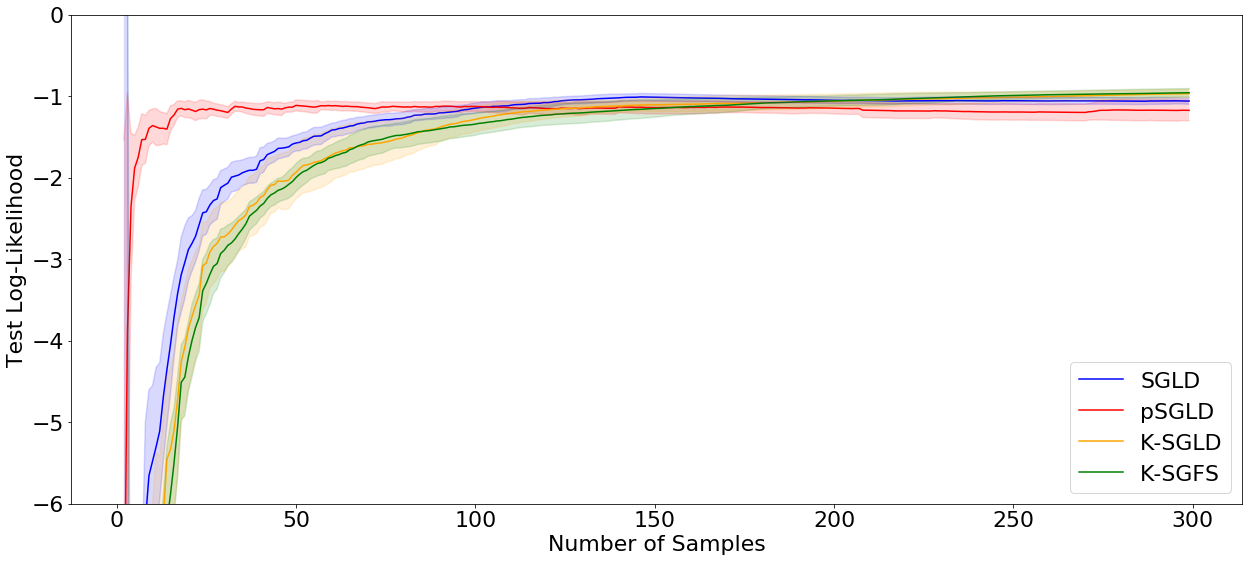

In [25]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),ll_meanRunningSGLD,'blue', label = 'SGLD')
plt.plot(range(n_samples),ll_meanRunningPSGLD,'red', label = 'pSGLD')
plt.plot(range(n_samples),ll_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),ll_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),ll_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),ll_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),ll_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),ll_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),ll_lowerSGLD, ll_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerPSGLD, ll_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGLD, ll_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGFS, ll_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("Test Log-Likelihood")
plt.ylim(-6,0)
plt.legend()


### RMSE

In [26]:
rmse_meanRunningSGLD = np.mean(rmse_sgld, 0)
rmse_stdRunningSGLD = np.std(rmse_sgld, 0)
rmse_upperSGLD = rmse_meanRunningSGLD + rmse_stdRunningSGLD
rmse_lowerSGLD = rmse_meanRunningSGLD - rmse_stdRunningSGLD

rmse_meanRunningPSGLD = np.mean(rmse_psgld, 0)
rmse_stdRunningPSGLD = np.std(rmse_psgld, 0)
rmse_upperPSGLD = rmse_meanRunningPSGLD + rmse_stdRunningPSGLD
rmse_lowerPSGLD = rmse_meanRunningPSGLD - rmse_stdRunningPSGLD

rmse_meanRunningKSGLD = np.mean(rmse_ksgld, 0)
rmse_stdRunningKSGLD = np.std(rmse_ksgld, 0)
rmse_upperKSGLD = rmse_meanRunningKSGLD + rmse_stdRunningKSGLD
rmse_lowerKSGLD = rmse_meanRunningKSGLD - rmse_stdRunningKSGLD

rmse_meanRunningKSGFS = np.mean(rmse_ksgfs, 0)
rmse_stdRunningKSGFS = np.std(rmse_ksgfs, 0)
rmse_upperKSGFS = rmse_meanRunningKSGFS + rmse_stdRunningKSGFS
rmse_lowerKSGFS = rmse_meanRunningKSGFS - rmse_stdRunningKSGFS

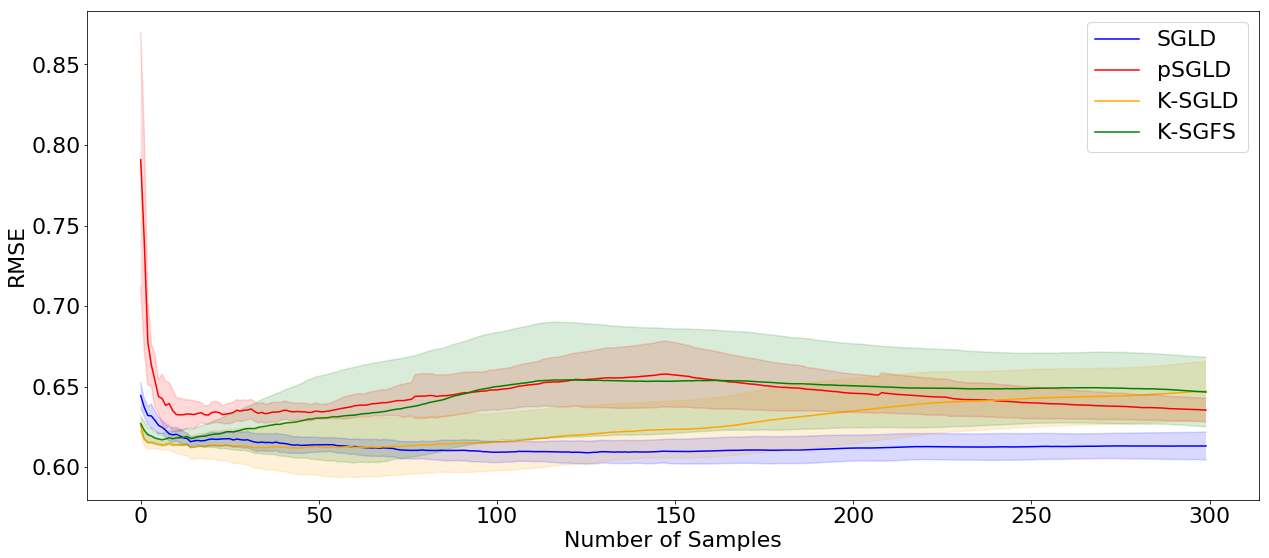

In [27]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),rmse_meanRunningSGLD,'blue', label='SGLD')
plt.plot(range(n_samples),rmse_meanRunningPSGLD,'red', label ='pSGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),rmse_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),rmse_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),rmse_lowerSGLD, rmse_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerPSGLD, rmse_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGLD, rmse_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGFS, rmse_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("RMSE")

plt.legend()
